In [1]:
import numpy as np
import sklearn.datasets as ds
import pylab as pl
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import random as r
import sys
%pylab inline

def MSE(x, y):
    
    return ((x - y)**2).sum() / float(len(x))

#calculate variance of set
def variance_calculate(X):
#     n_points = X.shape[0]
#     var = 0
    
#     for i1 in xrange(n_points):
#         for i2 in xrange(i1 + 1, n_points):
#             var += (X[i1] - X[i2]) ** 2;
#             print i1, i2, var
    
#     print "calculate varianse of ", X, (1.0 / (2 * n_points ** 2)) * var
    
#     return (1.0 / n_points ** 2) * var
#     print X
    return np.var(X)
    
# search best split in X of split_feature
def search_best_split_of_feat(X, Y, split_feature, orig_var, min_samples_leaf):
    best_gain = 0
    checked_split_value = []
    best_split_value = None
    res_X_l = None
    res_X_r = None
    res_Y_l = None
    res_Y_r = None
    
    for split_value in X[:, split_feature]:
        if split_value in checked_split_value:
            continue
        checked_split_value.append(split_value)
#         print np.where(X[:, split_feature] < split_value)
        X_l = X[np.where(X[:, split_feature] < split_value)]
        X_r = X[np.where(X[:, split_feature] >= split_value)]
        Y_l = Y[np.where(X[:, split_feature] < split_value)]
        Y_r = Y[np.where(X[:, split_feature] >= split_value)]
#         print "split_value: ", split_value
#         print X_l, X_r, Y_l, Y_r
#         print X_l.shape[0]
#         print X_r.shape[0]
        if X_l.shape[0] >= min_samples_leaf and X_r.shape[0] > min_samples_leaf:
            var_l = variance_calculate(Y_l)
            var_r = variance_calculate(Y_r)
            
#             print orig_var, var_l, var_r,\
#                 (orig_var - (len(Y_l) / float(len(Y))) * var_l - (len(Y_r) / float(len(Y))) * var_r), best_gain
#             if (orig_var - var_l - var_r) > best_gain:
            if (orig_var - (len(Y_l) / float(len(Y))) * var_l - (len(Y_r) / float(len(Y))) * var_r) > best_gain:
                best_gain = orig_var - (len(Y_l) / float(len(Y))) * var_l - (len(Y_r) / float(len(Y))) * var_r
                best_split_value = split_value
                res_X_l = X_l
                res_X_r = X_r
                res_Y_l = Y_l
                res_Y_r = Y_r
    
    return best_gain, best_split_value, res_X_l, res_X_r, res_Y_l, res_Y_r

class Tree:
    def __init__(self, split_feature = None, split_val = None,\
                 left = None, right = None, n_points = None, depth = 10, min_samples_leaf = 1):
        self.split_feature = split_feature
        self.split_val = split_val
        self.left = left
        self.right = right
        self.data = None
        self.n_points = n_points
        self.depth = depth
        self.min_samples_leaf = min_samples_leaf
    
    #return MSE
    def score(self, X, Y):
        predicted = self.predict(X)
        MSE = ((predicted - Y)**2).sum() / float(len(X))
        print "MSE: ", MSE

    def predict_one(self, sample):
        if self.data is not None:
            return self.data

        if sample[self.split_feature] >= self.split_value:
            return self.right.predict_one(sample)
        else:
            return self.left.predict_one(sample)

    def predict(self, X):
        predicted = []
        for sample in X:
#             print sample
            predicted.append(self.predict_one(sample))
        return np.asarray(predicted)
            
    #building tree
    def fit (self, X, Y):
#         print "start_fitting:", X, Y
        self.n_points = X.shape[0]
        if self.n_points <= self.min_samples_leaf or self.depth == 0:
#             print "N_POINTS: ", self.n_points
            self.data = np.mean(Y)
            return self
        
        best_gain = 0
        res_split_value = 0
        res_split_feature = None
        res_X_r = None
        res_X_l = None
        res_Y_l = None
        res_Y_r = None
        orig_var = variance_calculate(Y)
        
        n_feat = X.shape[1]
        for feat in xrange(n_feat):
#             print 
#             print "Analusys of feature ", feat
            gain, split_value, X_l , X_r, Y_l, Y_r = search_best_split_of_feat(X, Y, feat, orig_var, self.min_samples_leaf)
            if gain > best_gain:
                best_gain = gain
                res_split_value = split_value
                res_split_feature = feat
                res_X_r = X_r
                res_X_l = X_l
                res_Y_l = Y_l
                res_Y_r = Y_r
        
#         print "BEST SPLIT: "
#         print res_split_feature, res_split_value
#         print res_X_l, res_X_r, res_Y_l, res_Y_r
#         print 
            
        if best_gain > 0:
            self.split_feature = res_split_feature
            self.split_value = res_split_value
            if self.depth is None:
                self.left = Tree(min_points_leaf = self.min_points_leaf).fit(res_X_l, res_Y_l)
                self.right = Tree(min_points_leaf = self.min_points_leaf).fit(res_X_r, res_Y_r)
            else:
                self.left = Tree(depth = self.depth - 1, min_samples_leaf = self.min_samples_leaf).fit(res_X_l, res_Y_l)
                self.right = Tree(depth = self.depth - 1, min_samples_leaf = self.min_samples_leaf).fit(res_X_r, res_Y_r)
                
        else:
            self.n_points = len(Y)
#             print "N_POINTS: ", self.n_points
#             print X
#             print Y
            self.data = np.mean(Y)
        return self
            
    def print_tree(self):
        if self.data != None:
            print str(self.data)
        else:
            print str(self.split_feature) + ": " + str(self.split_value) + "?"
            print "\t T->"
            if (self.right):
                self.right.print_tree()
            print "\t F->"
            if self.left:
                self.left.print_tree()
        

class Gradient_Boosting:
    def __init__(self, n_estimators=10, shrinkage=0.05, max_depth=10, min_samples_leaf=1):
        self.estimators_list = []
        self.n_estimators = n_estimators
        self.shrinkage = shrinkage
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, Y):
        self.estimators_list = []
        first_estimator = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf).fit(X, Y)
        self.estimators_list.append(first_estimator)
        
        current_predict = first_estimator.predict(X)
#         sys.stderr.write('\rLearning estimator number: 0'+ "/" + str(self.n_estimators))
#         print  "\tLearning estimator number: 0 ; MSE error on train dataset: ", MSE(current_predict, Y)
        
        for i in xrange(1, self.n_estimators + 1):
            
            antigrad = Y - current_predict
            
#             print "trololo"
            new_estimator = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
#             new_estimator = Tree(depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            new_estimator = new_estimator.fit(X, antigrad)
#             print "lalala"
#             new_estimator.print_tree()
            
#             print set(antigrad)
#             print new_estimator.predict(X)[:10]
            current_predict += self.shrinkage * new_estimator.predict(X)
            
#             if i % 10 == 0:
#                 print "\tLearning estimator number: ", i,\
#                         "; MSE error on train dataset: ", MSE(current_predict, Y)
            
            sys.stderr.write('\rLearning estimator number: '+ str(i)+"/" + str(self.n_estimators) \
                             + "; MSE error on train dataset: " + str(MSE(current_predict, Y)))
            self.estimators_list.append(new_estimator)
    
    def predict(self, X):
        y =  self.estimators_list[0].predict(X)
#         print len(y)
        for estimator in self.estimators_list[1:]:
            y += estimator.predict(X) * self.shrinkage
#             print MSE(y, Y)
        return y

#n_bag -count of bagging iteration
#n_boo - count of tree in Gradien Boosting
#max_depth - max depth of trees TODO:dinamic depth of trees
#min_samples_leaf
#bagging_ratio -cnt of samples (in percent), which using for bagging interation
#RSM and Bagging without replacement
class BagBoo:
    def __init__ (self, n_boo = 10, n_bag = 10, bagging_ratio = 1.0, rsm_ratio = 1, max_depth = 10,\
                  min_samples_leaf = 1, shrinkage = 0.1):
        self.n_boo = n_boo
        self.n_bag = n_bag
        self.bagging_ratio = bagging_ratio
        self.rsm_ratio = rsm_ratio
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.boosting_list = []
        self.shrinkage = shrinkage
        
    def fit(self, X, Y, verbose = 0, X_test = None, Y_test = None):
        cur_sum_predict = 0 
        cur_sum_train = 0
        error_statistic_test = []
        error_statistic_train = []
#         rsm_cnt = int(self.rsm_ratio * X.shape[1])
#         bagging_cnt = int(self.bagging_ratio * X.shape[0])
#         print "features in RMS: ", rsm_cnt
#         print "samples in bagging: ", bagging_cnt
        for bag_iter in xrange(self.n_bag):
            sys.stderr.write('\rIteration of bagging:'+str(bag_iter) + "/" + str(self.n_bag))
#            print "Iteration of bagging: "+ str(bag_iter) + "/" + str(self.n_bag)
            shuffle_idx_bagging = [r.randint(0, X.shape[0] - 1) for i in range(X.shape[0])]
#             print "1"
#             shuffle_idx_rsm = range(X.shape[1])
            
#             r.shuffle(shuffle_idx_bagging)
#             r.shuffle(shuffle_idx_rsm)
#             shuffle_idx_bagging = shuffle_idx_bagging[:bagging_cnt]
#             shuffle_idx_rsm = shuffle_idx_rsm[:rsm_cnt]

#             print shuffle_idx_bagging, shuffle_idx_rsm

            X_bag = X[shuffle_idx_bagging]
            Y_bag = Y[shuffle_idx_bagging]
#             print "sgs", X_bag, Y_bag
            
            new_boosting = Gradient_Boosting(n_estimators= self.n_boo, max_depth=self.max_depth,\
                                             min_samples_leaf= self.min_samples_leaf, shrinkage = self.shrinkage)

#             new_boosting = GradientBoostingRegressor(criterion="mse", n_estimators= self.n_boo, max_depth=self.max_depth, \
#                                              min_samples_leaf= self.min_samples_leaf, learning_rate = self.shrinkage)
            new_boosting.fit(X_bag, Y_bag)
            
            self.boosting_list.append(new_boosting)
            
            if verbose:
                cur_sum_predict += new_boosting.predict(X_test)
                cur_sum_train += new_boosting.predict(X)
                error_test =  MSE(cur_sum_predict / float(len(self.boosting_list)), Y_test)
                error_train =  MSE(cur_sum_train / float(len(self.boosting_list)), Y)
                print "MSE on test Dataset:", error_test, "Iteration of Bagging:", bag_iter, "/", self.n_bag
                print "MSE on train Dataset:", error_train, "Iteration of Bagging:", bag_iter, "/", self.n_bag
                error_statistic_test.append(error_test)
                error_statistic_train.append(error_train)
               
        return error_statistic_test, error_statistic_train    

    def predict(self, X):
        y = np.array([0.0] * X.shape[0])
        for boosting in self.boosting_list:
            y += boosting.predict(X)
        return y / float(self.n_bag)


Populating the interactive namespace from numpy and matplotlib


In [2]:
X = np.array([[1, 0, 5], [2, 3, 5], [2, 3, 4], [2, 9, 1], [2, 9, 4], [1, 2, 1]])
Y = np.array([1, 0, 3, 6, 4, 1])
test = BagBoo(bagging_ratio=0.5, rsm_ratio=0.8).fit(X, Y)

Learning estimator number: 10/10; MSE error on train dataset: 0.0

In [3]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print x[[0, 0, 0]]

[[1 2 3]
 [1 2 3]
 [1 2 3]]


In [4]:
spam_train = np.loadtxt("./data/spam.train.txt")
spam_test = np.loadtxt("./data/spam.test.txt")
spam_train_data = spam_train[0::, 1::]
spam_train_target = spam_train[0::, 0]
spam_test_data = spam_test[0::, 1::]
spam_test_target = spam_test[0::, 0]
print "Train Dataset Shape: ", spam_train.shape
print "Test Dataset Shape: ", spam_test.shape

Train Dataset Shape:  (7093, 103)
Test Dataset Shape:  (10056, 103)


BagBoo Parametrs:
    1. N_Boo
    2. N_Bag
    3. bagging_ratio
    4. max_depth
    5. shrinkage

In [4]:
log = open("./spam_stat_log.txt", "a")

In [4]:
#fixed N_Boo * N_Bag = 1000
def calculate_statistics_bag_boo (param = 1000, step = 30, begin_value = 1,\
                                  max_depth = 2, bagging_ratio = 0.03, shrinkage = 0.01):
    bag_iter_list = [begin_value + step * i for i in range(param/step)]
    boo_iter_list = [int(param / float(bag)) + 1 for bag in bag_iter_list[:]]
    error_statistic = []
#     print bag_iter_list
#     print boo_iter_list
    log.write(str(bagging_ratio) + "\n")
    log.flush()
    for exp in range(len(bag_iter_list)):
#         print exp, boo_iter_list[exp], bag_iter_list[exp]
        print "Experiment: "+ str(exp) + "/" + str(len(bag_iter_list)) + \
                "\tBagging Iteration: " + str(bag_iter_list[exp]) + \
                    "\tBoosting Iteration: " + str(boo_iter_list[exp])
        
        bagboo_spam = BagBoo(n_boo= boo_iter_list[exp], n_bag=bag_iter_list[exp], \
                             bagging_ratio=bagging_ratio, max_depth=max_depth)
        
        bagboo_spam.fit(spam_train_data, spam_train_target)
        error = MSE(bagboo_spam.predict(spam_test_data), spam_test_target)
        error_statistic.append(error)
        log.write(str(boo_iter_list[exp]) + " " + str(bag_iter_list[exp]) + " " + str(error) + "\n")
        log.flush()
        print "\tMSE error: " + str(error)
    
    return error_statistic, bag_iter_list

In [11]:
%%time
error_stat, bag_list = calculate_statistics_bag_boo()

Experiment: 0/33	Bagging Iteration: 1	Boosting Iteration: 1001


Learning estimator number: 1000/1001; MSE error on train dataset: 1.49998093831e-06

	MSE error: 0.517597897004
Experiment: 1/33	Bagging Iteration: 31	Boosting Iteration: 33


Learning estimator number: 32/33; MSE error on train dataset: 0.0421686629702

	MSE error: 0.28491740881
Experiment: 2/33	Bagging Iteration: 61	Boosting Iteration: 17


Learning estimator number: 16/17; MSE error on train dataset: 0.0536411928044

	MSE error: 0.25811702877
Experiment: 3/33	Bagging Iteration: 91	Boosting Iteration: 11


Learning estimator number: 10/11; MSE error on train dataset: 0.0803271673807

	MSE error: 0.254706821789
Experiment: 4/33	Bagging Iteration: 121	Boosting Iteration: 9


Learning estimator number: 8/9; MSE error on train dataset: 0.0702005505322

	MSE error: 0.264795879313
Experiment: 5/33	Bagging Iteration: 151	Boosting Iteration: 7


Learning estimator number: 6/7; MSE error on train dataset: 0.059949684112

	MSE error: 0.265060821765
Experiment: 6/33	Bagging Iteration: 181	Boosting Iteration: 6


Learning estimator number: 5/6; MSE error on train dataset: 0.0661148450105

	MSE error: 0.298476653389
Experiment: 7/33	Bagging Iteration: 211	Boosting Iteration: 5


Learning estimator number: 4/5; MSE error on train dataset: 0.0709034306198

	MSE error: 0.26810213596
Experiment: 8/33	Bagging Iteration: 241	Boosting Iteration: 5


Learning estimator number: 4/5; MSE error on train dataset: 0.0726374145388

	MSE error: 0.320203668034
Experiment: 9/33	Bagging Iteration: 271	Boosting Iteration: 4


Learning estimator number: 3/4; MSE error on train dataset: 0.0877794711234

	MSE error: 0.292180508973
Experiment: 10/33	Bagging Iteration: 301	Boosting Iteration: 4


Learning estimator number: 3/4; MSE error on train dataset: 0.0746283435126

	MSE error: 0.314671686924
Experiment: 11/33	Bagging Iteration: 331	Boosting Iteration: 4


Learning estimator number: 3/4; MSE error on train dataset: 0.0832498479969

	MSE error: 0.293921782833
Experiment: 12/33	Bagging Iteration: 361	Boosting Iteration: 3


Learning estimator number: 2/3; MSE error on train dataset: 0.0835244217206

	MSE error: 0.288459422664
Experiment: 13/33	Bagging Iteration: 391	Boosting Iteration: 3


Learning estimator number: 2/3; MSE error on train dataset: 0.0843678531591

	MSE error: 0.276522326244
Experiment: 14/33	Bagging Iteration: 421	Boosting Iteration: 3


Learning estimator number: 2/3; MSE error on train dataset: 0.0890420037043

	MSE error: 0.287527085725
Experiment: 15/33	Bagging Iteration: 451	Boosting Iteration: 3


Learning estimator number: 2/3; MSE error on train dataset: 0.0809148784707

	MSE error: 0.290802778926
Experiment: 16/33	Bagging Iteration: 481	Boosting Iteration: 3


Learning estimator number: 2/3; MSE error on train dataset: 0.0786906303309

	MSE error: 0.303110076197
Experiment: 17/33	Bagging Iteration: 511	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0921837831061

	MSE error: 0.295297172903
Experiment: 18/33	Bagging Iteration: 541	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.103533080478

	MSE error: 0.295287990751
Experiment: 19/33	Bagging Iteration: 571	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0901109303178

	MSE error: 0.307469152809
Experiment: 20/33	Bagging Iteration: 601	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0740434828319

	MSE error: 0.312617188895
Experiment: 21/33	Bagging Iteration: 631	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0713084698345

	MSE error: 0.312818595917
Experiment: 22/33	Bagging Iteration: 661	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0854242671565

	MSE error: 0.287603691088
Experiment: 23/33	Bagging Iteration: 691	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0960170177294

	MSE error: 0.30303858426
Experiment: 24/33	Bagging Iteration: 721	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.101766589321

	MSE error: 0.308477006158
Experiment: 25/33	Bagging Iteration: 751	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0781525696541

	MSE error: 0.281011978039
Experiment: 26/33	Bagging Iteration: 781	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0736823408627

	MSE error: 0.295069527266
Experiment: 27/33	Bagging Iteration: 811	Boosting Iteration: 2


Learning estimator number: 1/2; MSE error on train dataset: 0.0925678290958

	MSE error: 0.297513493308
Experiment: 28/33	Bagging Iteration: 841	Boosting Iteration: 2


Iteration of bagging:540/841

KeyboardInterrupt: 

In [14]:
%%time
bagboo_spam = BagBoo(n_boo=60, n_bag=300, bagging_ratio=0.01, max_depth=2)    
bagboo_spam.fit(spam_train_data, spam_train_target)

print "MSE Error on test dataset: ", MSE(bagboo_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 59/60; MSE error on train dataset: 1.73241250008e-05

MSE Error on test dataset:  0.159302789863
CPU times: user 1h 55min 32s, sys: 11.2 s, total: 1h 55min 43s
Wall time: 1h 55min 52s


In [11]:
%%time
bagboo_spam = BagBoo(n_boo=50, n_bag=100, bagging_ratio=0.05, max_depth = 2, shrinkage=0.2)    
error_statistic_2 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

Learning estimator number: 49/50; MSE error on train dataset: 0.00367691204827

MSE on test Dataset: 0.436799932925 Iteration of Bagging: 0 / 100
MSE on train Dataset: 0.104497451025 Iteration of Bagging: 0 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00220248633697

MSE on test Dataset: 0.526057450741 Iteration of Bagging: 1 / 100
MSE on train Dataset: 0.0929051682463 Iteration of Bagging: 1 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00631821541661

MSE on test Dataset: 0.352485626312 Iteration of Bagging: 2 / 100
MSE on train Dataset: 0.0705254652551 Iteration of Bagging: 2 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00516703631604

MSE on test Dataset: 0.360948419483 Iteration of Bagging: 3 / 100
MSE on train Dataset: 0.0644606762221 Iteration of Bagging: 3 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00422933896233

MSE on test Dataset: 0.35803633324 Iteration of Bagging: 4 / 100
MSE on train Dataset: 0.0597948392148 Iteration of Bagging: 4 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00274616802291

MSE on test Dataset: 0.357327759828 Iteration of Bagging: 5 / 100
MSE on train Dataset: 0.0590892317987 Iteration of Bagging: 5 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00311667958482

MSE on test Dataset: 0.328519360377 Iteration of Bagging: 6 / 100
MSE on train Dataset: 0.0570917929103 Iteration of Bagging: 6 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00189475851125

MSE on test Dataset: 0.349197833673 Iteration of Bagging: 7 / 100
MSE on train Dataset: 0.0553545448968 Iteration of Bagging: 7 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00309269003707

MSE on test Dataset: 0.30116738956 Iteration of Bagging: 8 / 100
MSE on train Dataset: 0.0533939966249 Iteration of Bagging: 8 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00363072311186

MSE on test Dataset: 0.316254312092 Iteration of Bagging: 9 / 100
MSE on train Dataset: 0.0523837659136 Iteration of Bagging: 9 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00269711827009

MSE on test Dataset: 0.297972059265 Iteration of Bagging: 10 / 100
MSE on train Dataset: 0.0521345747785 Iteration of Bagging: 10 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00385367112644

MSE on test Dataset: 0.299215089472 Iteration of Bagging: 11 / 100
MSE on train Dataset: 0.0522289471888 Iteration of Bagging: 11 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00452854827436

MSE on test Dataset: 0.285944129938 Iteration of Bagging: 12 / 100
MSE on train Dataset: 0.0524304560732 Iteration of Bagging: 12 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00187091043462

MSE on test Dataset: 0.273752381532 Iteration of Bagging: 13 / 100
MSE on train Dataset: 0.0526232107711 Iteration of Bagging: 13 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00327027260426

MSE on test Dataset: 0.250679954126 Iteration of Bagging: 14 / 100
MSE on train Dataset: 0.0515273072529 Iteration of Bagging: 14 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00249506891981

MSE on test Dataset: 0.263428804641 Iteration of Bagging: 15 / 100
MSE on train Dataset: 0.0516186200835 Iteration of Bagging: 15 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00306143097362

MSE on test Dataset: 0.256164349691 Iteration of Bagging: 16 / 100
MSE on train Dataset: 0.0516188746663 Iteration of Bagging: 16 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00377566425115

MSE on test Dataset: 0.265016778617 Iteration of Bagging: 17 / 100
MSE on train Dataset: 0.0514385066737 Iteration of Bagging: 17 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00285914203488

MSE on test Dataset: 0.269217240252 Iteration of Bagging: 18 / 100
MSE on train Dataset: 0.0511889026865 Iteration of Bagging: 18 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00272072949319

MSE on test Dataset: 0.244476704814 Iteration of Bagging: 19 / 100
MSE on train Dataset: 0.0513313384773 Iteration of Bagging: 19 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00327561212509

MSE on test Dataset: 0.249051101385 Iteration of Bagging: 20 / 100
MSE on train Dataset: 0.0511513460679 Iteration of Bagging: 20 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00628709791087

MSE on test Dataset: 0.236851763281 Iteration of Bagging: 21 / 100
MSE on train Dataset: 0.0500670191901 Iteration of Bagging: 21 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00318589348468

MSE on test Dataset: 0.24662557618 Iteration of Bagging: 22 / 100
MSE on train Dataset: 0.0505588698626 Iteration of Bagging: 22 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00437972039886

MSE on test Dataset: 0.253188308439 Iteration of Bagging: 23 / 100
MSE on train Dataset: 0.0505576422591 Iteration of Bagging: 23 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00229392558542

MSE on test Dataset: 0.260362405288 Iteration of Bagging: 24 / 100
MSE on train Dataset: 0.0507876810687 Iteration of Bagging: 24 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00502444089847

MSE on test Dataset: 0.269109966204 Iteration of Bagging: 25 / 100
MSE on train Dataset: 0.0505077332978 Iteration of Bagging: 25 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00372426228235

MSE on test Dataset: 0.271759099446 Iteration of Bagging: 26 / 100
MSE on train Dataset: 0.0504308590127 Iteration of Bagging: 26 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00402868580402

MSE on test Dataset: 0.27680605516 Iteration of Bagging: 27 / 100
MSE on train Dataset: 0.0500380557071 Iteration of Bagging: 27 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00328538452296

MSE on test Dataset: 0.271833747586 Iteration of Bagging: 28 / 100
MSE on train Dataset: 0.0498817914883 Iteration of Bagging: 28 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00466342873997

MSE on test Dataset: 0.27761448777 Iteration of Bagging: 29 / 100
MSE on train Dataset: 0.0499360335273 Iteration of Bagging: 29 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00552504354281

MSE on test Dataset: 0.286641154044 Iteration of Bagging: 30 / 100
MSE on train Dataset: 0.0498003809683 Iteration of Bagging: 30 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00505157421539

MSE on test Dataset: 0.282524813502 Iteration of Bagging: 31 / 100
MSE on train Dataset: 0.0495644159867 Iteration of Bagging: 31 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00307698711269

MSE on test Dataset: 0.261378440196 Iteration of Bagging: 32 / 100
MSE on train Dataset: 0.0497956638064 Iteration of Bagging: 32 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00377091114403

MSE on test Dataset: 0.257255792297 Iteration of Bagging: 33 / 100
MSE on train Dataset: 0.0491406342639 Iteration of Bagging: 33 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00402148020557

MSE on test Dataset: 0.260893323227 Iteration of Bagging: 34 / 100
MSE on train Dataset: 0.049285154157 Iteration of Bagging: 34 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00443774463827

MSE on test Dataset: 0.2633275024 Iteration of Bagging: 35 / 100
MSE on train Dataset: 0.0493651190514 Iteration of Bagging: 35 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00324332838445

MSE on test Dataset: 0.263245451186 Iteration of Bagging: 36 / 100
MSE on train Dataset: 0.049617011586 Iteration of Bagging: 36 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00322244572058

MSE on test Dataset: 0.259329764397 Iteration of Bagging: 37 / 100
MSE on train Dataset: 0.0489989440283 Iteration of Bagging: 37 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00314644979846

MSE on test Dataset: 0.266561447585 Iteration of Bagging: 38 / 100
MSE on train Dataset: 0.0491170969966 Iteration of Bagging: 38 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00192121233728

MSE on test Dataset: 0.26988318543 Iteration of Bagging: 39 / 100
MSE on train Dataset: 0.0490818301276 Iteration of Bagging: 39 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00474161390466

MSE on test Dataset: 0.275624048874 Iteration of Bagging: 40 / 100
MSE on train Dataset: 0.0490603663915 Iteration of Bagging: 40 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00328993265543

MSE on test Dataset: 0.271460372502 Iteration of Bagging: 41 / 100
MSE on train Dataset: 0.0485346236231 Iteration of Bagging: 41 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00506971898467

MSE on test Dataset: 0.2675847633 Iteration of Bagging: 42 / 100
MSE on train Dataset: 0.0482012978636 Iteration of Bagging: 42 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.003399978103

MSE on test Dataset: 0.265069585281 Iteration of Bagging: 43 / 100
MSE on train Dataset: 0.0479261775325 Iteration of Bagging: 43 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00331611554895

MSE on test Dataset: 0.256586013243 Iteration of Bagging: 44 / 100
MSE on train Dataset: 0.0475654994636 Iteration of Bagging: 44 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00522371847003

MSE on test Dataset: 0.259102036717 Iteration of Bagging: 45 / 100
MSE on train Dataset: 0.0473814519888 Iteration of Bagging: 45 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00296607512037

MSE on test Dataset: 0.252708515027 Iteration of Bagging: 46 / 100
MSE on train Dataset: 0.0470368813879 Iteration of Bagging: 46 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00542661761793

MSE on test Dataset: 0.259133439442 Iteration of Bagging: 47 / 100
MSE on train Dataset: 0.0470089166804 Iteration of Bagging: 47 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00512911564947

MSE on test Dataset: 0.254506438597 Iteration of Bagging: 48 / 100
MSE on train Dataset: 0.0467956647491 Iteration of Bagging: 48 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00305503634216

MSE on test Dataset: 0.256492028806 Iteration of Bagging: 49 / 100
MSE on train Dataset: 0.0468922629262 Iteration of Bagging: 49 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00319798509076

MSE on test Dataset: 0.256280753092 Iteration of Bagging: 50 / 100
MSE on train Dataset: 0.0467956739684 Iteration of Bagging: 50 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00345326804112

MSE on test Dataset: 0.259136466169 Iteration of Bagging: 51 / 100
MSE on train Dataset: 0.0467960288159 Iteration of Bagging: 51 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00191859612949

MSE on test Dataset: 0.264937001369 Iteration of Bagging: 52 / 100
MSE on train Dataset: 0.0470436292918 Iteration of Bagging: 52 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00198993569483

MSE on test Dataset: 0.268511062024 Iteration of Bagging: 53 / 100
MSE on train Dataset: 0.0469635367858 Iteration of Bagging: 53 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00300672360823

MSE on test Dataset: 0.261000555354 Iteration of Bagging: 54 / 100
MSE on train Dataset: 0.0467076603808 Iteration of Bagging: 54 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00215510348282

MSE on test Dataset: 0.256817595245 Iteration of Bagging: 55 / 100
MSE on train Dataset: 0.0466578634623 Iteration of Bagging: 55 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00227029965637

MSE on test Dataset: 0.260242615793 Iteration of Bagging: 56 / 100
MSE on train Dataset: 0.0466872440872 Iteration of Bagging: 56 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.004829265004

MSE on test Dataset: 0.260856331566 Iteration of Bagging: 57 / 100
MSE on train Dataset: 0.0466220769037 Iteration of Bagging: 57 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00414711466365

MSE on test Dataset: 0.262110089109 Iteration of Bagging: 58 / 100
MSE on train Dataset: 0.0466547009549 Iteration of Bagging: 58 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.0041902198487

MSE on test Dataset: 0.262205675977 Iteration of Bagging: 59 / 100
MSE on train Dataset: 0.0465843268039 Iteration of Bagging: 59 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00314982584275

MSE on test Dataset: 0.262279739307 Iteration of Bagging: 60 / 100
MSE on train Dataset: 0.0466451393889 Iteration of Bagging: 60 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00317265435733

MSE on test Dataset: 0.259927304353 Iteration of Bagging: 61 / 100
MSE on train Dataset: 0.0466050741618 Iteration of Bagging: 61 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00294233036709

MSE on test Dataset: 0.259761487906 Iteration of Bagging: 62 / 100
MSE on train Dataset: 0.0466624306386 Iteration of Bagging: 62 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00422526384157

MSE on test Dataset: 0.259794121552 Iteration of Bagging: 63 / 100
MSE on train Dataset: 0.0466901450802 Iteration of Bagging: 63 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00395932833109

MSE on test Dataset: 0.261551758891 Iteration of Bagging: 64 / 100
MSE on train Dataset: 0.0466181997106 Iteration of Bagging: 64 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00257249265804

MSE on test Dataset: 0.257380314509 Iteration of Bagging: 65 / 100
MSE on train Dataset: 0.0466479952415 Iteration of Bagging: 65 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00395832222422

MSE on test Dataset: 0.259030679285 Iteration of Bagging: 66 / 100
MSE on train Dataset: 0.0467284241669 Iteration of Bagging: 66 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00516554364324

MSE on test Dataset: 0.260266414875 Iteration of Bagging: 67 / 100
MSE on train Dataset: 0.0466988297086 Iteration of Bagging: 67 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00346960705709

MSE on test Dataset: 0.262670570573 Iteration of Bagging: 68 / 100
MSE on train Dataset: 0.0466722422849 Iteration of Bagging: 68 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00326329809422

MSE on test Dataset: 0.25830267793 Iteration of Bagging: 69 / 100
MSE on train Dataset: 0.0464921288322 Iteration of Bagging: 69 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00214531873891

MSE on test Dataset: 0.259314846847 Iteration of Bagging: 70 / 100
MSE on train Dataset: 0.0465534742343 Iteration of Bagging: 70 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00345905863298

MSE on test Dataset: 0.263414872646 Iteration of Bagging: 71 / 100
MSE on train Dataset: 0.0466246062386 Iteration of Bagging: 71 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.0048074446528

MSE on test Dataset: 0.258621342191 Iteration of Bagging: 72 / 100
MSE on train Dataset: 0.0464557306212 Iteration of Bagging: 72 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00481512583144

MSE on test Dataset: 0.256473749675 Iteration of Bagging: 73 / 100
MSE on train Dataset: 0.0464808981635 Iteration of Bagging: 73 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00448035411578

MSE on test Dataset: 0.260770437214 Iteration of Bagging: 74 / 100
MSE on train Dataset: 0.0464797833894 Iteration of Bagging: 74 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00417633644293

MSE on test Dataset: 0.262416429804 Iteration of Bagging: 75 / 100
MSE on train Dataset: 0.0464906042523 Iteration of Bagging: 75 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00441111926436

MSE on test Dataset: 0.26317201896 Iteration of Bagging: 76 / 100
MSE on train Dataset: 0.0464895779325 Iteration of Bagging: 76 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00331710388807

MSE on test Dataset: 0.260484990853 Iteration of Bagging: 77 / 100
MSE on train Dataset: 0.0465746805002 Iteration of Bagging: 77 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00280231190214

MSE on test Dataset: 0.257320286474 Iteration of Bagging: 78 / 100
MSE on train Dataset: 0.0464536723517 Iteration of Bagging: 78 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00359477772731

MSE on test Dataset: 0.256719321543 Iteration of Bagging: 79 / 100
MSE on train Dataset: 0.0464078648627 Iteration of Bagging: 79 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00416094479984

MSE on test Dataset: 0.259912626604 Iteration of Bagging: 80 / 100
MSE on train Dataset: 0.0464551130155 Iteration of Bagging: 80 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00391301006373

MSE on test Dataset: 0.261068144983 Iteration of Bagging: 81 / 100
MSE on train Dataset: 0.0464883376187 Iteration of Bagging: 81 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00221615222357

MSE on test Dataset: 0.258412673809 Iteration of Bagging: 82 / 100
MSE on train Dataset: 0.0463336841324 Iteration of Bagging: 82 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00214615910406

MSE on test Dataset: 0.261067859154 Iteration of Bagging: 83 / 100
MSE on train Dataset: 0.0463697087052 Iteration of Bagging: 83 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00279976997049

MSE on test Dataset: 0.26177236053 Iteration of Bagging: 84 / 100
MSE on train Dataset: 0.0463741696784 Iteration of Bagging: 84 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00343136855089

MSE on test Dataset: 0.26558612184 Iteration of Bagging: 85 / 100
MSE on train Dataset: 0.0464529948525 Iteration of Bagging: 85 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00551850230104

MSE on test Dataset: 0.262349534421 Iteration of Bagging: 86 / 100
MSE on train Dataset: 0.0463015788261 Iteration of Bagging: 86 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00257190558224

MSE on test Dataset: 0.258640074695 Iteration of Bagging: 87 / 100
MSE on train Dataset: 0.0462346430609 Iteration of Bagging: 87 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00442893548722

MSE on test Dataset: 0.25969679171 Iteration of Bagging: 88 / 100
MSE on train Dataset: 0.0463557447932 Iteration of Bagging: 88 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00241761514494

MSE on test Dataset: 0.261320798867 Iteration of Bagging: 89 / 100
MSE on train Dataset: 0.0463862565168 Iteration of Bagging: 89 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00382949274682

MSE on test Dataset: 0.262891727415 Iteration of Bagging: 90 / 100
MSE on train Dataset: 0.0464219998946 Iteration of Bagging: 90 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00459013691197

MSE on test Dataset: 0.264750999372 Iteration of Bagging: 91 / 100
MSE on train Dataset: 0.0464560113883 Iteration of Bagging: 91 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00439858509164

MSE on test Dataset: 0.266300133587 Iteration of Bagging: 92 / 100
MSE on train Dataset: 0.0464442720676 Iteration of Bagging: 92 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00363693038637

MSE on test Dataset: 0.267352042169 Iteration of Bagging: 93 / 100
MSE on train Dataset: 0.0464991713808 Iteration of Bagging: 93 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00380319413681

MSE on test Dataset: 0.268130735771 Iteration of Bagging: 94 / 100
MSE on train Dataset: 0.0465254470246 Iteration of Bagging: 94 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00498412751866

MSE on test Dataset: 0.268464763502 Iteration of Bagging: 95 / 100
MSE on train Dataset: 0.0465040533405 Iteration of Bagging: 95 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00489615698635

MSE on test Dataset: 0.271373120365 Iteration of Bagging: 96 / 100
MSE on train Dataset: 0.0464873192732 Iteration of Bagging: 96 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00369540522398

MSE on test Dataset: 0.271630064048 Iteration of Bagging: 97 / 100
MSE on train Dataset: 0.0464925159203 Iteration of Bagging: 97 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00278284959295

MSE on test Dataset: 0.270766436562 Iteration of Bagging: 98 / 100
MSE on train Dataset: 0.0465296822502 Iteration of Bagging: 98 / 100


Learning estimator number: 49/50; MSE error on train dataset: 0.00625699212707

MSE on test Dataset: 0.271200010831 Iteration of Bagging: 99 / 100
MSE on train Dataset: 0.0464528709051 Iteration of Bagging: 99 / 100
CPU times: user 5h 7min 16s, sys: 6.4 s, total: 5h 7min 23s
Wall time: 5h 7min 19s


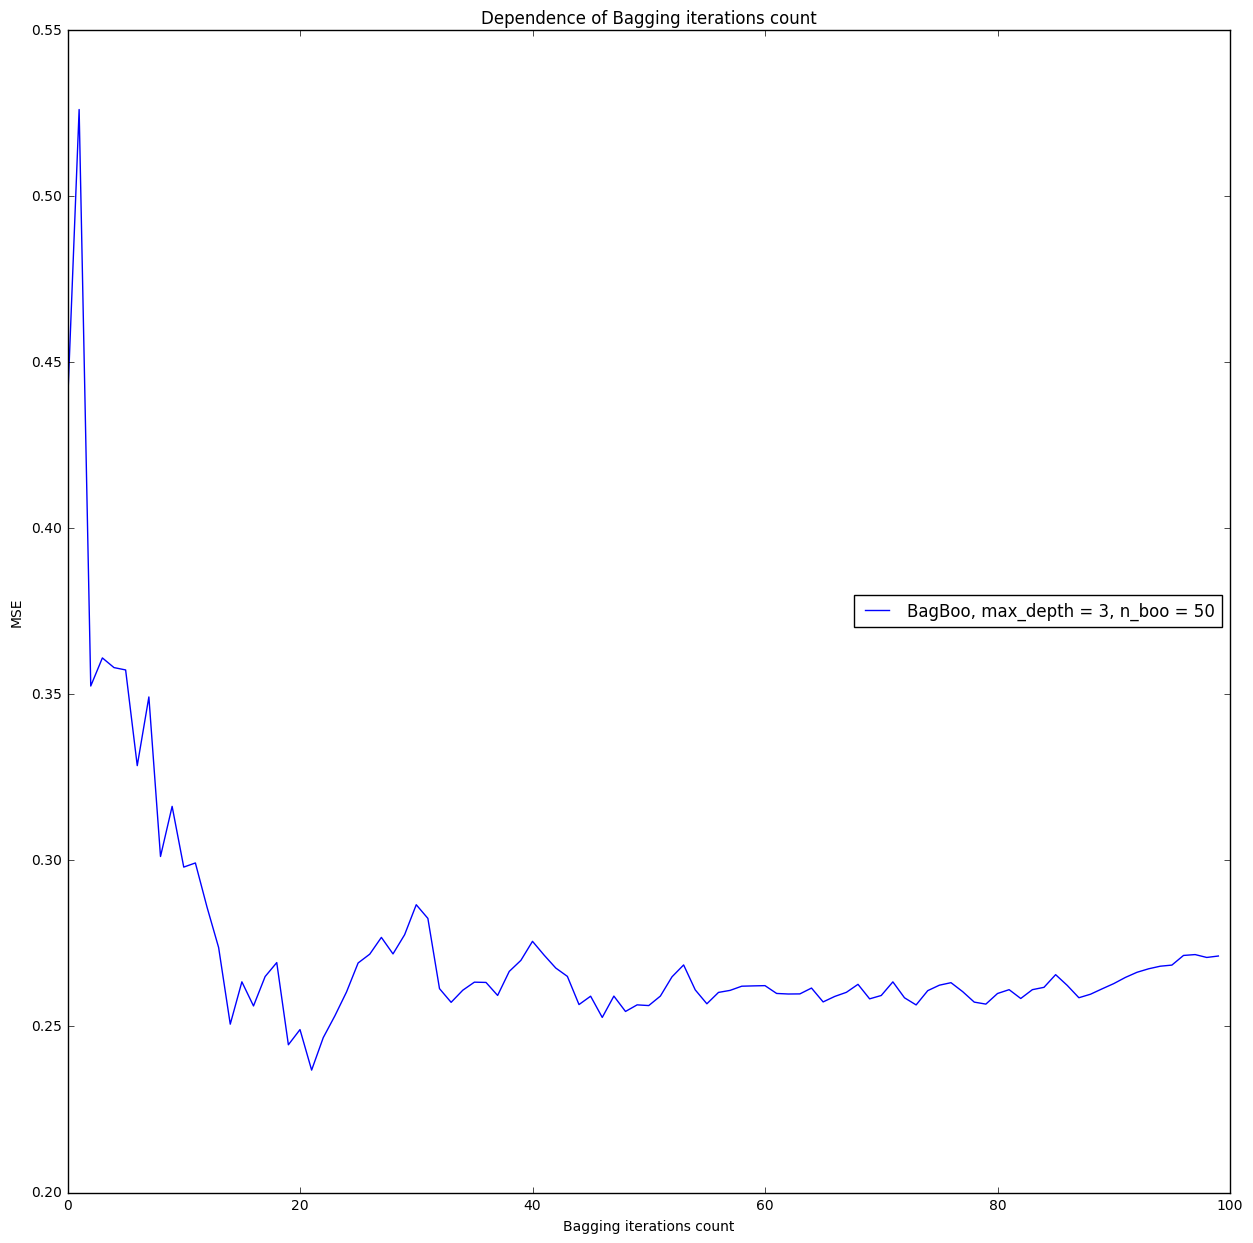

In [12]:
fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(range(0, 100), error_statistic_2, label='BagBoo, max_depth = 3, n_boo = 50')
ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Bagging iterations count')
ax.set_ylabel('MSE')

In [ ]:
bagboo_spam = BagBoo(n_boo=30, n_bag=300, bagging_ratio=0.03, max_depth=3, shrinkage=0.1)    
error_statistic_3 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

bagboo_spam = BagBoo(n_boo=30, n_bag=300, bagging_ratio=0.03, max_depth=4, shrinkage=0.1)    
error_statistic_4 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

In [9]:
error_statistic_2 = error_statistic

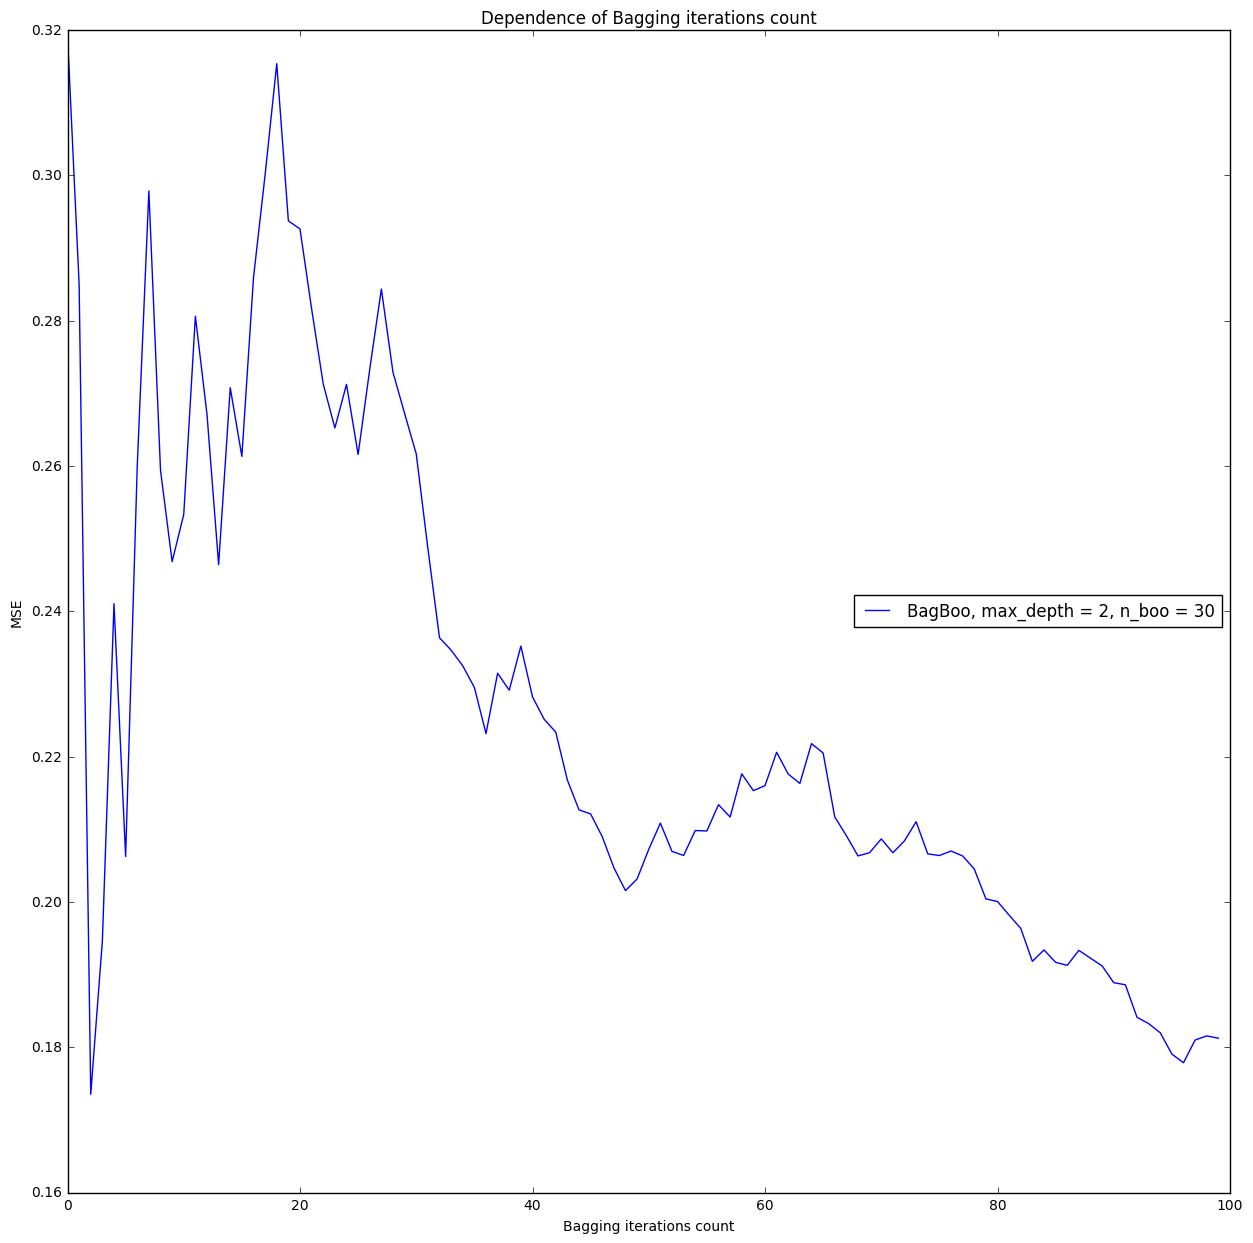

In [10]:
fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(range(0, 100), error_statistic_2, label='BagBoo, max_depth = 2, n_boo = 30')
ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Bagging iterations count')
ax.set_ylabel('MSE')

In [7]:
%%time
skl_gb_spam = GradientBoostingRegressor(criterion='mse', min_impurity_split=0, verbose=2, learning_rate=0.1)
skl_gb_spam.fit(spam_train_data, spam_train_target)
# print "MSE Error on train dataset: ", MSE(skl_gb_house.predict(house_data[:400]), house_target[:400])
print "MSE Error on test dataset: ", MSE( skl_gb_spam.predict(spam_test_data), spam_test_target)

      Iter       Train Loss   Remaining Time 
         1           0.2150            7.57s
         2           0.1916            5.98s
         3           0.1723            5.37s
         4           0.1562            5.23s
         5           0.1413            5.16s
         6           0.1291            4.86s
         7           0.1195            4.62s
         8           0.1097            4.47s
         9           0.1013            4.44s
        10           0.0942            4.41s
        11           0.0876            4.30s
        12           0.0821            4.21s
        13           0.0771            4.11s
        14           0.0726            4.09s
        15           0.0691            4.10s
        16           0.0659            4.03s
        17           0.0632            3.94s
        18           0.0605            3.87s
        19           0.0583            3.86s
        20           0.0558            3.79s
        21           0.0539            3.73s
        2

In [6]:
%%time
bagboo_spam = BagBoo(n_boo=30, n_bag=10, bagging_ratio=0.2, max_depth = 3, shrinkage=0.1)    
error_statistic_2 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

Learning estimator number: 29/30; MSE error on train dataset: 0.0431144075573

MSE on test Dataset: 0.507875832231 Iteration of Bagging: 0 / 10
MSE on train Dataset: 0.0661684428249 Iteration of Bagging: 0 / 10


Learning estimator number: 29/30; MSE error on train dataset: 0.0411554333262

MSE on test Dataset: 0.428235515993 Iteration of Bagging: 1 / 10
MSE on train Dataset: 0.059600474582 Iteration of Bagging: 1 / 10


Learning estimator number: 3/30; MSE error on train dataset: 0.0740003115099

KeyboardInterrupt: 

In [8]:
%%time
bagboo_spam = BagBoo(n_boo=10, n_bag=200, bagging_ratio=0.01, rsm_ratio=0.7, max_depth = 20, shrinkage=0.1)    
error_statistic_2 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target) 

features in RSM:  71
samples in bagging:  70


Learning estimator number: 9/10; MSE error on train dataset: 0.00107210453784

Iteration of Bagging: 0 / 200
fitting_samples:  0.00986888481602
MSE on test Dataset: 0.345916357528 Iteration of Bagging: 0 / 200
MSE on train Dataset: 0.484667030256 Iteration of Bagging: 0 / 200


Iteration of bagging:2/200

Iteration of Bagging: 1 / 200
fitting_samples:  0.019737769632
MSE on test Dataset: 0.36616032321 Iteration of Bagging: 1 / 200
MSE on train Dataset: 0.358250489652 Iteration of Bagging: 1 / 200


Iteration of bagging:3/200

Iteration of Bagging: 2 / 200
fitting_samples:  0.029606654448
MSE on test Dataset: 0.420378735517 Iteration of Bagging: 2 / 200
MSE on train Dataset: 0.362802507466 Iteration of Bagging: 2 / 200


Iteration of bagging:4/200

Iteration of Bagging: 3 / 200
fitting_samples:  0.0391935711265
MSE on test Dataset: 0.350892493501 Iteration of Bagging: 3 / 200
MSE on train Dataset: 0.313197260205 Iteration of Bagging: 3 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 4 / 200
fitting_samples:  0.0486395037361
MSE on test Dataset: 0.292564925364 Iteration of Bagging: 4 / 200
MSE on train Dataset: 0.270878715705 Iteration of Bagging: 4 / 200


Iteration of bagging:6/200

Iteration of Bagging: 5 / 200
fitting_samples:  0.0582264204145
MSE on test Dataset: 0.280643420139 Iteration of Bagging: 5 / 200
MSE on train Dataset: 0.255170095295 Iteration of Bagging: 5 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 6 / 200
fitting_samples:  0.0671084167489
MSE on test Dataset: 0.269260248564 Iteration of Bagging: 6 / 200
MSE on train Dataset: 0.253081448632 Iteration of Bagging: 6 / 200


Iteration of bagging:8/200

Iteration of Bagging: 7 / 200
fitting_samples:  0.0761313971521
MSE on test Dataset: 0.255332818488 Iteration of Bagging: 7 / 200
MSE on train Dataset: 0.258396327851 Iteration of Bagging: 7 / 200


Iteration of bagging:9/200

Iteration of Bagging: 8 / 200
fitting_samples:  0.0848724094177
MSE on test Dataset: 0.245190737711 Iteration of Bagging: 8 / 200
MSE on train Dataset: 0.265839972569 Iteration of Bagging: 8 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00214420907567

Iteration of Bagging: 9 / 200
fitting_samples:  0.0936134216833
MSE on test Dataset: 0.227413602771 Iteration of Bagging: 9 / 200
MSE on train Dataset: 0.260898300816 Iteration of Bagging: 9 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00194865344736

Iteration of Bagging: 10 / 200
fitting_samples:  0.102918370224
MSE on test Dataset: 0.219599418439 Iteration of Bagging: 10 / 200
MSE on train Dataset: 0.265676652607 Iteration of Bagging: 10 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00301547980094

Iteration of Bagging: 11 / 200
fitting_samples:  0.111941350627
MSE on test Dataset: 0.237213084807 Iteration of Bagging: 11 / 200
MSE on train Dataset: 0.267974877711 Iteration of Bagging: 11 / 200


Iteration of bagging:13/200

Iteration of Bagging: 12 / 200
fitting_samples:  0.120964331031
MSE on test Dataset: 0.234247172215 Iteration of Bagging: 12 / 200
MSE on train Dataset: 0.256519932061 Iteration of Bagging: 12 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 13 / 200
fitting_samples:  0.129987311434
MSE on test Dataset: 0.238307856657 Iteration of Bagging: 13 / 200
MSE on train Dataset: 0.254186987305 Iteration of Bagging: 13 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 14 / 200
fitting_samples:  0.138446355562
MSE on test Dataset: 0.234615599737 Iteration of Bagging: 14 / 200
MSE on train Dataset: 0.249210996785 Iteration of Bagging: 14 / 200


Iteration of bagging:16/200

Iteration of Bagging: 15 / 200
fitting_samples:  0.147328351896
MSE on test Dataset: 0.244470358913 Iteration of Bagging: 15 / 200
MSE on train Dataset: 0.252705999724 Iteration of Bagging: 15 / 200


Iteration of bagging:17/200

Iteration of Bagging: 16 / 200
fitting_samples:  0.155505427887
MSE on test Dataset: 0.230656740905 Iteration of Bagging: 16 / 200
MSE on train Dataset: 0.247973255012 Iteration of Bagging: 16 / 200


Iteration of bagging:18/200

Iteration of Bagging: 17 / 200
fitting_samples:  0.164246440152
MSE on test Dataset: 0.230678625456 Iteration of Bagging: 17 / 200
MSE on train Dataset: 0.246128997741 Iteration of Bagging: 17 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00230727182574

Iteration of Bagging: 18 / 200
fitting_samples:  0.17270548428
MSE on test Dataset: 0.241050611038 Iteration of Bagging: 18 / 200
MSE on train Dataset: 0.249959744881 Iteration of Bagging: 18 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0030244988426

Iteration of Bagging: 19 / 200
fitting_samples:  0.180177639927
MSE on test Dataset: 0.23160458653 Iteration of Bagging: 19 / 200
MSE on train Dataset: 0.245480715452 Iteration of Bagging: 19 / 200


Iteration of bagging:21/200

Iteration of Bagging: 20 / 200
fitting_samples:  0.188636684055
MSE on test Dataset: 0.245416104944 Iteration of Bagging: 20 / 200
MSE on train Dataset: 0.248171116055 Iteration of Bagging: 20 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00212847681504

Iteration of Bagging: 21 / 200
fitting_samples:  0.196531791908
MSE on test Dataset: 0.256819456328 Iteration of Bagging: 21 / 200
MSE on train Dataset: 0.249183967979 Iteration of Bagging: 21 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0023675411316

Iteration of Bagging: 22 / 200
fitting_samples:  0.204990836036
MSE on test Dataset: 0.263385673093 Iteration of Bagging: 22 / 200
MSE on train Dataset: 0.25849254268 Iteration of Bagging: 22 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00306467000416

Iteration of Bagging: 23 / 200
fitting_samples:  0.212885943888
MSE on test Dataset: 0.250159653322 Iteration of Bagging: 23 / 200
MSE on train Dataset: 0.253338953864 Iteration of Bagging: 23 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00274644236713

Iteration of Bagging: 24 / 200
fitting_samples:  0.221344988016
MSE on test Dataset: 0.24684322555 Iteration of Bagging: 24 / 200
MSE on train Dataset: 0.260846604281 Iteration of Bagging: 24 / 200


Iteration of bagging:26/200

Iteration of Bagging: 25 / 200
fitting_samples:  0.229663048076
MSE on test Dataset: 0.241228754865 Iteration of Bagging: 25 / 200
MSE on train Dataset: 0.25880169534 Iteration of Bagging: 25 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00145683076428

Iteration of Bagging: 26 / 200
fitting_samples:  0.237699139997
MSE on test Dataset: 0.231649827515 Iteration of Bagging: 26 / 200
MSE on train Dataset: 0.253401886903 Iteration of Bagging: 26 / 200


Iteration of bagging:28/200

Iteration of Bagging: 27 / 200
fitting_samples:  0.245453263781
MSE on test Dataset: 0.227223002721 Iteration of Bagging: 27 / 200
MSE on train Dataset: 0.257573692623 Iteration of Bagging: 27 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00179900473112

Iteration of Bagging: 28 / 200
fitting_samples:  0.252502467221
MSE on test Dataset: 0.234484740017 Iteration of Bagging: 28 / 200
MSE on train Dataset: 0.260224830781 Iteration of Bagging: 28 / 200


Iteration of bagging:30/200

Iteration of Bagging: 29 / 200
fitting_samples:  0.259551670661
MSE on test Dataset: 0.228677710762 Iteration of Bagging: 29 / 200
MSE on train Dataset: 0.252285688215 Iteration of Bagging: 29 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00288627553526

Iteration of Bagging: 30 / 200
fitting_samples:  0.267023826308
MSE on test Dataset: 0.234367802683 Iteration of Bagging: 30 / 200
MSE on train Dataset: 0.254563891436 Iteration of Bagging: 30 / 200


Iteration of bagging:32/200

Iteration of Bagging: 31 / 200
fitting_samples:  0.273650077541
MSE on test Dataset: 0.243800005657 Iteration of Bagging: 31 / 200
MSE on train Dataset: 0.256508254236 Iteration of Bagging: 31 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00301667670626

Iteration of Bagging: 32 / 200
fitting_samples:  0.2797123925
MSE on test Dataset: 0.239808716904 Iteration of Bagging: 32 / 200
MSE on train Dataset: 0.254343362545 Iteration of Bagging: 32 / 200


Iteration of bagging:34/200

Iteration of Bagging: 33 / 200
fitting_samples:  0.286902580008
MSE on test Dataset: 0.236373825846 Iteration of Bagging: 33 / 200
MSE on train Dataset: 0.249040671474 Iteration of Bagging: 33 / 200


Iteration of bagging:35/200

Iteration of Bagging: 34 / 200
fitting_samples:  0.294233751586
MSE on test Dataset: 0.244737609669 Iteration of Bagging: 34 / 200
MSE on train Dataset: 0.251025640241 Iteration of Bagging: 34 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00310983830519

Iteration of Bagging: 35 / 200
fitting_samples:  0.300437050613
MSE on test Dataset: 0.245786277489 Iteration of Bagging: 35 / 200
MSE on train Dataset: 0.252706115184 Iteration of Bagging: 35 / 200


Iteration of bagging:37/200

Iteration of Bagging: 36 / 200
fitting_samples:  0.307063301847
MSE on test Dataset: 0.246798397802 Iteration of Bagging: 36 / 200
MSE on train Dataset: 0.255070522216 Iteration of Bagging: 36 / 200


Iteration of bagging:38/200

Iteration of Bagging: 37 / 200
fitting_samples:  0.314112505287
MSE on test Dataset: 0.243690930864 Iteration of Bagging: 37 / 200
MSE on train Dataset: 0.254466336051 Iteration of Bagging: 37 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00209992425463

Iteration of Bagging: 38 / 200
fitting_samples:  0.320597772452
MSE on test Dataset: 0.239799567102 Iteration of Bagging: 38 / 200
MSE on train Dataset: 0.254256515487 Iteration of Bagging: 38 / 200


Iteration of bagging:40/200

Iteration of Bagging: 39 / 200
fitting_samples:  0.327365007754
MSE on test Dataset: 0.24427656042 Iteration of Bagging: 39 / 200
MSE on train Dataset: 0.257468711646 Iteration of Bagging: 39 / 200


Iteration of bagging:41/200

Iteration of Bagging: 40 / 200
fitting_samples:  0.334414211194
MSE on test Dataset: 0.240078183323 Iteration of Bagging: 40 / 200
MSE on train Dataset: 0.255922823536 Iteration of Bagging: 40 / 200


Iteration of bagging:42/200

Iteration of Bagging: 41 / 200
fitting_samples:  0.340899478359
MSE on test Dataset: 0.23548392937 Iteration of Bagging: 41 / 200
MSE on train Dataset: 0.255875085051 Iteration of Bagging: 41 / 200


Iteration of bagging:43/200

Iteration of Bagging: 42 / 200
fitting_samples:  0.346820809249
MSE on test Dataset: 0.230162599763 Iteration of Bagging: 42 / 200
MSE on train Dataset: 0.254889850055 Iteration of Bagging: 42 / 200


Iteration of bagging:44/200

Iteration of Bagging: 43 / 200
fitting_samples:  0.352319187932
MSE on test Dataset: 0.225391310016 Iteration of Bagging: 43 / 200
MSE on train Dataset: 0.251712391368 Iteration of Bagging: 43 / 200


Iteration of bagging:45/200

Iteration of Bagging: 44 / 200
fitting_samples:  0.359227407303
MSE on test Dataset: 0.231921579785 Iteration of Bagging: 44 / 200
MSE on train Dataset: 0.254274822751 Iteration of Bagging: 44 / 200


Iteration of bagging:46/200

Iteration of Bagging: 45 / 200
fitting_samples:  0.365853658537
MSE on test Dataset: 0.228717519134 Iteration of Bagging: 45 / 200
MSE on train Dataset: 0.255748573292 Iteration of Bagging: 45 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0020049542398

Iteration of Bagging: 46 / 200
fitting_samples:  0.372338925701
MSE on test Dataset: 0.22416664093 Iteration of Bagging: 46 / 200
MSE on train Dataset: 0.254427388124 Iteration of Bagging: 46 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00186059771405

Iteration of Bagging: 47 / 200
fitting_samples:  0.377837304385
MSE on test Dataset: 0.22970340585 Iteration of Bagging: 47 / 200
MSE on train Dataset: 0.255115427983 Iteration of Bagging: 47 / 200


Iteration of bagging:49/200

Iteration of Bagging: 48 / 200
fitting_samples:  0.384181587481
MSE on test Dataset: 0.23249501885 Iteration of Bagging: 48 / 200
MSE on train Dataset: 0.255959739625 Iteration of Bagging: 48 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00184294428221

Iteration of Bagging: 49 / 200
fitting_samples:  0.390666854645
MSE on test Dataset: 0.229475629886 Iteration of Bagging: 49 / 200
MSE on train Dataset: 0.255708897087 Iteration of Bagging: 49 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00302263859946

Iteration of Bagging: 50 / 200
fitting_samples:  0.396588185535
MSE on test Dataset: 0.232384138841 Iteration of Bagging: 50 / 200
MSE on train Dataset: 0.256931354367 Iteration of Bagging: 50 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0014538507683

Iteration of Bagging: 51 / 200
fitting_samples:  0.402650500493
MSE on test Dataset: 0.230220669471 Iteration of Bagging: 51 / 200
MSE on train Dataset: 0.256994953201 Iteration of Bagging: 51 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00107210453784

Iteration of Bagging: 52 / 200
fitting_samples:  0.408571831383
MSE on test Dataset: 0.228322430506 Iteration of Bagging: 52 / 200
MSE on train Dataset: 0.255421998529 Iteration of Bagging: 52 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00145682538088

Iteration of Bagging: 53 / 200
fitting_samples:  0.414493162273
MSE on test Dataset: 0.229705008847 Iteration of Bagging: 53 / 200
MSE on train Dataset: 0.25606807609 Iteration of Bagging: 53 / 200


Iteration of bagging:55/200

Iteration of Bagging: 54 / 200
fitting_samples:  0.420837445369
MSE on test Dataset: 0.226970916584 Iteration of Bagging: 54 / 200
MSE on train Dataset: 0.253529251515 Iteration of Bagging: 54 / 200


Iteration of bagging:56/200

Iteration of Bagging: 55 / 200
fitting_samples:  0.427463696602
MSE on test Dataset: 0.224209039294 Iteration of Bagging: 55 / 200
MSE on train Dataset: 0.250503219542 Iteration of Bagging: 55 / 200


Iteration of bagging:57/200

Iteration of Bagging: 56 / 200
fitting_samples:  0.433385027492
MSE on test Dataset: 0.228438079329 Iteration of Bagging: 56 / 200
MSE on train Dataset: 0.251792938605 Iteration of Bagging: 56 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00228548946889

Iteration of Bagging: 57 / 200
fitting_samples:  0.438460453969
MSE on test Dataset: 0.228722676585 Iteration of Bagging: 57 / 200
MSE on train Dataset: 0.252153877456 Iteration of Bagging: 57 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00291687756777

Iteration of Bagging: 58 / 200
fitting_samples:  0.443394896377
MSE on test Dataset: 0.225425056211 Iteration of Bagging: 58 / 200
MSE on train Dataset: 0.250118860962 Iteration of Bagging: 58 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00426576184548

Iteration of Bagging: 59 / 200
fitting_samples:  0.448047370647
MSE on test Dataset: 0.222763038499 Iteration of Bagging: 59 / 200
MSE on train Dataset: 0.248568299417 Iteration of Bagging: 59 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00244559815824

Iteration of Bagging: 60 / 200
fitting_samples:  0.453263781193
MSE on test Dataset: 0.226030598809 Iteration of Bagging: 60 / 200
MSE on train Dataset: 0.249837669372 Iteration of Bagging: 60 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00258979268909

Iteration of Bagging: 61 / 200
fitting_samples:  0.459044128014
MSE on test Dataset: 0.223946109182 Iteration of Bagging: 61 / 200
MSE on train Dataset: 0.250429700768 Iteration of Bagging: 61 / 200


Iteration of bagging:63/200

Iteration of Bagging: 62 / 200
fitting_samples:  0.464401522628
MSE on test Dataset: 0.224696928223 Iteration of Bagging: 62 / 200
MSE on train Dataset: 0.251876865838 Iteration of Bagging: 62 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00238703677395

Iteration of Bagging: 63 / 200
fitting_samples:  0.469476949105
MSE on test Dataset: 0.223576959401 Iteration of Bagging: 63 / 200
MSE on train Dataset: 0.25082659716 Iteration of Bagging: 63 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0022014922145

Iteration of Bagging: 64 / 200
fitting_samples:  0.474411391513
MSE on test Dataset: 0.221978108053 Iteration of Bagging: 64 / 200
MSE on train Dataset: 0.250622999614 Iteration of Bagging: 64 / 200


Iteration of bagging:66/200

Iteration of Bagging: 65 / 200
fitting_samples:  0.479768786127
MSE on test Dataset: 0.220324454978 Iteration of Bagging: 65 / 200
MSE on train Dataset: 0.247723017243 Iteration of Bagging: 65 / 200


Iteration of bagging:67/200

Iteration of Bagging: 66 / 200
fitting_samples:  0.484562244466
MSE on test Dataset: 0.221116457906 Iteration of Bagging: 66 / 200
MSE on train Dataset: 0.248397215805 Iteration of Bagging: 66 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00210621112491

Iteration of Bagging: 67 / 200
fitting_samples:  0.489637670943
MSE on test Dataset: 0.221582969442 Iteration of Bagging: 67 / 200
MSE on train Dataset: 0.24855265105 Iteration of Bagging: 67 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00199739972191

Iteration of Bagging: 68 / 200
fitting_samples:  0.49471309742
MSE on test Dataset: 0.219852559711 Iteration of Bagging: 68 / 200
MSE on train Dataset: 0.247520815107 Iteration of Bagging: 68 / 200


Iteration of bagging:70/200

Iteration of Bagging: 69 / 200
fitting_samples:  0.499506555759
MSE on test Dataset: 0.218972862017 Iteration of Bagging: 69 / 200
MSE on train Dataset: 0.24533409941 Iteration of Bagging: 69 / 200


Iteration of bagging:71/200

Iteration of Bagging: 70 / 200
fitting_samples:  0.50528690258
MSE on test Dataset: 0.219173771801 Iteration of Bagging: 70 / 200
MSE on train Dataset: 0.245155241764 Iteration of Bagging: 70 / 200


Iteration of bagging:72/200

Iteration of Bagging: 71 / 200
fitting_samples:  0.510080360919
MSE on test Dataset: 0.220392892017 Iteration of Bagging: 71 / 200
MSE on train Dataset: 0.245030527052 Iteration of Bagging: 71 / 200


Iteration of bagging:73/200

Iteration of Bagging: 72 / 200
fitting_samples:  0.515014803327
MSE on test Dataset: 0.222770762339 Iteration of Bagging: 72 / 200
MSE on train Dataset: 0.244687103006 Iteration of Bagging: 72 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00201288808599

Iteration of Bagging: 73 / 200
fitting_samples:  0.520231213873
MSE on test Dataset: 0.222384944146 Iteration of Bagging: 73 / 200
MSE on train Dataset: 0.244029121029 Iteration of Bagging: 73 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00142671847498

Iteration of Bagging: 74 / 200
fitting_samples:  0.52530664035
MSE on test Dataset: 0.221214882954 Iteration of Bagging: 74 / 200
MSE on train Dataset: 0.244039752656 Iteration of Bagging: 74 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00249774420647

Iteration of Bagging: 75 / 200
fitting_samples:  0.529395178345
MSE on test Dataset: 0.220028728877 Iteration of Bagging: 75 / 200
MSE on train Dataset: 0.241192925885 Iteration of Bagging: 75 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00252752526093

Iteration of Bagging: 76 / 200
fitting_samples:  0.53461158889
MSE on test Dataset: 0.223299701033 Iteration of Bagging: 76 / 200
MSE on train Dataset: 0.242271521231 Iteration of Bagging: 76 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00301093601851

Iteration of Bagging: 77 / 200
fitting_samples:  0.538559142817
MSE on test Dataset: 0.224496457954 Iteration of Bagging: 77 / 200
MSE on train Dataset: 0.241804640289 Iteration of Bagging: 77 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00258979268909

Iteration of Bagging: 78 / 200
fitting_samples:  0.5440575215
MSE on test Dataset: 0.223162494747 Iteration of Bagging: 78 / 200
MSE on train Dataset: 0.24162778873 Iteration of Bagging: 78 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00296966524625

Iteration of Bagging: 79 / 200
fitting_samples:  0.548428027633
MSE on test Dataset: 0.220137327766 Iteration of Bagging: 79 / 200
MSE on train Dataset: 0.240850999155 Iteration of Bagging: 79 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00206187385395

Iteration of Bagging: 80 / 200
fitting_samples:  0.553080501903
MSE on test Dataset: 0.219047371369 Iteration of Bagging: 80 / 200
MSE on train Dataset: 0.240781133633 Iteration of Bagging: 80 / 200


Iteration of bagging:82/200

Iteration of Bagging: 81 / 200
fitting_samples:  0.557310023967
MSE on test Dataset: 0.221740141554 Iteration of Bagging: 81 / 200
MSE on train Dataset: 0.241402090189 Iteration of Bagging: 81 / 200


Iteration of bagging:83/200

Iteration of Bagging: 82 / 200
fitting_samples:  0.562385450444
MSE on test Dataset: 0.221081285544 Iteration of Bagging: 82 / 200
MSE on train Dataset: 0.240886525783 Iteration of Bagging: 82 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00107210453784

Iteration of Bagging: 83 / 200
fitting_samples:  0.566896940646
MSE on test Dataset: 0.220269413458 Iteration of Bagging: 83 / 200
MSE on train Dataset: 0.240739224026 Iteration of Bagging: 83 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00201277927689

Iteration of Bagging: 84 / 200
fitting_samples:  0.571690398985
MSE on test Dataset: 0.218611014947 Iteration of Bagging: 84 / 200
MSE on train Dataset: 0.240572391299 Iteration of Bagging: 84 / 200


Iteration of bagging:86/200

Iteration of Bagging: 85 / 200
fitting_samples:  0.574792048499
MSE on test Dataset: 0.22170717795 Iteration of Bagging: 85 / 200
MSE on train Dataset: 0.241854598479 Iteration of Bagging: 85 / 200


Iteration of bagging:87/200

Iteration of Bagging: 86 / 200
fitting_samples:  0.578880586494
MSE on test Dataset: 0.223959750519 Iteration of Bagging: 86 / 200
MSE on train Dataset: 0.242665772356 Iteration of Bagging: 86 / 200


Iteration of bagging:88/200

Iteration of Bagging: 87 / 200
fitting_samples:  0.582687156351
MSE on test Dataset: 0.227179055082 Iteration of Bagging: 87 / 200
MSE on train Dataset: 0.243318259616 Iteration of Bagging: 87 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00214420907567

Iteration of Bagging: 88 / 200
fitting_samples:  0.586070774003
MSE on test Dataset: 0.227721109834 Iteration of Bagging: 88 / 200
MSE on train Dataset: 0.242691735036 Iteration of Bagging: 88 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00227119903098

Iteration of Bagging: 89 / 200
fitting_samples:  0.590864232342
MSE on test Dataset: 0.227635091088 Iteration of Bagging: 89 / 200
MSE on train Dataset: 0.242773149918 Iteration of Bagging: 89 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00283304809904

Iteration of Bagging: 90 / 200
fitting_samples:  0.594952770337
MSE on test Dataset: 0.229705585129 Iteration of Bagging: 90 / 200
MSE on train Dataset: 0.243798722065 Iteration of Bagging: 90 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00275914113491

Iteration of Bagging: 91 / 200
fitting_samples:  0.597772451713
MSE on test Dataset: 0.228163679379 Iteration of Bagging: 91 / 200
MSE on train Dataset: 0.242380413761 Iteration of Bagging: 91 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00205777505719

Iteration of Bagging: 92 / 200
fitting_samples:  0.601297053433
MSE on test Dataset: 0.226171042362 Iteration of Bagging: 92 / 200
MSE on train Dataset: 0.241400313997 Iteration of Bagging: 92 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 93 / 200
fitting_samples:  0.604257718878
MSE on test Dataset: 0.227412766324 Iteration of Bagging: 93 / 200
MSE on train Dataset: 0.241922242605 Iteration of Bagging: 93 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00482460475247

Iteration of Bagging: 94 / 200
fitting_samples:  0.608205272804
MSE on test Dataset: 0.230004210709 Iteration of Bagging: 94 / 200
MSE on train Dataset: 0.244548270274 Iteration of Bagging: 94 / 200


Iteration of bagging:96/200

Iteration of Bagging: 95 / 200
fitting_samples:  0.612011842662
MSE on test Dataset: 0.228217580682 Iteration of Bagging: 95 / 200
MSE on train Dataset: 0.244019798642 Iteration of Bagging: 95 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00322959112865

Iteration of Bagging: 96 / 200
fitting_samples:  0.616100380657
MSE on test Dataset: 0.231585547262 Iteration of Bagging: 96 / 200
MSE on train Dataset: 0.247008754926 Iteration of Bagging: 96 / 200


Iteration of bagging:98/200

Iteration of Bagging: 97 / 200
fitting_samples:  0.619202030171
MSE on test Dataset: 0.228526819706 Iteration of Bagging: 97 / 200
MSE on train Dataset: 0.245550469093 Iteration of Bagging: 97 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0029471844448

Iteration of Bagging: 98 / 200
fitting_samples:  0.623290568166
MSE on test Dataset: 0.228731218497 Iteration of Bagging: 98 / 200
MSE on train Dataset: 0.244806795812 Iteration of Bagging: 98 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00294566900199

Iteration of Bagging: 99 / 200
fitting_samples:  0.627802058367
MSE on test Dataset: 0.228959733261 Iteration of Bagging: 99 / 200
MSE on train Dataset: 0.245884662102 Iteration of Bagging: 99 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00209797147448

Iteration of Bagging: 100 / 200
fitting_samples:  0.631326660087
MSE on test Dataset: 0.227289319467 Iteration of Bagging: 100 / 200
MSE on train Dataset: 0.245233654202 Iteration of Bagging: 100 / 200


Iteration of bagging:102/200

Iteration of Bagging: 101 / 200
fitting_samples:  0.633864373326
MSE on test Dataset: 0.226620731337 Iteration of Bagging: 101 / 200
MSE on train Dataset: 0.243595646561 Iteration of Bagging: 101 / 200


Iteration of bagging:103/200

Iteration of Bagging: 102 / 200
fitting_samples:  0.637811927252
MSE on test Dataset: 0.228073355225 Iteration of Bagging: 102 / 200
MSE on train Dataset: 0.24245576746 Iteration of Bagging: 102 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00225770957878

Iteration of Bagging: 103 / 200
fitting_samples:  0.641477513041
MSE on test Dataset: 0.226083237784 Iteration of Bagging: 103 / 200
MSE on train Dataset: 0.241692381422 Iteration of Bagging: 103 / 200


Iteration of bagging:105/200

Iteration of Bagging: 104 / 200
fitting_samples:  0.644720146623
MSE on test Dataset: 0.226063223818 Iteration of Bagging: 104 / 200
MSE on train Dataset: 0.241832636901 Iteration of Bagging: 104 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00142671847498

Iteration of Bagging: 105 / 200
fitting_samples:  0.648103764275
MSE on test Dataset: 0.224390349154 Iteration of Bagging: 105 / 200
MSE on train Dataset: 0.240310990364 Iteration of Bagging: 105 / 200


Iteration of bagging:107/200

Iteration of Bagging: 106 / 200
fitting_samples:  0.650782461582
MSE on test Dataset: 0.223500166307 Iteration of Bagging: 106 / 200
MSE on train Dataset: 0.239641149192 Iteration of Bagging: 106 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00107210453784

Iteration of Bagging: 107 / 200
fitting_samples:  0.653461158889
MSE on test Dataset: 0.220546458572 Iteration of Bagging: 107 / 200
MSE on train Dataset: 0.239206385861 Iteration of Bagging: 107 / 200


Iteration of bagging:109/200

Iteration of Bagging: 108 / 200
fitting_samples:  0.655998872127
MSE on test Dataset: 0.221377727781 Iteration of Bagging: 108 / 200
MSE on train Dataset: 0.240051548411 Iteration of Bagging: 108 / 200


Iteration of bagging:110/200

Iteration of Bagging: 109 / 200
fitting_samples:  0.659382489779
MSE on test Dataset: 0.221724056434 Iteration of Bagging: 109 / 200
MSE on train Dataset: 0.23997215973 Iteration of Bagging: 109 / 200


Iteration of bagging:111/200

Iteration of Bagging: 110 / 200
fitting_samples:  0.661779218948
MSE on test Dataset: 0.221101881096 Iteration of Bagging: 110 / 200
MSE on train Dataset: 0.240295127045 Iteration of Bagging: 110 / 200


Iteration of bagging:112/200

Iteration of Bagging: 111 / 200
fitting_samples:  0.664739884393
MSE on test Dataset: 0.221185834896 Iteration of Bagging: 111 / 200
MSE on train Dataset: 0.240449964659 Iteration of Bagging: 111 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00301607953455

Iteration of Bagging: 112 / 200
fitting_samples:  0.667982517975
MSE on test Dataset: 0.223651714691 Iteration of Bagging: 112 / 200
MSE on train Dataset: 0.240906950095 Iteration of Bagging: 112 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 113 / 200
fitting_samples:  0.670802199351
MSE on test Dataset: 0.224387944162 Iteration of Bagging: 113 / 200
MSE on train Dataset: 0.241655980754 Iteration of Bagging: 113 / 200


Iteration of bagging:115/200

Iteration of Bagging: 114 / 200
fitting_samples:  0.674890737347
MSE on test Dataset: 0.223967224832 Iteration of Bagging: 114 / 200
MSE on train Dataset: 0.242238413165 Iteration of Bagging: 114 / 200


Iteration of bagging:116/200

Iteration of Bagging: 115 / 200
fitting_samples:  0.678697307204
MSE on test Dataset: 0.22376087099 Iteration of Bagging: 115 / 200
MSE on train Dataset: 0.243086342928 Iteration of Bagging: 115 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00200411656548

Iteration of Bagging: 116 / 200
fitting_samples:  0.682221908924
MSE on test Dataset: 0.224923230571 Iteration of Bagging: 116 / 200
MSE on train Dataset: 0.243746722915 Iteration of Bagging: 116 / 200


Iteration of bagging:118/200

Iteration of Bagging: 117 / 200
fitting_samples:  0.685746510644
MSE on test Dataset: 0.223812199305 Iteration of Bagging: 117 / 200
MSE on train Dataset: 0.243398374213 Iteration of Bagging: 117 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 118 / 200
fitting_samples:  0.689130128296
MSE on test Dataset: 0.222929263427 Iteration of Bagging: 118 / 200
MSE on train Dataset: 0.244030338942 Iteration of Bagging: 118 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0027013829926

Iteration of Bagging: 119 / 200
fitting_samples:  0.691949809672
MSE on test Dataset: 0.223786734972 Iteration of Bagging: 119 / 200
MSE on train Dataset: 0.243524808657 Iteration of Bagging: 119 / 200


Iteration of bagging:121/200

Iteration of Bagging: 120 / 200
fitting_samples:  0.695051459185
MSE on test Dataset: 0.22290980921 Iteration of Bagging: 120 / 200
MSE on train Dataset: 0.243081639658 Iteration of Bagging: 120 / 200


Iteration of bagging:122/200

Iteration of Bagging: 121 / 200
fitting_samples:  0.69801212463
MSE on test Dataset: 0.222738693972 Iteration of Bagging: 121 / 200
MSE on train Dataset: 0.242545033954 Iteration of Bagging: 121 / 200


Iteration of bagging:123/200

Iteration of Bagging: 122 / 200
fitting_samples:  0.700972790075
MSE on test Dataset: 0.223604678833 Iteration of Bagging: 122 / 200
MSE on train Dataset: 0.242669560644 Iteration of Bagging: 122 / 200


Iteration of bagging:124/200

Iteration of Bagging: 123 / 200
fitting_samples:  0.704215423657
MSE on test Dataset: 0.221975724071 Iteration of Bagging: 123 / 200
MSE on train Dataset: 0.242166245336 Iteration of Bagging: 123 / 200


Iteration of bagging:125/200

Iteration of Bagging: 124 / 200
fitting_samples:  0.70618920062
MSE on test Dataset: 0.222494655341 Iteration of Bagging: 124 / 200
MSE on train Dataset: 0.24199826869 Iteration of Bagging: 124 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0034666156103

Iteration of Bagging: 125 / 200
fitting_samples:  0.709290850134
MSE on test Dataset: 0.220981300515 Iteration of Bagging: 125 / 200
MSE on train Dataset: 0.241551803212 Iteration of Bagging: 125 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00145449449229

Iteration of Bagging: 126 / 200
fitting_samples:  0.711546595235
MSE on test Dataset: 0.220402474217 Iteration of Bagging: 126 / 200
MSE on train Dataset: 0.239833515595 Iteration of Bagging: 126 / 200


Iteration of bagging:128/200

Iteration of Bagging: 127 / 200
fitting_samples:  0.713802340336
MSE on test Dataset: 0.218783183673 Iteration of Bagging: 127 / 200
MSE on train Dataset: 0.23835276334 Iteration of Bagging: 127 / 200


Iteration of bagging:129/200

Iteration of Bagging: 128 / 200
fitting_samples:  0.716058085436
MSE on test Dataset: 0.22097953568 Iteration of Bagging: 128 / 200
MSE on train Dataset: 0.238765750045 Iteration of Bagging: 128 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 129 / 200
fitting_samples:  0.7180318624
MSE on test Dataset: 0.219189867902 Iteration of Bagging: 129 / 200
MSE on train Dataset: 0.238561045435 Iteration of Bagging: 129 / 200


Iteration of bagging:131/200

Iteration of Bagging: 130 / 200
fitting_samples:  0.72155646412
MSE on test Dataset: 0.217988999708 Iteration of Bagging: 130 / 200
MSE on train Dataset: 0.238410954036 Iteration of Bagging: 130 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00283615883785

Iteration of Bagging: 131 / 200
fitting_samples:  0.72508106584
MSE on test Dataset: 0.219750525936 Iteration of Bagging: 131 / 200
MSE on train Dataset: 0.238832190826 Iteration of Bagging: 131 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00210320197703

Iteration of Bagging: 132 / 200
fitting_samples:  0.728041731284
MSE on test Dataset: 0.221264753317 Iteration of Bagging: 132 / 200
MSE on train Dataset: 0.239391270289 Iteration of Bagging: 132 / 200


Iteration of bagging:134/200

Iteration of Bagging: 133 / 200
fitting_samples:  0.730156492316
MSE on test Dataset: 0.220533637681 Iteration of Bagging: 133 / 200
MSE on train Dataset: 0.239779005842 Iteration of Bagging: 133 / 200


Iteration of bagging:135/200

Iteration of Bagging: 134 / 200
fitting_samples:  0.732835189624
MSE on test Dataset: 0.219635736511 Iteration of Bagging: 134 / 200
MSE on train Dataset: 0.239525962518 Iteration of Bagging: 134 / 200


Iteration of bagging:136/200

Iteration of Bagging: 135 / 200
fitting_samples:  0.735654871
MSE on test Dataset: 0.219923303544 Iteration of Bagging: 135 / 200
MSE on train Dataset: 0.240198598841 Iteration of Bagging: 135 / 200


Iteration of bagging:137/200

Iteration of Bagging: 136 / 200
fitting_samples:  0.738615536444
MSE on test Dataset: 0.218525108811 Iteration of Bagging: 136 / 200
MSE on train Dataset: 0.239839360999 Iteration of Bagging: 136 / 200


Iteration of bagging:138/200

Iteration of Bagging: 137 / 200
fitting_samples:  0.740730297476
MSE on test Dataset: 0.216995574751 Iteration of Bagging: 137 / 200
MSE on train Dataset: 0.239235536746 Iteration of Bagging: 137 / 200


Iteration of bagging:139/200

Iteration of Bagging: 138 / 200
fitting_samples:  0.742422106302
MSE on test Dataset: 0.217071675721 Iteration of Bagging: 138 / 200
MSE on train Dataset: 0.239537494396 Iteration of Bagging: 138 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 139 / 200
fitting_samples:  0.745382771747
MSE on test Dataset: 0.215879483458 Iteration of Bagging: 139 / 200
MSE on train Dataset: 0.239598018712 Iteration of Bagging: 139 / 200


Iteration of bagging:141/200

Iteration of Bagging: 140 / 200
fitting_samples:  0.748202453123
MSE on test Dataset: 0.217475230395 Iteration of Bagging: 140 / 200
MSE on train Dataset: 0.239874723798 Iteration of Bagging: 140 / 200


Iteration of bagging:142/200

Iteration of Bagging: 141 / 200
fitting_samples:  0.751445086705
MSE on test Dataset: 0.217208542653 Iteration of Bagging: 141 / 200
MSE on train Dataset: 0.239688150966 Iteration of Bagging: 141 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00279721582563

Iteration of Bagging: 142 / 200
fitting_samples:  0.753559847737
MSE on test Dataset: 0.215814064972 Iteration of Bagging: 142 / 200
MSE on train Dataset: 0.239563821751 Iteration of Bagging: 142 / 200


Iteration of bagging:144/200

Iteration of Bagging: 143 / 200
fitting_samples:  0.755674608769
MSE on test Dataset: 0.216859253223 Iteration of Bagging: 143 / 200
MSE on train Dataset: 0.239533602955 Iteration of Bagging: 143 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00210608703719

Iteration of Bagging: 144 / 200
fitting_samples:  0.758494290145
MSE on test Dataset: 0.215827014777 Iteration of Bagging: 144 / 200
MSE on train Dataset: 0.23924613301 Iteration of Bagging: 144 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00142671847498

Iteration of Bagging: 145 / 200
fitting_samples:  0.761877907796
MSE on test Dataset: 0.214146963227 Iteration of Bagging: 145 / 200
MSE on train Dataset: 0.238670957058 Iteration of Bagging: 145 / 200


Iteration of bagging:147/200

Iteration of Bagging: 146 / 200
fitting_samples:  0.764556605104
MSE on test Dataset: 0.2136860898 Iteration of Bagging: 146 / 200
MSE on train Dataset: 0.238512191036 Iteration of Bagging: 146 / 200


Iteration of bagging:148/200

Iteration of Bagging: 147 / 200
fitting_samples:  0.766248413929
MSE on test Dataset: 0.215223820893 Iteration of Bagging: 147 / 200
MSE on train Dataset: 0.238134080455 Iteration of Bagging: 147 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 148 / 200
fitting_samples:  0.767658254617
MSE on test Dataset: 0.214222108324 Iteration of Bagging: 148 / 200
MSE on train Dataset: 0.237550794166 Iteration of Bagging: 148 / 200


Iteration of bagging:150/200

Iteration of Bagging: 149 / 200
fitting_samples:  0.769350063443
MSE on test Dataset: 0.213193160536 Iteration of Bagging: 149 / 200
MSE on train Dataset: 0.236911609774 Iteration of Bagging: 149 / 200


Iteration of bagging:151/200

Iteration of Bagging: 150 / 200
fitting_samples:  0.771887776681
MSE on test Dataset: 0.215067476345 Iteration of Bagging: 150 / 200
MSE on train Dataset: 0.237238383625 Iteration of Bagging: 150 / 200


Iteration of bagging:152/200

Iteration of Bagging: 151 / 200
fitting_samples:  0.774989426195
MSE on test Dataset: 0.21533370267 Iteration of Bagging: 151 / 200
MSE on train Dataset: 0.237391766209 Iteration of Bagging: 151 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00287312285918

Iteration of Bagging: 152 / 200
fitting_samples:  0.777245171296
MSE on test Dataset: 0.214508837264 Iteration of Bagging: 152 / 200
MSE on train Dataset: 0.236845302149 Iteration of Bagging: 152 / 200


Iteration of bagging:154/200

Iteration of Bagging: 153 / 200
fitting_samples:  0.781192725222
MSE on test Dataset: 0.212881462408 Iteration of Bagging: 153 / 200
MSE on train Dataset: 0.237129909558 Iteration of Bagging: 153 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00190381238215

Iteration of Bagging: 154 / 200
fitting_samples:  0.783871422529
MSE on test Dataset: 0.212949046627 Iteration of Bagging: 154 / 200
MSE on train Dataset: 0.238118576104 Iteration of Bagging: 154 / 200


Iteration of bagging:156/200

Iteration of Bagging: 155 / 200
fitting_samples:  0.786268151699
MSE on test Dataset: 0.211957544747 Iteration of Bagging: 155 / 200
MSE on train Dataset: 0.238191041939 Iteration of Bagging: 155 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00227520852513

Iteration of Bagging: 156 / 200
fitting_samples:  0.788241928662
MSE on test Dataset: 0.212519364198 Iteration of Bagging: 156 / 200
MSE on train Dataset: 0.238096447671 Iteration of Bagging: 156 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00535355779413

Iteration of Bagging: 157 / 200
fitting_samples:  0.789369801212
MSE on test Dataset: 0.213864071989 Iteration of Bagging: 157 / 200
MSE on train Dataset: 0.238242924756 Iteration of Bagging: 157 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00374513780721

Iteration of Bagging: 158 / 200
fitting_samples:  0.792330466657
MSE on test Dataset: 0.213459893783 Iteration of Bagging: 158 / 200
MSE on train Dataset: 0.238270191518 Iteration of Bagging: 158 / 200


Iteration of bagging:160/200

Iteration of Bagging: 159 / 200
fitting_samples:  0.794868179896
MSE on test Dataset: 0.214930982143 Iteration of Bagging: 159 / 200
MSE on train Dataset: 0.238855277125 Iteration of Bagging: 159 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00293545491847

Iteration of Bagging: 160 / 200
fitting_samples:  0.797123924996
MSE on test Dataset: 0.216367739676 Iteration of Bagging: 160 / 200
MSE on train Dataset: 0.239119201853 Iteration of Bagging: 160 / 200


Iteration of bagging:162/200

Iteration of Bagging: 161 / 200
fitting_samples:  0.799661638235
MSE on test Dataset: 0.218201924255 Iteration of Bagging: 161 / 200
MSE on train Dataset: 0.23951724308 Iteration of Bagging: 161 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00278119809597

Iteration of Bagging: 162 / 200
fitting_samples:  0.801776399267
MSE on test Dataset: 0.219177185901 Iteration of Bagging: 162 / 200
MSE on train Dataset: 0.240255072691 Iteration of Bagging: 162 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00145509319242

Iteration of Bagging: 163 / 200
fitting_samples:  0.804737064712
MSE on test Dataset: 0.217838566948 Iteration of Bagging: 163 / 200
MSE on train Dataset: 0.239706254442 Iteration of Bagging: 163 / 200


Iteration of bagging:165/200

Iteration of Bagging: 164 / 200
fitting_samples:  0.805864937262
MSE on test Dataset: 0.219140444949 Iteration of Bagging: 164 / 200
MSE on train Dataset: 0.239880310892 Iteration of Bagging: 164 / 200


Iteration of bagging:166/200

Iteration of Bagging: 165 / 200
fitting_samples:  0.8084026505
MSE on test Dataset: 0.219822405071 Iteration of Bagging: 165 / 200
MSE on train Dataset: 0.240393116589 Iteration of Bagging: 165 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 166 / 200
fitting_samples:  0.811081347808
MSE on test Dataset: 0.21914887012 Iteration of Bagging: 166 / 200
MSE on train Dataset: 0.239791150344 Iteration of Bagging: 166 / 200


Iteration of bagging:168/200

Iteration of Bagging: 167 / 200
fitting_samples:  0.813478076977
MSE on test Dataset: 0.220858133858 Iteration of Bagging: 167 / 200
MSE on train Dataset: 0.240435521265 Iteration of Bagging: 167 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00166788438548

Iteration of Bagging: 168 / 200
fitting_samples:  0.815451853941
MSE on test Dataset: 0.219371176456 Iteration of Bagging: 168 / 200
MSE on train Dataset: 0.239962460574 Iteration of Bagging: 168 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00202019028825

Iteration of Bagging: 169 / 200
fitting_samples:  0.817143662766
MSE on test Dataset: 0.218888450934 Iteration of Bagging: 169 / 200
MSE on train Dataset: 0.239831176382 Iteration of Bagging: 169 / 200


Iteration of bagging:171/200

Iteration of Bagging: 170 / 200
fitting_samples:  0.819117439729
MSE on test Dataset: 0.21938551611 Iteration of Bagging: 170 / 200
MSE on train Dataset: 0.238837780057 Iteration of Bagging: 170 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00107210453784

Iteration of Bagging: 171 / 200
fitting_samples:  0.821514168899
MSE on test Dataset: 0.218328098875 Iteration of Bagging: 171 / 200
MSE on train Dataset: 0.238588581852 Iteration of Bagging: 171 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00313401199058

Iteration of Bagging: 172 / 200
fitting_samples:  0.823205977725
MSE on test Dataset: 0.21725116812 Iteration of Bagging: 172 / 200
MSE on train Dataset: 0.238911820956 Iteration of Bagging: 172 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00309203940845

Iteration of Bagging: 173 / 200
fitting_samples:  0.824051882137
MSE on test Dataset: 0.217184141831 Iteration of Bagging: 173 / 200
MSE on train Dataset: 0.239141991373 Iteration of Bagging: 173 / 200


Iteration of bagging:175/200

Iteration of Bagging: 174 / 200
fitting_samples:  0.826871563513
MSE on test Dataset: 0.216902593277 Iteration of Bagging: 174 / 200
MSE on train Dataset: 0.239147601425 Iteration of Bagging: 174 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00200380394351

Iteration of Bagging: 175 / 200
fitting_samples:  0.828704356408
MSE on test Dataset: 0.216270397734 Iteration of Bagging: 175 / 200
MSE on train Dataset: 0.238988446425 Iteration of Bagging: 175 / 200


Iteration of bagging:177/200

Iteration of Bagging: 176 / 200
fitting_samples:  0.830537149302
MSE on test Dataset: 0.216072295062 Iteration of Bagging: 176 / 200
MSE on train Dataset: 0.239601522058 Iteration of Bagging: 176 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00308671981008

Iteration of Bagging: 177 / 200
fitting_samples:  0.832792894403
MSE on test Dataset: 0.216295359424 Iteration of Bagging: 177 / 200
MSE on train Dataset: 0.239936549678 Iteration of Bagging: 177 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00213666865397

Iteration of Bagging: 178 / 200
fitting_samples:  0.834907655435
MSE on test Dataset: 0.21753474923 Iteration of Bagging: 178 / 200
MSE on train Dataset: 0.240777591461 Iteration of Bagging: 178 / 200


Iteration of bagging:180/200

Iteration of Bagging: 179 / 200
fitting_samples:  0.836317496123
MSE on test Dataset: 0.218721956281 Iteration of Bagging: 179 / 200
MSE on train Dataset: 0.242066148766 Iteration of Bagging: 179 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0029981163941

Iteration of Bagging: 180 / 200
fitting_samples:  0.837586352742
MSE on test Dataset: 0.219433845072 Iteration of Bagging: 180 / 200
MSE on train Dataset: 0.242480590958 Iteration of Bagging: 180 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00233542017

Iteration of Bagging: 181 / 200
fitting_samples:  0.839278161568
MSE on test Dataset: 0.2189360495 Iteration of Bagging: 181 / 200
MSE on train Dataset: 0.242862800865 Iteration of Bagging: 181 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00209797454386

Iteration of Bagging: 182 / 200
fitting_samples:  0.840828986325
MSE on test Dataset: 0.21797052699 Iteration of Bagging: 182 / 200
MSE on train Dataset: 0.241856845287 Iteration of Bagging: 182 / 200


Iteration of bagging:184/200

Iteration of Bagging: 183 / 200
fitting_samples:  0.842097842944
MSE on test Dataset: 0.216573653234 Iteration of Bagging: 183 / 200
MSE on train Dataset: 0.241205769854 Iteration of Bagging: 183 / 200


Iteration of bagging:185/200

Iteration of Bagging: 184 / 200
fitting_samples:  0.843930635838
MSE on test Dataset: 0.217941190524 Iteration of Bagging: 184 / 200
MSE on train Dataset: 0.241437704928 Iteration of Bagging: 184 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00212418562331

Iteration of Bagging: 185 / 200
fitting_samples:  0.845481460595
MSE on test Dataset: 0.218438538209 Iteration of Bagging: 185 / 200
MSE on train Dataset: 0.241611362984 Iteration of Bagging: 185 / 200


Iteration of bagging:187/200

Iteration of Bagging: 186 / 200
fitting_samples:  0.846468349077
MSE on test Dataset: 0.218280317445 Iteration of Bagging: 186 / 200
MSE on train Dataset: 0.241035932229 Iteration of Bagging: 186 / 200


Iteration of bagging:188/200

Iteration of Bagging: 187 / 200
fitting_samples:  0.848019173833
MSE on test Dataset: 0.217226948611 Iteration of Bagging: 187 / 200
MSE on train Dataset: 0.23989657097 Iteration of Bagging: 187 / 200


Iteration of bagging:189/200

Iteration of Bagging: 188 / 200
fitting_samples:  0.849710982659
MSE on test Dataset: 0.216822973805 Iteration of Bagging: 188 / 200
MSE on train Dataset: 0.239818698024 Iteration of Bagging: 188 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00245755908546

Iteration of Bagging: 189 / 200
fitting_samples:  0.851261807416
MSE on test Dataset: 0.217072139536 Iteration of Bagging: 189 / 200
MSE on train Dataset: 0.240003217352 Iteration of Bagging: 189 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.00142671847498

Iteration of Bagging: 190 / 200
fitting_samples:  0.852248695897
MSE on test Dataset: 0.21846579278 Iteration of Bagging: 190 / 200
MSE on train Dataset: 0.240725212095 Iteration of Bagging: 190 / 200


Iteration of bagging:192/200

Iteration of Bagging: 191 / 200
fitting_samples:  0.853235584379
MSE on test Dataset: 0.217318043059 Iteration of Bagging: 191 / 200
MSE on train Dataset: 0.240556623671 Iteration of Bagging: 191 / 200


Iteration of bagging:193/200

Iteration of Bagging: 192 / 200
fitting_samples:  0.854363456929
MSE on test Dataset: 0.216707605956 Iteration of Bagging: 192 / 200
MSE on train Dataset: 0.240679000038 Iteration of Bagging: 192 / 200


Iteration of bagging:194/200

Iteration of Bagging: 193 / 200
fitting_samples:  0.855632313549
MSE on test Dataset: 0.216501192333 Iteration of Bagging: 193 / 200
MSE on train Dataset: 0.240388071285 Iteration of Bagging: 193 / 200


Iteration of bagging:195/200

Iteration of Bagging: 194 / 200
fitting_samples:  0.857042154237
MSE on test Dataset: 0.21539832928 Iteration of Bagging: 194 / 200
MSE on train Dataset: 0.240244694145 Iteration of Bagging: 194 / 200


Iteration of bagging:196/200

Iteration of Bagging: 195 / 200
fitting_samples:  0.8590159312
MSE on test Dataset: 0.21671883348 Iteration of Bagging: 195 / 200
MSE on train Dataset: 0.240419365241 Iteration of Bagging: 195 / 200


Iteration of bagging:197/200

Iteration of Bagging: 196 / 200
fitting_samples:  0.860425771888
MSE on test Dataset: 0.217571030921 Iteration of Bagging: 196 / 200
MSE on train Dataset: 0.24097627907 Iteration of Bagging: 196 / 200


Iteration of bagging:198/200

Iteration of Bagging: 197 / 200
fitting_samples:  0.861835612576
MSE on test Dataset: 0.218572975358 Iteration of Bagging: 197 / 200
MSE on train Dataset: 0.241140441045 Iteration of Bagging: 197 / 200


Learning estimator number: 9/10; MSE error on train dataset: 0.0

Iteration of Bagging: 198 / 200
fitting_samples:  0.86254053292
MSE on test Dataset: 0.218235428529 Iteration of Bagging: 198 / 200
MSE on train Dataset: 0.24082533076 Iteration of Bagging: 198 / 200


Learning estimator number: 8/10; MSE error on train dataset: 0.0

Iteration of Bagging: 199 / 200
fitting_samples:  0.863950373608
MSE on test Dataset: 0.218323978428 Iteration of Bagging: 199 / 200
MSE on train Dataset: 0.241276908516 Iteration of Bagging: 199 / 200
CPU times: user 14min 23s, sys: 2.99 s, total: 14min 26s
Wall time: 14min 23s


Learning estimator number: 9/10; MSE error on train dataset: 0.0

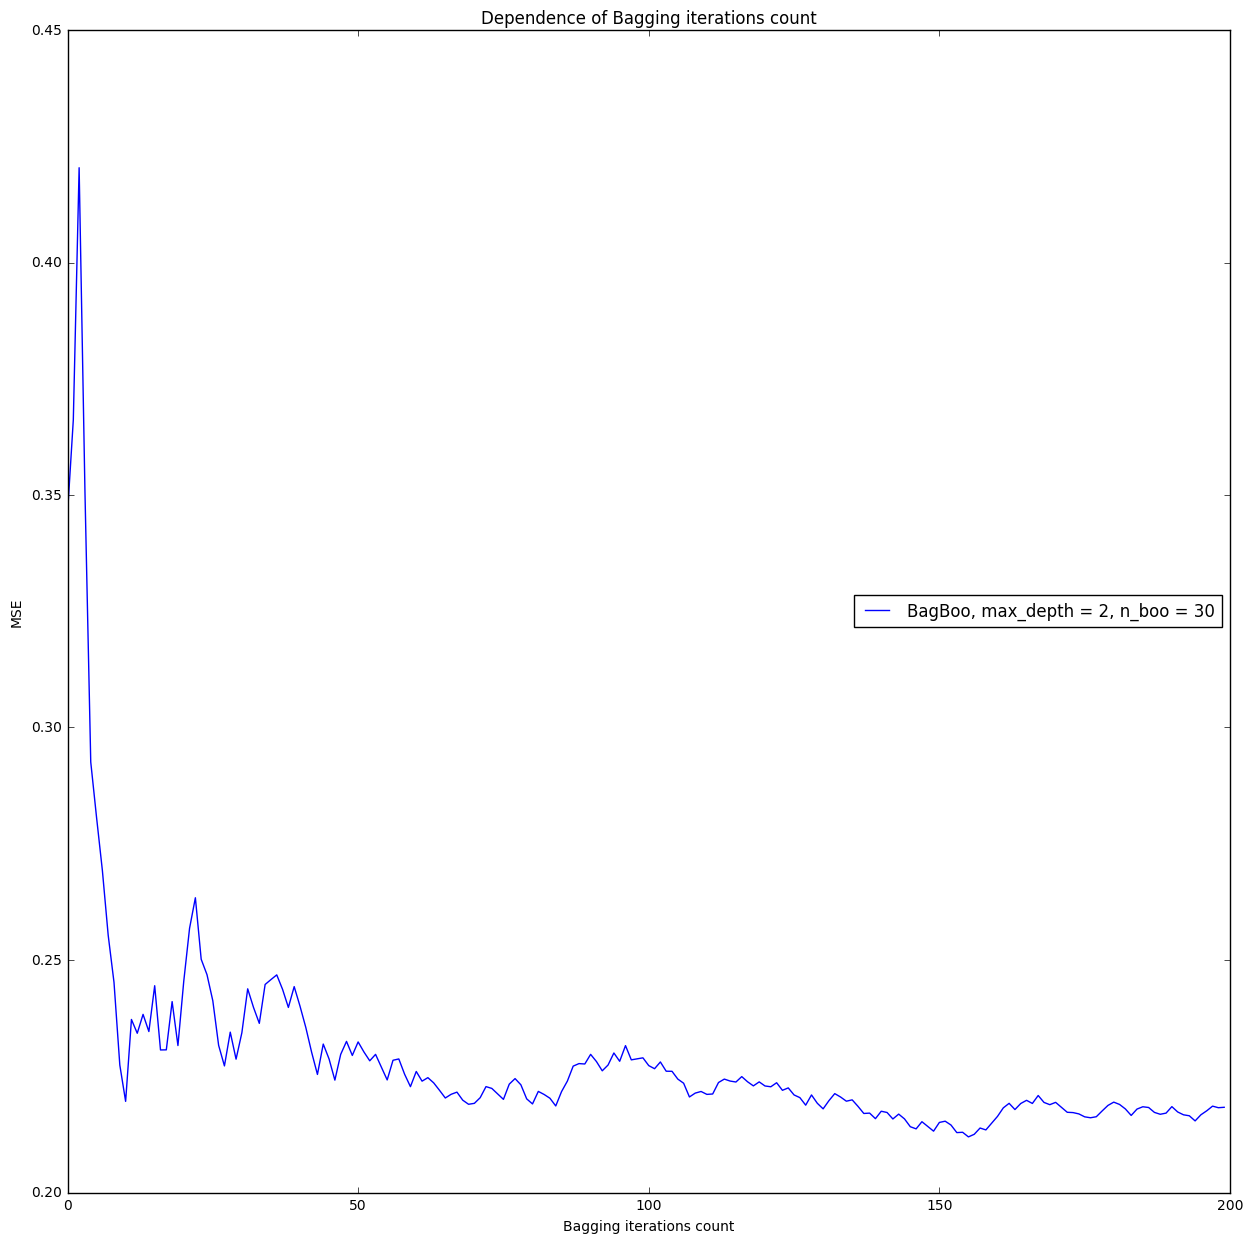

In [9]:
fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(range(0, 200), error_statistic_2, label='BagBoo, max_depth = 2, n_boo = 30')
ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Bagging iterations count')
ax.set_ylabel('MSE')

In [15]:
%%time
bagboo_spam = BagBoo(n_boo=10, n_bag=300, bagging_ratio=0.02, rsm_ratio=0.8, max_depth = 5, shrinkage=0.5)    
error_statistic_3 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target) 

features in RSM:  81
samples in bagging:  141


Iteration of bagging:1/300

Iteration of Bagging: 0 / 300
fitting_samples:  0.0198787537008
MSE on test Dataset: 0.476431980907 Iteration of Bagging: 0 / 300
MSE on train Dataset: 0.477654025095 Iteration of Bagging: 0 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.81442824861e-06

Iteration of Bagging: 1 / 300
fitting_samples:  0.0394755392641
MSE on test Dataset: 0.275652856449 Iteration of Bagging: 1 / 300
MSE on train Dataset: 0.358177045645 Iteration of Bagging: 1 / 300


Iteration of bagging:3/300

Iteration of Bagging: 2 / 300
fitting_samples:  0.0587903566897
MSE on test Dataset: 0.3296178447 Iteration of Bagging: 2 / 300
MSE on train Dataset: 0.325525541889 Iteration of Bagging: 2 / 300


Iteration of bagging:4/300

Iteration of Bagging: 3 / 300
fitting_samples:  0.0766953334273
MSE on test Dataset: 0.253521662465 Iteration of Bagging: 3 / 300
MSE on train Dataset: 0.258495755302 Iteration of Bagging: 3 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.39001874858e-06

Iteration of Bagging: 4 / 300
fitting_samples:  0.0951642464402
MSE on test Dataset: 0.228517809731 Iteration of Bagging: 4 / 300
MSE on train Dataset: 0.254150119546 Iteration of Bagging: 4 / 300


Iteration of bagging:6/300

Iteration of Bagging: 5 / 300
fitting_samples:  0.11278725504
MSE on test Dataset: 0.228164175744 Iteration of Bagging: 5 / 300
MSE on train Dataset: 0.258100221826 Iteration of Bagging: 5 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.31109600917e-06

Iteration of Bagging: 6 / 300
fitting_samples:  0.13041026364
MSE on test Dataset: 0.202604587448 Iteration of Bagging: 6 / 300
MSE on train Dataset: 0.257791583336 Iteration of Bagging: 6 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.66036806941e-08

Iteration of Bagging: 7 / 300
fitting_samples:  0.148174256309
MSE on test Dataset: 0.231931335152 Iteration of Bagging: 7 / 300
MSE on train Dataset: 0.230442650824 Iteration of Bagging: 7 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.09069928568e-06

Iteration of Bagging: 8 / 300
fitting_samples:  0.165374312703
MSE on test Dataset: 0.260393777491 Iteration of Bagging: 8 / 300
MSE on train Dataset: 0.235608006452 Iteration of Bagging: 8 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.35272952682e-08

Iteration of Bagging: 9 / 300
fitting_samples:  0.181446496546
MSE on test Dataset: 0.264002320576 Iteration of Bagging: 9 / 300
MSE on train Dataset: 0.246008293454 Iteration of Bagging: 9 / 300


Iteration of bagging:11/300

Iteration of Bagging: 10 / 300
fitting_samples:  0.197659664458
MSE on test Dataset: 0.264376507432 Iteration of Bagging: 10 / 300
MSE on train Dataset: 0.241208470329 Iteration of Bagging: 10 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.91920130548e-06

Iteration of Bagging: 11 / 300
fitting_samples:  0.21274495982
MSE on test Dataset: 0.250027265006 Iteration of Bagging: 11 / 300
MSE on train Dataset: 0.237989846295 Iteration of Bagging: 11 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.36090003855e-05

Iteration of Bagging: 12 / 300
fitting_samples:  0.229240095869
MSE on test Dataset: 0.24533194496 Iteration of Bagging: 12 / 300
MSE on train Dataset: 0.229635557548 Iteration of Bagging: 12 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.63792980623e-08

Iteration of Bagging: 13 / 300
fitting_samples:  0.245030311575
MSE on test Dataset: 0.244235673027 Iteration of Bagging: 13 / 300
MSE on train Dataset: 0.234557666292 Iteration of Bagging: 13 / 300


Iteration of bagging:15/300

Iteration of Bagging: 14 / 300
fitting_samples:  0.260115606936
MSE on test Dataset: 0.229325541522 Iteration of Bagging: 14 / 300
MSE on train Dataset: 0.233195455476 Iteration of Bagging: 14 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.79214531754e-06

Iteration of Bagging: 15 / 300
fitting_samples:  0.274354997885
MSE on test Dataset: 0.219862444635 Iteration of Bagging: 15 / 300
MSE on train Dataset: 0.229308245458 Iteration of Bagging: 15 / 300


Iteration of bagging:17/300

Iteration of Bagging: 16 / 300
fitting_samples:  0.290004229522
MSE on test Dataset: 0.211482717114 Iteration of Bagging: 16 / 300
MSE on train Dataset: 0.222299773047 Iteration of Bagging: 16 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000133787355818

Iteration of Bagging: 17 / 300
fitting_samples:  0.304948540815
MSE on test Dataset: 0.204190089336 Iteration of Bagging: 17 / 300
MSE on train Dataset: 0.224934261513 Iteration of Bagging: 17 / 300


Iteration of bagging:19/300

Iteration of Bagging: 18 / 300
fitting_samples:  0.318201043282
MSE on test Dataset: 0.197510271231 Iteration of Bagging: 18 / 300
MSE on train Dataset: 0.223246185108 Iteration of Bagging: 18 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.99151447546e-06

Iteration of Bagging: 19 / 300
fitting_samples:  0.331594529818
MSE on test Dataset: 0.202065976072 Iteration of Bagging: 19 / 300
MSE on train Dataset: 0.225580759378 Iteration of Bagging: 19 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.36922560343e-06

Iteration of Bagging: 20 / 300
fitting_samples:  0.344706048217
MSE on test Dataset: 0.199287518265 Iteration of Bagging: 20 / 300
MSE on train Dataset: 0.219970215321 Iteration of Bagging: 20 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.04188672441e-06

Iteration of Bagging: 21 / 300
fitting_samples:  0.357676582546
MSE on test Dataset: 0.193411551511 Iteration of Bagging: 21 / 300
MSE on train Dataset: 0.217218615508 Iteration of Bagging: 21 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.63460602592e-05

Iteration of Bagging: 22 / 300
fitting_samples:  0.370506132807
MSE on test Dataset: 0.201376768062 Iteration of Bagging: 22 / 300
MSE on train Dataset: 0.216167443074 Iteration of Bagging: 22 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.32912248032e-06

Iteration of Bagging: 23 / 300
fitting_samples:  0.382207810517
MSE on test Dataset: 0.196796089 Iteration of Bagging: 23 / 300
MSE on train Dataset: 0.218802248084 Iteration of Bagging: 23 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.58443593562e-05

Iteration of Bagging: 24 / 300
fitting_samples:  0.394755392641
MSE on test Dataset: 0.206121093787 Iteration of Bagging: 24 / 300
MSE on train Dataset: 0.218986010028 Iteration of Bagging: 24 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.91589460319e-05

Iteration of Bagging: 25 / 300
fitting_samples:  0.407021006626
MSE on test Dataset: 0.209724166961 Iteration of Bagging: 25 / 300
MSE on train Dataset: 0.2178812974 Iteration of Bagging: 25 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.07703188216e-07

Iteration of Bagging: 26 / 300
fitting_samples:  0.418863668405
MSE on test Dataset: 0.213035624839 Iteration of Bagging: 26 / 300
MSE on train Dataset: 0.216576389029 Iteration of Bagging: 26 / 300


Iteration of bagging:28/300

Iteration of Bagging: 27 / 300
fitting_samples:  0.430142393909
MSE on test Dataset: 0.206334002601 Iteration of Bagging: 27 / 300
MSE on train Dataset: 0.217228413998 Iteration of Bagging: 27 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.85200612531e-06

Iteration of Bagging: 28 / 300
fitting_samples:  0.441562103482
MSE on test Dataset: 0.210494791059 Iteration of Bagging: 28 / 300
MSE on train Dataset: 0.219640086336 Iteration of Bagging: 28 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.59239728689e-06

Iteration of Bagging: 29 / 300
fitting_samples:  0.452135908642
MSE on test Dataset: 0.219507200973 Iteration of Bagging: 29 / 300
MSE on train Dataset: 0.221078624283 Iteration of Bagging: 29 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.02441404778e-06

Iteration of Bagging: 30 / 300
fitting_samples:  0.464542506697
MSE on test Dataset: 0.228602155325 Iteration of Bagging: 30 / 300
MSE on train Dataset: 0.223039162139 Iteration of Bagging: 30 / 300


Iteration of bagging:32/300

Iteration of Bagging: 31 / 300
fitting_samples:  0.473847455238
MSE on test Dataset: 0.223530660642 Iteration of Bagging: 31 / 300
MSE on train Dataset: 0.219353956054 Iteration of Bagging: 31 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.67262291617e-06

Iteration of Bagging: 32 / 300
fitting_samples:  0.483998308191
MSE on test Dataset: 0.22343105693 Iteration of Bagging: 32 / 300
MSE on train Dataset: 0.223586475777 Iteration of Bagging: 32 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.82872534918e-07

Iteration of Bagging: 33 / 300
fitting_samples:  0.493726208938
MSE on test Dataset: 0.221623369914 Iteration of Bagging: 33 / 300
MSE on train Dataset: 0.222669558555 Iteration of Bagging: 33 / 300


Iteration of bagging:35/300

Iteration of Bagging: 34 / 300
fitting_samples:  0.504440998167
MSE on test Dataset: 0.226660469392 Iteration of Bagging: 34 / 300
MSE on train Dataset: 0.222110582988 Iteration of Bagging: 34 / 300


Iteration of bagging:36/300

Iteration of Bagging: 35 / 300
fitting_samples:  0.514168898914
MSE on test Dataset: 0.234968390809 Iteration of Bagging: 35 / 300
MSE on train Dataset: 0.224182535993 Iteration of Bagging: 35 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000163589411734

Iteration of Bagging: 36 / 300
fitting_samples:  0.52290991118
MSE on test Dataset: 0.232471043375 Iteration of Bagging: 36 / 300
MSE on train Dataset: 0.224598135968 Iteration of Bagging: 36 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.48258949222e-05

Iteration of Bagging: 37 / 300
fitting_samples:  0.531650923446
MSE on test Dataset: 0.226982122085 Iteration of Bagging: 37 / 300
MSE on train Dataset: 0.224084703651 Iteration of Bagging: 37 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.15260974353e-06

Iteration of Bagging: 38 / 300
fitting_samples:  0.539968983505
MSE on test Dataset: 0.221479872642 Iteration of Bagging: 38 / 300
MSE on train Dataset: 0.223226849155 Iteration of Bagging: 38 / 300


Iteration of bagging:40/300

Iteration of Bagging: 39 / 300
fitting_samples:  0.548850979839
MSE on test Dataset: 0.22590213325 Iteration of Bagging: 39 / 300
MSE on train Dataset: 0.225567052502 Iteration of Bagging: 39 / 300


Iteration of bagging:41/300

Iteration of Bagging: 40 / 300
fitting_samples:  0.55815592838
MSE on test Dataset: 0.218735311653 Iteration of Bagging: 40 / 300
MSE on train Dataset: 0.222994412691 Iteration of Bagging: 40 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.60727873818e-08

Iteration of Bagging: 41 / 300
fitting_samples:  0.566192020302
MSE on test Dataset: 0.223939929599 Iteration of Bagging: 41 / 300
MSE on train Dataset: 0.224357024792 Iteration of Bagging: 41 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.26289651741e-06

Iteration of Bagging: 42 / 300
fitting_samples:  0.575496968843
MSE on test Dataset: 0.225508088758 Iteration of Bagging: 42 / 300
MSE on train Dataset: 0.223710991371 Iteration of Bagging: 42 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000126669480847

Iteration of Bagging: 43 / 300
fitting_samples:  0.583815028902
MSE on test Dataset: 0.225638932637 Iteration of Bagging: 43 / 300
MSE on train Dataset: 0.223746369961 Iteration of Bagging: 43 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.30381898479e-05

Iteration of Bagging: 44 / 300
fitting_samples:  0.59227407303
MSE on test Dataset: 0.224927254915 Iteration of Bagging: 44 / 300
MSE on train Dataset: 0.223634146063 Iteration of Bagging: 44 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.5218787412e-06

Iteration of Bagging: 45 / 300
fitting_samples:  0.60045114902
MSE on test Dataset: 0.224658925335 Iteration of Bagging: 45 / 300
MSE on train Dataset: 0.222593375327 Iteration of Bagging: 45 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.28252364637e-06

Iteration of Bagging: 46 / 300
fitting_samples:  0.609333145355
MSE on test Dataset: 0.227255721345 Iteration of Bagging: 46 / 300
MSE on train Dataset: 0.225162628503 Iteration of Bagging: 46 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.136361112e-06

Iteration of Bagging: 47 / 300
fitting_samples:  0.616805301001
MSE on test Dataset: 0.222385055132 Iteration of Bagging: 47 / 300
MSE on train Dataset: 0.224984582367 Iteration of Bagging: 47 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.81554379181e-05

Iteration of Bagging: 48 / 300
fitting_samples:  0.623572536303
MSE on test Dataset: 0.219346573332 Iteration of Bagging: 48 / 300
MSE on train Dataset: 0.223375666518 Iteration of Bagging: 48 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.60231817806e-06

Iteration of Bagging: 49 / 300
fitting_samples:  0.630903707881
MSE on test Dataset: 0.219604175178 Iteration of Bagging: 49 / 300
MSE on train Dataset: 0.219258247594 Iteration of Bagging: 49 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.31436486111e-05

Iteration of Bagging: 50 / 300
fitting_samples:  0.638375863527
MSE on test Dataset: 0.219976977541 Iteration of Bagging: 50 / 300
MSE on train Dataset: 0.221334688189 Iteration of Bagging: 50 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.60949820688e-06

Iteration of Bagging: 51 / 300
fitting_samples:  0.645284082899
MSE on test Dataset: 0.221340521507 Iteration of Bagging: 51 / 300
MSE on train Dataset: 0.221742459623 Iteration of Bagging: 51 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.17356594755e-05

Iteration of Bagging: 52 / 300
fitting_samples:  0.651628365995
MSE on test Dataset: 0.219591390786 Iteration of Bagging: 52 / 300
MSE on train Dataset: 0.221127887642 Iteration of Bagging: 52 / 300


Iteration of bagging:54/300

Iteration of Bagging: 53 / 300
fitting_samples:  0.657408712815
MSE on test Dataset: 0.222863287721 Iteration of Bagging: 53 / 300
MSE on train Dataset: 0.220679325261 Iteration of Bagging: 53 / 300


Iteration of bagging:55/300

Iteration of Bagging: 54 / 300
fitting_samples:  0.665021852531
MSE on test Dataset: 0.225365679204 Iteration of Bagging: 54 / 300
MSE on train Dataset: 0.222591416935 Iteration of Bagging: 54 / 300


Learning estimator number: 9/10; MSE error on train dataset: 9.53512772924e-05

Iteration of Bagging: 55 / 300
fitting_samples:  0.672071055971
MSE on test Dataset: 0.230488036702 Iteration of Bagging: 55 / 300
MSE on train Dataset: 0.224883195487 Iteration of Bagging: 55 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.4592619309e-07

Iteration of Bagging: 56 / 300
fitting_samples:  0.678274354998
MSE on test Dataset: 0.23213775158 Iteration of Bagging: 56 / 300
MSE on train Dataset: 0.228865899498 Iteration of Bagging: 56 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.97011887849e-07

Iteration of Bagging: 57 / 300
fitting_samples:  0.684477654025
MSE on test Dataset: 0.228474566044 Iteration of Bagging: 57 / 300
MSE on train Dataset: 0.227792406968 Iteration of Bagging: 57 / 300


Learning estimator number: 9/10; MSE error on train dataset: 9.57770156818e-05

Iteration of Bagging: 58 / 300
fitting_samples:  0.689694064571
MSE on test Dataset: 0.230773629667 Iteration of Bagging: 58 / 300
MSE on train Dataset: 0.228596270625 Iteration of Bagging: 58 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.06467333537e-05

Iteration of Bagging: 59 / 300
fitting_samples:  0.696179331736
MSE on test Dataset: 0.235441782996 Iteration of Bagging: 59 / 300
MSE on train Dataset: 0.229705692066 Iteration of Bagging: 59 / 300


Iteration of bagging:61/300

Iteration of Bagging: 60 / 300
fitting_samples:  0.703792471451
MSE on test Dataset: 0.233678214451 Iteration of Bagging: 60 / 300
MSE on train Dataset: 0.228314011703 Iteration of Bagging: 60 / 300


Iteration of bagging:62/300

Iteration of Bagging: 61 / 300
fitting_samples:  0.709008881996
MSE on test Dataset: 0.229713029147 Iteration of Bagging: 61 / 300
MSE on train Dataset: 0.227595518552 Iteration of Bagging: 61 / 300


Iteration of bagging:63/300

Iteration of Bagging: 62 / 300
fitting_samples:  0.716481037643
MSE on test Dataset: 0.233594580159 Iteration of Bagging: 62 / 300
MSE on train Dataset: 0.229315893939 Iteration of Bagging: 62 / 300


Iteration of bagging:64/300

Iteration of Bagging: 63 / 300
fitting_samples:  0.721979416326
MSE on test Dataset: 0.229594334683 Iteration of Bagging: 63 / 300
MSE on train Dataset: 0.227836154699 Iteration of Bagging: 63 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.9388125485e-05

Iteration of Bagging: 64 / 300
fitting_samples:  0.726067954321
MSE on test Dataset: 0.228817593633 Iteration of Bagging: 64 / 300
MSE on train Dataset: 0.228913544365 Iteration of Bagging: 64 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.20359156513e-06

Iteration of Bagging: 65 / 300
fitting_samples:  0.732694205555
MSE on test Dataset: 0.22871570563 Iteration of Bagging: 65 / 300
MSE on train Dataset: 0.227647660142 Iteration of Bagging: 65 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.42351960904e-06

Iteration of Bagging: 66 / 300
fitting_samples:  0.739884393064
MSE on test Dataset: 0.225589641867 Iteration of Bagging: 66 / 300
MSE on train Dataset: 0.22580339725 Iteration of Bagging: 66 / 300


Learning estimator number: 9/10; MSE error on train dataset: 9.16609948748e-08

Iteration of Bagging: 67 / 300
fitting_samples:  0.743690962921
MSE on test Dataset: 0.229788137353 Iteration of Bagging: 67 / 300
MSE on train Dataset: 0.226671324774 Iteration of Bagging: 67 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.10349427263e-05

Iteration of Bagging: 68 / 300
fitting_samples:  0.749048357536
MSE on test Dataset: 0.230021120463 Iteration of Bagging: 68 / 300
MSE on train Dataset: 0.228419433321 Iteration of Bagging: 68 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.44081795305e-06

Iteration of Bagging: 69 / 300
fitting_samples:  0.753559847737
MSE on test Dataset: 0.233192472928 Iteration of Bagging: 69 / 300
MSE on train Dataset: 0.228101022561 Iteration of Bagging: 69 / 300


Iteration of bagging:71/300

Iteration of Bagging: 70 / 300
fitting_samples:  0.758353306076
MSE on test Dataset: 0.233879776431 Iteration of Bagging: 70 / 300
MSE on train Dataset: 0.22794353398 Iteration of Bagging: 70 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.63328171486e-05

Iteration of Bagging: 71 / 300
fitting_samples:  0.763005780347
MSE on test Dataset: 0.231824696831 Iteration of Bagging: 71 / 300
MSE on train Dataset: 0.227776128277 Iteration of Bagging: 71 / 300


Iteration of bagging:73/300

Iteration of Bagging: 72 / 300
fitting_samples:  0.768645143099
MSE on test Dataset: 0.233829381276 Iteration of Bagging: 72 / 300
MSE on train Dataset: 0.230541667215 Iteration of Bagging: 72 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.92686778319e-05

Iteration of Bagging: 73 / 300
fitting_samples:  0.773297617369
MSE on test Dataset: 0.23375228127 Iteration of Bagging: 73 / 300
MSE on train Dataset: 0.229391177736 Iteration of Bagging: 73 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000200578929503

Iteration of Bagging: 74 / 300
fitting_samples:  0.778655011984
MSE on test Dataset: 0.23605060993 Iteration of Bagging: 74 / 300
MSE on train Dataset: 0.230053148698 Iteration of Bagging: 74 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.04495590709e-05

Iteration of Bagging: 75 / 300
fitting_samples:  0.783448470323
MSE on test Dataset: 0.237257719079 Iteration of Bagging: 75 / 300
MSE on train Dataset: 0.230814707771 Iteration of Bagging: 75 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.61074732436e-07

Iteration of Bagging: 76 / 300
fitting_samples:  0.786550119836
MSE on test Dataset: 0.239572712845 Iteration of Bagging: 76 / 300
MSE on train Dataset: 0.231321895143 Iteration of Bagging: 76 / 300


Iteration of bagging:78/300

Iteration of Bagging: 77 / 300
fitting_samples:  0.790074721556
MSE on test Dataset: 0.243109936056 Iteration of Bagging: 77 / 300
MSE on train Dataset: 0.232810897228 Iteration of Bagging: 77 / 300


Iteration of bagging:79/300

Iteration of Bagging: 78 / 300
fitting_samples:  0.794445227689
MSE on test Dataset: 0.240033921121 Iteration of Bagging: 78 / 300
MSE on train Dataset: 0.233707943515 Iteration of Bagging: 78 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.28008321608e-05

Iteration of Bagging: 79 / 300
fitting_samples:  0.799661638235
MSE on test Dataset: 0.239810369093 Iteration of Bagging: 79 / 300
MSE on train Dataset: 0.232445487879 Iteration of Bagging: 79 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.47685178742e-06

Iteration of Bagging: 80 / 300
fitting_samples:  0.80487804878
MSE on test Dataset: 0.243064031405 Iteration of Bagging: 80 / 300
MSE on train Dataset: 0.2332603596 Iteration of Bagging: 80 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.51830388822e-08

Iteration of Bagging: 81 / 300
fitting_samples:  0.808543634569
MSE on test Dataset: 0.241814937741 Iteration of Bagging: 81 / 300
MSE on train Dataset: 0.232588354753 Iteration of Bagging: 81 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000117548609408

Iteration of Bagging: 82 / 300
fitting_samples:  0.812209220358
MSE on test Dataset: 0.244812942629 Iteration of Bagging: 82 / 300
MSE on train Dataset: 0.234069511812 Iteration of Bagging: 82 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.24655086436e-08

Iteration of Bagging: 83 / 300
fitting_samples:  0.817284646835
MSE on test Dataset: 0.244218192359 Iteration of Bagging: 83 / 300
MSE on train Dataset: 0.233949671113 Iteration of Bagging: 83 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.51232054454e-05

Iteration of Bagging: 84 / 300
fitting_samples:  0.822219089243
MSE on test Dataset: 0.250268059575 Iteration of Bagging: 84 / 300
MSE on train Dataset: 0.236728839874 Iteration of Bagging: 84 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000118828410131

Iteration of Bagging: 85 / 300
fitting_samples:  0.824333850275
MSE on test Dataset: 0.249687835857 Iteration of Bagging: 85 / 300
MSE on train Dataset: 0.236742248587 Iteration of Bagging: 85 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.80363936909e-08

Iteration of Bagging: 86 / 300
fitting_samples:  0.826871563513
MSE on test Dataset: 0.247558014802 Iteration of Bagging: 86 / 300
MSE on train Dataset: 0.235854008601 Iteration of Bagging: 86 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.90674450818e-05

Iteration of Bagging: 87 / 300
fitting_samples:  0.831242069646
MSE on test Dataset: 0.247515199312 Iteration of Bagging: 87 / 300
MSE on train Dataset: 0.234443149761 Iteration of Bagging: 87 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.12918672414e-05

Iteration of Bagging: 88 / 300
fitting_samples:  0.833920766953
MSE on test Dataset: 0.251157643492 Iteration of Bagging: 88 / 300
MSE on train Dataset: 0.235940389394 Iteration of Bagging: 88 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.64067106423e-08

Iteration of Bagging: 89 / 300
fitting_samples:  0.837727336811
MSE on test Dataset: 0.249146604896 Iteration of Bagging: 89 / 300
MSE on train Dataset: 0.234787094278 Iteration of Bagging: 89 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.77381525931e-06

Iteration of Bagging: 90 / 300
fitting_samples:  0.839842097843
MSE on test Dataset: 0.246804628104 Iteration of Bagging: 90 / 300
MSE on train Dataset: 0.233770316802 Iteration of Bagging: 90 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.74841365046e-08

Iteration of Bagging: 91 / 300
fitting_samples:  0.843930635838
MSE on test Dataset: 0.247059880447 Iteration of Bagging: 91 / 300
MSE on train Dataset: 0.233282506459 Iteration of Bagging: 91 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.58317052257e-06

Iteration of Bagging: 92 / 300
fitting_samples:  0.847173269421
MSE on test Dataset: 0.245091657404 Iteration of Bagging: 92 / 300
MSE on train Dataset: 0.23276854508 Iteration of Bagging: 92 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.06086237211e-08

Iteration of Bagging: 93 / 300
fitting_samples:  0.849429014521
MSE on test Dataset: 0.242403662332 Iteration of Bagging: 93 / 300
MSE on train Dataset: 0.232230845662 Iteration of Bagging: 93 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.01516160759e-06

Iteration of Bagging: 94 / 300
fitting_samples:  0.851825743691
MSE on test Dataset: 0.23992309519 Iteration of Bagging: 94 / 300
MSE on train Dataset: 0.233478191487 Iteration of Bagging: 94 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.25599022415e-05

Iteration of Bagging: 95 / 300
fitting_samples:  0.853940504723
MSE on test Dataset: 0.242739317747 Iteration of Bagging: 95 / 300
MSE on train Dataset: 0.235768573996 Iteration of Bagging: 95 / 300


Iteration of bagging:97/300

Iteration of Bagging: 96 / 300
fitting_samples:  0.856901170168
MSE on test Dataset: 0.240606490164 Iteration of Bagging: 96 / 300
MSE on train Dataset: 0.234806997507 Iteration of Bagging: 96 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.12379530261e-07

Iteration of Bagging: 97 / 300
fitting_samples:  0.859720851544
MSE on test Dataset: 0.241799016957 Iteration of Bagging: 97 / 300
MSE on train Dataset: 0.234078544684 Iteration of Bagging: 97 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.68193908534e-06

Iteration of Bagging: 98 / 300
fitting_samples:  0.863527421401
MSE on test Dataset: 0.242866234422 Iteration of Bagging: 98 / 300
MSE on train Dataset: 0.234251569398 Iteration of Bagging: 98 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.01262645341e-05

Iteration of Bagging: 99 / 300
fitting_samples:  0.866206118709
MSE on test Dataset: 0.241326389934 Iteration of Bagging: 99 / 300
MSE on train Dataset: 0.233878297763 Iteration of Bagging: 99 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.39636464488e-05

Iteration of Bagging: 100 / 300
fitting_samples:  0.86958973636
MSE on test Dataset: 0.23890416931 Iteration of Bagging: 100 / 300
MSE on train Dataset: 0.232961023058 Iteration of Bagging: 100 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.75129356001e-06

Iteration of Bagging: 101 / 300
fitting_samples:  0.870999577048
MSE on test Dataset: 0.24087833501 Iteration of Bagging: 101 / 300
MSE on train Dataset: 0.233657156524 Iteration of Bagging: 101 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.98958077894e-06

Iteration of Bagging: 102 / 300
fitting_samples:  0.873819258424
MSE on test Dataset: 0.240966762829 Iteration of Bagging: 102 / 300
MSE on train Dataset: 0.23337226629 Iteration of Bagging: 102 / 300


Learning estimator number: 9/10; MSE error on train dataset: 9.71580237868e-06

Iteration of Bagging: 103 / 300
fitting_samples:  0.876779923869
MSE on test Dataset: 0.238234795588 Iteration of Bagging: 103 / 300
MSE on train Dataset: 0.232632805332 Iteration of Bagging: 103 / 300


Iteration of bagging:105/300

Iteration of Bagging: 104 / 300
fitting_samples:  0.879458621176
MSE on test Dataset: 0.241281978422 Iteration of Bagging: 104 / 300
MSE on train Dataset: 0.233816137429 Iteration of Bagging: 104 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.05985483357e-05

Iteration of Bagging: 105 / 300
fitting_samples:  0.881432398139
MSE on test Dataset: 0.244047485119 Iteration of Bagging: 105 / 300
MSE on train Dataset: 0.233124745016 Iteration of Bagging: 105 / 300


Iteration of bagging:107/300

Iteration of Bagging: 106 / 300
fitting_samples:  0.883970111377
MSE on test Dataset: 0.244398315649 Iteration of Bagging: 106 / 300
MSE on train Dataset: 0.232505547486 Iteration of Bagging: 106 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.54273809795e-05

Iteration of Bagging: 107 / 300
fitting_samples:  0.88481601579
MSE on test Dataset: 0.242474352664 Iteration of Bagging: 107 / 300
MSE on train Dataset: 0.231919850888 Iteration of Bagging: 107 / 300


Iteration of bagging:109/300

Iteration of Bagging: 108 / 300
fitting_samples:  0.887494713097
MSE on test Dataset: 0.240378557235 Iteration of Bagging: 108 / 300
MSE on train Dataset: 0.230804013878 Iteration of Bagging: 108 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.98345227779e-05

Iteration of Bagging: 109 / 300
fitting_samples:  0.889186521923
MSE on test Dataset: 0.242276777165 Iteration of Bagging: 109 / 300
MSE on train Dataset: 0.231501077506 Iteration of Bagging: 109 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.52227713611e-05

Iteration of Bagging: 110 / 300
fitting_samples:  0.891301282955
MSE on test Dataset: 0.241090067753 Iteration of Bagging: 110 / 300
MSE on train Dataset: 0.229656548326 Iteration of Bagging: 110 / 300


Learning estimator number: 9/10; MSE error on train dataset: 9.44259822667e-06

Iteration of Bagging: 111 / 300
fitting_samples:  0.893134075849
MSE on test Dataset: 0.243421959598 Iteration of Bagging: 111 / 300
MSE on train Dataset: 0.230486438922 Iteration of Bagging: 111 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.69582940863e-06

Iteration of Bagging: 112 / 300
fitting_samples:  0.893838996193
MSE on test Dataset: 0.241031593936 Iteration of Bagging: 112 / 300
MSE on train Dataset: 0.230409087837 Iteration of Bagging: 112 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.70545905363e-08

Iteration of Bagging: 113 / 300
fitting_samples:  0.896658677569
MSE on test Dataset: 0.238921973031 Iteration of Bagging: 113 / 300
MSE on train Dataset: 0.23020032271 Iteration of Bagging: 113 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.58280758264e-05

Iteration of Bagging: 114 / 300
fitting_samples:  0.899478358945
MSE on test Dataset: 0.237789946086 Iteration of Bagging: 114 / 300
MSE on train Dataset: 0.230608641081 Iteration of Bagging: 114 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.16457891716e-07

Iteration of Bagging: 115 / 300
fitting_samples:  0.901734104046
MSE on test Dataset: 0.235262310054 Iteration of Bagging: 115 / 300
MSE on train Dataset: 0.230049132949 Iteration of Bagging: 115 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.17461616156e-06

Iteration of Bagging: 116 / 300
fitting_samples:  0.903143944734
MSE on test Dataset: 0.232674825117 Iteration of Bagging: 116 / 300
MSE on train Dataset: 0.229132185726 Iteration of Bagging: 116 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.99592854078e-05

Iteration of Bagging: 117 / 300
fitting_samples:  0.904976737629
MSE on test Dataset: 0.232368684209 Iteration of Bagging: 117 / 300
MSE on train Dataset: 0.230352131383 Iteration of Bagging: 117 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.08173461746e-07

Iteration of Bagging: 118 / 300
fitting_samples:  0.906809530523
MSE on test Dataset: 0.233992868394 Iteration of Bagging: 118 / 300
MSE on train Dataset: 0.232258284942 Iteration of Bagging: 118 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.47697862422e-06

Iteration of Bagging: 119 / 300
fitting_samples:  0.909206259693
MSE on test Dataset: 0.234187302041 Iteration of Bagging: 119 / 300
MSE on train Dataset: 0.233020259883 Iteration of Bagging: 119 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.58768788707e-06

Iteration of Bagging: 120 / 300
fitting_samples:  0.911743972931
MSE on test Dataset: 0.2337616058 Iteration of Bagging: 120 / 300
MSE on train Dataset: 0.232794989588 Iteration of Bagging: 120 / 300


Iteration of bagging:122/300

Iteration of Bagging: 121 / 300
fitting_samples:  0.914704638376
MSE on test Dataset: 0.235450675766 Iteration of Bagging: 121 / 300
MSE on train Dataset: 0.232691234887 Iteration of Bagging: 121 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.69962954833e-06

Iteration of Bagging: 122 / 300
fitting_samples:  0.916255463133
MSE on test Dataset: 0.235374101973 Iteration of Bagging: 122 / 300
MSE on train Dataset: 0.232702709659 Iteration of Bagging: 122 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.33294461086e-07

Iteration of Bagging: 123 / 300
fitting_samples:  0.918229240096
MSE on test Dataset: 0.234732360485 Iteration of Bagging: 123 / 300
MSE on train Dataset: 0.232140730731 Iteration of Bagging: 123 / 300


Iteration of bagging:125/300

Iteration of Bagging: 124 / 300
fitting_samples:  0.920344001128
MSE on test Dataset: 0.236984865288 Iteration of Bagging: 124 / 300
MSE on train Dataset: 0.232996482427 Iteration of Bagging: 124 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.68076848833e-06

Iteration of Bagging: 125 / 300
fitting_samples:  0.921330889609
MSE on test Dataset: 0.237721644049 Iteration of Bagging: 125 / 300
MSE on train Dataset: 0.23290365903 Iteration of Bagging: 125 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.35272952682e-08

Iteration of Bagging: 126 / 300
fitting_samples:  0.923022698435
MSE on test Dataset: 0.235388226891 Iteration of Bagging: 126 / 300
MSE on train Dataset: 0.232226799024 Iteration of Bagging: 126 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.03726604927e-05

Iteration of Bagging: 127 / 300
fitting_samples:  0.925419427605
MSE on test Dataset: 0.236380000828 Iteration of Bagging: 127 / 300
MSE on train Dataset: 0.232609536948 Iteration of Bagging: 127 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.57027279321e-07

Iteration of Bagging: 128 / 300
fitting_samples:  0.927957140843
MSE on test Dataset: 0.235159774562 Iteration of Bagging: 128 / 300
MSE on train Dataset: 0.232325427682 Iteration of Bagging: 128 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.15714719383e-07

Iteration of Bagging: 129 / 300
fitting_samples:  0.9295079656
MSE on test Dataset: 0.233827494382 Iteration of Bagging: 129 / 300
MSE on train Dataset: 0.232248706202 Iteration of Bagging: 129 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.80363936909e-08

Iteration of Bagging: 130 / 300
fitting_samples:  0.930776822219
MSE on test Dataset: 0.235766325332 Iteration of Bagging: 130 / 300
MSE on train Dataset: 0.233960397312 Iteration of Bagging: 130 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.13775124596e-05

Iteration of Bagging: 131 / 300
fitting_samples:  0.932468631045
MSE on test Dataset: 0.237445765193 Iteration of Bagging: 131 / 300
MSE on train Dataset: 0.235149023128 Iteration of Bagging: 131 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.63848263667e-05

Iteration of Bagging: 132 / 300
fitting_samples:  0.933737487664
MSE on test Dataset: 0.235042946064 Iteration of Bagging: 132 / 300
MSE on train Dataset: 0.233897670543 Iteration of Bagging: 132 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.23385261374e-07

Iteration of Bagging: 133 / 300
fitting_samples:  0.935288312421
MSE on test Dataset: 0.237103243454 Iteration of Bagging: 133 / 300
MSE on train Dataset: 0.234558510085 Iteration of Bagging: 133 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.5184962243e-06

Iteration of Bagging: 134 / 300
fitting_samples:  0.937121105315
MSE on test Dataset: 0.237293566692 Iteration of Bagging: 134 / 300
MSE on train Dataset: 0.234589920967 Iteration of Bagging: 134 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.54005759421e-05

Iteration of Bagging: 135 / 300
fitting_samples:  0.938107993797
MSE on test Dataset: 0.237436326311 Iteration of Bagging: 135 / 300
MSE on train Dataset: 0.234471687994 Iteration of Bagging: 135 / 300


Iteration of bagging:137/300

Iteration of Bagging: 136 / 300
fitting_samples:  0.93895389821
MSE on test Dataset: 0.238731347383 Iteration of Bagging: 136 / 300
MSE on train Dataset: 0.234579789125 Iteration of Bagging: 136 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.35272952682e-08

Iteration of Bagging: 137 / 300
fitting_samples:  0.940222754829
MSE on test Dataset: 0.238098497357 Iteration of Bagging: 137 / 300
MSE on train Dataset: 0.234878662816 Iteration of Bagging: 137 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.07825718492e-06

Iteration of Bagging: 138 / 300
fitting_samples:  0.94120964331
MSE on test Dataset: 0.23670494438 Iteration of Bagging: 138 / 300
MSE on train Dataset: 0.233639955064 Iteration of Bagging: 138 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.00928617734e-06

Iteration of Bagging: 139 / 300
fitting_samples:  0.942196531792
MSE on test Dataset: 0.236861606034 Iteration of Bagging: 139 / 300
MSE on train Dataset: 0.234375925856 Iteration of Bagging: 139 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.24214024815e-05

Iteration of Bagging: 140 / 300
fitting_samples:  0.943183420274
MSE on test Dataset: 0.23483157037 Iteration of Bagging: 140 / 300
MSE on train Dataset: 0.233901507125 Iteration of Bagging: 140 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.42604175133e-06

Iteration of Bagging: 141 / 300
fitting_samples:  0.944452276893
MSE on test Dataset: 0.233118255371 Iteration of Bagging: 141 / 300
MSE on train Dataset: 0.23346815659 Iteration of Bagging: 141 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.89555389857e-06

Iteration of Bagging: 142 / 300
fitting_samples:  0.946567037925
MSE on test Dataset: 0.233440424578 Iteration of Bagging: 142 / 300
MSE on train Dataset: 0.233210795732 Iteration of Bagging: 142 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.16220516918e-05

Iteration of Bagging: 143 / 300
fitting_samples:  0.947835894544
MSE on test Dataset: 0.235600293327 Iteration of Bagging: 143 / 300
MSE on train Dataset: 0.233872547858 Iteration of Bagging: 143 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.59176925723e-05

Iteration of Bagging: 144 / 300
fitting_samples:  0.949245735232
MSE on test Dataset: 0.233701441978 Iteration of Bagging: 144 / 300
MSE on train Dataset: 0.234781198994 Iteration of Bagging: 144 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.01200032065e-08

Iteration of Bagging: 145 / 300
fitting_samples:  0.950091639645
MSE on test Dataset: 0.232187428124 Iteration of Bagging: 145 / 300
MSE on train Dataset: 0.234205182947 Iteration of Bagging: 145 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.67337016544e-05

Iteration of Bagging: 146 / 300
fitting_samples:  0.950937544058
MSE on test Dataset: 0.230566027383 Iteration of Bagging: 146 / 300
MSE on train Dataset: 0.233982717707 Iteration of Bagging: 146 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.65142162737e-05

Iteration of Bagging: 147 / 300
fitting_samples:  0.952206400677
MSE on test Dataset: 0.231595903907 Iteration of Bagging: 147 / 300
MSE on train Dataset: 0.233368621756 Iteration of Bagging: 147 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.17683464117e-06

Iteration of Bagging: 148 / 300
fitting_samples:  0.953334273227
MSE on test Dataset: 0.230560154534 Iteration of Bagging: 148 / 300
MSE on train Dataset: 0.233958603017 Iteration of Bagging: 148 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.39355149139e-05

Iteration of Bagging: 149 / 300
fitting_samples:  0.954321161709
MSE on test Dataset: 0.23215804053 Iteration of Bagging: 149 / 300
MSE on train Dataset: 0.234950475662 Iteration of Bagging: 149 / 300


Iteration of bagging:151/300

Iteration of Bagging: 150 / 300
fitting_samples:  0.955026082053
MSE on test Dataset: 0.23427000792 Iteration of Bagging: 150 / 300
MSE on train Dataset: 0.235896040515 Iteration of Bagging: 150 / 300


Iteration of bagging:152/300

Iteration of Bagging: 151 / 300
fitting_samples:  0.955731002397
MSE on test Dataset: 0.233724862045 Iteration of Bagging: 151 / 300
MSE on train Dataset: 0.235454076685 Iteration of Bagging: 151 / 300


Iteration of bagging:153/300

Iteration of Bagging: 152 / 300
fitting_samples:  0.956153954603
MSE on test Dataset: 0.235460114963 Iteration of Bagging: 152 / 300
MSE on train Dataset: 0.236418255169 Iteration of Bagging: 152 / 300


Iteration of bagging:154/300

Iteration of Bagging: 153 / 300
fitting_samples:  0.956435922741
MSE on test Dataset: 0.234354414267 Iteration of Bagging: 153 / 300
MSE on train Dataset: 0.236108347508 Iteration of Bagging: 153 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.19430967171e-05

Iteration of Bagging: 154 / 300
fitting_samples:  0.957422811222
MSE on test Dataset: 0.234247397404 Iteration of Bagging: 154 / 300
MSE on train Dataset: 0.236650178831 Iteration of Bagging: 154 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.37106370154e-06

Iteration of Bagging: 155 / 300
fitting_samples:  0.958127731566
MSE on test Dataset: 0.232890041098 Iteration of Bagging: 155 / 300
MSE on train Dataset: 0.236887309421 Iteration of Bagging: 155 / 300


Iteration of bagging:157/300

Iteration of Bagging: 156 / 300
fitting_samples:  0.958550683773
MSE on test Dataset: 0.233496303575 Iteration of Bagging: 156 / 300
MSE on train Dataset: 0.236997339552 Iteration of Bagging: 156 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.3941391344e-05

Iteration of Bagging: 157 / 300
fitting_samples:  0.959537572254
MSE on test Dataset: 0.233690621322 Iteration of Bagging: 157 / 300
MSE on train Dataset: 0.236933268679 Iteration of Bagging: 157 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.58535557034e-06

Iteration of Bagging: 158 / 300
fitting_samples:  0.960524460736
MSE on test Dataset: 0.235283838426 Iteration of Bagging: 158 / 300
MSE on train Dataset: 0.237674158438 Iteration of Bagging: 158 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.95771923837e-07

Iteration of Bagging: 159 / 300
fitting_samples:  0.96122938108
MSE on test Dataset: 0.235187501908 Iteration of Bagging: 159 / 300
MSE on train Dataset: 0.23769933761 Iteration of Bagging: 159 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.47597968128e-05

Iteration of Bagging: 160 / 300
fitting_samples:  0.962075285493
MSE on test Dataset: 0.23560401048 Iteration of Bagging: 160 / 300
MSE on train Dataset: 0.238030952197 Iteration of Bagging: 160 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.13086840853e-05

Iteration of Bagging: 161 / 300
fitting_samples:  0.962921189906
MSE on test Dataset: 0.236381883021 Iteration of Bagging: 161 / 300
MSE on train Dataset: 0.238636590042 Iteration of Bagging: 161 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.41487481599e-05

Iteration of Bagging: 162 / 300
fitting_samples:  0.963908078387
MSE on test Dataset: 0.237331933668 Iteration of Bagging: 162 / 300
MSE on train Dataset: 0.238998156188 Iteration of Bagging: 162 / 300


Iteration of bagging:164/300

Iteration of Bagging: 163 / 300
fitting_samples:  0.964612998731
MSE on test Dataset: 0.235441621395 Iteration of Bagging: 163 / 300
MSE on train Dataset: 0.23862451385 Iteration of Bagging: 163 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.35272952682e-08

Iteration of Bagging: 164 / 300
fitting_samples:  0.965317919075
MSE on test Dataset: 0.233682465238 Iteration of Bagging: 164 / 300
MSE on train Dataset: 0.238323872042 Iteration of Bagging: 164 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.27980348535e-07

Iteration of Bagging: 165 / 300
fitting_samples:  0.966163823488
MSE on test Dataset: 0.232838981461 Iteration of Bagging: 165 / 300
MSE on train Dataset: 0.238205172137 Iteration of Bagging: 165 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.62091345821e-08

Iteration of Bagging: 166 / 300
fitting_samples:  0.967009727901
MSE on test Dataset: 0.231827234593 Iteration of Bagging: 166 / 300
MSE on train Dataset: 0.237257594209 Iteration of Bagging: 166 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.37256719229e-07

Iteration of Bagging: 167 / 300
fitting_samples:  0.967432680107
MSE on test Dataset: 0.233524562444 Iteration of Bagging: 167 / 300
MSE on train Dataset: 0.237963918225 Iteration of Bagging: 167 / 300


Iteration of bagging:169/300

Iteration of Bagging: 168 / 300
fitting_samples:  0.967855632314
MSE on test Dataset: 0.234703659778 Iteration of Bagging: 168 / 300
MSE on train Dataset: 0.238450994195 Iteration of Bagging: 168 / 300


Iteration of bagging:170/300

Iteration of Bagging: 169 / 300
fitting_samples:  0.968983504864
MSE on test Dataset: 0.234278485386 Iteration of Bagging: 169 / 300
MSE on train Dataset: 0.237602190518 Iteration of Bagging: 169 / 300


Iteration of bagging:171/300

Iteration of Bagging: 170 / 300
fitting_samples:  0.96940645707
MSE on test Dataset: 0.236114848295 Iteration of Bagging: 170 / 300
MSE on train Dataset: 0.23827523957 Iteration of Bagging: 170 / 300


Learning estimator number: 9/10; MSE error on train dataset: 9.28411835993e-06

Iteration of Bagging: 171 / 300
fitting_samples:  0.97067531369
MSE on test Dataset: 0.236253973643 Iteration of Bagging: 171 / 300
MSE on train Dataset: 0.237857043918 Iteration of Bagging: 171 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.83240826544e-07

Iteration of Bagging: 172 / 300
fitting_samples:  0.971380234034
MSE on test Dataset: 0.237296275117 Iteration of Bagging: 172 / 300
MSE on train Dataset: 0.238462335723 Iteration of Bagging: 172 / 300


Iteration of bagging:174/300

Iteration of Bagging: 173 / 300
fitting_samples:  0.972085154378
MSE on test Dataset: 0.237847366372 Iteration of Bagging: 173 / 300
MSE on train Dataset: 0.238451189428 Iteration of Bagging: 173 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.62091345821e-08

Iteration of Bagging: 174 / 300
fitting_samples:  0.972649090653
MSE on test Dataset: 0.239295267851 Iteration of Bagging: 174 / 300
MSE on train Dataset: 0.239197116291 Iteration of Bagging: 174 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.49220623969e-05

Iteration of Bagging: 175 / 300
fitting_samples:  0.97293105879
MSE on test Dataset: 0.237897349198 Iteration of Bagging: 175 / 300
MSE on train Dataset: 0.240226855815 Iteration of Bagging: 175 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.80233926148e-05

Iteration of Bagging: 176 / 300
fitting_samples:  0.973635979134
MSE on test Dataset: 0.239271731202 Iteration of Bagging: 176 / 300
MSE on train Dataset: 0.241102366267 Iteration of Bagging: 176 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.40012516432e-06

Iteration of Bagging: 177 / 300
fitting_samples:  0.97419991541
MSE on test Dataset: 0.241013385791 Iteration of Bagging: 177 / 300
MSE on train Dataset: 0.241797062361 Iteration of Bagging: 177 / 300


Iteration of bagging:179/300

Iteration of Bagging: 178 / 300
fitting_samples:  0.974340899478
MSE on test Dataset: 0.241051429884 Iteration of Bagging: 178 / 300
MSE on train Dataset: 0.240817099481 Iteration of Bagging: 178 / 300


Iteration of bagging:180/300

Iteration of Bagging: 179 / 300
fitting_samples:  0.975045819822
MSE on test Dataset: 0.239722276398 Iteration of Bagging: 179 / 300
MSE on train Dataset: 0.240340111869 Iteration of Bagging: 179 / 300


Iteration of bagging:181/300

Iteration of Bagging: 180 / 300
fitting_samples:  0.97532778796
MSE on test Dataset: 0.238356916855 Iteration of Bagging: 180 / 300
MSE on train Dataset: 0.240001961585 Iteration of Bagging: 180 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.22207983858e-05

Iteration of Bagging: 181 / 300
fitting_samples:  0.975609756098
MSE on test Dataset: 0.237225613388 Iteration of Bagging: 181 / 300
MSE on train Dataset: 0.239645341513 Iteration of Bagging: 181 / 300


Iteration of bagging:183/300

Iteration of Bagging: 182 / 300
fitting_samples:  0.976314676442
MSE on test Dataset: 0.235952411413 Iteration of Bagging: 182 / 300
MSE on train Dataset: 0.238919249677 Iteration of Bagging: 182 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.98566192123e-06

Iteration of Bagging: 183 / 300
fitting_samples:  0.976596644579
MSE on test Dataset: 0.234451387575 Iteration of Bagging: 183 / 300
MSE on train Dataset: 0.239017499784 Iteration of Bagging: 183 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.66834359635e-07

Iteration of Bagging: 184 / 300
fitting_samples:  0.976596644579
MSE on test Dataset: 0.23564157557 Iteration of Bagging: 184 / 300
MSE on train Dataset: 0.239233693035 Iteration of Bagging: 184 / 300


Iteration of bagging:186/300

Iteration of Bagging: 185 / 300
fitting_samples:  0.976596644579
MSE on test Dataset: 0.234678443984 Iteration of Bagging: 185 / 300
MSE on train Dataset: 0.238896554898 Iteration of Bagging: 185 / 300


Iteration of bagging:187/300

Iteration of Bagging: 186 / 300
fitting_samples:  0.976737628648
MSE on test Dataset: 0.233027661704 Iteration of Bagging: 186 / 300
MSE on train Dataset: 0.238141287712 Iteration of Bagging: 186 / 300


Iteration of bagging:188/300

Iteration of Bagging: 187 / 300
fitting_samples:  0.976878612717
MSE on test Dataset: 0.23420220961 Iteration of Bagging: 187 / 300
MSE on train Dataset: 0.238241021369 Iteration of Bagging: 187 / 300


Iteration of bagging:189/300

Iteration of Bagging: 188 / 300
fitting_samples:  0.977301564923
MSE on test Dataset: 0.235213584834 Iteration of Bagging: 188 / 300
MSE on train Dataset: 0.238701146813 Iteration of Bagging: 188 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.93565504305e-05

Iteration of Bagging: 189 / 300
fitting_samples:  0.978006485267
MSE on test Dataset: 0.236457239885 Iteration of Bagging: 189 / 300
MSE on train Dataset: 0.239173422329 Iteration of Bagging: 189 / 300


Iteration of bagging:191/300

Iteration of Bagging: 190 / 300
fitting_samples:  0.978429437474
MSE on test Dataset: 0.236078639498 Iteration of Bagging: 190 / 300
MSE on train Dataset: 0.239648526417 Iteration of Bagging: 190 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.54767163319e-05

Iteration of Bagging: 191 / 300
fitting_samples:  0.97885238968
MSE on test Dataset: 0.235323521139 Iteration of Bagging: 191 / 300
MSE on train Dataset: 0.239594435671 Iteration of Bagging: 191 / 300


Iteration of bagging:193/300

Iteration of Bagging: 192 / 300
fitting_samples:  0.979134357818
MSE on test Dataset: 0.237301563051 Iteration of Bagging: 192 / 300
MSE on train Dataset: 0.241174889894 Iteration of Bagging: 192 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.17682470412e-05

Iteration of Bagging: 193 / 300
fitting_samples:  0.979557310024
MSE on test Dataset: 0.236399998113 Iteration of Bagging: 193 / 300
MSE on train Dataset: 0.240723450737 Iteration of Bagging: 193 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.14197133684e-06

Iteration of Bagging: 194 / 300
fitting_samples:  0.980262230368
MSE on test Dataset: 0.234970149544 Iteration of Bagging: 194 / 300
MSE on train Dataset: 0.240278255279 Iteration of Bagging: 194 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.07945168883e-06

Iteration of Bagging: 195 / 300
fitting_samples:  0.980826166643
MSE on test Dataset: 0.235802535589 Iteration of Bagging: 195 / 300
MSE on train Dataset: 0.240455295905 Iteration of Bagging: 195 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.60965527874e-07

Iteration of Bagging: 196 / 300
fitting_samples:  0.981672071056
MSE on test Dataset: 0.235495045018 Iteration of Bagging: 196 / 300
MSE on train Dataset: 0.239573497248 Iteration of Bagging: 196 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.11888167736e-06

Iteration of Bagging: 197 / 300
fitting_samples:  0.981813055125
MSE on test Dataset: 0.236896057253 Iteration of Bagging: 197 / 300
MSE on train Dataset: 0.239946785808 Iteration of Bagging: 197 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.85261377336e-06

Iteration of Bagging: 198 / 300
fitting_samples:  0.982236007331
MSE on test Dataset: 0.236005065783 Iteration of Bagging: 198 / 300
MSE on train Dataset: 0.239973286016 Iteration of Bagging: 198 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.33286616405e-06

Iteration of Bagging: 199 / 300
fitting_samples:  0.9823769914
MSE on test Dataset: 0.236938215281 Iteration of Bagging: 199 / 300
MSE on train Dataset: 0.240329515136 Iteration of Bagging: 199 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.01051733159e-05

Iteration of Bagging: 200 / 300
fitting_samples:  0.982517975469
MSE on test Dataset: 0.237695827948 Iteration of Bagging: 200 / 300
MSE on train Dataset: 0.240482497079 Iteration of Bagging: 200 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.38989439817e-05

Iteration of Bagging: 201 / 300
fitting_samples:  0.982799943606
MSE on test Dataset: 0.237568304989 Iteration of Bagging: 201 / 300
MSE on train Dataset: 0.240747863392 Iteration of Bagging: 201 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.05409872939e-05

Iteration of Bagging: 202 / 300
fitting_samples:  0.983363879882
MSE on test Dataset: 0.238789955798 Iteration of Bagging: 202 / 300
MSE on train Dataset: 0.241115653273 Iteration of Bagging: 202 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.39920610825e-05

Iteration of Bagging: 203 / 300
fitting_samples:  0.983927816157
MSE on test Dataset: 0.237385458574 Iteration of Bagging: 203 / 300
MSE on train Dataset: 0.240744595993 Iteration of Bagging: 203 / 300


Iteration of bagging:205/300

Iteration of Bagging: 204 / 300
fitting_samples:  0.984632736501
MSE on test Dataset: 0.237077499517 Iteration of Bagging: 204 / 300
MSE on train Dataset: 0.240229130514 Iteration of Bagging: 204 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000114744519569

Iteration of Bagging: 205 / 300
fitting_samples:  0.984914704638
MSE on test Dataset: 0.238134039941 Iteration of Bagging: 205 / 300
MSE on train Dataset: 0.240892365561 Iteration of Bagging: 205 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.29955390372e-06

Iteration of Bagging: 206 / 300
fitting_samples:  0.985196672776
MSE on test Dataset: 0.237199913977 Iteration of Bagging: 206 / 300
MSE on train Dataset: 0.240546139789 Iteration of Bagging: 206 / 300


Iteration of bagging:208/300

Iteration of Bagging: 207 / 300
fitting_samples:  0.985478640914
MSE on test Dataset: 0.237832421258 Iteration of Bagging: 207 / 300
MSE on train Dataset: 0.241155155683 Iteration of Bagging: 207 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.22600805701e-05

Iteration of Bagging: 208 / 300
fitting_samples:  0.985760609051
MSE on test Dataset: 0.23770232398 Iteration of Bagging: 208 / 300
MSE on train Dataset: 0.24075450965 Iteration of Bagging: 208 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.09997912734e-06

Iteration of Bagging: 209 / 300
fitting_samples:  0.986042577189
MSE on test Dataset: 0.236738437718 Iteration of Bagging: 209 / 300
MSE on train Dataset: 0.239979347844 Iteration of Bagging: 209 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.35272952682e-08

Iteration of Bagging: 210 / 300
fitting_samples:  0.986324545326
MSE on test Dataset: 0.237038073779 Iteration of Bagging: 210 / 300
MSE on train Dataset: 0.240116447638 Iteration of Bagging: 210 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.18816559574e-06

Iteration of Bagging: 211 / 300
fitting_samples:  0.986747497533
MSE on test Dataset: 0.238066847281 Iteration of Bagging: 211 / 300
MSE on train Dataset: 0.240459108431 Iteration of Bagging: 211 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.88716726093e-07

Iteration of Bagging: 212 / 300
fitting_samples:  0.986888481602
MSE on test Dataset: 0.238171924821 Iteration of Bagging: 212 / 300
MSE on train Dataset: 0.24062803264 Iteration of Bagging: 212 / 300


Iteration of bagging:214/300

Iteration of Bagging: 213 / 300
fitting_samples:  0.987734386014
MSE on test Dataset: 0.237620270635 Iteration of Bagging: 213 / 300
MSE on train Dataset: 0.239746100605 Iteration of Bagging: 213 / 300


Iteration of bagging:215/300

Iteration of Bagging: 214 / 300
fitting_samples:  0.98829832229
MSE on test Dataset: 0.238244376242 Iteration of Bagging: 214 / 300
MSE on train Dataset: 0.239710268192 Iteration of Bagging: 214 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.55647058821e-05

Iteration of Bagging: 215 / 300
fitting_samples:  0.988439306358
MSE on test Dataset: 0.239681323723 Iteration of Bagging: 215 / 300
MSE on train Dataset: 0.240138876517 Iteration of Bagging: 215 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.92874517495e-05

Iteration of Bagging: 216 / 300
fitting_samples:  0.988721274496
MSE on test Dataset: 0.238297068269 Iteration of Bagging: 216 / 300
MSE on train Dataset: 0.239218886599 Iteration of Bagging: 216 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.13973918129e-06

Iteration of Bagging: 217 / 300
fitting_samples:  0.988721274496
MSE on test Dataset: 0.238473815921 Iteration of Bagging: 217 / 300
MSE on train Dataset: 0.239808781312 Iteration of Bagging: 217 / 300


Iteration of bagging:219/300

Iteration of Bagging: 218 / 300
fitting_samples:  0.988721274496
MSE on test Dataset: 0.237526729041 Iteration of Bagging: 218 / 300
MSE on train Dataset: 0.239176572492 Iteration of Bagging: 218 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.38414095054e-07

Iteration of Bagging: 219 / 300
fitting_samples:  0.988862258565
MSE on test Dataset: 0.237495800168 Iteration of Bagging: 219 / 300
MSE on train Dataset: 0.23895170921 Iteration of Bagging: 219 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.39629025954e-06

Iteration of Bagging: 220 / 300
fitting_samples:  0.989285210771
MSE on test Dataset: 0.237210677893 Iteration of Bagging: 220 / 300
MSE on train Dataset: 0.239057528758 Iteration of Bagging: 220 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.24655086436e-08

Iteration of Bagging: 221 / 300
fitting_samples:  0.98942619484
MSE on test Dataset: 0.236607150909 Iteration of Bagging: 221 / 300
MSE on train Dataset: 0.238758487386 Iteration of Bagging: 221 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.8941895032e-07

Iteration of Bagging: 222 / 300
fitting_samples:  0.989567178909
MSE on test Dataset: 0.236894616758 Iteration of Bagging: 222 / 300
MSE on train Dataset: 0.238725338634 Iteration of Bagging: 222 / 300


Iteration of bagging:224/300

Iteration of Bagging: 223 / 300
fitting_samples:  0.989567178909
MSE on test Dataset: 0.237115871048 Iteration of Bagging: 223 / 300
MSE on train Dataset: 0.238611731945 Iteration of Bagging: 223 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.74314995901e-05

Iteration of Bagging: 224 / 300
fitting_samples:  0.989849147046
MSE on test Dataset: 0.238471107983 Iteration of Bagging: 224 / 300
MSE on train Dataset: 0.23916435792 Iteration of Bagging: 224 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.90666460924e-06

Iteration of Bagging: 225 / 300
fitting_samples:  0.990413083322
MSE on test Dataset: 0.237743104907 Iteration of Bagging: 225 / 300
MSE on train Dataset: 0.238627394131 Iteration of Bagging: 225 / 300


Iteration of bagging:227/300

Iteration of Bagging: 226 / 300
fitting_samples:  0.99055406739
MSE on test Dataset: 0.236530011981 Iteration of Bagging: 226 / 300
MSE on train Dataset: 0.238115194164 Iteration of Bagging: 226 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.50451605942e-06

Iteration of Bagging: 227 / 300
fitting_samples:  0.990836035528
MSE on test Dataset: 0.23619039438 Iteration of Bagging: 227 / 300
MSE on train Dataset: 0.237828573039 Iteration of Bagging: 227 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.26022634519e-06

Iteration of Bagging: 228 / 300
fitting_samples:  0.990836035528
MSE on test Dataset: 0.236559743338 Iteration of Bagging: 228 / 300
MSE on train Dataset: 0.238110212266 Iteration of Bagging: 228 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.45928693169e-05

Iteration of Bagging: 229 / 300
fitting_samples:  0.991258987734
MSE on test Dataset: 0.235690664128 Iteration of Bagging: 229 / 300
MSE on train Dataset: 0.237662520727 Iteration of Bagging: 229 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.29550993889e-06

Iteration of Bagging: 230 / 300
fitting_samples:  0.991540955872
MSE on test Dataset: 0.237237888903 Iteration of Bagging: 230 / 300
MSE on train Dataset: 0.238168741623 Iteration of Bagging: 230 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.98682375085e-08

Iteration of Bagging: 231 / 300
fitting_samples:  0.991540955872
MSE on test Dataset: 0.236904933586 Iteration of Bagging: 231 / 300
MSE on train Dataset: 0.237912480194 Iteration of Bagging: 231 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.99156889503e-06

Iteration of Bagging: 232 / 300
fitting_samples:  0.991540955872
MSE on test Dataset: 0.237951253568 Iteration of Bagging: 232 / 300
MSE on train Dataset: 0.238052932921 Iteration of Bagging: 232 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.78554880653e-05

Iteration of Bagging: 233 / 300
fitting_samples:  0.991963908078
MSE on test Dataset: 0.23673793602 Iteration of Bagging: 233 / 300
MSE on train Dataset: 0.237752844778 Iteration of Bagging: 233 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.97250743059e-06

Iteration of Bagging: 234 / 300
fitting_samples:  0.992245876216
MSE on test Dataset: 0.237442538106 Iteration of Bagging: 234 / 300
MSE on train Dataset: 0.237935156936 Iteration of Bagging: 234 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.03187557659e-06

Iteration of Bagging: 235 / 300
fitting_samples:  0.992386860285
MSE on test Dataset: 0.238474798465 Iteration of Bagging: 235 / 300
MSE on train Dataset: 0.238230583269 Iteration of Bagging: 235 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.51073676611e-05

Iteration of Bagging: 236 / 300
fitting_samples:  0.992527844354
MSE on test Dataset: 0.239232495419 Iteration of Bagging: 236 / 300
MSE on train Dataset: 0.238995552373 Iteration of Bagging: 236 / 300


Iteration of bagging:238/300

Iteration of Bagging: 237 / 300
fitting_samples:  0.992668828422
MSE on test Dataset: 0.238909517576 Iteration of Bagging: 237 / 300
MSE on train Dataset: 0.238946966786 Iteration of Bagging: 237 / 300


Iteration of bagging:239/300

Iteration of Bagging: 238 / 300
fitting_samples:  0.992668828422
MSE on test Dataset: 0.238668432261 Iteration of Bagging: 238 / 300
MSE on train Dataset: 0.238734551324 Iteration of Bagging: 238 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.000871662e-06

Iteration of Bagging: 239 / 300
fitting_samples:  0.992668828422
MSE on test Dataset: 0.238271108745 Iteration of Bagging: 239 / 300
MSE on train Dataset: 0.238825589175 Iteration of Bagging: 239 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.02827395141e-06

Iteration of Bagging: 240 / 300
fitting_samples:  0.992809812491
MSE on test Dataset: 0.237944854089 Iteration of Bagging: 240 / 300
MSE on train Dataset: 0.238703601769 Iteration of Bagging: 240 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.00647292321e-06

Iteration of Bagging: 241 / 300
fitting_samples:  0.993091780629
MSE on test Dataset: 0.238398916826 Iteration of Bagging: 241 / 300
MSE on train Dataset: 0.238451898379 Iteration of Bagging: 241 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.99055758917e-05

Iteration of Bagging: 242 / 300
fitting_samples:  0.993373748766
MSE on test Dataset: 0.238711533058 Iteration of Bagging: 242 / 300
MSE on train Dataset: 0.238396454851 Iteration of Bagging: 242 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.35272952682e-08

Iteration of Bagging: 243 / 300
fitting_samples:  0.993514732835
MSE on test Dataset: 0.238950929725 Iteration of Bagging: 243 / 300
MSE on train Dataset: 0.23837917384 Iteration of Bagging: 243 / 300


Iteration of bagging:245/300

Iteration of Bagging: 244 / 300
fitting_samples:  0.993655716904
MSE on test Dataset: 0.238303755822 Iteration of Bagging: 244 / 300
MSE on train Dataset: 0.237845587586 Iteration of Bagging: 244 / 300


Iteration of bagging:246/300

Iteration of Bagging: 245 / 300
fitting_samples:  0.993655716904
MSE on test Dataset: 0.238211572176 Iteration of Bagging: 245 / 300
MSE on train Dataset: 0.237914089361 Iteration of Bagging: 245 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.68563595102e-07

Iteration of Bagging: 246 / 300
fitting_samples:  0.993655716904
MSE on test Dataset: 0.239424186802 Iteration of Bagging: 246 / 300
MSE on train Dataset: 0.239041508028 Iteration of Bagging: 246 / 300


Iteration of bagging:248/300

Iteration of Bagging: 247 / 300
fitting_samples:  0.993655716904
MSE on test Dataset: 0.240272770872 Iteration of Bagging: 247 / 300
MSE on train Dataset: 0.239664347783 Iteration of Bagging: 247 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.54844744706e-06

Iteration of Bagging: 248 / 300
fitting_samples:  0.993796700973
MSE on test Dataset: 0.239157498516 Iteration of Bagging: 248 / 300
MSE on train Dataset: 0.239375472295 Iteration of Bagging: 248 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.82224473276e-06

Iteration of Bagging: 249 / 300
fitting_samples:  0.993796700973
MSE on test Dataset: 0.24013511855 Iteration of Bagging: 249 / 300
MSE on train Dataset: 0.239673051806 Iteration of Bagging: 249 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.43522116833e-06

Iteration of Bagging: 250 / 300
fitting_samples:  0.99407866911
MSE on test Dataset: 0.239812528793 Iteration of Bagging: 250 / 300
MSE on train Dataset: 0.239670484477 Iteration of Bagging: 250 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.43506155243e-06

Iteration of Bagging: 251 / 300
fitting_samples:  0.99407866911
MSE on test Dataset: 0.241697074357 Iteration of Bagging: 251 / 300
MSE on train Dataset: 0.240528313328 Iteration of Bagging: 251 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.36063568954e-06

Iteration of Bagging: 252 / 300
fitting_samples:  0.994219653179
MSE on test Dataset: 0.24129892201 Iteration of Bagging: 252 / 300
MSE on train Dataset: 0.240423548142 Iteration of Bagging: 252 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.09811664727e-07

Iteration of Bagging: 253 / 300
fitting_samples:  0.994642605386
MSE on test Dataset: 0.24000697081 Iteration of Bagging: 253 / 300
MSE on train Dataset: 0.239664627655 Iteration of Bagging: 253 / 300


Iteration of bagging:255/300

Iteration of Bagging: 254 / 300
fitting_samples:  0.994642605386
MSE on test Dataset: 0.239287373426 Iteration of Bagging: 254 / 300
MSE on train Dataset: 0.239429175629 Iteration of Bagging: 254 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.31485749112e-05

Iteration of Bagging: 255 / 300
fitting_samples:  0.994642605386
MSE on test Dataset: 0.238969761673 Iteration of Bagging: 255 / 300
MSE on train Dataset: 0.239424005506 Iteration of Bagging: 255 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.75312631325e-05

Iteration of Bagging: 256 / 300
fitting_samples:  0.994642605386
MSE on test Dataset: 0.239436992581 Iteration of Bagging: 256 / 300
MSE on train Dataset: 0.239314117702 Iteration of Bagging: 256 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.73085611082e-05

Iteration of Bagging: 257 / 300
fitting_samples:  0.994642605386
MSE on test Dataset: 0.238864409204 Iteration of Bagging: 257 / 300
MSE on train Dataset: 0.238774558293 Iteration of Bagging: 257 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.15989791445e-06

Iteration of Bagging: 258 / 300
fitting_samples:  0.994783589454
MSE on test Dataset: 0.238419472146 Iteration of Bagging: 258 / 300
MSE on train Dataset: 0.238353249517 Iteration of Bagging: 258 / 300


Iteration of bagging:260/300

Iteration of Bagging: 259 / 300
fitting_samples:  0.994783589454
MSE on test Dataset: 0.238042774027 Iteration of Bagging: 259 / 300
MSE on train Dataset: 0.238469881855 Iteration of Bagging: 259 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.10728801602e-05

Iteration of Bagging: 260 / 300
fitting_samples:  0.994924573523
MSE on test Dataset: 0.237474630862 Iteration of Bagging: 260 / 300
MSE on train Dataset: 0.237609001679 Iteration of Bagging: 260 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.47432371032e-06

Iteration of Bagging: 261 / 300
fitting_samples:  0.995065557592
MSE on test Dataset: 0.23687270726 Iteration of Bagging: 261 / 300
MSE on train Dataset: 0.237198471459 Iteration of Bagging: 261 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.80363936909e-08

Iteration of Bagging: 262 / 300
fitting_samples:  0.995065557592
MSE on test Dataset: 0.237068032296 Iteration of Bagging: 262 / 300
MSE on train Dataset: 0.237185069454 Iteration of Bagging: 262 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.8791374291e-06

Iteration of Bagging: 263 / 300
fitting_samples:  0.995206541661
MSE on test Dataset: 0.23625820833 Iteration of Bagging: 263 / 300
MSE on train Dataset: 0.236803992383 Iteration of Bagging: 263 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.15395374286e-05

Iteration of Bagging: 264 / 300
fitting_samples:  0.99534752573
MSE on test Dataset: 0.235428032158 Iteration of Bagging: 264 / 300
MSE on train Dataset: 0.236447895865 Iteration of Bagging: 264 / 300


Iteration of bagging:266/300

Iteration of Bagging: 265 / 300
fitting_samples:  0.995770477936
MSE on test Dataset: 0.235327678081 Iteration of Bagging: 265 / 300
MSE on train Dataset: 0.237123640168 Iteration of Bagging: 265 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.2395071313e-05

Iteration of Bagging: 266 / 300
fitting_samples:  0.995911462005
MSE on test Dataset: 0.236196559191 Iteration of Bagging: 266 / 300
MSE on train Dataset: 0.237590272455 Iteration of Bagging: 266 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.30028374009e-06

Iteration of Bagging: 267 / 300
fitting_samples:  0.995911462005
MSE on test Dataset: 0.236078171878 Iteration of Bagging: 267 / 300
MSE on train Dataset: 0.237907797416 Iteration of Bagging: 267 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.12257125348e-05

Iteration of Bagging: 268 / 300
fitting_samples:  0.995911462005
MSE on test Dataset: 0.237199658425 Iteration of Bagging: 268 / 300
MSE on train Dataset: 0.238296513504 Iteration of Bagging: 268 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.2520237257e-07

Iteration of Bagging: 269 / 300
fitting_samples:  0.996052446074
MSE on test Dataset: 0.237738401813 Iteration of Bagging: 269 / 300
MSE on train Dataset: 0.238532417487 Iteration of Bagging: 269 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.49993569196e-06

Iteration of Bagging: 270 / 300
fitting_samples:  0.996052446074
MSE on test Dataset: 0.238109111539 Iteration of Bagging: 270 / 300
MSE on train Dataset: 0.239015739813 Iteration of Bagging: 270 / 300


Iteration of bagging:272/300

Iteration of Bagging: 271 / 300
fitting_samples:  0.996334414211
MSE on test Dataset: 0.237568168563 Iteration of Bagging: 271 / 300
MSE on train Dataset: 0.239094841963 Iteration of Bagging: 271 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.1916330137e-06

Iteration of Bagging: 272 / 300
fitting_samples:  0.996616382349
MSE on test Dataset: 0.239089524038 Iteration of Bagging: 272 / 300
MSE on train Dataset: 0.239786659327 Iteration of Bagging: 272 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.86494150519e-08

Iteration of Bagging: 273 / 300
fitting_samples:  0.996616382349
MSE on test Dataset: 0.238462124384 Iteration of Bagging: 273 / 300
MSE on train Dataset: 0.239677853151 Iteration of Bagging: 273 / 300


Learning estimator number: 9/10; MSE error on train dataset: 7.64829529527e-06

Iteration of Bagging: 274 / 300
fitting_samples:  0.996757366418
MSE on test Dataset: 0.239042852581 Iteration of Bagging: 274 / 300
MSE on train Dataset: 0.239513907367 Iteration of Bagging: 274 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.82101948006e-05

Iteration of Bagging: 275 / 300
fitting_samples:  0.997039334555
MSE on test Dataset: 0.240007858906 Iteration of Bagging: 275 / 300
MSE on train Dataset: 0.239823852423 Iteration of Bagging: 275 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.17027510131e-06

Iteration of Bagging: 276 / 300
fitting_samples:  0.997039334555
MSE on test Dataset: 0.240488443877 Iteration of Bagging: 276 / 300
MSE on train Dataset: 0.239624977751 Iteration of Bagging: 276 / 300


Learning estimator number: 9/10; MSE error on train dataset: 5.35375494266e-05

Iteration of Bagging: 277 / 300
fitting_samples:  0.997039334555
MSE on test Dataset: 0.239757668509 Iteration of Bagging: 277 / 300
MSE on train Dataset: 0.239397672032 Iteration of Bagging: 277 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.10938283963e-05

Iteration of Bagging: 278 / 300
fitting_samples:  0.997180318624
MSE on test Dataset: 0.238791883195 Iteration of Bagging: 278 / 300
MSE on train Dataset: 0.23918728434 Iteration of Bagging: 278 / 300


Iteration of bagging:280/300

Iteration of Bagging: 279 / 300
fitting_samples:  0.997180318624
MSE on test Dataset: 0.238893804616 Iteration of Bagging: 279 / 300
MSE on train Dataset: 0.239632173366 Iteration of Bagging: 279 / 300


Learning estimator number: 9/10; MSE error on train dataset: 9.55505531658e-06

Iteration of Bagging: 280 / 300
fitting_samples:  0.997321302693
MSE on test Dataset: 0.238413150143 Iteration of Bagging: 280 / 300
MSE on train Dataset: 0.239623711784 Iteration of Bagging: 280 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.3992410027e-05

Iteration of Bagging: 281 / 300
fitting_samples:  0.997321302693
MSE on test Dataset: 0.239347162799 Iteration of Bagging: 281 / 300
MSE on train Dataset: 0.239487080832 Iteration of Bagging: 281 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.12272996627e-06

Iteration of Bagging: 282 / 300
fitting_samples:  0.997462286762
MSE on test Dataset: 0.24036606179 Iteration of Bagging: 282 / 300
MSE on train Dataset: 0.23986802118 Iteration of Bagging: 282 / 300


Learning estimator number: 9/10; MSE error on train dataset: 6.1464503316e-06

Iteration of Bagging: 283 / 300
fitting_samples:  0.997462286762
MSE on test Dataset: 0.240515123842 Iteration of Bagging: 283 / 300
MSE on train Dataset: 0.239967012109 Iteration of Bagging: 283 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.84793093564e-05

Iteration of Bagging: 284 / 300
fitting_samples:  0.997462286762
MSE on test Dataset: 0.241020819232 Iteration of Bagging: 284 / 300
MSE on train Dataset: 0.239772526229 Iteration of Bagging: 284 / 300


Iteration of bagging:286/300

Iteration of Bagging: 285 / 300
fitting_samples:  0.997462286762
MSE on test Dataset: 0.241986413341 Iteration of Bagging: 285 / 300
MSE on train Dataset: 0.239751864175 Iteration of Bagging: 285 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.1420604485e-06

Iteration of Bagging: 286 / 300
fitting_samples:  0.997462286762
MSE on test Dataset: 0.241290780252 Iteration of Bagging: 286 / 300
MSE on train Dataset: 0.239718170365 Iteration of Bagging: 286 / 300


Learning estimator number: 9/10; MSE error on train dataset: 3.13978256009e-05

Iteration of Bagging: 287 / 300
fitting_samples:  0.99760327083
MSE on test Dataset: 0.242303734748 Iteration of Bagging: 287 / 300
MSE on train Dataset: 0.240212150486 Iteration of Bagging: 287 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000263823998697

Iteration of Bagging: 288 / 300
fitting_samples:  0.99760327083
MSE on test Dataset: 0.243023450677 Iteration of Bagging: 288 / 300
MSE on train Dataset: 0.2404900273 Iteration of Bagging: 288 / 300


Learning estimator number: 9/10; MSE error on train dataset: 2.00086883009e-06

Iteration of Bagging: 289 / 300
fitting_samples:  0.997744254899
MSE on test Dataset: 0.242530454014 Iteration of Bagging: 289 / 300
MSE on train Dataset: 0.240402362269 Iteration of Bagging: 289 / 300


Iteration of bagging:291/300

Iteration of Bagging: 290 / 300
fitting_samples:  0.997744254899
MSE on test Dataset: 0.243780408769 Iteration of Bagging: 290 / 300
MSE on train Dataset: 0.241096606882 Iteration of Bagging: 290 / 300


Learning estimator number: 9/10; MSE error on train dataset: 0.000160165452716

Iteration of Bagging: 291 / 300
fitting_samples:  0.997744254899
MSE on test Dataset: 0.242907465607 Iteration of Bagging: 291 / 300
MSE on train Dataset: 0.240759915814 Iteration of Bagging: 291 / 300


Learning estimator number: 9/10; MSE error on train dataset: 8.03817537613e-06

Iteration of Bagging: 292 / 300
fitting_samples:  0.997744254899
MSE on test Dataset: 0.242961552289 Iteration of Bagging: 292 / 300
MSE on train Dataset: 0.241055252844 Iteration of Bagging: 292 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.40123286732e-05

Iteration of Bagging: 293 / 300
fitting_samples:  0.997744254899
MSE on test Dataset: 0.242324193193 Iteration of Bagging: 293 / 300
MSE on train Dataset: 0.240941104314 Iteration of Bagging: 293 / 300


Iteration of bagging:295/300

Iteration of Bagging: 294 / 300
fitting_samples:  0.997885238968
MSE on test Dataset: 0.241510755336 Iteration of Bagging: 294 / 300
MSE on train Dataset: 0.240409693805 Iteration of Bagging: 294 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.45792007481e-06

Iteration of Bagging: 295 / 300
fitting_samples:  0.997885238968
MSE on test Dataset: 0.241510073278 Iteration of Bagging: 295 / 300
MSE on train Dataset: 0.240488060655 Iteration of Bagging: 295 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.35418035003e-05

Iteration of Bagging: 296 / 300
fitting_samples:  0.998167207106
MSE on test Dataset: 0.241162011074 Iteration of Bagging: 296 / 300
MSE on train Dataset: 0.24057997411 Iteration of Bagging: 296 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.36495732487e-05

Iteration of Bagging: 297 / 300
fitting_samples:  0.998167207106
MSE on test Dataset: 0.240972344406 Iteration of Bagging: 297 / 300
MSE on train Dataset: 0.240903534234 Iteration of Bagging: 297 / 300


Learning estimator number: 9/10; MSE error on train dataset: 1.66487209671e-05

Iteration of Bagging: 298 / 300
fitting_samples:  0.998308191174
MSE on test Dataset: 0.240219717349 Iteration of Bagging: 298 / 300
MSE on train Dataset: 0.240655749898 Iteration of Bagging: 298 / 300


Learning estimator number: 9/10; MSE error on train dataset: 4.90032944825e-05

Iteration of Bagging: 299 / 300
fitting_samples:  0.998308191174
MSE on test Dataset: 0.239818527998 Iteration of Bagging: 299 / 300
MSE on train Dataset: 0.240632897544 Iteration of Bagging: 299 / 300
CPU times: user 1h 2min 30s, sys: 7.81 s, total: 1h 2min 37s
Wall time: 1h 2min 30s


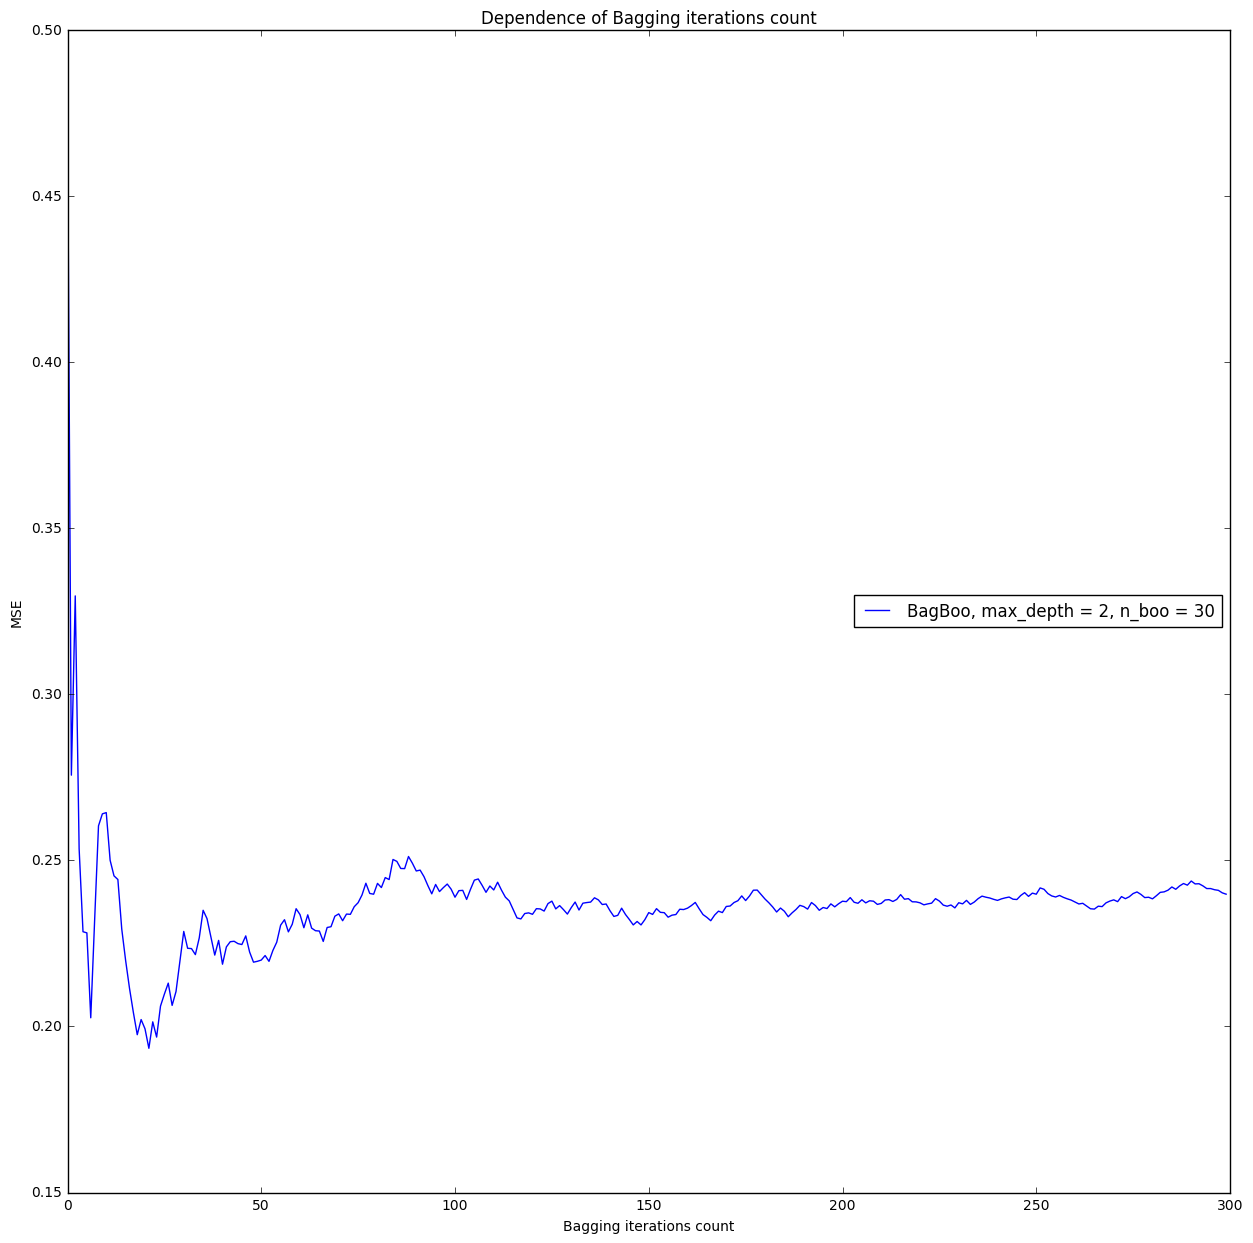

In [18]:
fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(range(0, 300), error_statistic_3, label='BagBoo, max_depth = 2, n_boo = 30')
ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Bagging iterations count')
ax.set_ylabel('MSE')

In [20]:
%%time
bagboo_spam = BagBoo(n_boo=10, n_bag=5, bagging_ratio=0.5, rsm_ratio=0.5, max_depth = 2, shrinkage=0.5)    
error_statistic_4 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

features in RSM:  51
samples in bagging:  3546


Learning estimator number: 9/10; MSE error on train dataset: 0.0856759228771

Iteration of Bagging: 0 / 5
fitting_samples:  0.499929507966
MSE on test Dataset: 0.149188948026 Iteration of Bagging: 0 / 5
MSE on train Dataset: 0.250121519646 Iteration of Bagging: 0 / 5


Learning estimator number: 9/10; MSE error on train dataset: 0.0726464358982

Iteration of Bagging: 1 / 5
fitting_samples:  0.748907373467
MSE on test Dataset: 0.137438492202 Iteration of Bagging: 1 / 5
MSE on train Dataset: 0.213283896061 Iteration of Bagging: 1 / 5


Learning estimator number: 9/10; MSE error on train dataset: 0.0754406205756

Iteration of Bagging: 2 / 5
fitting_samples:  0.873678274355
MSE on test Dataset: 0.184871152154 Iteration of Bagging: 2 / 5
MSE on train Dataset: 0.220228527574 Iteration of Bagging: 2 / 5


Learning estimator number: 9/10; MSE error on train dataset: 0.0703530682191

Iteration of Bagging: 3 / 5
fitting_samples:  0.93768504159
MSE on test Dataset: 0.185151023999 Iteration of Bagging: 3 / 5
MSE on train Dataset: 0.221897024147 Iteration of Bagging: 3 / 5


Learning estimator number: 9/10; MSE error on train dataset: 0.0750878984078

Iteration of Bagging: 4 / 5
fitting_samples:  0.969688425208
MSE on test Dataset: 0.183836157821 Iteration of Bagging: 4 / 5
MSE on train Dataset: 0.221538301223 Iteration of Bagging: 4 / 5
CPU times: user 34min 54s, sys: 1.17 s, total: 34min 55s
Wall time: 34min 57s


In [18]:
%%time
bagboo_spam = BagBoo(n_boo=30, n_bag=300, max_depth = 2, shrinkage=0.1)    
error_statistic_test, error_statistic_train = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

# bagboo_spam = BagBoo(n_boo=100, n_bag=100, max_depth = 2, shrinkage=0.1)    
# error_statistic_test_100, error_statistic_train_100 = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
#                 Y_test = spam_test_target)

Iteration of bagging:1/300

MSE on test Dataset: 0.0907527748676 Iteration of Bagging: 0 / 300
MSE on train Dataset: 0.073482666232 Iteration of Bagging: 0 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0701394498049

MSE on test Dataset: 0.0877646307782 Iteration of Bagging: 1 / 300
MSE on train Dataset: 0.0719534252413 Iteration of Bagging: 1 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0717383130551

MSE on test Dataset: 0.0869210157083 Iteration of Bagging: 2 / 300
MSE on train Dataset: 0.0703939612036 Iteration of Bagging: 2 / 300


Iteration of bagging:4/300

MSE on test Dataset: 0.0846819085011 Iteration of Bagging: 3 / 300
MSE on train Dataset: 0.0701987211275 Iteration of Bagging: 3 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0690666757267

MSE on test Dataset: 0.0854043692473 Iteration of Bagging: 4 / 300
MSE on train Dataset: 0.0700725644414 Iteration of Bagging: 4 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0708632928025

MSE on test Dataset: 0.0848955219106 Iteration of Bagging: 5 / 300
MSE on train Dataset: 0.0697910808557 Iteration of Bagging: 5 / 300


Iteration of bagging:7/300

MSE on test Dataset: 0.0842948532898 Iteration of Bagging: 6 / 300
MSE on train Dataset: 0.0696546879945 Iteration of Bagging: 6 / 300


Iteration of bagging:8/300

MSE on test Dataset: 0.0843951392567 Iteration of Bagging: 7 / 300
MSE on train Dataset: 0.0697418110542 Iteration of Bagging: 7 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0734377726219

MSE on test Dataset: 0.0835314564089 Iteration of Bagging: 8 / 300
MSE on train Dataset: 0.0698368152029 Iteration of Bagging: 8 / 300


Iteration of bagging:10/300

MSE on test Dataset: 0.0827878956688 Iteration of Bagging: 9 / 300
MSE on train Dataset: 0.0697424166007 Iteration of Bagging: 9 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.069931429135

MSE on test Dataset: 0.0838540651772 Iteration of Bagging: 10 / 300
MSE on train Dataset: 0.0698459513872 Iteration of Bagging: 10 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0707060110369

MSE on test Dataset: 0.0845405832016 Iteration of Bagging: 11 / 300
MSE on train Dataset: 0.0700401901415 Iteration of Bagging: 11 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0723910566114

MSE on test Dataset: 0.0844272012059 Iteration of Bagging: 12 / 300
MSE on train Dataset: 0.0701288605189 Iteration of Bagging: 12 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0691935314175

MSE on test Dataset: 0.0841719116511 Iteration of Bagging: 13 / 300
MSE on train Dataset: 0.0700023686233 Iteration of Bagging: 13 / 300


Iteration of bagging:15/300

MSE on test Dataset: 0.0842724597799 Iteration of Bagging: 14 / 300
MSE on train Dataset: 0.0698006996353 Iteration of Bagging: 14 / 300


Iteration of bagging:16/300

MSE on test Dataset: 0.0837501905373 Iteration of Bagging: 15 / 300
MSE on train Dataset: 0.0698116504341 Iteration of Bagging: 15 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0699505363986

MSE on test Dataset: 0.0837874213851 Iteration of Bagging: 16 / 300
MSE on train Dataset: 0.0698098274452 Iteration of Bagging: 16 / 300


Iteration of bagging:18/300

MSE on test Dataset: 0.0833586687258 Iteration of Bagging: 17 / 300
MSE on train Dataset: 0.0697782774619 Iteration of Bagging: 17 / 300


Iteration of bagging:19/300

MSE on test Dataset: 0.0832839726542 Iteration of Bagging: 18 / 300
MSE on train Dataset: 0.0698150909316 Iteration of Bagging: 18 / 300


Iteration of bagging:20/300

MSE on test Dataset: 0.0838848173002 Iteration of Bagging: 19 / 300
MSE on train Dataset: 0.0698416701664 Iteration of Bagging: 19 / 300


Iteration of bagging:21/300

MSE on test Dataset: 0.0835614107534 Iteration of Bagging: 20 / 300
MSE on train Dataset: 0.0698494187858 Iteration of Bagging: 20 / 300


Iteration of bagging:22/300

MSE on test Dataset: 0.0834658217435 Iteration of Bagging: 21 / 300
MSE on train Dataset: 0.0697860507343 Iteration of Bagging: 21 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0705734377577

MSE on test Dataset: 0.0836618542228 Iteration of Bagging: 22 / 300
MSE on train Dataset: 0.0698520606851 Iteration of Bagging: 22 / 300


Iteration of bagging:24/300

MSE on test Dataset: 0.0838031945064 Iteration of Bagging: 23 / 300
MSE on train Dataset: 0.0698928217608 Iteration of Bagging: 23 / 300


Iteration of bagging:25/300

MSE on test Dataset: 0.0837021563045 Iteration of Bagging: 24 / 300
MSE on train Dataset: 0.069888215533 Iteration of Bagging: 24 / 300


Iteration of bagging:26/300

MSE on test Dataset: 0.0832578432071 Iteration of Bagging: 25 / 300
MSE on train Dataset: 0.0697784443071 Iteration of Bagging: 25 / 300


Iteration of bagging:27/300

MSE on test Dataset: 0.0833843721017 Iteration of Bagging: 26 / 300
MSE on train Dataset: 0.0697764232034 Iteration of Bagging: 26 / 300


Iteration of bagging:28/300

MSE on test Dataset: 0.0833236950154 Iteration of Bagging: 27 / 300
MSE on train Dataset: 0.0697576962641 Iteration of Bagging: 27 / 300


Iteration of bagging:29/300

MSE on test Dataset: 0.0834414969949 Iteration of Bagging: 28 / 300
MSE on train Dataset: 0.0697876434991 Iteration of Bagging: 28 / 300


Iteration of bagging:30/300

MSE on test Dataset: 0.0836616641639 Iteration of Bagging: 29 / 300
MSE on train Dataset: 0.0698379335344 Iteration of Bagging: 29 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0693161314976

MSE on test Dataset: 0.083077524181 Iteration of Bagging: 30 / 300
MSE on train Dataset: 0.0697797873611 Iteration of Bagging: 30 / 300


Iteration of bagging:32/300

MSE on test Dataset: 0.0829587600961 Iteration of Bagging: 31 / 300
MSE on train Dataset: 0.0698198096829 Iteration of Bagging: 31 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0713053679723

MSE on test Dataset: 0.0828694095404 Iteration of Bagging: 32 / 300
MSE on train Dataset: 0.0698172451349 Iteration of Bagging: 32 / 300


Iteration of bagging:34/300

MSE on test Dataset: 0.0828070937378 Iteration of Bagging: 33 / 300
MSE on train Dataset: 0.0698833308799 Iteration of Bagging: 33 / 300


Iteration of bagging:35/300

MSE on test Dataset: 0.0826830215776 Iteration of Bagging: 34 / 300
MSE on train Dataset: 0.0699211249798 Iteration of Bagging: 34 / 300


Iteration of bagging:36/300

MSE on test Dataset: 0.0825891378423 Iteration of Bagging: 35 / 300
MSE on train Dataset: 0.0698747089331 Iteration of Bagging: 35 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0699370458628

MSE on test Dataset: 0.0826959256683 Iteration of Bagging: 36 / 300
MSE on train Dataset: 0.0698253180935 Iteration of Bagging: 36 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0726208915348

MSE on test Dataset: 0.0827431208595 Iteration of Bagging: 37 / 300
MSE on train Dataset: 0.0698687584495 Iteration of Bagging: 37 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0715474576598

MSE on test Dataset: 0.0827442284269 Iteration of Bagging: 38 / 300
MSE on train Dataset: 0.0698641529349 Iteration of Bagging: 38 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0724040097881

MSE on test Dataset: 0.0829499671114 Iteration of Bagging: 39 / 300
MSE on train Dataset: 0.0698546545087 Iteration of Bagging: 39 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0707908023918

MSE on test Dataset: 0.0831444184685 Iteration of Bagging: 40 / 300
MSE on train Dataset: 0.0698688615127 Iteration of Bagging: 40 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0691242247861

MSE on test Dataset: 0.0829788852189 Iteration of Bagging: 41 / 300
MSE on train Dataset: 0.0698304564004 Iteration of Bagging: 41 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0701066289942

MSE on test Dataset: 0.0830254929429 Iteration of Bagging: 42 / 300
MSE on train Dataset: 0.0697895540437 Iteration of Bagging: 42 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0715593247338

MSE on test Dataset: 0.0832013952628 Iteration of Bagging: 43 / 300
MSE on train Dataset: 0.069838392355 Iteration of Bagging: 43 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0719756940463

MSE on test Dataset: 0.0831471536218 Iteration of Bagging: 44 / 300
MSE on train Dataset: 0.0698650713688 Iteration of Bagging: 44 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0689867950017

MSE on test Dataset: 0.0832255529469 Iteration of Bagging: 45 / 300
MSE on train Dataset: 0.0698687633981 Iteration of Bagging: 45 / 300


Iteration of bagging:47/300

MSE on test Dataset: 0.0831889413739 Iteration of Bagging: 46 / 300
MSE on train Dataset: 0.0698951138518 Iteration of Bagging: 46 / 300


Iteration of bagging:48/300

MSE on test Dataset: 0.0831984878257 Iteration of Bagging: 47 / 300
MSE on train Dataset: 0.069932555609 Iteration of Bagging: 47 / 300


Iteration of bagging:49/300

MSE on test Dataset: 0.0830732914967 Iteration of Bagging: 48 / 300
MSE on train Dataset: 0.0699014743462 Iteration of Bagging: 48 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0700402852151

MSE on test Dataset: 0.083143609939 Iteration of Bagging: 49 / 300
MSE on train Dataset: 0.0698880524673 Iteration of Bagging: 49 / 300


Iteration of bagging:51/300

MSE on test Dataset: 0.0832437170937 Iteration of Bagging: 50 / 300
MSE on train Dataset: 0.0698907909301 Iteration of Bagging: 50 / 300


Iteration of bagging:52/300

MSE on test Dataset: 0.0831500559159 Iteration of Bagging: 51 / 300
MSE on train Dataset: 0.0699051136946 Iteration of Bagging: 51 / 300


Iteration of bagging:53/300

MSE on test Dataset: 0.0831146992526 Iteration of Bagging: 52 / 300
MSE on train Dataset: 0.0699194620686 Iteration of Bagging: 52 / 300


Iteration of bagging:54/300

MSE on test Dataset: 0.0831466689469 Iteration of Bagging: 53 / 300
MSE on train Dataset: 0.0699402363268 Iteration of Bagging: 53 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0693715649677

MSE on test Dataset: 0.0831041815308 Iteration of Bagging: 54 / 300
MSE on train Dataset: 0.0699578388668 Iteration of Bagging: 54 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0711167413677

MSE on test Dataset: 0.0830889265668 Iteration of Bagging: 55 / 300
MSE on train Dataset: 0.0699911054183 Iteration of Bagging: 55 / 300


Iteration of bagging:57/300

MSE on test Dataset: 0.0831608870569 Iteration of Bagging: 56 / 300
MSE on train Dataset: 0.0699919407838 Iteration of Bagging: 56 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0702655675635

MSE on test Dataset: 0.0832710854117 Iteration of Bagging: 57 / 300
MSE on train Dataset: 0.069986009728 Iteration of Bagging: 57 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709391637734

MSE on test Dataset: 0.0832871068949 Iteration of Bagging: 58 / 300
MSE on train Dataset: 0.0700025764219 Iteration of Bagging: 58 / 300


Iteration of bagging:60/300

MSE on test Dataset: 0.0832191862405 Iteration of Bagging: 59 / 300
MSE on train Dataset: 0.0700145049005 Iteration of Bagging: 59 / 300


Iteration of bagging:61/300

MSE on test Dataset: 0.0831322999016 Iteration of Bagging: 60 / 300
MSE on train Dataset: 0.0699757261623 Iteration of Bagging: 60 / 300


Iteration of bagging:62/300

MSE on test Dataset: 0.0831408486174 Iteration of Bagging: 61 / 300
MSE on train Dataset: 0.0699751719071 Iteration of Bagging: 61 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.07288117628

MSE on test Dataset: 0.0831116094423 Iteration of Bagging: 62 / 300
MSE on train Dataset: 0.0699294404049 Iteration of Bagging: 62 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0719151981833

MSE on test Dataset: 0.0831081422191 Iteration of Bagging: 63 / 300
MSE on train Dataset: 0.0699055335257 Iteration of Bagging: 63 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.070669779261

MSE on test Dataset: 0.0830124517408 Iteration of Bagging: 64 / 300
MSE on train Dataset: 0.069882943703 Iteration of Bagging: 64 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0743016786174

MSE on test Dataset: 0.0829252365494 Iteration of Bagging: 65 / 300
MSE on train Dataset: 0.069855394271 Iteration of Bagging: 65 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0702215247741

MSE on test Dataset: 0.0830292566278 Iteration of Bagging: 66 / 300
MSE on train Dataset: 0.0698531983423 Iteration of Bagging: 66 / 300


Iteration of bagging:68/300

MSE on test Dataset: 0.0831394850788 Iteration of Bagging: 67 / 300
MSE on train Dataset: 0.0698449645339 Iteration of Bagging: 67 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.070714953122

MSE on test Dataset: 0.0830678593998 Iteration of Bagging: 68 / 300
MSE on train Dataset: 0.0698558543728 Iteration of Bagging: 68 / 300


Iteration of bagging:70/300

MSE on test Dataset: 0.0832401180592 Iteration of Bagging: 69 / 300
MSE on train Dataset: 0.0698656670774 Iteration of Bagging: 69 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709153996709

MSE on test Dataset: 0.0832295644258 Iteration of Bagging: 70 / 300
MSE on train Dataset: 0.0698784976248 Iteration of Bagging: 70 / 300


Iteration of bagging:72/300

MSE on test Dataset: 0.0831890591929 Iteration of Bagging: 71 / 300
MSE on train Dataset: 0.069877866941 Iteration of Bagging: 71 / 300


Iteration of bagging:73/300

MSE on test Dataset: 0.0831486967689 Iteration of Bagging: 72 / 300
MSE on train Dataset: 0.0698862248723 Iteration of Bagging: 72 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0706719805365

MSE on test Dataset: 0.0831290011699 Iteration of Bagging: 73 / 300
MSE on train Dataset: 0.0698608016213 Iteration of Bagging: 73 / 300


Iteration of bagging:75/300

MSE on test Dataset: 0.0831957022724 Iteration of Bagging: 74 / 300
MSE on train Dataset: 0.0698721749459 Iteration of Bagging: 74 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0700733695047

MSE on test Dataset: 0.0832109960612 Iteration of Bagging: 75 / 300
MSE on train Dataset: 0.0698915395634 Iteration of Bagging: 75 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709200606836

MSE on test Dataset: 0.0831563976204 Iteration of Bagging: 76 / 300
MSE on train Dataset: 0.0699076476051 Iteration of Bagging: 76 / 300


Iteration of bagging:78/300

MSE on test Dataset: 0.0832542870993 Iteration of Bagging: 77 / 300
MSE on train Dataset: 0.0698868935149 Iteration of Bagging: 77 / 300


Iteration of bagging:79/300

MSE on test Dataset: 0.0831991198018 Iteration of Bagging: 78 / 300
MSE on train Dataset: 0.0698561150171 Iteration of Bagging: 78 / 300


Iteration of bagging:80/300

MSE on test Dataset: 0.0831517168553 Iteration of Bagging: 79 / 300
MSE on train Dataset: 0.0698599531963 Iteration of Bagging: 79 / 300


Iteration of bagging:81/300

MSE on test Dataset: 0.0831641487671 Iteration of Bagging: 80 / 300
MSE on train Dataset: 0.0698785627443 Iteration of Bagging: 80 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0733283378838

MSE on test Dataset: 0.0830992075413 Iteration of Bagging: 81 / 300
MSE on train Dataset: 0.0698686795634 Iteration of Bagging: 81 / 300


Iteration of bagging:83/300

MSE on test Dataset: 0.083211928497 Iteration of Bagging: 82 / 300
MSE on train Dataset: 0.0698700587286 Iteration of Bagging: 82 / 300


Iteration of bagging:84/300

MSE on test Dataset: 0.0832299040277 Iteration of Bagging: 83 / 300
MSE on train Dataset: 0.0698980629658 Iteration of Bagging: 83 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0738910361292

MSE on test Dataset: 0.0832140077811 Iteration of Bagging: 84 / 300
MSE on train Dataset: 0.0698935540732 Iteration of Bagging: 84 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0711699912804

MSE on test Dataset: 0.0831997571126 Iteration of Bagging: 85 / 300
MSE on train Dataset: 0.0699016194739 Iteration of Bagging: 85 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0692147370915

MSE on test Dataset: 0.0832580762381 Iteration of Bagging: 86 / 300
MSE on train Dataset: 0.0699199352007 Iteration of Bagging: 86 / 300


Iteration of bagging:88/300

MSE on test Dataset: 0.0832289890966 Iteration of Bagging: 87 / 300
MSE on train Dataset: 0.0698982888776 Iteration of Bagging: 87 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0704981278244

MSE on test Dataset: 0.0831673532165 Iteration of Bagging: 88 / 300
MSE on train Dataset: 0.0699154543799 Iteration of Bagging: 88 / 300


Iteration of bagging:90/300

MSE on test Dataset: 0.0831990318988 Iteration of Bagging: 89 / 300
MSE on train Dataset: 0.0699237042354 Iteration of Bagging: 89 / 300


Iteration of bagging:91/300

MSE on test Dataset: 0.083186545832 Iteration of Bagging: 90 / 300
MSE on train Dataset: 0.0699296510426 Iteration of Bagging: 90 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0704845598222

MSE on test Dataset: 0.0832168955409 Iteration of Bagging: 91 / 300
MSE on train Dataset: 0.0699177631759 Iteration of Bagging: 91 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0726328264094

MSE on test Dataset: 0.0831503929613 Iteration of Bagging: 92 / 300
MSE on train Dataset: 0.0699143399408 Iteration of Bagging: 92 / 300


Iteration of bagging:94/300

MSE on test Dataset: 0.0831381219783 Iteration of Bagging: 93 / 300
MSE on train Dataset: 0.0699060885899 Iteration of Bagging: 93 / 300


Iteration of bagging:95/300

MSE on test Dataset: 0.0831747795751 Iteration of Bagging: 94 / 300
MSE on train Dataset: 0.0699066111609 Iteration of Bagging: 94 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0682903321621

MSE on test Dataset: 0.0831475414047 Iteration of Bagging: 95 / 300
MSE on train Dataset: 0.0699219029434 Iteration of Bagging: 95 / 300


Iteration of bagging:97/300

MSE on test Dataset: 0.0831340927803 Iteration of Bagging: 96 / 300
MSE on train Dataset: 0.0699388811833 Iteration of Bagging: 96 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0705131379764

MSE on test Dataset: 0.0831429721528 Iteration of Bagging: 97 / 300
MSE on train Dataset: 0.0699429258575 Iteration of Bagging: 97 / 300


Iteration of bagging:99/300

MSE on test Dataset: 0.0830535866611 Iteration of Bagging: 98 / 300
MSE on train Dataset: 0.0699452086544 Iteration of Bagging: 98 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0722895131751

MSE on test Dataset: 0.0830543762436 Iteration of Bagging: 99 / 300
MSE on train Dataset: 0.069944529354 Iteration of Bagging: 99 / 300


Iteration of bagging:101/300

MSE on test Dataset: 0.083094119074 Iteration of Bagging: 100 / 300
MSE on train Dataset: 0.0699591290169 Iteration of Bagging: 100 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709183157454

MSE on test Dataset: 0.0830503504421 Iteration of Bagging: 101 / 300
MSE on train Dataset: 0.0699363756852 Iteration of Bagging: 101 / 300


Iteration of bagging:103/300

MSE on test Dataset: 0.0830244973643 Iteration of Bagging: 102 / 300
MSE on train Dataset: 0.0699624860193 Iteration of Bagging: 102 / 300


Iteration of bagging:104/300

MSE on test Dataset: 0.0829244224231 Iteration of Bagging: 103 / 300
MSE on train Dataset: 0.0699636418161 Iteration of Bagging: 103 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0686373499244

MSE on test Dataset: 0.0828927364367 Iteration of Bagging: 104 / 300
MSE on train Dataset: 0.0699727371892 Iteration of Bagging: 104 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709786298876

MSE on test Dataset: 0.0829496826303 Iteration of Bagging: 105 / 300
MSE on train Dataset: 0.0699815459127 Iteration of Bagging: 105 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0681495386016

MSE on test Dataset: 0.0828844233944 Iteration of Bagging: 106 / 300
MSE on train Dataset: 0.0699756460598 Iteration of Bagging: 106 / 300


Iteration of bagging:108/300

MSE on test Dataset: 0.0829116128566 Iteration of Bagging: 107 / 300
MSE on train Dataset: 0.0699881055444 Iteration of Bagging: 107 / 300


Iteration of bagging:109/300

MSE on test Dataset: 0.0828336053955 Iteration of Bagging: 108 / 300
MSE on train Dataset: 0.0699675922281 Iteration of Bagging: 108 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0727047406311

MSE on test Dataset: 0.0828408212999 Iteration of Bagging: 109 / 300
MSE on train Dataset: 0.069969762249 Iteration of Bagging: 109 / 300


Iteration of bagging:111/300

MSE on test Dataset: 0.0828479588833 Iteration of Bagging: 110 / 300
MSE on train Dataset: 0.0699644692092 Iteration of Bagging: 110 / 300


Iteration of bagging:112/300

MSE on test Dataset: 0.0829389123343 Iteration of Bagging: 111 / 300
MSE on train Dataset: 0.0699466212891 Iteration of Bagging: 111 / 300


Iteration of bagging:113/300

MSE on test Dataset: 0.082880087934 Iteration of Bagging: 112 / 300
MSE on train Dataset: 0.0699528749545 Iteration of Bagging: 112 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0722202048565

MSE on test Dataset: 0.0829145655316 Iteration of Bagging: 113 / 300
MSE on train Dataset: 0.0699554852171 Iteration of Bagging: 113 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0706205814817

MSE on test Dataset: 0.0829248184891 Iteration of Bagging: 114 / 300
MSE on train Dataset: 0.0699582892137 Iteration of Bagging: 114 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.067918377693

MSE on test Dataset: 0.0829783038267 Iteration of Bagging: 115 / 300
MSE on train Dataset: 0.069951072094 Iteration of Bagging: 115 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.068794179728

MSE on test Dataset: 0.0830229849087 Iteration of Bagging: 116 / 300
MSE on train Dataset: 0.0699444383226 Iteration of Bagging: 116 / 300


Iteration of bagging:118/300

MSE on test Dataset: 0.0829528252017 Iteration of Bagging: 117 / 300
MSE on train Dataset: 0.0699478819838 Iteration of Bagging: 117 / 300


Iteration of bagging:119/300

MSE on test Dataset: 0.0829645761169 Iteration of Bagging: 118 / 300
MSE on train Dataset: 0.0699577490443 Iteration of Bagging: 118 / 300


Iteration of bagging:120/300

MSE on test Dataset: 0.0829644357175 Iteration of Bagging: 119 / 300
MSE on train Dataset: 0.069965854786 Iteration of Bagging: 119 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0700111135117

MSE on test Dataset: 0.0829461716657 Iteration of Bagging: 120 / 300
MSE on train Dataset: 0.0699476487937 Iteration of Bagging: 120 / 300


Iteration of bagging:122/300

MSE on test Dataset: 0.082967482635 Iteration of Bagging: 121 / 300
MSE on train Dataset: 0.0699472736185 Iteration of Bagging: 121 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0712391083531

MSE on test Dataset: 0.082994430417 Iteration of Bagging: 122 / 300
MSE on train Dataset: 0.0699470549285 Iteration of Bagging: 122 / 300


Iteration of bagging:124/300

MSE on test Dataset: 0.083043145107 Iteration of Bagging: 123 / 300
MSE on train Dataset: 0.0699533231726 Iteration of Bagging: 123 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0699368188101

MSE on test Dataset: 0.0830146462765 Iteration of Bagging: 124 / 300
MSE on train Dataset: 0.0699601565893 Iteration of Bagging: 124 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0710187907239

MSE on test Dataset: 0.082933666318 Iteration of Bagging: 125 / 300
MSE on train Dataset: 0.0699442701368 Iteration of Bagging: 125 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0696539978894

MSE on test Dataset: 0.0829241986953 Iteration of Bagging: 126 / 300
MSE on train Dataset: 0.0699304763365 Iteration of Bagging: 126 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0711078343437

MSE on test Dataset: 0.0830595861297 Iteration of Bagging: 127 / 300
MSE on train Dataset: 0.069934180235 Iteration of Bagging: 127 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.071171894361

MSE on test Dataset: 0.0830666566395 Iteration of Bagging: 128 / 300
MSE on train Dataset: 0.0699331999426 Iteration of Bagging: 128 / 300


Iteration of bagging:130/300

MSE on test Dataset: 0.0830138121008 Iteration of Bagging: 129 / 300
MSE on train Dataset: 0.0699328495276 Iteration of Bagging: 129 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0701768581991

MSE on test Dataset: 0.0830395251667 Iteration of Bagging: 130 / 300
MSE on train Dataset: 0.069922753887 Iteration of Bagging: 130 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.069852373172

MSE on test Dataset: 0.0830186296578 Iteration of Bagging: 131 / 300
MSE on train Dataset: 0.069911029366 Iteration of Bagging: 131 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0702618611341

MSE on test Dataset: 0.0829344353414 Iteration of Bagging: 132 / 300
MSE on train Dataset: 0.0699091171349 Iteration of Bagging: 132 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0710548590976

MSE on test Dataset: 0.0828671004964 Iteration of Bagging: 133 / 300
MSE on train Dataset: 0.0699021318526 Iteration of Bagging: 133 / 300


Iteration of bagging:135/300

MSE on test Dataset: 0.0828551605071 Iteration of Bagging: 134 / 300
MSE on train Dataset: 0.069890423842 Iteration of Bagging: 134 / 300


Iteration of bagging:136/300

MSE on test Dataset: 0.0828335066288 Iteration of Bagging: 135 / 300
MSE on train Dataset: 0.0698964196375 Iteration of Bagging: 135 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0698691979469

MSE on test Dataset: 0.0828115842253 Iteration of Bagging: 136 / 300
MSE on train Dataset: 0.0698850518503 Iteration of Bagging: 136 / 300


Iteration of bagging:138/300

MSE on test Dataset: 0.0828731158731 Iteration of Bagging: 137 / 300
MSE on train Dataset: 0.0698821215332 Iteration of Bagging: 137 / 300


Iteration of bagging:139/300

MSE on test Dataset: 0.0828656830342 Iteration of Bagging: 138 / 300
MSE on train Dataset: 0.0698806873005 Iteration of Bagging: 138 / 300


Iteration of bagging:140/300

MSE on test Dataset: 0.082837178158 Iteration of Bagging: 139 / 300
MSE on train Dataset: 0.0698757888006 Iteration of Bagging: 139 / 300


Iteration of bagging:141/300

MSE on test Dataset: 0.0828103731616 Iteration of Bagging: 140 / 300
MSE on train Dataset: 0.0698865020118 Iteration of Bagging: 140 / 300


Iteration of bagging:142/300

MSE on test Dataset: 0.0828253383627 Iteration of Bagging: 141 / 300
MSE on train Dataset: 0.0698836896392 Iteration of Bagging: 141 / 300


Iteration of bagging:143/300

MSE on test Dataset: 0.0828504871552 Iteration of Bagging: 142 / 300
MSE on train Dataset: 0.0698789992877 Iteration of Bagging: 142 / 300


Iteration of bagging:144/300

MSE on test Dataset: 0.0828512272831 Iteration of Bagging: 143 / 300
MSE on train Dataset: 0.0698704737469 Iteration of Bagging: 143 / 300


Iteration of bagging:145/300

MSE on test Dataset: 0.0828422861891 Iteration of Bagging: 144 / 300
MSE on train Dataset: 0.0698751381525 Iteration of Bagging: 144 / 300


Iteration of bagging:146/300

MSE on test Dataset: 0.0828226551111 Iteration of Bagging: 145 / 300
MSE on train Dataset: 0.0698765994661 Iteration of Bagging: 145 / 300


Iteration of bagging:147/300

MSE on test Dataset: 0.0827889125174 Iteration of Bagging: 146 / 300
MSE on train Dataset: 0.0698722220563 Iteration of Bagging: 146 / 300


Iteration of bagging:148/300

MSE on test Dataset: 0.0827435171883 Iteration of Bagging: 147 / 300
MSE on train Dataset: 0.0698644826189 Iteration of Bagging: 147 / 300


Iteration of bagging:149/300

MSE on test Dataset: 0.0826934874991 Iteration of Bagging: 148 / 300
MSE on train Dataset: 0.0698667306944 Iteration of Bagging: 148 / 300


Iteration of bagging:150/300

MSE on test Dataset: 0.0826646188343 Iteration of Bagging: 149 / 300
MSE on train Dataset: 0.0698740875067 Iteration of Bagging: 149 / 300


Iteration of bagging:151/300

MSE on test Dataset: 0.0826480665886 Iteration of Bagging: 150 / 300
MSE on train Dataset: 0.0698802272305 Iteration of Bagging: 150 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.068922808314

MSE on test Dataset: 0.0826669616202 Iteration of Bagging: 151 / 300
MSE on train Dataset: 0.0698795651168 Iteration of Bagging: 151 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0699641830629

MSE on test Dataset: 0.0826497132072 Iteration of Bagging: 152 / 300
MSE on train Dataset: 0.0698706674005 Iteration of Bagging: 152 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709414641862

MSE on test Dataset: 0.0826351134346 Iteration of Bagging: 153 / 300
MSE on train Dataset: 0.0698708248676 Iteration of Bagging: 153 / 300


Iteration of bagging:155/300

MSE on test Dataset: 0.0826328495309 Iteration of Bagging: 154 / 300
MSE on train Dataset: 0.0698712470816 Iteration of Bagging: 154 / 300


Iteration of bagging:156/300

MSE on test Dataset: 0.082622733067 Iteration of Bagging: 155 / 300
MSE on train Dataset: 0.0698723709781 Iteration of Bagging: 155 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0703043883354

MSE on test Dataset: 0.0826292241812 Iteration of Bagging: 156 / 300
MSE on train Dataset: 0.0698703306381 Iteration of Bagging: 156 / 300


Iteration of bagging:158/300

MSE on test Dataset: 0.0826679102395 Iteration of Bagging: 157 / 300
MSE on train Dataset: 0.0698669023592 Iteration of Bagging: 157 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0707281029491

MSE on test Dataset: 0.0826938417755 Iteration of Bagging: 158 / 300
MSE on train Dataset: 0.0698684449269 Iteration of Bagging: 158 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0685881340269

MSE on test Dataset: 0.0826596139746 Iteration of Bagging: 159 / 300
MSE on train Dataset: 0.0698686035582 Iteration of Bagging: 159 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0720353263941

MSE on test Dataset: 0.0826735725587 Iteration of Bagging: 160 / 300
MSE on train Dataset: 0.06986324051 Iteration of Bagging: 160 / 300


Iteration of bagging:162/300

MSE on test Dataset: 0.0827471330174 Iteration of Bagging: 161 / 300
MSE on train Dataset: 0.0698679575122 Iteration of Bagging: 161 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0730228322964

MSE on test Dataset: 0.0827226796152 Iteration of Bagging: 162 / 300
MSE on train Dataset: 0.069865633744 Iteration of Bagging: 162 / 300


Iteration of bagging:164/300

MSE on test Dataset: 0.082743816574 Iteration of Bagging: 163 / 300
MSE on train Dataset: 0.0698670196955 Iteration of Bagging: 163 / 300


Iteration of bagging:165/300

MSE on test Dataset: 0.0827496658909 Iteration of Bagging: 164 / 300
MSE on train Dataset: 0.0698563520354 Iteration of Bagging: 164 / 300


Iteration of bagging:166/300

MSE on test Dataset: 0.0828112341348 Iteration of Bagging: 165 / 300
MSE on train Dataset: 0.0698519284839 Iteration of Bagging: 165 / 300


Iteration of bagging:167/300

MSE on test Dataset: 0.0828138090957 Iteration of Bagging: 166 / 300
MSE on train Dataset: 0.0698543041457 Iteration of Bagging: 166 / 300


Iteration of bagging:168/300

MSE on test Dataset: 0.0827912511884 Iteration of Bagging: 167 / 300
MSE on train Dataset: 0.0698555626669 Iteration of Bagging: 167 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0702061190517

MSE on test Dataset: 0.0827844507322 Iteration of Bagging: 168 / 300
MSE on train Dataset: 0.0698530781515 Iteration of Bagging: 168 / 300


Iteration of bagging:170/300

MSE on test Dataset: 0.0827867668328 Iteration of Bagging: 169 / 300
MSE on train Dataset: 0.0698202436048 Iteration of Bagging: 169 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0715324786033

MSE on test Dataset: 0.0827637163341 Iteration of Bagging: 170 / 300
MSE on train Dataset: 0.0698302315256 Iteration of Bagging: 170 / 300


Iteration of bagging:172/300

MSE on test Dataset: 0.0828243552127 Iteration of Bagging: 171 / 300
MSE on train Dataset: 0.0698364051631 Iteration of Bagging: 171 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0674487380088

MSE on test Dataset: 0.0827759994528 Iteration of Bagging: 172 / 300
MSE on train Dataset: 0.0698384067927 Iteration of Bagging: 172 / 300


Iteration of bagging:174/300

MSE on test Dataset: 0.0828301063967 Iteration of Bagging: 173 / 300
MSE on train Dataset: 0.0698490776977 Iteration of Bagging: 173 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0732573164072

MSE on test Dataset: 0.0828026758733 Iteration of Bagging: 174 / 300
MSE on train Dataset: 0.0698525495323 Iteration of Bagging: 174 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0730227856172

MSE on test Dataset: 0.0827896628721 Iteration of Bagging: 175 / 300
MSE on train Dataset: 0.0698543893096 Iteration of Bagging: 175 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0722221932053

MSE on test Dataset: 0.0827674730051 Iteration of Bagging: 176 / 300
MSE on train Dataset: 0.0698550824058 Iteration of Bagging: 176 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.070796339977

MSE on test Dataset: 0.0827783331514 Iteration of Bagging: 177 / 300
MSE on train Dataset: 0.0698575871971 Iteration of Bagging: 177 / 300


Iteration of bagging:179/300

MSE on test Dataset: 0.0827348280537 Iteration of Bagging: 178 / 300
MSE on train Dataset: 0.0698572144811 Iteration of Bagging: 178 / 300


Iteration of bagging:180/300

MSE on test Dataset: 0.0827540323642 Iteration of Bagging: 179 / 300
MSE on train Dataset: 0.0698598440454 Iteration of Bagging: 179 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0716968266107

MSE on test Dataset: 0.0827377167954 Iteration of Bagging: 180 / 300
MSE on train Dataset: 0.0698578842912 Iteration of Bagging: 180 / 300


Iteration of bagging:182/300

MSE on test Dataset: 0.0827270984356 Iteration of Bagging: 181 / 300
MSE on train Dataset: 0.0698676273881 Iteration of Bagging: 181 / 300


Iteration of bagging:183/300

MSE on test Dataset: 0.0827306205434 Iteration of Bagging: 182 / 300
MSE on train Dataset: 0.0698699245023 Iteration of Bagging: 182 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0694671240426

MSE on test Dataset: 0.0827482116406 Iteration of Bagging: 183 / 300
MSE on train Dataset: 0.0698716147649 Iteration of Bagging: 183 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.070874551859

MSE on test Dataset: 0.0827362942084 Iteration of Bagging: 184 / 300
MSE on train Dataset: 0.0698705585277 Iteration of Bagging: 184 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0724020279458

MSE on test Dataset: 0.0827276050443 Iteration of Bagging: 185 / 300
MSE on train Dataset: 0.0698683014866 Iteration of Bagging: 185 / 300


Iteration of bagging:187/300

MSE on test Dataset: 0.0827416357053 Iteration of Bagging: 186 / 300
MSE on train Dataset: 0.0698687588203 Iteration of Bagging: 186 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0701287592778

MSE on test Dataset: 0.0827639511799 Iteration of Bagging: 187 / 300
MSE on train Dataset: 0.0698702254977 Iteration of Bagging: 187 / 300


Iteration of bagging:189/300

MSE on test Dataset: 0.0827643976628 Iteration of Bagging: 188 / 300
MSE on train Dataset: 0.0698671326161 Iteration of Bagging: 188 / 300


Iteration of bagging:190/300

MSE on test Dataset: 0.0827540253789 Iteration of Bagging: 189 / 300
MSE on train Dataset: 0.069858151719 Iteration of Bagging: 189 / 300


Iteration of bagging:191/300

MSE on test Dataset: 0.0827807286176 Iteration of Bagging: 190 / 300
MSE on train Dataset: 0.0698656785027 Iteration of Bagging: 190 / 300


Iteration of bagging:192/300

MSE on test Dataset: 0.0827554097558 Iteration of Bagging: 191 / 300
MSE on train Dataset: 0.0698588483156 Iteration of Bagging: 191 / 300


Iteration of bagging:193/300

MSE on test Dataset: 0.0827809822183 Iteration of Bagging: 192 / 300
MSE on train Dataset: 0.0698642474975 Iteration of Bagging: 192 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0718127414529

MSE on test Dataset: 0.0827913299455 Iteration of Bagging: 193 / 300
MSE on train Dataset: 0.0698713439974 Iteration of Bagging: 193 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0687625093768

MSE on test Dataset: 0.0828053488513 Iteration of Bagging: 194 / 300
MSE on train Dataset: 0.0698746339366 Iteration of Bagging: 194 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0699976284786

MSE on test Dataset: 0.0827774392223 Iteration of Bagging: 195 / 300
MSE on train Dataset: 0.0698807137806 Iteration of Bagging: 195 / 300


Iteration of bagging:197/300

MSE on test Dataset: 0.0827738779779 Iteration of Bagging: 196 / 300
MSE on train Dataset: 0.0698846117407 Iteration of Bagging: 196 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0716245237772

MSE on test Dataset: 0.0827900430556 Iteration of Bagging: 197 / 300
MSE on train Dataset: 0.0698931998467 Iteration of Bagging: 197 / 300


Iteration of bagging:199/300

MSE on test Dataset: 0.0827878113284 Iteration of Bagging: 198 / 300
MSE on train Dataset: 0.0698920956151 Iteration of Bagging: 198 / 300


Iteration of bagging:200/300

MSE on test Dataset: 0.0827925011013 Iteration of Bagging: 199 / 300
MSE on train Dataset: 0.0698808413764 Iteration of Bagging: 199 / 300


Iteration of bagging:201/300

MSE on test Dataset: 0.0828100413486 Iteration of Bagging: 200 / 300
MSE on train Dataset: 0.0698707917024 Iteration of Bagging: 200 / 300


Iteration of bagging:202/300

MSE on test Dataset: 0.0828520981764 Iteration of Bagging: 201 / 300
MSE on train Dataset: 0.0698621174157 Iteration of Bagging: 201 / 300


Iteration of bagging:203/300

MSE on test Dataset: 0.0828610851273 Iteration of Bagging: 202 / 300
MSE on train Dataset: 0.0698618992746 Iteration of Bagging: 202 / 300


Iteration of bagging:204/300

MSE on test Dataset: 0.0828705331752 Iteration of Bagging: 203 / 300
MSE on train Dataset: 0.0698476815303 Iteration of Bagging: 203 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0716172794015

MSE on test Dataset: 0.0828634964647 Iteration of Bagging: 204 / 300
MSE on train Dataset: 0.069847393655 Iteration of Bagging: 204 / 300


Iteration of bagging:206/300

MSE on test Dataset: 0.0828656479555 Iteration of Bagging: 205 / 300
MSE on train Dataset: 0.069847590225 Iteration of Bagging: 205 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0725075559164

MSE on test Dataset: 0.0828842840951 Iteration of Bagging: 206 / 300
MSE on train Dataset: 0.0698467756159 Iteration of Bagging: 206 / 300


Iteration of bagging:208/300

MSE on test Dataset: 0.0828843922295 Iteration of Bagging: 207 / 300
MSE on train Dataset: 0.0698478783181 Iteration of Bagging: 207 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0710983966132

MSE on test Dataset: 0.0828581309839 Iteration of Bagging: 208 / 300
MSE on train Dataset: 0.0698495666637 Iteration of Bagging: 208 / 300


Iteration of bagging:210/300

MSE on test Dataset: 0.0828835305076 Iteration of Bagging: 209 / 300
MSE on train Dataset: 0.0698491654113 Iteration of Bagging: 209 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0714709774068

MSE on test Dataset: 0.0828874986631 Iteration of Bagging: 210 / 300
MSE on train Dataset: 0.069844845431 Iteration of Bagging: 210 / 300


Iteration of bagging:212/300

MSE on test Dataset: 0.0829044737873 Iteration of Bagging: 211 / 300
MSE on train Dataset: 0.0698438830635 Iteration of Bagging: 211 / 300


Iteration of bagging:213/300

MSE on test Dataset: 0.0829244077857 Iteration of Bagging: 212 / 300
MSE on train Dataset: 0.0698456613838 Iteration of Bagging: 212 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0696198474882

MSE on test Dataset: 0.0829169004452 Iteration of Bagging: 213 / 300
MSE on train Dataset: 0.0698508674517 Iteration of Bagging: 213 / 300


Iteration of bagging:215/300

MSE on test Dataset: 0.0829425371597 Iteration of Bagging: 214 / 300
MSE on train Dataset: 0.069857802198 Iteration of Bagging: 214 / 300


Iteration of bagging:216/300

MSE on test Dataset: 0.0829306299127 Iteration of Bagging: 215 / 300
MSE on train Dataset: 0.0698616153997 Iteration of Bagging: 215 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0712175698166

MSE on test Dataset: 0.082932072912 Iteration of Bagging: 216 / 300
MSE on train Dataset: 0.0698584563595 Iteration of Bagging: 216 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0736031106566

MSE on test Dataset: 0.0829287809328 Iteration of Bagging: 217 / 300
MSE on train Dataset: 0.0698589388878 Iteration of Bagging: 217 / 300


Iteration of bagging:219/300

MSE on test Dataset: 0.0829682569272 Iteration of Bagging: 218 / 300
MSE on train Dataset: 0.0698568671714 Iteration of Bagging: 218 / 300


Iteration of bagging:220/300

MSE on test Dataset: 0.0829628048475 Iteration of Bagging: 219 / 300
MSE on train Dataset: 0.0698562305803 Iteration of Bagging: 219 / 300


Iteration of bagging:221/300

MSE on test Dataset: 0.0829440255732 Iteration of Bagging: 220 / 300
MSE on train Dataset: 0.0698480996306 Iteration of Bagging: 220 / 300


Iteration of bagging:222/300

MSE on test Dataset: 0.0829213033436 Iteration of Bagging: 221 / 300
MSE on train Dataset: 0.0698458993169 Iteration of Bagging: 221 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0684658114094

MSE on test Dataset: 0.0828990440072 Iteration of Bagging: 222 / 300
MSE on train Dataset: 0.069844030009 Iteration of Bagging: 222 / 300


Iteration of bagging:224/300

MSE on test Dataset: 0.082891668928 Iteration of Bagging: 223 / 300
MSE on train Dataset: 0.0698378486441 Iteration of Bagging: 223 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0696387241104

MSE on test Dataset: 0.0829148492428 Iteration of Bagging: 224 / 300
MSE on train Dataset: 0.0698380548201 Iteration of Bagging: 224 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0692763598141

MSE on test Dataset: 0.0829311626619 Iteration of Bagging: 225 / 300
MSE on train Dataset: 0.0698377254643 Iteration of Bagging: 225 / 300


Iteration of bagging:227/300

MSE on test Dataset: 0.0829473778204 Iteration of Bagging: 226 / 300
MSE on train Dataset: 0.0698404627753 Iteration of Bagging: 226 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0697959413895

MSE on test Dataset: 0.0829503548015 Iteration of Bagging: 227 / 300
MSE on train Dataset: 0.0698454222134 Iteration of Bagging: 227 / 300


Iteration of bagging:229/300

MSE on test Dataset: 0.0829792306771 Iteration of Bagging: 228 / 300
MSE on train Dataset: 0.0698509804802 Iteration of Bagging: 228 / 300


Iteration of bagging:230/300

MSE on test Dataset: 0.0829972129864 Iteration of Bagging: 229 / 300
MSE on train Dataset: 0.0698483036798 Iteration of Bagging: 229 / 300


Iteration of bagging:231/300

MSE on test Dataset: 0.0830134471144 Iteration of Bagging: 230 / 300
MSE on train Dataset: 0.0698536241187 Iteration of Bagging: 230 / 300


Iteration of bagging:232/300

MSE on test Dataset: 0.082997890006 Iteration of Bagging: 231 / 300
MSE on train Dataset: 0.06985253294 Iteration of Bagging: 231 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.072237789953

MSE on test Dataset: 0.082955913061 Iteration of Bagging: 232 / 300
MSE on train Dataset: 0.0698573348803 Iteration of Bagging: 232 / 300


Iteration of bagging:234/300

MSE on test Dataset: 0.0829718824581 Iteration of Bagging: 233 / 300
MSE on train Dataset: 0.0698580208495 Iteration of Bagging: 233 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0708544332169

MSE on test Dataset: 0.0829877064 Iteration of Bagging: 234 / 300
MSE on train Dataset: 0.0698588729785 Iteration of Bagging: 234 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0720102373815

MSE on test Dataset: 0.0829543871165 Iteration of Bagging: 235 / 300
MSE on train Dataset: 0.069857925999 Iteration of Bagging: 235 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0715225323625

MSE on test Dataset: 0.0829633244852 Iteration of Bagging: 236 / 300
MSE on train Dataset: 0.0698602671295 Iteration of Bagging: 236 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0739485833677

MSE on test Dataset: 0.0829778889594 Iteration of Bagging: 237 / 300
MSE on train Dataset: 0.0698656068996 Iteration of Bagging: 237 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0707194350796

MSE on test Dataset: 0.0830127757823 Iteration of Bagging: 238 / 300
MSE on train Dataset: 0.0698667234529 Iteration of Bagging: 238 / 300


Iteration of bagging:240/300

MSE on test Dataset: 0.0830207800166 Iteration of Bagging: 239 / 300
MSE on train Dataset: 0.06987241731 Iteration of Bagging: 239 / 300


Iteration of bagging:241/300

MSE on test Dataset: 0.0830273507148 Iteration of Bagging: 240 / 300
MSE on train Dataset: 0.0698777793575 Iteration of Bagging: 240 / 300


Iteration of bagging:242/300

MSE on test Dataset: 0.0830555791534 Iteration of Bagging: 241 / 300
MSE on train Dataset: 0.0698666005152 Iteration of Bagging: 241 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0695072245281

MSE on test Dataset: 0.0830455657516 Iteration of Bagging: 242 / 300
MSE on train Dataset: 0.069867605114 Iteration of Bagging: 242 / 300


Iteration of bagging:244/300

MSE on test Dataset: 0.0830613658501 Iteration of Bagging: 243 / 300
MSE on train Dataset: 0.0698687450552 Iteration of Bagging: 243 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0696814242499

MSE on test Dataset: 0.0830549100063 Iteration of Bagging: 244 / 300
MSE on train Dataset: 0.0698675542092 Iteration of Bagging: 244 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709205251401

MSE on test Dataset: 0.083056796885 Iteration of Bagging: 245 / 300
MSE on train Dataset: 0.0698696757142 Iteration of Bagging: 245 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0733657737398

MSE on test Dataset: 0.083060312003 Iteration of Bagging: 246 / 300
MSE on train Dataset: 0.0698645769365 Iteration of Bagging: 246 / 300


Iteration of bagging:248/300

MSE on test Dataset: 0.0830879779582 Iteration of Bagging: 247 / 300
MSE on train Dataset: 0.0698683425555 Iteration of Bagging: 247 / 300


Iteration of bagging:249/300

MSE on test Dataset: 0.0830648931437 Iteration of Bagging: 248 / 300
MSE on train Dataset: 0.0698636758097 Iteration of Bagging: 248 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0700102599926

MSE on test Dataset: 0.0830557134256 Iteration of Bagging: 249 / 300
MSE on train Dataset: 0.0698626999766 Iteration of Bagging: 249 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0693364469447

MSE on test Dataset: 0.083038497468 Iteration of Bagging: 250 / 300
MSE on train Dataset: 0.0698684299191 Iteration of Bagging: 250 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0702957784774

MSE on test Dataset: 0.0830046545792 Iteration of Bagging: 251 / 300
MSE on train Dataset: 0.0698669617377 Iteration of Bagging: 251 / 300


Iteration of bagging:253/300

MSE on test Dataset: 0.0829879859822 Iteration of Bagging: 252 / 300
MSE on train Dataset: 0.0698706918586 Iteration of Bagging: 252 / 300


Iteration of bagging:254/300

MSE on test Dataset: 0.0829654256742 Iteration of Bagging: 253 / 300
MSE on train Dataset: 0.0698673059759 Iteration of Bagging: 253 / 300


Iteration of bagging:255/300

MSE on test Dataset: 0.0829712070844 Iteration of Bagging: 254 / 300
MSE on train Dataset: 0.0698740677281 Iteration of Bagging: 254 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0707517053886

MSE on test Dataset: 0.0829585198008 Iteration of Bagging: 255 / 300
MSE on train Dataset: 0.0698745585676 Iteration of Bagging: 255 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0721709499212

MSE on test Dataset: 0.0829528977715 Iteration of Bagging: 256 / 300
MSE on train Dataset: 0.0698673095404 Iteration of Bagging: 256 / 300


Iteration of bagging:258/300

MSE on test Dataset: 0.0829295982023 Iteration of Bagging: 257 / 300
MSE on train Dataset: 0.0698692894476 Iteration of Bagging: 257 / 300


Iteration of bagging:259/300

MSE on test Dataset: 0.0829308686365 Iteration of Bagging: 258 / 300
MSE on train Dataset: 0.0698632177806 Iteration of Bagging: 258 / 300


Iteration of bagging:260/300

MSE on test Dataset: 0.0829117151555 Iteration of Bagging: 259 / 300
MSE on train Dataset: 0.0698589971328 Iteration of Bagging: 259 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0698189732439

MSE on test Dataset: 0.0829169564124 Iteration of Bagging: 260 / 300
MSE on train Dataset: 0.0698548135984 Iteration of Bagging: 260 / 300


Iteration of bagging:262/300

MSE on test Dataset: 0.0829138975267 Iteration of Bagging: 261 / 300
MSE on train Dataset: 0.0698529685589 Iteration of Bagging: 261 / 300


Iteration of bagging:263/300

MSE on test Dataset: 0.0829134346654 Iteration of Bagging: 262 / 300
MSE on train Dataset: 0.0698549240332 Iteration of Bagging: 262 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0710063630883

MSE on test Dataset: 0.0829196363773 Iteration of Bagging: 263 / 300
MSE on train Dataset: 0.0698610304965 Iteration of Bagging: 263 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0714721587775

MSE on test Dataset: 0.0828934315729 Iteration of Bagging: 264 / 300
MSE on train Dataset: 0.0698628471706 Iteration of Bagging: 264 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709809518822

MSE on test Dataset: 0.0828987912717 Iteration of Bagging: 265 / 300
MSE on train Dataset: 0.0698651719542 Iteration of Bagging: 265 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0734740216498

MSE on test Dataset: 0.0829108672706 Iteration of Bagging: 266 / 300
MSE on train Dataset: 0.0698719106047 Iteration of Bagging: 266 / 300


Iteration of bagging:268/300

MSE on test Dataset: 0.0829011110289 Iteration of Bagging: 267 / 300
MSE on train Dataset: 0.0698759372597 Iteration of Bagging: 267 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.068832257568

MSE on test Dataset: 0.0829078904819 Iteration of Bagging: 268 / 300
MSE on train Dataset: 0.069878623957 Iteration of Bagging: 268 / 300


Iteration of bagging:270/300

MSE on test Dataset: 0.0829185027896 Iteration of Bagging: 269 / 300
MSE on train Dataset: 0.0698712901547 Iteration of Bagging: 269 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0708391936869

MSE on test Dataset: 0.0828871297474 Iteration of Bagging: 270 / 300
MSE on train Dataset: 0.0698760296498 Iteration of Bagging: 270 / 300


Iteration of bagging:272/300

MSE on test Dataset: 0.0829191287735 Iteration of Bagging: 271 / 300
MSE on train Dataset: 0.0698796424562 Iteration of Bagging: 271 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0708189949516

MSE on test Dataset: 0.0828898854262 Iteration of Bagging: 272 / 300
MSE on train Dataset: 0.0698834633071 Iteration of Bagging: 272 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0704405608537

MSE on test Dataset: 0.0828892741341 Iteration of Bagging: 273 / 300
MSE on train Dataset: 0.0698805895075 Iteration of Bagging: 273 / 300


Iteration of bagging:275/300

MSE on test Dataset: 0.0829142557795 Iteration of Bagging: 274 / 300
MSE on train Dataset: 0.0698875887481 Iteration of Bagging: 274 / 300


Iteration of bagging:276/300

MSE on test Dataset: 0.082874797135 Iteration of Bagging: 275 / 300
MSE on train Dataset: 0.0698952398274 Iteration of Bagging: 275 / 300


Iteration of bagging:277/300

MSE on test Dataset: 0.0828885738675 Iteration of Bagging: 276 / 300
MSE on train Dataset: 0.0698936645205 Iteration of Bagging: 276 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0697091260872

MSE on test Dataset: 0.082890460358 Iteration of Bagging: 277 / 300
MSE on train Dataset: 0.0698964688109 Iteration of Bagging: 277 / 300


Iteration of bagging:279/300

MSE on test Dataset: 0.0828776999407 Iteration of Bagging: 278 / 300
MSE on train Dataset: 0.0698981089178 Iteration of Bagging: 278 / 300


Iteration of bagging:280/300

MSE on test Dataset: 0.0828286020551 Iteration of Bagging: 279 / 300
MSE on train Dataset: 0.0698928031552 Iteration of Bagging: 279 / 300


Iteration of bagging:281/300

MSE on test Dataset: 0.0828309006471 Iteration of Bagging: 280 / 300
MSE on train Dataset: 0.0698897810441 Iteration of Bagging: 280 / 300


Iteration of bagging:282/300

MSE on test Dataset: 0.0828505980902 Iteration of Bagging: 281 / 300
MSE on train Dataset: 0.0698974891521 Iteration of Bagging: 281 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0698649177688

MSE on test Dataset: 0.0828653146149 Iteration of Bagging: 282 / 300
MSE on train Dataset: 0.06989249052 Iteration of Bagging: 282 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0709466126716

MSE on test Dataset: 0.0828602680787 Iteration of Bagging: 283 / 300
MSE on train Dataset: 0.0698941019679 Iteration of Bagging: 283 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0706366858871

MSE on test Dataset: 0.082845379215 Iteration of Bagging: 284 / 300
MSE on train Dataset: 0.0698958927701 Iteration of Bagging: 284 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0744545403828

MSE on test Dataset: 0.0828358264901 Iteration of Bagging: 285 / 300
MSE on train Dataset: 0.0698830961228 Iteration of Bagging: 285 / 300


Iteration of bagging:287/300

MSE on test Dataset: 0.0828370835767 Iteration of Bagging: 286 / 300
MSE on train Dataset: 0.0698852900222 Iteration of Bagging: 286 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0697212341848

MSE on test Dataset: 0.0828313103788 Iteration of Bagging: 287 / 300
MSE on train Dataset: 0.0698882104886 Iteration of Bagging: 287 / 300


Iteration of bagging:289/300

MSE on test Dataset: 0.0828303903888 Iteration of Bagging: 288 / 300
MSE on train Dataset: 0.0698909228444 Iteration of Bagging: 288 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0705107489832

MSE on test Dataset: 0.0828174791959 Iteration of Bagging: 289 / 300
MSE on train Dataset: 0.0698934947378 Iteration of Bagging: 289 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0698751698193

MSE on test Dataset: 0.0828146141477 Iteration of Bagging: 290 / 300
MSE on train Dataset: 0.0698856040285 Iteration of Bagging: 290 / 300


Iteration of bagging:292/300

MSE on test Dataset: 0.0828166270878 Iteration of Bagging: 291 / 300
MSE on train Dataset: 0.0698862649895 Iteration of Bagging: 291 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.072908727521

MSE on test Dataset: 0.0828068755932 Iteration of Bagging: 292 / 300
MSE on train Dataset: 0.0698798834109 Iteration of Bagging: 292 / 300


Iteration of bagging:294/300

MSE on test Dataset: 0.082786191607 Iteration of Bagging: 293 / 300
MSE on train Dataset: 0.0698770461208 Iteration of Bagging: 293 / 300


Iteration of bagging:295/300

MSE on test Dataset: 0.0827809223524 Iteration of Bagging: 294 / 300
MSE on train Dataset: 0.0698735032892 Iteration of Bagging: 294 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.072162185555

MSE on test Dataset: 0.0827538863121 Iteration of Bagging: 295 / 300
MSE on train Dataset: 0.0698760958567 Iteration of Bagging: 295 / 300


Iteration of bagging:297/300

MSE on test Dataset: 0.0827736076596 Iteration of Bagging: 296 / 300
MSE on train Dataset: 0.0698726675661 Iteration of Bagging: 296 / 300


Iteration of bagging:298/300

MSE on test Dataset: 0.0827655722326 Iteration of Bagging: 297 / 300
MSE on train Dataset: 0.0698712483359 Iteration of Bagging: 297 / 300


Learning estimator number: 30/30; MSE error on train dataset: 0.0733686835092

MSE on test Dataset: 0.0828030117439 Iteration of Bagging: 298 / 300
MSE on train Dataset: 0.0698709555112 Iteration of Bagging: 298 / 300


Learning estimator number: 29/30; MSE error on train dataset: 0.0711696906649

MSE on test Dataset: 0.0828248371045 Iteration of Bagging: 299 / 300
MSE on train Dataset: 0.0698725060127 Iteration of Bagging: 299 / 300
CPU times: user 11min 16s, sys: 1.12 s, total: 11min 17s
Wall time: 11min 13s


Learning estimator number: 30/30; MSE error on train dataset: 0.0705326664122

In [61]:
boo_list = range(1, 1000, 5)
skl_error= [MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=2, n_estimators=boo).fit(spam_train_data, spam_train_target).predict(spam_test_data), spam_test_target) \
            for boo in boo_list]

In [19]:
skl_error_100 = MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=2, n_estimators=100).fit(spam_train_data, spam_train_target).predict(spam_test_data), spam_test_target)

skl_error_30 = MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=2, n_estimators=30).fit(spam_train_data, spam_train_target).predict(spam_test_data), spam_test_target)

print skl_error_100, skl_error_30

0.0646812919084 0.0867586646797


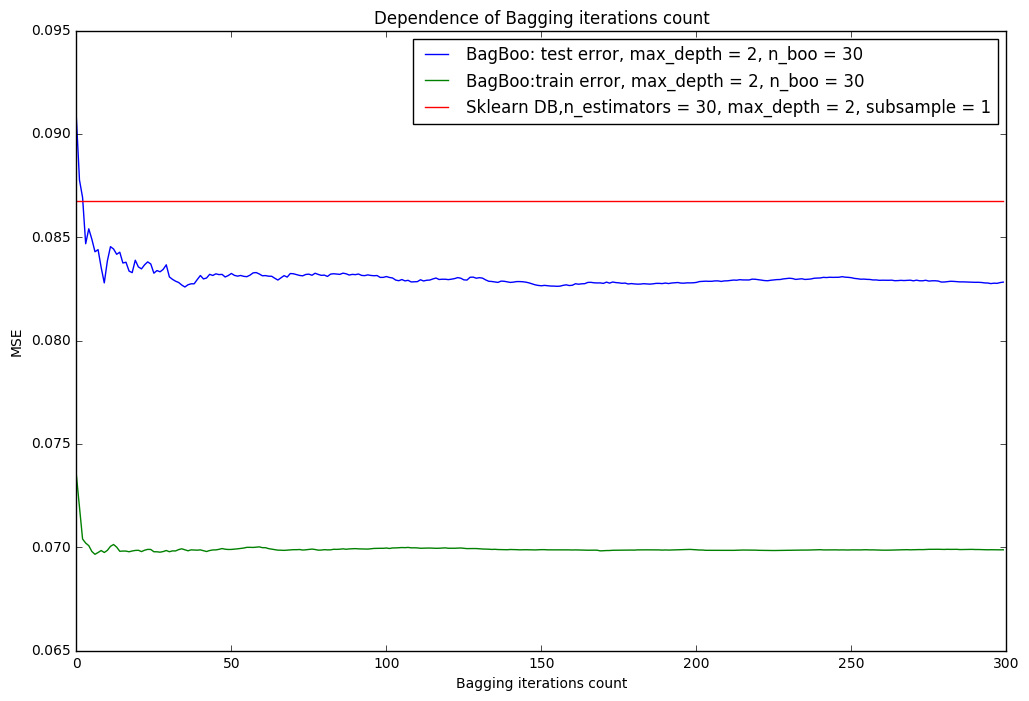

In [20]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.plot(range(0, 300), error_statistic_test, label='BagBoo: test error, max_depth = 2, n_boo = 30')
plt.plot(range(0, 300), error_statistic_train, label='BagBoo:train error, max_depth = 2, n_boo = 30')
# plt.plot(range(0, 100), error_statistic_test_100, label='BagBoo: test error, max_depth = 2, n_boo = 100')
# plt.plot(range(0, 100), error_statistic_train_100, label='BagBoo:train error, max_depth = 2, n_boo = 100')
# plt.plot(range(0, 400), skl_error, label='Sklearn DB, max_depth = 2, subsample = 1')
# plt.plot(range(0, 100), [skl_error_100] * 100, label='Sklearn DB,n_estimators = 100,  max_depth = 2, subsample = 1')
plt.plot(range(0, 300), [skl_error_30] * 300, label='Sklearn DB,n_estimators = 30, max_depth = 2, subsample = 1')
ax.legend(loc='best')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Bagging iterations count')
ax.set_ylabel('MSE')

In [ ]:
%%time
bagboo_spam = BagBoo(n_boo=50, n_bag=300, max_depth = 2, shrinkage=0.1)    
error_statistic_test, error_statistic_train = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

In [54]:
%%time
skl_gb_spam = GradientBoostingRegressor(criterion='mse', min_impurity_split=0, verbose=2, learning_rate=0.1)
skl_gb_spam.fit(spam_train_data, spam_train_target)

      Iter       Train Loss   Remaining Time 
         1           0.2150            4.16s
         2           0.1916            4.39s
         3           0.1723            4.21s
         4           0.1562            4.06s
         5           0.1413            4.89s
         6           0.1291            4.73s
         7           0.1195            4.52s
         8           0.1097            4.40s
         9           0.1013            4.31s
        10           0.0942            4.23s
        11           0.0876            4.22s
        12           0.0821            4.12s
        13           0.0771            4.01s
        14           0.0726            3.93s
        15           0.0691            3.85s
        16           0.0659            3.84s
        17           0.0632            3.75s
        18           0.0605            3.68s
        19           0.0583            3.61s
        20           0.0558            3.54s
        21           0.0539            3.52s
        2

In [64]:
%%time
bagboo_spam = BagBoo(n_boo=100, n_bag=1000, max_depth = 3, shrinkage=0.1)    
error_statistic_test, error_statistic_train = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

Iteration of bagging:0/1000

1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293766279938

MSE on test Dataset: 0.0918030258644 Iteration of Bagging: 0 / 1000
MSE on train Dataset: 0.0375613201865 Iteration of Bagging: 0 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312337589319

MSE on test Dataset: 0.0852459574793 Iteration of Bagging: 1 / 1000
MSE on train Dataset: 0.0340035179689 Iteration of Bagging: 1 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320172788333

MSE on test Dataset: 0.0783542540408 Iteration of Bagging: 2 / 1000
MSE on train Dataset: 0.032870790908 Iteration of Bagging: 2 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306902721802

MSE on test Dataset: 0.0726776334114 Iteration of Bagging: 3 / 1000
MSE on train Dataset: 0.0323243325247 Iteration of Bagging: 3 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305488849539

MSE on test Dataset: 0.0725345999417 Iteration of Bagging: 4 / 1000
MSE on train Dataset: 0.0319541872629 Iteration of Bagging: 4 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313222312301

MSE on test Dataset: 0.0677790457307 Iteration of Bagging: 5 / 1000
MSE on train Dataset: 0.0316797404938 Iteration of Bagging: 5 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313576984625

MSE on test Dataset: 0.0664736823134 Iteration of Bagging: 6 / 1000
MSE on train Dataset: 0.0317860239833 Iteration of Bagging: 6 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298331587804

MSE on test Dataset: 0.0651229515286 Iteration of Bagging: 7 / 1000
MSE on train Dataset: 0.0316631263017 Iteration of Bagging: 7 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317609792864

MSE on test Dataset: 0.0658647036677 Iteration of Bagging: 8 / 1000
MSE on train Dataset: 0.0318027113277 Iteration of Bagging: 8 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302674751038

MSE on test Dataset: 0.0662175793653 Iteration of Bagging: 9 / 1000
MSE on train Dataset: 0.0318604552993 Iteration of Bagging: 9 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318144432909

MSE on test Dataset: 0.0662006597974 Iteration of Bagging: 10 / 1000
MSE on train Dataset: 0.0317285554821 Iteration of Bagging: 10 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334318702799

MSE on test Dataset: 0.0661275038526 Iteration of Bagging: 11 / 1000
MSE on train Dataset: 0.0318931128386 Iteration of Bagging: 11 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305547180753

MSE on test Dataset: 0.0631718833835 Iteration of Bagging: 12 / 1000
MSE on train Dataset: 0.031691757966 Iteration of Bagging: 12 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308517542804

MSE on test Dataset: 0.0646727464138 Iteration of Bagging: 13 / 1000
MSE on train Dataset: 0.031788179689 Iteration of Bagging: 13 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310106202205

MSE on test Dataset: 0.064429984644 Iteration of Bagging: 14 / 1000
MSE on train Dataset: 0.0318184527735 Iteration of Bagging: 14 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032844555617

MSE on test Dataset: 0.06350354864 Iteration of Bagging: 15 / 1000
MSE on train Dataset: 0.0317680255583 Iteration of Bagging: 15 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316527786461

MSE on test Dataset: 0.0635388958551 Iteration of Bagging: 16 / 1000
MSE on train Dataset: 0.0317704866163 Iteration of Bagging: 16 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307835433159

MSE on test Dataset: 0.0632866694518 Iteration of Bagging: 17 / 1000
MSE on train Dataset: 0.0317065767049 Iteration of Bagging: 17 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312216298336

MSE on test Dataset: 0.0646747034119 Iteration of Bagging: 18 / 1000
MSE on train Dataset: 0.0317365762819 Iteration of Bagging: 18 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310026815156

MSE on test Dataset: 0.065582433214 Iteration of Bagging: 19 / 1000
MSE on train Dataset: 0.031807228638 Iteration of Bagging: 19 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312153830568

MSE on test Dataset: 0.0661270950159 Iteration of Bagging: 20 / 1000
MSE on train Dataset: 0.03178734699 Iteration of Bagging: 20 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325712466633

MSE on test Dataset: 0.0667938770601 Iteration of Bagging: 21 / 1000
MSE on train Dataset: 0.0317929066488 Iteration of Bagging: 21 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329126180439

MSE on test Dataset: 0.066931380338 Iteration of Bagging: 22 / 1000
MSE on train Dataset: 0.0318228264275 Iteration of Bagging: 22 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031265202052

MSE on test Dataset: 0.0681094114605 Iteration of Bagging: 23 / 1000
MSE on train Dataset: 0.0318672156311 Iteration of Bagging: 23 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313453033167

MSE on test Dataset: 0.0688723690584 Iteration of Bagging: 24 / 1000
MSE on train Dataset: 0.0319537980484 Iteration of Bagging: 24 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315001125936

MSE on test Dataset: 0.0686952885783 Iteration of Bagging: 25 / 1000
MSE on train Dataset: 0.0319711598151 Iteration of Bagging: 25 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310844049627

MSE on test Dataset: 0.0690830190571 Iteration of Bagging: 26 / 1000
MSE on train Dataset: 0.0319792817952 Iteration of Bagging: 26 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319608564364

MSE on test Dataset: 0.068737517333 Iteration of Bagging: 27 / 1000
MSE on train Dataset: 0.0319430919217 Iteration of Bagging: 27 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305599437511

MSE on test Dataset: 0.0679194830746 Iteration of Bagging: 28 / 1000
MSE on train Dataset: 0.031961885701 Iteration of Bagging: 28 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323684521507

MSE on test Dataset: 0.0680836512658 Iteration of Bagging: 29 / 1000
MSE on train Dataset: 0.0319129906521 Iteration of Bagging: 29 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329804501695

MSE on test Dataset: 0.0677821209712 Iteration of Bagging: 30 / 1000
MSE on train Dataset: 0.0319630158538 Iteration of Bagging: 30 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313070533577

MSE on test Dataset: 0.0677236748272 Iteration of Bagging: 31 / 1000
MSE on train Dataset: 0.0319903385852 Iteration of Bagging: 31 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305017873927

MSE on test Dataset: 0.0686797361055 Iteration of Bagging: 32 / 1000
MSE on train Dataset: 0.0320718356504 Iteration of Bagging: 32 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312788922668

MSE on test Dataset: 0.0687127644669 Iteration of Bagging: 33 / 1000
MSE on train Dataset: 0.0321093407446 Iteration of Bagging: 33 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315345037294

MSE on test Dataset: 0.068624911944 Iteration of Bagging: 34 / 1000
MSE on train Dataset: 0.0321246633994 Iteration of Bagging: 34 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323047159237

MSE on test Dataset: 0.0689461843577 Iteration of Bagging: 35 / 1000
MSE on train Dataset: 0.0321296789518 Iteration of Bagging: 35 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310841229242

MSE on test Dataset: 0.0692019054871 Iteration of Bagging: 36 / 1000
MSE on train Dataset: 0.0321390865763 Iteration of Bagging: 36 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316030286099

MSE on test Dataset: 0.0696568785865 Iteration of Bagging: 37 / 1000
MSE on train Dataset: 0.03214021445 Iteration of Bagging: 37 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299050784327

MSE on test Dataset: 0.0698869209502 Iteration of Bagging: 38 / 1000
MSE on train Dataset: 0.0321749413027 Iteration of Bagging: 38 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311934710416

MSE on test Dataset: 0.0703327498835 Iteration of Bagging: 39 / 1000
MSE on train Dataset: 0.0321903909327 Iteration of Bagging: 39 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324293254728

MSE on test Dataset: 0.070869274484 Iteration of Bagging: 40 / 1000
MSE on train Dataset: 0.0322101509979 Iteration of Bagging: 40 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313622023569

MSE on test Dataset: 0.0710291208836 Iteration of Bagging: 41 / 1000
MSE on train Dataset: 0.0322208440687 Iteration of Bagging: 41 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310814562625

MSE on test Dataset: 0.0711527077906 Iteration of Bagging: 42 / 1000
MSE on train Dataset: 0.0322007822352 Iteration of Bagging: 42 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301987291882

MSE on test Dataset: 0.0712208060095 Iteration of Bagging: 43 / 1000
MSE on train Dataset: 0.0322110368044 Iteration of Bagging: 43 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304288396606

MSE on test Dataset: 0.0714127615932 Iteration of Bagging: 44 / 1000
MSE on train Dataset: 0.0321598794257 Iteration of Bagging: 44 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305455067945

MSE on test Dataset: 0.0714726836041 Iteration of Bagging: 45 / 1000
MSE on train Dataset: 0.0321597301683 Iteration of Bagging: 45 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308210918429

MSE on test Dataset: 0.0703239917167 Iteration of Bagging: 46 / 1000
MSE on train Dataset: 0.0320857019443 Iteration of Bagging: 46 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300066085147

MSE on test Dataset: 0.0702201559222 Iteration of Bagging: 47 / 1000
MSE on train Dataset: 0.0320948192546 Iteration of Bagging: 47 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301617636038

MSE on test Dataset: 0.0707244860431 Iteration of Bagging: 48 / 1000
MSE on train Dataset: 0.0321133054707 Iteration of Bagging: 48 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312043986496

MSE on test Dataset: 0.0700912785973 Iteration of Bagging: 49 / 1000
MSE on train Dataset: 0.0320506149024 Iteration of Bagging: 49 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324137608325

MSE on test Dataset: 0.0698393106507 Iteration of Bagging: 50 / 1000
MSE on train Dataset: 0.031969160013 Iteration of Bagging: 50 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312357965416

MSE on test Dataset: 0.0693922223903 Iteration of Bagging: 51 / 1000
MSE on train Dataset: 0.0318755650469 Iteration of Bagging: 51 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334106221423

MSE on test Dataset: 0.0696338090257 Iteration of Bagging: 52 / 1000
MSE on train Dataset: 0.0318745058888 Iteration of Bagging: 52 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297960729523

MSE on test Dataset: 0.0700554745715 Iteration of Bagging: 53 / 1000
MSE on train Dataset: 0.0318580276095 Iteration of Bagging: 53 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310053278917

MSE on test Dataset: 0.0693566885412 Iteration of Bagging: 54 / 1000
MSE on train Dataset: 0.0318257883899 Iteration of Bagging: 54 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305174979516

MSE on test Dataset: 0.0687733592933 Iteration of Bagging: 55 / 1000
MSE on train Dataset: 0.0318079821305 Iteration of Bagging: 55 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320782302221

MSE on test Dataset: 0.0691765907227 Iteration of Bagging: 56 / 1000
MSE on train Dataset: 0.0318323038375 Iteration of Bagging: 56 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318700509616

MSE on test Dataset: 0.0689138816655 Iteration of Bagging: 57 / 1000
MSE on train Dataset: 0.0317844960166 Iteration of Bagging: 57 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312965737015

MSE on test Dataset: 0.0684809907481 Iteration of Bagging: 58 / 1000
MSE on train Dataset: 0.0317206783144 Iteration of Bagging: 58 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334271677817

MSE on test Dataset: 0.0684145433165 Iteration of Bagging: 59 / 1000
MSE on train Dataset: 0.0317518546676 Iteration of Bagging: 59 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316849636444

MSE on test Dataset: 0.0684588311205 Iteration of Bagging: 60 / 1000
MSE on train Dataset: 0.0317683444937 Iteration of Bagging: 60 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317104286418

MSE on test Dataset: 0.0678814531115 Iteration of Bagging: 61 / 1000
MSE on train Dataset: 0.0317452252622 Iteration of Bagging: 61 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314588664952

MSE on test Dataset: 0.0680786296493 Iteration of Bagging: 62 / 1000
MSE on train Dataset: 0.0317813975667 Iteration of Bagging: 62 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322290642911

MSE on test Dataset: 0.0681061191265 Iteration of Bagging: 63 / 1000
MSE on train Dataset: 0.0318026626683 Iteration of Bagging: 63 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0335147797551

MSE on test Dataset: 0.0672498235706 Iteration of Bagging: 64 / 1000
MSE on train Dataset: 0.0317827326275 Iteration of Bagging: 64 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032854076287

MSE on test Dataset: 0.0669199713462 Iteration of Bagging: 65 / 1000
MSE on train Dataset: 0.031787692796 Iteration of Bagging: 65 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03217973998

MSE on test Dataset: 0.0665789625255 Iteration of Bagging: 66 / 1000
MSE on train Dataset: 0.0317476010272 Iteration of Bagging: 66 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312194620211

MSE on test Dataset: 0.0667592055837 Iteration of Bagging: 67 / 1000
MSE on train Dataset: 0.0317186322453 Iteration of Bagging: 67 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0291557044379

MSE on test Dataset: 0.0667467122324 Iteration of Bagging: 68 / 1000
MSE on train Dataset: 0.0316826332323 Iteration of Bagging: 68 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299968856594

MSE on test Dataset: 0.0666155544855 Iteration of Bagging: 69 / 1000
MSE on train Dataset: 0.0316320693328 Iteration of Bagging: 69 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030371660106

MSE on test Dataset: 0.0662997437788 Iteration of Bagging: 70 / 1000
MSE on train Dataset: 0.0316412646552 Iteration of Bagging: 70 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326600814308

MSE on test Dataset: 0.0662172720603 Iteration of Bagging: 71 / 1000
MSE on train Dataset: 0.0316254415584 Iteration of Bagging: 71 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312227432101

MSE on test Dataset: 0.0663426331135 Iteration of Bagging: 72 / 1000
MSE on train Dataset: 0.031650417914 Iteration of Bagging: 72 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310209383529

MSE on test Dataset: 0.0665324606594 Iteration of Bagging: 73 / 1000
MSE on train Dataset: 0.031653922744 Iteration of Bagging: 73 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032308806461

MSE on test Dataset: 0.0665025685831 Iteration of Bagging: 74 / 1000
MSE on train Dataset: 0.0316519531946 Iteration of Bagging: 74 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0344369090511

MSE on test Dataset: 0.0663455436845 Iteration of Bagging: 75 / 1000
MSE on train Dataset: 0.0316308190607 Iteration of Bagging: 75 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319835657146

MSE on test Dataset: 0.0664579651171 Iteration of Bagging: 76 / 1000
MSE on train Dataset: 0.0316298958703 Iteration of Bagging: 76 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325518635477

MSE on test Dataset: 0.0665177847373 Iteration of Bagging: 77 / 1000
MSE on train Dataset: 0.0316354638804 Iteration of Bagging: 77 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304327415348

MSE on test Dataset: 0.0667347297747 Iteration of Bagging: 78 / 1000
MSE on train Dataset: 0.0316331997777 Iteration of Bagging: 78 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0347061466858

MSE on test Dataset: 0.0667343678432 Iteration of Bagging: 79 / 1000
MSE on train Dataset: 0.0316284480593 Iteration of Bagging: 79 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312439414743

MSE on test Dataset: 0.0669661114297 Iteration of Bagging: 80 / 1000
MSE on train Dataset: 0.0316342990904 Iteration of Bagging: 80 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311906942663

MSE on test Dataset: 0.0671381634596 Iteration of Bagging: 81 / 1000
MSE on train Dataset: 0.0316472637147 Iteration of Bagging: 81 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320573739259

MSE on test Dataset: 0.0673760728693 Iteration of Bagging: 82 / 1000
MSE on train Dataset: 0.0316763789771 Iteration of Bagging: 82 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316425371756

MSE on test Dataset: 0.0672985684182 Iteration of Bagging: 83 / 1000
MSE on train Dataset: 0.0316861134266 Iteration of Bagging: 83 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315273724877

MSE on test Dataset: 0.0673721447058 Iteration of Bagging: 84 / 1000
MSE on train Dataset: 0.0316863311456 Iteration of Bagging: 84 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307663703143

MSE on test Dataset: 0.0673316815537 Iteration of Bagging: 85 / 1000
MSE on train Dataset: 0.0316906354548 Iteration of Bagging: 85 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312272862891

MSE on test Dataset: 0.0674392458215 Iteration of Bagging: 86 / 1000
MSE on train Dataset: 0.0316834809567 Iteration of Bagging: 86 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296902646829

MSE on test Dataset: 0.0676925472696 Iteration of Bagging: 87 / 1000
MSE on train Dataset: 0.0316883317957 Iteration of Bagging: 87 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308718687817

MSE on test Dataset: 0.0674641678576 Iteration of Bagging: 88 / 1000
MSE on train Dataset: 0.0316693051765 Iteration of Bagging: 88 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293454663237

MSE on test Dataset: 0.0673303066887 Iteration of Bagging: 89 / 1000
MSE on train Dataset: 0.0316541894843 Iteration of Bagging: 89 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0335327966118

MSE on test Dataset: 0.0671923537937 Iteration of Bagging: 90 / 1000
MSE on train Dataset: 0.0316727539374 Iteration of Bagging: 90 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314552848838

MSE on test Dataset: 0.067134631969 Iteration of Bagging: 91 / 1000
MSE on train Dataset: 0.0316805433671 Iteration of Bagging: 91 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322920331765

MSE on test Dataset: 0.0667456436191 Iteration of Bagging: 92 / 1000
MSE on train Dataset: 0.0316735334516 Iteration of Bagging: 92 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307323856549

MSE on test Dataset: 0.0669533934373 Iteration of Bagging: 93 / 1000
MSE on train Dataset: 0.0316954876973 Iteration of Bagging: 93 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320210660522

MSE on test Dataset: 0.0669917875973 Iteration of Bagging: 94 / 1000
MSE on train Dataset: 0.0317058334307 Iteration of Bagging: 94 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306081277743

MSE on test Dataset: 0.0671083452636 Iteration of Bagging: 95 / 1000
MSE on train Dataset: 0.0317243491788 Iteration of Bagging: 95 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316540259856

MSE on test Dataset: 0.0671441360737 Iteration of Bagging: 96 / 1000
MSE on train Dataset: 0.0317367144688 Iteration of Bagging: 96 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303394540088

MSE on test Dataset: 0.067503457129 Iteration of Bagging: 97 / 1000
MSE on train Dataset: 0.0317400187415 Iteration of Bagging: 97 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330473929391

MSE on test Dataset: 0.0673040516863 Iteration of Bagging: 98 / 1000
MSE on train Dataset: 0.0317168072425 Iteration of Bagging: 98 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305778422345

MSE on test Dataset: 0.0673561130772 Iteration of Bagging: 99 / 1000
MSE on train Dataset: 0.0317282515254 Iteration of Bagging: 99 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031388721303

MSE on test Dataset: 0.0673697851977 Iteration of Bagging: 100 / 1000
MSE on train Dataset: 0.0317578952093 Iteration of Bagging: 100 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309772565303

MSE on test Dataset: 0.0673874397668 Iteration of Bagging: 101 / 1000
MSE on train Dataset: 0.0317698563564 Iteration of Bagging: 101 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328766111333

MSE on test Dataset: 0.0674400959517 Iteration of Bagging: 102 / 1000
MSE on train Dataset: 0.0317613491929 Iteration of Bagging: 102 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317701233954

MSE on test Dataset: 0.0673166593169 Iteration of Bagging: 103 / 1000
MSE on train Dataset: 0.0317447544811 Iteration of Bagging: 103 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305462310081

MSE on test Dataset: 0.0673524367594 Iteration of Bagging: 104 / 1000
MSE on train Dataset: 0.0317536104126 Iteration of Bagging: 104 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0332184772154

MSE on test Dataset: 0.0672569201793 Iteration of Bagging: 105 / 1000
MSE on train Dataset: 0.0317425597113 Iteration of Bagging: 105 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321085831839

MSE on test Dataset: 0.0670656032322 Iteration of Bagging: 106 / 1000
MSE on train Dataset: 0.0317374548021 Iteration of Bagging: 106 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331159347975

MSE on test Dataset: 0.0671259465959 Iteration of Bagging: 107 / 1000
MSE on train Dataset: 0.0317538041789 Iteration of Bagging: 107 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331399314079

MSE on test Dataset: 0.0669639589167 Iteration of Bagging: 108 / 1000
MSE on train Dataset: 0.0317474465681 Iteration of Bagging: 108 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306110917768

MSE on test Dataset: 0.067058216558 Iteration of Bagging: 109 / 1000
MSE on train Dataset: 0.0317499577048 Iteration of Bagging: 109 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302294323421

MSE on test Dataset: 0.0671087380498 Iteration of Bagging: 110 / 1000
MSE on train Dataset: 0.0317406316352 Iteration of Bagging: 110 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0333093182655

MSE on test Dataset: 0.0669630092743 Iteration of Bagging: 111 / 1000
MSE on train Dataset: 0.0317315024411 Iteration of Bagging: 111 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315934338817

MSE on test Dataset: 0.0669906120644 Iteration of Bagging: 112 / 1000
MSE on train Dataset: 0.0317379015572 Iteration of Bagging: 112 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315460092237

MSE on test Dataset: 0.067047507388 Iteration of Bagging: 113 / 1000
MSE on train Dataset: 0.0317375671957 Iteration of Bagging: 113 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0294320653347

MSE on test Dataset: 0.0667847857042 Iteration of Bagging: 114 / 1000
MSE on train Dataset: 0.0317380909319 Iteration of Bagging: 114 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310588063047

MSE on test Dataset: 0.0666602193708 Iteration of Bagging: 115 / 1000
MSE on train Dataset: 0.0317119265388 Iteration of Bagging: 115 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331430314855

MSE on test Dataset: 0.0666784665511 Iteration of Bagging: 116 / 1000
MSE on train Dataset: 0.0317288975709 Iteration of Bagging: 116 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312355530641

MSE on test Dataset: 0.0667276766022 Iteration of Bagging: 117 / 1000
MSE on train Dataset: 0.0317425170072 Iteration of Bagging: 117 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313589406032

MSE on test Dataset: 0.066648804187 Iteration of Bagging: 118 / 1000
MSE on train Dataset: 0.0317336226553 Iteration of Bagging: 118 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0291192352038

MSE on test Dataset: 0.0665422926156 Iteration of Bagging: 119 / 1000
MSE on train Dataset: 0.0317324153732 Iteration of Bagging: 119 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316471923109

MSE on test Dataset: 0.0665379307227 Iteration of Bagging: 120 / 1000
MSE on train Dataset: 0.0317386031948 Iteration of Bagging: 120 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309542720719

MSE on test Dataset: 0.0667791399405 Iteration of Bagging: 121 / 1000
MSE on train Dataset: 0.0317388332717 Iteration of Bagging: 121 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321661649469

MSE on test Dataset: 0.0668398679311 Iteration of Bagging: 122 / 1000
MSE on train Dataset: 0.031752505471 Iteration of Bagging: 122 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322487782643

MSE on test Dataset: 0.06696116101 Iteration of Bagging: 123 / 1000
MSE on train Dataset: 0.0317568877935 Iteration of Bagging: 123 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298353575287

MSE on test Dataset: 0.0668536399461 Iteration of Bagging: 124 / 1000
MSE on train Dataset: 0.031735058925 Iteration of Bagging: 124 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312600466754

MSE on test Dataset: 0.0670737292308 Iteration of Bagging: 125 / 1000
MSE on train Dataset: 0.0317223487227 Iteration of Bagging: 125 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315055143427

MSE on test Dataset: 0.0672878904091 Iteration of Bagging: 126 / 1000
MSE on train Dataset: 0.0317278013874 Iteration of Bagging: 126 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306190271003

MSE on test Dataset: 0.0673320923824 Iteration of Bagging: 127 / 1000
MSE on train Dataset: 0.0317233125574 Iteration of Bagging: 127 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308350702222

MSE on test Dataset: 0.0673702007123 Iteration of Bagging: 128 / 1000
MSE on train Dataset: 0.0317360099848 Iteration of Bagging: 128 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323914681749

MSE on test Dataset: 0.0672736365673 Iteration of Bagging: 129 / 1000
MSE on train Dataset: 0.0317167343214 Iteration of Bagging: 129 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032195471597

MSE on test Dataset: 0.0672988043496 Iteration of Bagging: 130 / 1000
MSE on train Dataset: 0.031713493477 Iteration of Bagging: 130 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318669382281

MSE on test Dataset: 0.067158184378 Iteration of Bagging: 131 / 1000
MSE on train Dataset: 0.0317085779851 Iteration of Bagging: 131 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315077220489

MSE on test Dataset: 0.0671871407616 Iteration of Bagging: 132 / 1000
MSE on train Dataset: 0.0317228308709 Iteration of Bagging: 132 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320463799313

MSE on test Dataset: 0.0672610580968 Iteration of Bagging: 133 / 1000
MSE on train Dataset: 0.0317298482071 Iteration of Bagging: 133 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316348208799

MSE on test Dataset: 0.0673053307314 Iteration of Bagging: 134 / 1000
MSE on train Dataset: 0.0317427201411 Iteration of Bagging: 134 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309549304213

MSE on test Dataset: 0.0673324196565 Iteration of Bagging: 135 / 1000
MSE on train Dataset: 0.0317557761917 Iteration of Bagging: 135 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313157647418

MSE on test Dataset: 0.0671509785723 Iteration of Bagging: 136 / 1000
MSE on train Dataset: 0.0317300987203 Iteration of Bagging: 136 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316555052294

MSE on test Dataset: 0.0669955819725 Iteration of Bagging: 137 / 1000
MSE on train Dataset: 0.0317073566363 Iteration of Bagging: 137 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312847476927

MSE on test Dataset: 0.0671385613298 Iteration of Bagging: 138 / 1000
MSE on train Dataset: 0.0317270723073 Iteration of Bagging: 138 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313651922522

MSE on test Dataset: 0.0672032946029 Iteration of Bagging: 139 / 1000
MSE on train Dataset: 0.0317301808124 Iteration of Bagging: 139 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03055035955

MSE on test Dataset: 0.0672851429936 Iteration of Bagging: 140 / 1000
MSE on train Dataset: 0.0317475691648 Iteration of Bagging: 140 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327151468613

MSE on test Dataset: 0.0672461158187 Iteration of Bagging: 141 / 1000
MSE on train Dataset: 0.031757969534 Iteration of Bagging: 141 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317188733667

MSE on test Dataset: 0.0672385252778 Iteration of Bagging: 142 / 1000
MSE on train Dataset: 0.0317690262566 Iteration of Bagging: 142 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323865488519

MSE on test Dataset: 0.0673031892831 Iteration of Bagging: 143 / 1000
MSE on train Dataset: 0.0317813220406 Iteration of Bagging: 143 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031919466151

MSE on test Dataset: 0.0672999887397 Iteration of Bagging: 144 / 1000
MSE on train Dataset: 0.0317684407203 Iteration of Bagging: 144 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297996206584

MSE on test Dataset: 0.0673655409934 Iteration of Bagging: 145 / 1000
MSE on train Dataset: 0.0317767532438 Iteration of Bagging: 145 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314421195377

MSE on test Dataset: 0.0671584784432 Iteration of Bagging: 146 / 1000
MSE on train Dataset: 0.0317705883543 Iteration of Bagging: 146 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301286323611

MSE on test Dataset: 0.0671470206846 Iteration of Bagging: 147 / 1000
MSE on train Dataset: 0.0317707057342 Iteration of Bagging: 147 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311237460406

MSE on test Dataset: 0.0670979811296 Iteration of Bagging: 148 / 1000
MSE on train Dataset: 0.0317660910163 Iteration of Bagging: 148 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305191464174

MSE on test Dataset: 0.0671625978045 Iteration of Bagging: 149 / 1000
MSE on train Dataset: 0.0317644782258 Iteration of Bagging: 149 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306875358235

MSE on test Dataset: 0.06721664881 Iteration of Bagging: 150 / 1000
MSE on train Dataset: 0.0317709805527 Iteration of Bagging: 150 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301209580322

MSE on test Dataset: 0.0672487907958 Iteration of Bagging: 151 / 1000
MSE on train Dataset: 0.0317849051354 Iteration of Bagging: 151 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0332575637394

MSE on test Dataset: 0.0671709981679 Iteration of Bagging: 152 / 1000
MSE on train Dataset: 0.0317783171851 Iteration of Bagging: 152 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309129743487

MSE on test Dataset: 0.0671645124862 Iteration of Bagging: 153 / 1000
MSE on train Dataset: 0.031771796208 Iteration of Bagging: 153 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310174775158

MSE on test Dataset: 0.0670644649344 Iteration of Bagging: 154 / 1000
MSE on train Dataset: 0.0317639636738 Iteration of Bagging: 154 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0295918094402

MSE on test Dataset: 0.067056483779 Iteration of Bagging: 155 / 1000
MSE on train Dataset: 0.0317702178017 Iteration of Bagging: 155 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304494579474

MSE on test Dataset: 0.067052569917 Iteration of Bagging: 156 / 1000
MSE on train Dataset: 0.0317677575266 Iteration of Bagging: 156 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306001909302

MSE on test Dataset: 0.0672165233056 Iteration of Bagging: 157 / 1000
MSE on train Dataset: 0.0317629361362 Iteration of Bagging: 157 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303117512086

MSE on test Dataset: 0.067204483516 Iteration of Bagging: 158 / 1000
MSE on train Dataset: 0.0317593186806 Iteration of Bagging: 158 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031607351865

MSE on test Dataset: 0.0672426598503 Iteration of Bagging: 159 / 1000
MSE on train Dataset: 0.0317616648937 Iteration of Bagging: 159 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323134703328

MSE on test Dataset: 0.0672554017875 Iteration of Bagging: 160 / 1000
MSE on train Dataset: 0.0317646535901 Iteration of Bagging: 160 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321235220378

MSE on test Dataset: 0.0673146285159 Iteration of Bagging: 161 / 1000
MSE on train Dataset: 0.0317670347928 Iteration of Bagging: 161 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325824232771

MSE on test Dataset: 0.0673721518539 Iteration of Bagging: 162 / 1000
MSE on train Dataset: 0.0317702197903 Iteration of Bagging: 162 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327842656089

MSE on test Dataset: 0.0674001633986 Iteration of Bagging: 163 / 1000
MSE on train Dataset: 0.0317731968624 Iteration of Bagging: 163 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293134018237

MSE on test Dataset: 0.0674247664222 Iteration of Bagging: 164 / 1000
MSE on train Dataset: 0.0317895072947 Iteration of Bagging: 164 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312671727141

MSE on test Dataset: 0.0673604771414 Iteration of Bagging: 165 / 1000
MSE on train Dataset: 0.0317742647145 Iteration of Bagging: 165 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0284046080972

MSE on test Dataset: 0.0674215509726 Iteration of Bagging: 166 / 1000
MSE on train Dataset: 0.0317784844385 Iteration of Bagging: 166 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320972471078

MSE on test Dataset: 0.0675440766823 Iteration of Bagging: 167 / 1000
MSE on train Dataset: 0.0317797522722 Iteration of Bagging: 167 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308726830772

MSE on test Dataset: 0.0675757757255 Iteration of Bagging: 168 / 1000
MSE on train Dataset: 0.0317692314887 Iteration of Bagging: 168 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321710758114

MSE on test Dataset: 0.0675975462827 Iteration of Bagging: 169 / 1000
MSE on train Dataset: 0.0317785384648 Iteration of Bagging: 169 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311917320423

MSE on test Dataset: 0.0676871864726 Iteration of Bagging: 170 / 1000
MSE on train Dataset: 0.0317781151815 Iteration of Bagging: 170 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316269398179

MSE on test Dataset: 0.0677182600574 Iteration of Bagging: 171 / 1000
MSE on train Dataset: 0.0317895806975 Iteration of Bagging: 171 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327511176587

MSE on test Dataset: 0.0676338631658 Iteration of Bagging: 172 / 1000
MSE on train Dataset: 0.0317880281319 Iteration of Bagging: 172 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323833690794

MSE on test Dataset: 0.0676237082004 Iteration of Bagging: 173 / 1000
MSE on train Dataset: 0.0317878977403 Iteration of Bagging: 173 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308487111719

MSE on test Dataset: 0.0676088065269 Iteration of Bagging: 174 / 1000
MSE on train Dataset: 0.0317929889149 Iteration of Bagging: 174 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299156798788

MSE on test Dataset: 0.0676866853524 Iteration of Bagging: 175 / 1000
MSE on train Dataset: 0.0318033361809 Iteration of Bagging: 175 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303855134478

MSE on test Dataset: 0.0676885769921 Iteration of Bagging: 176 / 1000
MSE on train Dataset: 0.0318124002898 Iteration of Bagging: 176 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325670797

MSE on test Dataset: 0.0676067087166 Iteration of Bagging: 177 / 1000
MSE on train Dataset: 0.0318090931066 Iteration of Bagging: 177 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304295248784

MSE on test Dataset: 0.0674769848205 Iteration of Bagging: 178 / 1000
MSE on train Dataset: 0.0317958287444 Iteration of Bagging: 178 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318317469298

MSE on test Dataset: 0.0675095583708 Iteration of Bagging: 179 / 1000
MSE on train Dataset: 0.0318036002997 Iteration of Bagging: 179 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296451064729

MSE on test Dataset: 0.0675320845139 Iteration of Bagging: 180 / 1000
MSE on train Dataset: 0.0317908543175 Iteration of Bagging: 180 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334618075356

MSE on test Dataset: 0.0676195927796 Iteration of Bagging: 181 / 1000
MSE on train Dataset: 0.0318001365909 Iteration of Bagging: 181 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313694881284

MSE on test Dataset: 0.067575788398 Iteration of Bagging: 182 / 1000
MSE on train Dataset: 0.0318038948773 Iteration of Bagging: 182 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320799284056

MSE on test Dataset: 0.0676248263931 Iteration of Bagging: 183 / 1000
MSE on train Dataset: 0.0318107167356 Iteration of Bagging: 183 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314872852397

MSE on test Dataset: 0.0676521417493 Iteration of Bagging: 184 / 1000
MSE on train Dataset: 0.0318005966575 Iteration of Bagging: 184 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0342289837963

MSE on test Dataset: 0.0675973432256 Iteration of Bagging: 185 / 1000
MSE on train Dataset: 0.0317939075971 Iteration of Bagging: 185 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321436305527

MSE on test Dataset: 0.0675454901385 Iteration of Bagging: 186 / 1000
MSE on train Dataset: 0.0318018215498 Iteration of Bagging: 186 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315801725264

MSE on test Dataset: 0.0675830797051 Iteration of Bagging: 187 / 1000
MSE on train Dataset: 0.0318053486138 Iteration of Bagging: 187 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030918651549

MSE on test Dataset: 0.0675799547996 Iteration of Bagging: 188 / 1000
MSE on train Dataset: 0.0318096409822 Iteration of Bagging: 188 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327781315239

MSE on test Dataset: 0.0675325299988 Iteration of Bagging: 189 / 1000
MSE on train Dataset: 0.0318076351199 Iteration of Bagging: 189 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330820512187

MSE on test Dataset: 0.0675410494696 Iteration of Bagging: 190 / 1000
MSE on train Dataset: 0.0317971100286 Iteration of Bagging: 190 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316916760394

MSE on test Dataset: 0.067564478565 Iteration of Bagging: 191 / 1000
MSE on train Dataset: 0.0317891657924 Iteration of Bagging: 191 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0292546385425

MSE on test Dataset: 0.0675832496416 Iteration of Bagging: 192 / 1000
MSE on train Dataset: 0.0317881746972 Iteration of Bagging: 192 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331984126011

MSE on test Dataset: 0.0676086057352 Iteration of Bagging: 193 / 1000
MSE on train Dataset: 0.0317987588029 Iteration of Bagging: 193 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317512900083

MSE on test Dataset: 0.0676549705243 Iteration of Bagging: 194 / 1000
MSE on train Dataset: 0.0318091698069 Iteration of Bagging: 194 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030035802082

MSE on test Dataset: 0.0676412301145 Iteration of Bagging: 195 / 1000
MSE on train Dataset: 0.031814211963 Iteration of Bagging: 195 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317468614646

MSE on test Dataset: 0.0677744659419 Iteration of Bagging: 196 / 1000
MSE on train Dataset: 0.0318175797436 Iteration of Bagging: 196 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315792157829

MSE on test Dataset: 0.0677070139835 Iteration of Bagging: 197 / 1000
MSE on train Dataset: 0.0318033440401 Iteration of Bagging: 197 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302927644835

MSE on test Dataset: 0.0677654591709 Iteration of Bagging: 198 / 1000
MSE on train Dataset: 0.0318150001248 Iteration of Bagging: 198 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324184452098

MSE on test Dataset: 0.0677615667632 Iteration of Bagging: 199 / 1000
MSE on train Dataset: 0.031816425317 Iteration of Bagging: 199 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030970928543

MSE on test Dataset: 0.0678046601382 Iteration of Bagging: 200 / 1000
MSE on train Dataset: 0.0318215490243 Iteration of Bagging: 200 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320141682204

MSE on test Dataset: 0.0677734344637 Iteration of Bagging: 201 / 1000
MSE on train Dataset: 0.0318077029371 Iteration of Bagging: 201 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302887425974

MSE on test Dataset: 0.067807004291 Iteration of Bagging: 202 / 1000
MSE on train Dataset: 0.0318032997948 Iteration of Bagging: 202 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302222430603

MSE on test Dataset: 0.0677966778455 Iteration of Bagging: 203 / 1000
MSE on train Dataset: 0.0318093846019 Iteration of Bagging: 203 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302748297283

MSE on test Dataset: 0.0678168238563 Iteration of Bagging: 204 / 1000
MSE on train Dataset: 0.0318213691695 Iteration of Bagging: 204 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316261724045

MSE on test Dataset: 0.0678056875884 Iteration of Bagging: 205 / 1000
MSE on train Dataset: 0.0318253950762 Iteration of Bagging: 205 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312559854942

MSE on test Dataset: 0.0678240570581 Iteration of Bagging: 206 / 1000
MSE on train Dataset: 0.0318240537135 Iteration of Bagging: 206 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321817466659

MSE on test Dataset: 0.0678824632548 Iteration of Bagging: 207 / 1000
MSE on train Dataset: 0.031825419639 Iteration of Bagging: 207 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319266745068

MSE on test Dataset: 0.0677667672607 Iteration of Bagging: 208 / 1000
MSE on train Dataset: 0.0318272536156 Iteration of Bagging: 208 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031252895332

MSE on test Dataset: 0.0676596948881 Iteration of Bagging: 209 / 1000
MSE on train Dataset: 0.0318196037453 Iteration of Bagging: 209 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325657862133

MSE on test Dataset: 0.0676241838285 Iteration of Bagging: 210 / 1000
MSE on train Dataset: 0.0318276041935 Iteration of Bagging: 210 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314207827669

MSE on test Dataset: 0.0676822698489 Iteration of Bagging: 211 / 1000
MSE on train Dataset: 0.0318294974287 Iteration of Bagging: 211 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319343998459

MSE on test Dataset: 0.0676984235551 Iteration of Bagging: 212 / 1000
MSE on train Dataset: 0.0318407654895 Iteration of Bagging: 212 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313505977553

MSE on test Dataset: 0.067784306661 Iteration of Bagging: 213 / 1000
MSE on train Dataset: 0.031842251556 Iteration of Bagging: 213 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307348365805

MSE on test Dataset: 0.0677025493883 Iteration of Bagging: 214 / 1000
MSE on train Dataset: 0.0318328415431 Iteration of Bagging: 214 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316008154899

MSE on test Dataset: 0.0676875665689 Iteration of Bagging: 215 / 1000
MSE on train Dataset: 0.0318291912732 Iteration of Bagging: 215 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300126694281

MSE on test Dataset: 0.0677193052741 Iteration of Bagging: 216 / 1000
MSE on train Dataset: 0.031828123986 Iteration of Bagging: 216 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310356933412

MSE on test Dataset: 0.0678248487297 Iteration of Bagging: 217 / 1000
MSE on train Dataset: 0.0318317287218 Iteration of Bagging: 217 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321110612353

MSE on test Dataset: 0.067927346188 Iteration of Bagging: 218 / 1000
MSE on train Dataset: 0.0318331098122 Iteration of Bagging: 218 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0333767644424

MSE on test Dataset: 0.0680416762893 Iteration of Bagging: 219 / 1000
MSE on train Dataset: 0.0318247160325 Iteration of Bagging: 219 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324257977157

MSE on test Dataset: 0.0680852846343 Iteration of Bagging: 220 / 1000
MSE on train Dataset: 0.031828382959 Iteration of Bagging: 220 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322939357241

MSE on test Dataset: 0.0681582575485 Iteration of Bagging: 221 / 1000
MSE on train Dataset: 0.0318254207997 Iteration of Bagging: 221 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324013461259

MSE on test Dataset: 0.0682046851859 Iteration of Bagging: 222 / 1000
MSE on train Dataset: 0.0318354449828 Iteration of Bagging: 222 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317954956752

MSE on test Dataset: 0.0682393680372 Iteration of Bagging: 223 / 1000
MSE on train Dataset: 0.0318374374158 Iteration of Bagging: 223 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307400218659

MSE on test Dataset: 0.0682556955401 Iteration of Bagging: 224 / 1000
MSE on train Dataset: 0.0318397730744 Iteration of Bagging: 224 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312869345839

MSE on test Dataset: 0.0682713673423 Iteration of Bagging: 225 / 1000
MSE on train Dataset: 0.0318455649378 Iteration of Bagging: 225 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030974313986

MSE on test Dataset: 0.068382276427 Iteration of Bagging: 226 / 1000
MSE on train Dataset: 0.0318435711276 Iteration of Bagging: 226 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310748813107

MSE on test Dataset: 0.0684143827591 Iteration of Bagging: 227 / 1000
MSE on train Dataset: 0.0318417804525 Iteration of Bagging: 227 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030849319462

MSE on test Dataset: 0.0684259553505 Iteration of Bagging: 228 / 1000
MSE on train Dataset: 0.0318441106542 Iteration of Bagging: 228 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311354208643

MSE on test Dataset: 0.0685294211102 Iteration of Bagging: 229 / 1000
MSE on train Dataset: 0.0318515546825 Iteration of Bagging: 229 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031904260439

MSE on test Dataset: 0.0685616055503 Iteration of Bagging: 230 / 1000
MSE on train Dataset: 0.0318575761159 Iteration of Bagging: 230 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029982926394

MSE on test Dataset: 0.0686595706715 Iteration of Bagging: 231 / 1000
MSE on train Dataset: 0.0318536512819 Iteration of Bagging: 231 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318247303407

MSE on test Dataset: 0.068675497983 Iteration of Bagging: 232 / 1000
MSE on train Dataset: 0.0318608024602 Iteration of Bagging: 232 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031981441798

MSE on test Dataset: 0.0686759200859 Iteration of Bagging: 233 / 1000
MSE on train Dataset: 0.0318692802452 Iteration of Bagging: 233 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310976881748

MSE on test Dataset: 0.0686802851027 Iteration of Bagging: 234 / 1000
MSE on train Dataset: 0.0318652399515 Iteration of Bagging: 234 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323455925326

MSE on test Dataset: 0.0686767884042 Iteration of Bagging: 235 / 1000
MSE on train Dataset: 0.0318691997971 Iteration of Bagging: 235 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317071394806

MSE on test Dataset: 0.068720090492 Iteration of Bagging: 236 / 1000
MSE on train Dataset: 0.0318779727677 Iteration of Bagging: 236 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315492510478

MSE on test Dataset: 0.06862669021 Iteration of Bagging: 237 / 1000
MSE on train Dataset: 0.0318639506172 Iteration of Bagging: 237 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310413529027

MSE on test Dataset: 0.0685636086493 Iteration of Bagging: 238 / 1000
MSE on train Dataset: 0.0318645535414 Iteration of Bagging: 238 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029182498451

MSE on test Dataset: 0.0685711284137 Iteration of Bagging: 239 / 1000
MSE on train Dataset: 0.0318469928875 Iteration of Bagging: 239 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307430629362

MSE on test Dataset: 0.0685767274105 Iteration of Bagging: 240 / 1000
MSE on train Dataset: 0.031856848794 Iteration of Bagging: 240 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330580639293

MSE on test Dataset: 0.0686148030434 Iteration of Bagging: 241 / 1000
MSE on train Dataset: 0.0318644568839 Iteration of Bagging: 241 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311376109055

MSE on test Dataset: 0.0685238638413 Iteration of Bagging: 242 / 1000
MSE on train Dataset: 0.0318605448859 Iteration of Bagging: 242 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304229971957

MSE on test Dataset: 0.0686725265336 Iteration of Bagging: 243 / 1000
MSE on train Dataset: 0.0318538622966 Iteration of Bagging: 243 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299013447811

MSE on test Dataset: 0.0686931181124 Iteration of Bagging: 244 / 1000
MSE on train Dataset: 0.0318479648169 Iteration of Bagging: 244 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0333147231841

MSE on test Dataset: 0.0686664224734 Iteration of Bagging: 245 / 1000
MSE on train Dataset: 0.0318405963481 Iteration of Bagging: 245 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307518231942

MSE on test Dataset: 0.0686749991273 Iteration of Bagging: 246 / 1000
MSE on train Dataset: 0.0318315826605 Iteration of Bagging: 246 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318979054339

MSE on test Dataset: 0.0687093109247 Iteration of Bagging: 247 / 1000
MSE on train Dataset: 0.0318406311791 Iteration of Bagging: 247 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331168966082

MSE on test Dataset: 0.0686760549574 Iteration of Bagging: 248 / 1000
MSE on train Dataset: 0.0318426053862 Iteration of Bagging: 248 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334410465066

MSE on test Dataset: 0.0686230392961 Iteration of Bagging: 249 / 1000
MSE on train Dataset: 0.0318453538612 Iteration of Bagging: 249 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314617641856

MSE on test Dataset: 0.0685035822865 Iteration of Bagging: 250 / 1000
MSE on train Dataset: 0.0318499689543 Iteration of Bagging: 250 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307525408616

MSE on test Dataset: 0.0684794760293 Iteration of Bagging: 251 / 1000
MSE on train Dataset: 0.0318527708572 Iteration of Bagging: 251 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303397702994

MSE on test Dataset: 0.0684415175038 Iteration of Bagging: 252 / 1000
MSE on train Dataset: 0.0318528377748 Iteration of Bagging: 252 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031446830364

MSE on test Dataset: 0.0684340390694 Iteration of Bagging: 253 / 1000
MSE on train Dataset: 0.031861433835 Iteration of Bagging: 253 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310997353251

MSE on test Dataset: 0.0683418432521 Iteration of Bagging: 254 / 1000
MSE on train Dataset: 0.0318464686292 Iteration of Bagging: 254 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0339879434818

MSE on test Dataset: 0.0682653116373 Iteration of Bagging: 255 / 1000
MSE on train Dataset: 0.0318374039851 Iteration of Bagging: 255 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327402444796

MSE on test Dataset: 0.0683453493094 Iteration of Bagging: 256 / 1000
MSE on train Dataset: 0.0318344879117 Iteration of Bagging: 256 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316802945446

MSE on test Dataset: 0.068283586446 Iteration of Bagging: 257 / 1000
MSE on train Dataset: 0.0318285348651 Iteration of Bagging: 257 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307665702058

MSE on test Dataset: 0.0683637612912 Iteration of Bagging: 258 / 1000
MSE on train Dataset: 0.0318412306109 Iteration of Bagging: 258 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029584265494

MSE on test Dataset: 0.0683856575572 Iteration of Bagging: 259 / 1000
MSE on train Dataset: 0.0318522327938 Iteration of Bagging: 259 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293125950666

MSE on test Dataset: 0.0681868240591 Iteration of Bagging: 260 / 1000
MSE on train Dataset: 0.0318363409239 Iteration of Bagging: 260 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311016120523

MSE on test Dataset: 0.068155698285 Iteration of Bagging: 261 / 1000
MSE on train Dataset: 0.0318354549252 Iteration of Bagging: 261 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308415992591

MSE on test Dataset: 0.0681592316172 Iteration of Bagging: 262 / 1000
MSE on train Dataset: 0.0318404535973 Iteration of Bagging: 262 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313578998813

MSE on test Dataset: 0.0682208070972 Iteration of Bagging: 263 / 1000
MSE on train Dataset: 0.0318365593776 Iteration of Bagging: 263 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0289511424176

MSE on test Dataset: 0.0682528542759 Iteration of Bagging: 264 / 1000
MSE on train Dataset: 0.0318419016458 Iteration of Bagging: 264 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311218360564

MSE on test Dataset: 0.0682969283439 Iteration of Bagging: 265 / 1000
MSE on train Dataset: 0.0318428236617 Iteration of Bagging: 265 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314651696192

MSE on test Dataset: 0.0682164491045 Iteration of Bagging: 266 / 1000
MSE on train Dataset: 0.0318244585732 Iteration of Bagging: 266 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.033086960335

MSE on test Dataset: 0.0682987388439 Iteration of Bagging: 267 / 1000
MSE on train Dataset: 0.0318255890654 Iteration of Bagging: 267 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300662646494

MSE on test Dataset: 0.0682864034179 Iteration of Bagging: 268 / 1000
MSE on train Dataset: 0.0318299570021 Iteration of Bagging: 268 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312173592067

MSE on test Dataset: 0.0682481007724 Iteration of Bagging: 269 / 1000
MSE on train Dataset: 0.0318328977868 Iteration of Bagging: 269 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317842759157

MSE on test Dataset: 0.0682481459673 Iteration of Bagging: 270 / 1000
MSE on train Dataset: 0.0318255114587 Iteration of Bagging: 270 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314082838289

MSE on test Dataset: 0.0682921629137 Iteration of Bagging: 271 / 1000
MSE on train Dataset: 0.031827533768 Iteration of Bagging: 271 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313264361578

MSE on test Dataset: 0.068348669698 Iteration of Bagging: 272 / 1000
MSE on train Dataset: 0.0318385094478 Iteration of Bagging: 272 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307260009963

MSE on test Dataset: 0.0683624641701 Iteration of Bagging: 273 / 1000
MSE on train Dataset: 0.031846798869 Iteration of Bagging: 273 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317912520772

MSE on test Dataset: 0.0682726247705 Iteration of Bagging: 274 / 1000
MSE on train Dataset: 0.031846566487 Iteration of Bagging: 274 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301544025584

MSE on test Dataset: 0.068308465671 Iteration of Bagging: 275 / 1000
MSE on train Dataset: 0.0318515093959 Iteration of Bagging: 275 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315649402466

MSE on test Dataset: 0.0683409504545 Iteration of Bagging: 276 / 1000
MSE on train Dataset: 0.0318541696115 Iteration of Bagging: 276 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0332202017839

MSE on test Dataset: 0.0682422657566 Iteration of Bagging: 277 / 1000
MSE on train Dataset: 0.0318505838927 Iteration of Bagging: 277 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314959607851

MSE on test Dataset: 0.0682362461598 Iteration of Bagging: 278 / 1000
MSE on train Dataset: 0.0318560981158 Iteration of Bagging: 278 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323265884591

MSE on test Dataset: 0.0682249492792 Iteration of Bagging: 279 / 1000
MSE on train Dataset: 0.0318591803508 Iteration of Bagging: 279 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317754801875

MSE on test Dataset: 0.0682427674505 Iteration of Bagging: 280 / 1000
MSE on train Dataset: 0.0318666818711 Iteration of Bagging: 280 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293628080847

MSE on test Dataset: 0.0682793762799 Iteration of Bagging: 281 / 1000
MSE on train Dataset: 0.0318686061409 Iteration of Bagging: 281 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306513537395

MSE on test Dataset: 0.0682500576966 Iteration of Bagging: 282 / 1000
MSE on train Dataset: 0.0318598386582 Iteration of Bagging: 282 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029711353882

MSE on test Dataset: 0.0682869963098 Iteration of Bagging: 283 / 1000
MSE on train Dataset: 0.031860986616 Iteration of Bagging: 283 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313365265955

MSE on test Dataset: 0.0682454218294 Iteration of Bagging: 284 / 1000
MSE on train Dataset: 0.031848930165 Iteration of Bagging: 284 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296033474698

MSE on test Dataset: 0.0682382282446 Iteration of Bagging: 285 / 1000
MSE on train Dataset: 0.0318500601623 Iteration of Bagging: 285 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318778601458

MSE on test Dataset: 0.0682608844474 Iteration of Bagging: 286 / 1000
MSE on train Dataset: 0.0318483942839 Iteration of Bagging: 286 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030739675547

MSE on test Dataset: 0.0682831718127 Iteration of Bagging: 287 / 1000
MSE on train Dataset: 0.0318456590583 Iteration of Bagging: 287 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299470237959

MSE on test Dataset: 0.0682630676083 Iteration of Bagging: 288 / 1000
MSE on train Dataset: 0.0318440303129 Iteration of Bagging: 288 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314030688486

MSE on test Dataset: 0.0683310309354 Iteration of Bagging: 289 / 1000
MSE on train Dataset: 0.0318453878338 Iteration of Bagging: 289 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303789163583

MSE on test Dataset: 0.0683075436794 Iteration of Bagging: 290 / 1000
MSE on train Dataset: 0.031843042749 Iteration of Bagging: 290 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031877170211

MSE on test Dataset: 0.0682527903943 Iteration of Bagging: 291 / 1000
MSE on train Dataset: 0.0318380164266 Iteration of Bagging: 291 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031923635393

MSE on test Dataset: 0.0682896445558 Iteration of Bagging: 292 / 1000
MSE on train Dataset: 0.0318398525016 Iteration of Bagging: 292 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324327168366

MSE on test Dataset: 0.0683141917399 Iteration of Bagging: 293 / 1000
MSE on train Dataset: 0.0318440046229 Iteration of Bagging: 293 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296125479193

MSE on test Dataset: 0.0682922850487 Iteration of Bagging: 294 / 1000
MSE on train Dataset: 0.0318325915129 Iteration of Bagging: 294 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308639559006

MSE on test Dataset: 0.0683101446943 Iteration of Bagging: 295 / 1000
MSE on train Dataset: 0.0318369829447 Iteration of Bagging: 295 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312432238011

MSE on test Dataset: 0.0683694765917 Iteration of Bagging: 296 / 1000
MSE on train Dataset: 0.0318366531606 Iteration of Bagging: 296 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309468063968

MSE on test Dataset: 0.068402278355 Iteration of Bagging: 297 / 1000
MSE on train Dataset: 0.0318431158458 Iteration of Bagging: 297 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308635612308

MSE on test Dataset: 0.068422575221 Iteration of Bagging: 298 / 1000
MSE on train Dataset: 0.0318528794386 Iteration of Bagging: 298 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312260961266

MSE on test Dataset: 0.0684807809486 Iteration of Bagging: 299 / 1000
MSE on train Dataset: 0.0318520463339 Iteration of Bagging: 299 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0336027490279

MSE on test Dataset: 0.0684296550129 Iteration of Bagging: 300 / 1000
MSE on train Dataset: 0.0318490139868 Iteration of Bagging: 300 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297300609359

MSE on test Dataset: 0.0684330841995 Iteration of Bagging: 301 / 1000
MSE on train Dataset: 0.0318488704903 Iteration of Bagging: 301 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324474846368

MSE on test Dataset: 0.0683104955099 Iteration of Bagging: 302 / 1000
MSE on train Dataset: 0.0318469951144 Iteration of Bagging: 302 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306713708178

MSE on test Dataset: 0.0683217683313 Iteration of Bagging: 303 / 1000
MSE on train Dataset: 0.0318384167309 Iteration of Bagging: 303 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301866052596

MSE on test Dataset: 0.0683431680811 Iteration of Bagging: 304 / 1000
MSE on train Dataset: 0.0318367763835 Iteration of Bagging: 304 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311622952947

MSE on test Dataset: 0.0683468865309 Iteration of Bagging: 305 / 1000
MSE on train Dataset: 0.0318307200945 Iteration of Bagging: 305 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03021428979

MSE on test Dataset: 0.0683290493278 Iteration of Bagging: 306 / 1000
MSE on train Dataset: 0.0318350322645 Iteration of Bagging: 306 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031199978398

MSE on test Dataset: 0.0683505292484 Iteration of Bagging: 307 / 1000
MSE on train Dataset: 0.0318407313595 Iteration of Bagging: 307 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031804556151

MSE on test Dataset: 0.0683164214798 Iteration of Bagging: 308 / 1000
MSE on train Dataset: 0.0318362928246 Iteration of Bagging: 308 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324032904259

MSE on test Dataset: 0.0681631765999 Iteration of Bagging: 309 / 1000
MSE on train Dataset: 0.0318281404078 Iteration of Bagging: 309 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320168882505

MSE on test Dataset: 0.0681920550616 Iteration of Bagging: 310 / 1000
MSE on train Dataset: 0.0318335423319 Iteration of Bagging: 310 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317589948395

MSE on test Dataset: 0.0682469560431 Iteration of Bagging: 311 / 1000
MSE on train Dataset: 0.0318339802197 Iteration of Bagging: 311 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031157516844

MSE on test Dataset: 0.0683055136008 Iteration of Bagging: 312 / 1000
MSE on train Dataset: 0.0318342684521 Iteration of Bagging: 312 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03205482468

MSE on test Dataset: 0.0682540080758 Iteration of Bagging: 313 / 1000
MSE on train Dataset: 0.0318252564118 Iteration of Bagging: 313 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327149170597

MSE on test Dataset: 0.0683001009254 Iteration of Bagging: 314 / 1000
MSE on train Dataset: 0.0318275487155 Iteration of Bagging: 314 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321499562261

MSE on test Dataset: 0.0682925014164 Iteration of Bagging: 315 / 1000
MSE on train Dataset: 0.0318257991329 Iteration of Bagging: 315 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305218194926

MSE on test Dataset: 0.0682856208318 Iteration of Bagging: 316 / 1000
MSE on train Dataset: 0.0318266124809 Iteration of Bagging: 316 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305147756932

MSE on test Dataset: 0.0682797940704 Iteration of Bagging: 317 / 1000
MSE on train Dataset: 0.0318288071912 Iteration of Bagging: 317 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308741194961

MSE on test Dataset: 0.0682539514338 Iteration of Bagging: 318 / 1000
MSE on train Dataset: 0.0318246227582 Iteration of Bagging: 318 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304597085693

MSE on test Dataset: 0.0681995000251 Iteration of Bagging: 319 / 1000
MSE on train Dataset: 0.0318158000218 Iteration of Bagging: 319 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0291172125036

MSE on test Dataset: 0.0682485772309 Iteration of Bagging: 320 / 1000
MSE on train Dataset: 0.0318145650162 Iteration of Bagging: 320 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299674256522

MSE on test Dataset: 0.0681455753999 Iteration of Bagging: 321 / 1000
MSE on train Dataset: 0.031810582476 Iteration of Bagging: 321 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305197419411

MSE on test Dataset: 0.0682325618028 Iteration of Bagging: 322 / 1000
MSE on train Dataset: 0.0318076981495 Iteration of Bagging: 322 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316552440844

MSE on test Dataset: 0.0682342056269 Iteration of Bagging: 323 / 1000
MSE on train Dataset: 0.0318065878215 Iteration of Bagging: 323 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301148587849

MSE on test Dataset: 0.0682395979998 Iteration of Bagging: 324 / 1000
MSE on train Dataset: 0.0317988707417 Iteration of Bagging: 324 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303009811728

MSE on test Dataset: 0.0681430372843 Iteration of Bagging: 325 / 1000
MSE on train Dataset: 0.0317978759426 Iteration of Bagging: 325 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303189945684

MSE on test Dataset: 0.0681590071047 Iteration of Bagging: 326 / 1000
MSE on train Dataset: 0.0318007479804 Iteration of Bagging: 326 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296838298226

MSE on test Dataset: 0.068168545108 Iteration of Bagging: 327 / 1000
MSE on train Dataset: 0.0317953566557 Iteration of Bagging: 327 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325034154444

MSE on test Dataset: 0.0681193478666 Iteration of Bagging: 328 / 1000
MSE on train Dataset: 0.0317882875359 Iteration of Bagging: 328 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296960512455

MSE on test Dataset: 0.0680672154627 Iteration of Bagging: 329 / 1000
MSE on train Dataset: 0.0317871002198 Iteration of Bagging: 329 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302739665148

MSE on test Dataset: 0.0680802009678 Iteration of Bagging: 330 / 1000
MSE on train Dataset: 0.0317917904337 Iteration of Bagging: 330 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311555938708

MSE on test Dataset: 0.0680174369909 Iteration of Bagging: 331 / 1000
MSE on train Dataset: 0.0317915295426 Iteration of Bagging: 331 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300365645364

MSE on test Dataset: 0.068006496142 Iteration of Bagging: 332 / 1000
MSE on train Dataset: 0.0317951480385 Iteration of Bagging: 332 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296270888573

MSE on test Dataset: 0.0679783022125 Iteration of Bagging: 333 / 1000
MSE on train Dataset: 0.0317885822957 Iteration of Bagging: 333 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318379459119

MSE on test Dataset: 0.0680025621382 Iteration of Bagging: 334 / 1000
MSE on train Dataset: 0.0317874069632 Iteration of Bagging: 334 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314607107374

MSE on test Dataset: 0.0680075569634 Iteration of Bagging: 335 / 1000
MSE on train Dataset: 0.0317820655151 Iteration of Bagging: 335 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0285319988566

MSE on test Dataset: 0.0679583282084 Iteration of Bagging: 336 / 1000
MSE on train Dataset: 0.031778921312 Iteration of Bagging: 336 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314307381074

MSE on test Dataset: 0.0679560339021 Iteration of Bagging: 337 / 1000
MSE on train Dataset: 0.0317806606902 Iteration of Bagging: 337 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312271580163

MSE on test Dataset: 0.0678717745908 Iteration of Bagging: 338 / 1000
MSE on train Dataset: 0.0317718726451 Iteration of Bagging: 338 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319974897441

MSE on test Dataset: 0.0679009309308 Iteration of Bagging: 339 / 1000
MSE on train Dataset: 0.0317749435566 Iteration of Bagging: 339 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303003654805

MSE on test Dataset: 0.0678820452862 Iteration of Bagging: 340 / 1000
MSE on train Dataset: 0.0317698082106 Iteration of Bagging: 340 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03106821063

MSE on test Dataset: 0.0678454783075 Iteration of Bagging: 341 / 1000
MSE on train Dataset: 0.0317676921573 Iteration of Bagging: 341 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031243186667

MSE on test Dataset: 0.0678682219717 Iteration of Bagging: 342 / 1000
MSE on train Dataset: 0.0317745957207 Iteration of Bagging: 342 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318677644013

MSE on test Dataset: 0.0679017742209 Iteration of Bagging: 343 / 1000
MSE on train Dataset: 0.0317765592712 Iteration of Bagging: 343 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313186209045

MSE on test Dataset: 0.0679291720336 Iteration of Bagging: 344 / 1000
MSE on train Dataset: 0.0317794345784 Iteration of Bagging: 344 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323915457959

MSE on test Dataset: 0.0679047199781 Iteration of Bagging: 345 / 1000
MSE on train Dataset: 0.0317710884896 Iteration of Bagging: 345 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328828654158

MSE on test Dataset: 0.0679014558632 Iteration of Bagging: 346 / 1000
MSE on train Dataset: 0.0317739094145 Iteration of Bagging: 346 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307385284809

MSE on test Dataset: 0.0678966771506 Iteration of Bagging: 347 / 1000
MSE on train Dataset: 0.0317754718541 Iteration of Bagging: 347 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.034362483539

MSE on test Dataset: 0.0678545238114 Iteration of Bagging: 348 / 1000
MSE on train Dataset: 0.0317707612657 Iteration of Bagging: 348 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293558971177

MSE on test Dataset: 0.0678621616138 Iteration of Bagging: 349 / 1000
MSE on train Dataset: 0.0317690431446 Iteration of Bagging: 349 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315387465745

MSE on test Dataset: 0.0678284618294 Iteration of Bagging: 350 / 1000
MSE on train Dataset: 0.0317666427574 Iteration of Bagging: 350 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030216372428

MSE on test Dataset: 0.0678290710035 Iteration of Bagging: 351 / 1000
MSE on train Dataset: 0.0317747841571 Iteration of Bagging: 351 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315867875101

MSE on test Dataset: 0.0678551857737 Iteration of Bagging: 352 / 1000
MSE on train Dataset: 0.0317810742912 Iteration of Bagging: 352 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318659512701

MSE on test Dataset: 0.0678529242364 Iteration of Bagging: 353 / 1000
MSE on train Dataset: 0.0317862542001 Iteration of Bagging: 353 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311611911532

MSE on test Dataset: 0.0678563835641 Iteration of Bagging: 354 / 1000
MSE on train Dataset: 0.0317804784946 Iteration of Bagging: 354 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.033726775936

MSE on test Dataset: 0.0678770367607 Iteration of Bagging: 355 / 1000
MSE on train Dataset: 0.0317833393268 Iteration of Bagging: 355 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306065988376

MSE on test Dataset: 0.0678790867947 Iteration of Bagging: 356 / 1000
MSE on train Dataset: 0.03178474302 Iteration of Bagging: 356 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319957497192

MSE on test Dataset: 0.0678252545257 Iteration of Bagging: 357 / 1000
MSE on train Dataset: 0.0317757983187 Iteration of Bagging: 357 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031052050053

MSE on test Dataset: 0.0678392873872 Iteration of Bagging: 358 / 1000
MSE on train Dataset: 0.0317827711515 Iteration of Bagging: 358 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322412665165

MSE on test Dataset: 0.0678141411535 Iteration of Bagging: 359 / 1000
MSE on train Dataset: 0.0317718739002 Iteration of Bagging: 359 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314983578286

MSE on test Dataset: 0.0678100119018 Iteration of Bagging: 360 / 1000
MSE on train Dataset: 0.0317728349471 Iteration of Bagging: 360 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308627459352

MSE on test Dataset: 0.0678116055358 Iteration of Bagging: 361 / 1000
MSE on train Dataset: 0.031773090612 Iteration of Bagging: 361 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0289415379118

MSE on test Dataset: 0.0678557784517 Iteration of Bagging: 362 / 1000
MSE on train Dataset: 0.0317780027874 Iteration of Bagging: 362 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0295047872074

MSE on test Dataset: 0.0679066710803 Iteration of Bagging: 363 / 1000
MSE on train Dataset: 0.031779408974 Iteration of Bagging: 363 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298605923597

MSE on test Dataset: 0.0679645270825 Iteration of Bagging: 364 / 1000
MSE on train Dataset: 0.0317767628674 Iteration of Bagging: 364 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315540314872

MSE on test Dataset: 0.0679909492177 Iteration of Bagging: 365 / 1000
MSE on train Dataset: 0.0317792595767 Iteration of Bagging: 365 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322162831845

MSE on test Dataset: 0.0679965788684 Iteration of Bagging: 366 / 1000
MSE on train Dataset: 0.0317856967592 Iteration of Bagging: 366 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316304614804

MSE on test Dataset: 0.0680264406233 Iteration of Bagging: 367 / 1000
MSE on train Dataset: 0.0317917620403 Iteration of Bagging: 367 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298327889348

MSE on test Dataset: 0.0681000787165 Iteration of Bagging: 368 / 1000
MSE on train Dataset: 0.0317935685441 Iteration of Bagging: 368 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298031719208

MSE on test Dataset: 0.0681540441041 Iteration of Bagging: 369 / 1000
MSE on train Dataset: 0.0317927973873 Iteration of Bagging: 369 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323294634544

MSE on test Dataset: 0.0681734071755 Iteration of Bagging: 370 / 1000
MSE on train Dataset: 0.031801362493 Iteration of Bagging: 370 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031719731737

MSE on test Dataset: 0.0681525261192 Iteration of Bagging: 371 / 1000
MSE on train Dataset: 0.0317910185273 Iteration of Bagging: 371 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306321962804

MSE on test Dataset: 0.0681944214031 Iteration of Bagging: 372 / 1000
MSE on train Dataset: 0.0317885452404 Iteration of Bagging: 372 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309687955287

MSE on test Dataset: 0.0681534440279 Iteration of Bagging: 373 / 1000
MSE on train Dataset: 0.0317877577292 Iteration of Bagging: 373 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317325591958

MSE on test Dataset: 0.0681687700695 Iteration of Bagging: 374 / 1000
MSE on train Dataset: 0.0317846984521 Iteration of Bagging: 374 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324088495334

MSE on test Dataset: 0.0681527678117 Iteration of Bagging: 375 / 1000
MSE on train Dataset: 0.0317764053214 Iteration of Bagging: 375 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031777751333

MSE on test Dataset: 0.0681303797178 Iteration of Bagging: 376 / 1000
MSE on train Dataset: 0.0317710018034 Iteration of Bagging: 376 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314903661662

MSE on test Dataset: 0.0681204720392 Iteration of Bagging: 377 / 1000
MSE on train Dataset: 0.0317616085787 Iteration of Bagging: 377 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316823960825

MSE on test Dataset: 0.0681566921935 Iteration of Bagging: 378 / 1000
MSE on train Dataset: 0.0317640747303 Iteration of Bagging: 378 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328382971977

MSE on test Dataset: 0.0681936645003 Iteration of Bagging: 379 / 1000
MSE on train Dataset: 0.0317586980127 Iteration of Bagging: 379 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314456462822

MSE on test Dataset: 0.0681284326816 Iteration of Bagging: 380 / 1000
MSE on train Dataset: 0.0317541771485 Iteration of Bagging: 380 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297534268389

MSE on test Dataset: 0.0681137145456 Iteration of Bagging: 381 / 1000
MSE on train Dataset: 0.0317492345618 Iteration of Bagging: 381 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301049377373

MSE on test Dataset: 0.068075819168 Iteration of Bagging: 382 / 1000
MSE on train Dataset: 0.0317405693487 Iteration of Bagging: 382 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312244129239

MSE on test Dataset: 0.0680907911863 Iteration of Bagging: 383 / 1000
MSE on train Dataset: 0.0317467474306 Iteration of Bagging: 383 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318875904516

MSE on test Dataset: 0.0680440692478 Iteration of Bagging: 384 / 1000
MSE on train Dataset: 0.0317505891573 Iteration of Bagging: 384 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030879701672

MSE on test Dataset: 0.0680677533093 Iteration of Bagging: 385 / 1000
MSE on train Dataset: 0.0317463221381 Iteration of Bagging: 385 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311824467923

MSE on test Dataset: 0.0681136406871 Iteration of Bagging: 386 / 1000
MSE on train Dataset: 0.0317479391075 Iteration of Bagging: 386 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030750215928

MSE on test Dataset: 0.0681668712335 Iteration of Bagging: 387 / 1000
MSE on train Dataset: 0.0317499046754 Iteration of Bagging: 387 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318364313744

MSE on test Dataset: 0.0681250775459 Iteration of Bagging: 388 / 1000
MSE on train Dataset: 0.0317412463122 Iteration of Bagging: 388 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303002346552

MSE on test Dataset: 0.0680655710204 Iteration of Bagging: 389 / 1000
MSE on train Dataset: 0.0317382916294 Iteration of Bagging: 389 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302166996054

MSE on test Dataset: 0.0679992011039 Iteration of Bagging: 390 / 1000
MSE on train Dataset: 0.0317335532493 Iteration of Bagging: 390 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326851497065

MSE on test Dataset: 0.0680370152797 Iteration of Bagging: 391 / 1000
MSE on train Dataset: 0.0317368999631 Iteration of Bagging: 391 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314629197696

MSE on test Dataset: 0.0680989491388 Iteration of Bagging: 392 / 1000
MSE on train Dataset: 0.031734815585 Iteration of Bagging: 392 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312163180857

MSE on test Dataset: 0.0680806896972 Iteration of Bagging: 393 / 1000
MSE on train Dataset: 0.0317370089131 Iteration of Bagging: 393 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032872268223

MSE on test Dataset: 0.0680908286954 Iteration of Bagging: 394 / 1000
MSE on train Dataset: 0.0317293260869 Iteration of Bagging: 394 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320027074141

MSE on test Dataset: 0.0681464317252 Iteration of Bagging: 395 / 1000
MSE on train Dataset: 0.0317354018738 Iteration of Bagging: 395 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307370983062

MSE on test Dataset: 0.0680103408127 Iteration of Bagging: 396 / 1000
MSE on train Dataset: 0.0317270229773 Iteration of Bagging: 396 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327661444986

MSE on test Dataset: 0.0680634194933 Iteration of Bagging: 397 / 1000
MSE on train Dataset: 0.031727713432 Iteration of Bagging: 397 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308840208202

MSE on test Dataset: 0.0680616693586 Iteration of Bagging: 398 / 1000
MSE on train Dataset: 0.0317246304216 Iteration of Bagging: 398 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319967714092

MSE on test Dataset: 0.0680793082787 Iteration of Bagging: 399 / 1000
MSE on train Dataset: 0.0317242149939 Iteration of Bagging: 399 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313300316149

MSE on test Dataset: 0.0680124943658 Iteration of Bagging: 400 / 1000
MSE on train Dataset: 0.0317148587893 Iteration of Bagging: 400 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297223331004

MSE on test Dataset: 0.0680268496387 Iteration of Bagging: 401 / 1000
MSE on train Dataset: 0.0317170853114 Iteration of Bagging: 401 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322662765526

MSE on test Dataset: 0.0680356977081 Iteration of Bagging: 402 / 1000
MSE on train Dataset: 0.0317197585293 Iteration of Bagging: 402 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330735077874

MSE on test Dataset: 0.068072824349 Iteration of Bagging: 403 / 1000
MSE on train Dataset: 0.0317217053702 Iteration of Bagging: 403 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310134293861

MSE on test Dataset: 0.0681013479374 Iteration of Bagging: 404 / 1000
MSE on train Dataset: 0.0317289777484 Iteration of Bagging: 404 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315337589813

MSE on test Dataset: 0.0681104689315 Iteration of Bagging: 405 / 1000
MSE on train Dataset: 0.0317319848682 Iteration of Bagging: 405 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317893513984

MSE on test Dataset: 0.0681132410904 Iteration of Bagging: 406 / 1000
MSE on train Dataset: 0.0317338042971 Iteration of Bagging: 406 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307208208038

MSE on test Dataset: 0.068122372509 Iteration of Bagging: 407 / 1000
MSE on train Dataset: 0.0317299288437 Iteration of Bagging: 407 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319761585021

MSE on test Dataset: 0.0680772878718 Iteration of Bagging: 408 / 1000
MSE on train Dataset: 0.0317256139911 Iteration of Bagging: 408 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03035361072

MSE on test Dataset: 0.0681077401813 Iteration of Bagging: 409 / 1000
MSE on train Dataset: 0.0317275552659 Iteration of Bagging: 409 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302667730944

MSE on test Dataset: 0.068100644355 Iteration of Bagging: 410 / 1000
MSE on train Dataset: 0.0317193496596 Iteration of Bagging: 410 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310070190926

MSE on test Dataset: 0.068157896805 Iteration of Bagging: 411 / 1000
MSE on train Dataset: 0.0317230503369 Iteration of Bagging: 411 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306441802868

MSE on test Dataset: 0.0681485858303 Iteration of Bagging: 412 / 1000
MSE on train Dataset: 0.0317266540844 Iteration of Bagging: 412 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032620139137

MSE on test Dataset: 0.0681922008384 Iteration of Bagging: 413 / 1000
MSE on train Dataset: 0.0317296249549 Iteration of Bagging: 413 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321250002329

MSE on test Dataset: 0.0682011861281 Iteration of Bagging: 414 / 1000
MSE on train Dataset: 0.0317194838168 Iteration of Bagging: 414 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313774765577

MSE on test Dataset: 0.0682140694995 Iteration of Bagging: 415 / 1000
MSE on train Dataset: 0.0317231320137 Iteration of Bagging: 415 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031015637426

MSE on test Dataset: 0.0682138013232 Iteration of Bagging: 416 / 1000
MSE on train Dataset: 0.031723949147 Iteration of Bagging: 416 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320565535981

MSE on test Dataset: 0.068204433887 Iteration of Bagging: 417 / 1000
MSE on train Dataset: 0.0317194153548 Iteration of Bagging: 417 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297215469684

MSE on test Dataset: 0.0681713547512 Iteration of Bagging: 418 / 1000
MSE on train Dataset: 0.0317182399394 Iteration of Bagging: 418 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308216246722

MSE on test Dataset: 0.0681971638524 Iteration of Bagging: 419 / 1000
MSE on train Dataset: 0.0317265281923 Iteration of Bagging: 419 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317805574636

MSE on test Dataset: 0.0681855160728 Iteration of Bagging: 420 / 1000
MSE on train Dataset: 0.0317231137904 Iteration of Bagging: 420 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299880383732

MSE on test Dataset: 0.0682044795213 Iteration of Bagging: 421 / 1000
MSE on train Dataset: 0.0317263572858 Iteration of Bagging: 421 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314810837489

MSE on test Dataset: 0.0681818254162 Iteration of Bagging: 422 / 1000
MSE on train Dataset: 0.031719703548 Iteration of Bagging: 422 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313692462875

MSE on test Dataset: 0.0682010871861 Iteration of Bagging: 423 / 1000
MSE on train Dataset: 0.0317160821971 Iteration of Bagging: 423 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293215334448

MSE on test Dataset: 0.068236052175 Iteration of Bagging: 424 / 1000
MSE on train Dataset: 0.031720949245 Iteration of Bagging: 424 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300994837974

MSE on test Dataset: 0.0682330864675 Iteration of Bagging: 425 / 1000
MSE on train Dataset: 0.0317245902923 Iteration of Bagging: 425 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298845228255

MSE on test Dataset: 0.0682309003993 Iteration of Bagging: 426 / 1000
MSE on train Dataset: 0.0317245280654 Iteration of Bagging: 426 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325583419281

MSE on test Dataset: 0.0682535090359 Iteration of Bagging: 427 / 1000
MSE on train Dataset: 0.031726139569 Iteration of Bagging: 427 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330846760696

MSE on test Dataset: 0.068254514603 Iteration of Bagging: 428 / 1000
MSE on train Dataset: 0.0317287958989 Iteration of Bagging: 428 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0338753415038

MSE on test Dataset: 0.0682454992629 Iteration of Bagging: 429 / 1000
MSE on train Dataset: 0.0317304361332 Iteration of Bagging: 429 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314876385821

MSE on test Dataset: 0.0682430419874 Iteration of Bagging: 430 / 1000
MSE on train Dataset: 0.0317314136724 Iteration of Bagging: 430 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321968679472

MSE on test Dataset: 0.0681964472665 Iteration of Bagging: 431 / 1000
MSE on train Dataset: 0.0317290641611 Iteration of Bagging: 431 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322332058148

MSE on test Dataset: 0.0681906942318 Iteration of Bagging: 432 / 1000
MSE on train Dataset: 0.0317341713675 Iteration of Bagging: 432 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315097048828

MSE on test Dataset: 0.0682311579973 Iteration of Bagging: 433 / 1000
MSE on train Dataset: 0.0317383682401 Iteration of Bagging: 433 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334933672152

MSE on test Dataset: 0.0682333771669 Iteration of Bagging: 434 / 1000
MSE on train Dataset: 0.0317430666666 Iteration of Bagging: 434 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030410649116

MSE on test Dataset: 0.0682612118868 Iteration of Bagging: 435 / 1000
MSE on train Dataset: 0.03174230228 Iteration of Bagging: 435 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031555360613

MSE on test Dataset: 0.0682848505874 Iteration of Bagging: 436 / 1000
MSE on train Dataset: 0.031748130794 Iteration of Bagging: 436 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334624606523

MSE on test Dataset: 0.0682796705816 Iteration of Bagging: 437 / 1000
MSE on train Dataset: 0.0317509009432 Iteration of Bagging: 437 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318363856435

MSE on test Dataset: 0.0683186750685 Iteration of Bagging: 438 / 1000
MSE on train Dataset: 0.0317556480018 Iteration of Bagging: 438 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323612013923

MSE on test Dataset: 0.0682914470862 Iteration of Bagging: 439 / 1000
MSE on train Dataset: 0.0317566460175 Iteration of Bagging: 439 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306476605516

MSE on test Dataset: 0.0682432636802 Iteration of Bagging: 440 / 1000
MSE on train Dataset: 0.0317480331294 Iteration of Bagging: 440 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322745467371

MSE on test Dataset: 0.0682921908341 Iteration of Bagging: 441 / 1000
MSE on train Dataset: 0.0317529030914 Iteration of Bagging: 441 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318747724819

MSE on test Dataset: 0.0682731841749 Iteration of Bagging: 442 / 1000
MSE on train Dataset: 0.0317539585738 Iteration of Bagging: 442 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311765448851

MSE on test Dataset: 0.0682984582829 Iteration of Bagging: 443 / 1000
MSE on train Dataset: 0.0317563978494 Iteration of Bagging: 443 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322322802107

MSE on test Dataset: 0.0683043007397 Iteration of Bagging: 444 / 1000
MSE on train Dataset: 0.0317550953298 Iteration of Bagging: 444 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313196237501

MSE on test Dataset: 0.0682480629412 Iteration of Bagging: 445 / 1000
MSE on train Dataset: 0.0317506819577 Iteration of Bagging: 445 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327877821957

MSE on test Dataset: 0.068200407529 Iteration of Bagging: 446 / 1000
MSE on train Dataset: 0.0317475510649 Iteration of Bagging: 446 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309181542967

MSE on test Dataset: 0.0681589380634 Iteration of Bagging: 447 / 1000
MSE on train Dataset: 0.0317422329324 Iteration of Bagging: 447 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316558968441

MSE on test Dataset: 0.0681598637175 Iteration of Bagging: 448 / 1000
MSE on train Dataset: 0.0317455796793 Iteration of Bagging: 448 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031360028991

MSE on test Dataset: 0.0681315454336 Iteration of Bagging: 449 / 1000
MSE on train Dataset: 0.0317454786127 Iteration of Bagging: 449 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311284592776

MSE on test Dataset: 0.068155259657 Iteration of Bagging: 450 / 1000
MSE on train Dataset: 0.0317472435499 Iteration of Bagging: 450 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310839806237

MSE on test Dataset: 0.0680846664073 Iteration of Bagging: 451 / 1000
MSE on train Dataset: 0.0317360790464 Iteration of Bagging: 451 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306070685305

MSE on test Dataset: 0.068068585014 Iteration of Bagging: 452 / 1000
MSE on train Dataset: 0.0317349960442 Iteration of Bagging: 452 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318096258292

MSE on test Dataset: 0.0680959057274 Iteration of Bagging: 453 / 1000
MSE on train Dataset: 0.0317373620704 Iteration of Bagging: 453 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.033026550698

MSE on test Dataset: 0.0680665728391 Iteration of Bagging: 454 / 1000
MSE on train Dataset: 0.0317341797514 Iteration of Bagging: 454 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299927354605

MSE on test Dataset: 0.0680920849046 Iteration of Bagging: 455 / 1000
MSE on train Dataset: 0.031740486201 Iteration of Bagging: 455 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318463930776

MSE on test Dataset: 0.0680834061191 Iteration of Bagging: 456 / 1000
MSE on train Dataset: 0.0317440975615 Iteration of Bagging: 456 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323974424702

MSE on test Dataset: 0.0681287909748 Iteration of Bagging: 457 / 1000
MSE on train Dataset: 0.0317463778304 Iteration of Bagging: 457 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321562424344

MSE on test Dataset: 0.0680990816063 Iteration of Bagging: 458 / 1000
MSE on train Dataset: 0.0317457145322 Iteration of Bagging: 458 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030964531946

MSE on test Dataset: 0.0680948577469 Iteration of Bagging: 459 / 1000
MSE on train Dataset: 0.031750503455 Iteration of Bagging: 459 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318863812499

MSE on test Dataset: 0.0680999320746 Iteration of Bagging: 460 / 1000
MSE on train Dataset: 0.0317527319711 Iteration of Bagging: 460 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308286272439

MSE on test Dataset: 0.0680571607194 Iteration of Bagging: 461 / 1000
MSE on train Dataset: 0.0317513025267 Iteration of Bagging: 461 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310414015005

MSE on test Dataset: 0.0679634260942 Iteration of Bagging: 462 / 1000
MSE on train Dataset: 0.0317494810236 Iteration of Bagging: 462 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334224204062

MSE on test Dataset: 0.067923576081 Iteration of Bagging: 463 / 1000
MSE on train Dataset: 0.0317458865779 Iteration of Bagging: 463 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319516709442

MSE on test Dataset: 0.0679552699189 Iteration of Bagging: 464 / 1000
MSE on train Dataset: 0.0317452306997 Iteration of Bagging: 464 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030600941736

MSE on test Dataset: 0.067966374224 Iteration of Bagging: 465 / 1000
MSE on train Dataset: 0.031744985076 Iteration of Bagging: 465 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031930474973

MSE on test Dataset: 0.0679678922665 Iteration of Bagging: 466 / 1000
MSE on train Dataset: 0.0317503685965 Iteration of Bagging: 466 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315971903837

MSE on test Dataset: 0.0679940292415 Iteration of Bagging: 467 / 1000
MSE on train Dataset: 0.0317525132342 Iteration of Bagging: 467 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031867086334

MSE on test Dataset: 0.0679616377579 Iteration of Bagging: 468 / 1000
MSE on train Dataset: 0.0317523882336 Iteration of Bagging: 468 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323475880483

MSE on test Dataset: 0.0679270080819 Iteration of Bagging: 469 / 1000
MSE on train Dataset: 0.0317436313531 Iteration of Bagging: 469 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030379279212

MSE on test Dataset: 0.0679552484505 Iteration of Bagging: 470 / 1000
MSE on train Dataset: 0.031744001192 Iteration of Bagging: 470 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325592386352

MSE on test Dataset: 0.0679823862643 Iteration of Bagging: 471 / 1000
MSE on train Dataset: 0.0317518244093 Iteration of Bagging: 471 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0289845497049

MSE on test Dataset: 0.0680110031023 Iteration of Bagging: 472 / 1000
MSE on train Dataset: 0.0317513728298 Iteration of Bagging: 472 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030645175031

MSE on test Dataset: 0.0680368438327 Iteration of Bagging: 473 / 1000
MSE on train Dataset: 0.0317524355732 Iteration of Bagging: 473 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328906566525

MSE on test Dataset: 0.0680102882534 Iteration of Bagging: 474 / 1000
MSE on train Dataset: 0.0317550849523 Iteration of Bagging: 474 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318802818092

MSE on test Dataset: 0.0680217191673 Iteration of Bagging: 475 / 1000
MSE on train Dataset: 0.0317555551412 Iteration of Bagging: 475 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314454236356

MSE on test Dataset: 0.0680196565111 Iteration of Bagging: 476 / 1000
MSE on train Dataset: 0.0317601134895 Iteration of Bagging: 476 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0287981323592

MSE on test Dataset: 0.0680416402925 Iteration of Bagging: 477 / 1000
MSE on train Dataset: 0.0317624741939 Iteration of Bagging: 477 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032847450483

MSE on test Dataset: 0.0680426004064 Iteration of Bagging: 478 / 1000
MSE on train Dataset: 0.0317623719715 Iteration of Bagging: 478 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313807124036

MSE on test Dataset: 0.0680235510598 Iteration of Bagging: 479 / 1000
MSE on train Dataset: 0.0317600390053 Iteration of Bagging: 479 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300421080877

MSE on test Dataset: 0.0680377399298 Iteration of Bagging: 480 / 1000
MSE on train Dataset: 0.0317627596433 Iteration of Bagging: 480 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304539587289

MSE on test Dataset: 0.0679854257825 Iteration of Bagging: 481 / 1000
MSE on train Dataset: 0.0317583841165 Iteration of Bagging: 481 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0338369704792

MSE on test Dataset: 0.0679596620796 Iteration of Bagging: 482 / 1000
MSE on train Dataset: 0.0317549007723 Iteration of Bagging: 482 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305579059354

MSE on test Dataset: 0.0680005310237 Iteration of Bagging: 483 / 1000
MSE on train Dataset: 0.0317562497744 Iteration of Bagging: 483 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310828575513

MSE on test Dataset: 0.0680122308279 Iteration of Bagging: 484 / 1000
MSE on train Dataset: 0.0317569856248 Iteration of Bagging: 484 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0290841814629

MSE on test Dataset: 0.068028912323 Iteration of Bagging: 485 / 1000
MSE on train Dataset: 0.0317514980358 Iteration of Bagging: 485 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310523336936

MSE on test Dataset: 0.0680596441364 Iteration of Bagging: 486 / 1000
MSE on train Dataset: 0.0317521900764 Iteration of Bagging: 486 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297486973641

MSE on test Dataset: 0.0680677489429 Iteration of Bagging: 487 / 1000
MSE on train Dataset: 0.0317472067429 Iteration of Bagging: 487 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310524966384

MSE on test Dataset: 0.0680720910589 Iteration of Bagging: 488 / 1000
MSE on train Dataset: 0.0317509213514 Iteration of Bagging: 488 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0336523541414

MSE on test Dataset: 0.0680410705553 Iteration of Bagging: 489 / 1000
MSE on train Dataset: 0.0317526264659 Iteration of Bagging: 489 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0338744349443

MSE on test Dataset: 0.068059110968 Iteration of Bagging: 490 / 1000
MSE on train Dataset: 0.0317560715823 Iteration of Bagging: 490 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331003175152

MSE on test Dataset: 0.0680425916653 Iteration of Bagging: 491 / 1000
MSE on train Dataset: 0.0317531763651 Iteration of Bagging: 491 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322989690868

MSE on test Dataset: 0.0680480168914 Iteration of Bagging: 492 / 1000
MSE on train Dataset: 0.0317500444805 Iteration of Bagging: 492 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330979142333

MSE on test Dataset: 0.0680656597568 Iteration of Bagging: 493 / 1000
MSE on train Dataset: 0.0317578529928 Iteration of Bagging: 493 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329998398331

MSE on test Dataset: 0.0680323663134 Iteration of Bagging: 494 / 1000
MSE on train Dataset: 0.0317601959182 Iteration of Bagging: 494 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303551577314

MSE on test Dataset: 0.0680868394751 Iteration of Bagging: 495 / 1000
MSE on train Dataset: 0.0317588657539 Iteration of Bagging: 495 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315547167231

MSE on test Dataset: 0.0681166067831 Iteration of Bagging: 496 / 1000
MSE on train Dataset: 0.0317656106697 Iteration of Bagging: 496 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316069777172

MSE on test Dataset: 0.0681305730565 Iteration of Bagging: 497 / 1000
MSE on train Dataset: 0.0317710858191 Iteration of Bagging: 497 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306469161608

MSE on test Dataset: 0.0681290544106 Iteration of Bagging: 498 / 1000
MSE on train Dataset: 0.0317706411797 Iteration of Bagging: 498 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322616077294

MSE on test Dataset: 0.068136539048 Iteration of Bagging: 499 / 1000
MSE on train Dataset: 0.0317703232972 Iteration of Bagging: 499 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327467976581

MSE on test Dataset: 0.0681651214276 Iteration of Bagging: 500 / 1000
MSE on train Dataset: 0.0317735576777 Iteration of Bagging: 500 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307206256347

MSE on test Dataset: 0.0681639745005 Iteration of Bagging: 501 / 1000
MSE on train Dataset: 0.0317735540405 Iteration of Bagging: 501 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311763893643

MSE on test Dataset: 0.0681505288452 Iteration of Bagging: 502 / 1000
MSE on train Dataset: 0.0317761215932 Iteration of Bagging: 502 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323520477422

MSE on test Dataset: 0.0681311287531 Iteration of Bagging: 503 / 1000
MSE on train Dataset: 0.0317759115822 Iteration of Bagging: 503 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312910352553

MSE on test Dataset: 0.0681138458929 Iteration of Bagging: 504 / 1000
MSE on train Dataset: 0.0317778384585 Iteration of Bagging: 504 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308998626158

MSE on test Dataset: 0.0681114744717 Iteration of Bagging: 505 / 1000
MSE on train Dataset: 0.0317718126962 Iteration of Bagging: 505 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325444538792

MSE on test Dataset: 0.0681326921088 Iteration of Bagging: 506 / 1000
MSE on train Dataset: 0.0317766868588 Iteration of Bagging: 506 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029865434147

MSE on test Dataset: 0.0681486379042 Iteration of Bagging: 507 / 1000
MSE on train Dataset: 0.0317806104128 Iteration of Bagging: 507 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311510917919

MSE on test Dataset: 0.0681752710531 Iteration of Bagging: 508 / 1000
MSE on train Dataset: 0.0317807745943 Iteration of Bagging: 508 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316748960744

MSE on test Dataset: 0.0681902089905 Iteration of Bagging: 509 / 1000
MSE on train Dataset: 0.0317794568889 Iteration of Bagging: 509 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311858668427

MSE on test Dataset: 0.0682000008611 Iteration of Bagging: 510 / 1000
MSE on train Dataset: 0.0317781483879 Iteration of Bagging: 510 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314687379236

MSE on test Dataset: 0.0682035024432 Iteration of Bagging: 511 / 1000
MSE on train Dataset: 0.0317736894553 Iteration of Bagging: 511 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315684773132

MSE on test Dataset: 0.0682121754886 Iteration of Bagging: 512 / 1000
MSE on train Dataset: 0.0317677444332 Iteration of Bagging: 512 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.033373454282

MSE on test Dataset: 0.0682264793637 Iteration of Bagging: 513 / 1000
MSE on train Dataset: 0.0317664966555 Iteration of Bagging: 513 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318461751117

MSE on test Dataset: 0.0682335504937 Iteration of Bagging: 514 / 1000
MSE on train Dataset: 0.0317651659264 Iteration of Bagging: 514 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326026799246

MSE on test Dataset: 0.0682609535678 Iteration of Bagging: 515 / 1000
MSE on train Dataset: 0.0317686652549 Iteration of Bagging: 515 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031265244455

MSE on test Dataset: 0.0682387684954 Iteration of Bagging: 516 / 1000
MSE on train Dataset: 0.0317701975157 Iteration of Bagging: 516 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328831500927

MSE on test Dataset: 0.0682180055891 Iteration of Bagging: 517 / 1000
MSE on train Dataset: 0.0317698665217 Iteration of Bagging: 517 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311723193703

MSE on test Dataset: 0.068236801666 Iteration of Bagging: 518 / 1000
MSE on train Dataset: 0.0317693315726 Iteration of Bagging: 518 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316823625774

MSE on test Dataset: 0.0681692882492 Iteration of Bagging: 519 / 1000
MSE on train Dataset: 0.0317645003761 Iteration of Bagging: 519 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300087990428

MSE on test Dataset: 0.068152830942 Iteration of Bagging: 520 / 1000
MSE on train Dataset: 0.0317600618202 Iteration of Bagging: 520 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326170208483

MSE on test Dataset: 0.0681581981672 Iteration of Bagging: 521 / 1000
MSE on train Dataset: 0.0317618662125 Iteration of Bagging: 521 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0295620314816

MSE on test Dataset: 0.0681828730535 Iteration of Bagging: 522 / 1000
MSE on train Dataset: 0.0317624232149 Iteration of Bagging: 522 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304206730639

MSE on test Dataset: 0.0681661688547 Iteration of Bagging: 523 / 1000
MSE on train Dataset: 0.0317670425449 Iteration of Bagging: 523 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314500696041

MSE on test Dataset: 0.0681699020863 Iteration of Bagging: 524 / 1000
MSE on train Dataset: 0.0317669022323 Iteration of Bagging: 524 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316915194175

MSE on test Dataset: 0.0681809636054 Iteration of Bagging: 525 / 1000
MSE on train Dataset: 0.0317717376533 Iteration of Bagging: 525 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031281341642

MSE on test Dataset: 0.0681880318216 Iteration of Bagging: 526 / 1000
MSE on train Dataset: 0.0317764869551 Iteration of Bagging: 526 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304621192373

MSE on test Dataset: 0.068168366803 Iteration of Bagging: 527 / 1000
MSE on train Dataset: 0.031780363277 Iteration of Bagging: 527 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303083724825

MSE on test Dataset: 0.0681777931857 Iteration of Bagging: 528 / 1000
MSE on train Dataset: 0.0317820123083 Iteration of Bagging: 528 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0339824621726

MSE on test Dataset: 0.068175333348 Iteration of Bagging: 529 / 1000
MSE on train Dataset: 0.0317850811676 Iteration of Bagging: 529 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299376084058

MSE on test Dataset: 0.0681751880077 Iteration of Bagging: 530 / 1000
MSE on train Dataset: 0.0317886476367 Iteration of Bagging: 530 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311881410197

MSE on test Dataset: 0.068149081917 Iteration of Bagging: 531 / 1000
MSE on train Dataset: 0.0317910727165 Iteration of Bagging: 531 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313642491885

MSE on test Dataset: 0.0681263210286 Iteration of Bagging: 532 / 1000
MSE on train Dataset: 0.0317906297498 Iteration of Bagging: 532 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315359751839

MSE on test Dataset: 0.0680765056963 Iteration of Bagging: 533 / 1000
MSE on train Dataset: 0.0317845786606 Iteration of Bagging: 533 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313184614035

MSE on test Dataset: 0.0680157333085 Iteration of Bagging: 534 / 1000
MSE on train Dataset: 0.0317769343003 Iteration of Bagging: 534 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311896183012

MSE on test Dataset: 0.0679871782107 Iteration of Bagging: 535 / 1000
MSE on train Dataset: 0.0317711898128 Iteration of Bagging: 535 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030635041449

MSE on test Dataset: 0.0680367960098 Iteration of Bagging: 536 / 1000
MSE on train Dataset: 0.031772717571 Iteration of Bagging: 536 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312233878585

MSE on test Dataset: 0.0680448841621 Iteration of Bagging: 537 / 1000
MSE on train Dataset: 0.0317681717835 Iteration of Bagging: 537 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03002898231

MSE on test Dataset: 0.0680618447478 Iteration of Bagging: 538 / 1000
MSE on train Dataset: 0.031769912713 Iteration of Bagging: 538 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298537377218

MSE on test Dataset: 0.0680606062285 Iteration of Bagging: 539 / 1000
MSE on train Dataset: 0.0317732145637 Iteration of Bagging: 539 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0335193963413

MSE on test Dataset: 0.0680339855415 Iteration of Bagging: 540 / 1000
MSE on train Dataset: 0.0317723032536 Iteration of Bagging: 540 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0290278165307

MSE on test Dataset: 0.0680189754912 Iteration of Bagging: 541 / 1000
MSE on train Dataset: 0.0317715528586 Iteration of Bagging: 541 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317612662781

MSE on test Dataset: 0.0680215536851 Iteration of Bagging: 542 / 1000
MSE on train Dataset: 0.0317726964463 Iteration of Bagging: 542 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302125100196

MSE on test Dataset: 0.0680347461883 Iteration of Bagging: 543 / 1000
MSE on train Dataset: 0.0317765275316 Iteration of Bagging: 543 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316687539274

MSE on test Dataset: 0.0680441822852 Iteration of Bagging: 544 / 1000
MSE on train Dataset: 0.0317797576905 Iteration of Bagging: 544 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323235569842

MSE on test Dataset: 0.0680615394 Iteration of Bagging: 545 / 1000
MSE on train Dataset: 0.03177639102 Iteration of Bagging: 545 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313100026624

MSE on test Dataset: 0.0680805942114 Iteration of Bagging: 546 / 1000
MSE on train Dataset: 0.0317762014209 Iteration of Bagging: 546 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324136385744

MSE on test Dataset: 0.0681019094136 Iteration of Bagging: 547 / 1000
MSE on train Dataset: 0.0317757886331 Iteration of Bagging: 547 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304414442677

MSE on test Dataset: 0.0680917277337 Iteration of Bagging: 548 / 1000
MSE on train Dataset: 0.0317767456713 Iteration of Bagging: 548 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297435931983

MSE on test Dataset: 0.0681058338268 Iteration of Bagging: 549 / 1000
MSE on train Dataset: 0.0317807897522 Iteration of Bagging: 549 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330146611678

MSE on test Dataset: 0.0680638249334 Iteration of Bagging: 550 / 1000
MSE on train Dataset: 0.0317771806598 Iteration of Bagging: 550 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310802214699

MSE on test Dataset: 0.0681101918854 Iteration of Bagging: 551 / 1000
MSE on train Dataset: 0.0317750445298 Iteration of Bagging: 551 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316525603518

MSE on test Dataset: 0.068110840514 Iteration of Bagging: 552 / 1000
MSE on train Dataset: 0.0317771155399 Iteration of Bagging: 552 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298353829551

MSE on test Dataset: 0.0680699785243 Iteration of Bagging: 553 / 1000
MSE on train Dataset: 0.0317762321461 Iteration of Bagging: 553 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306360558017

MSE on test Dataset: 0.0680819956671 Iteration of Bagging: 554 / 1000
MSE on train Dataset: 0.0317769833178 Iteration of Bagging: 554 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318509681402

MSE on test Dataset: 0.068062299728 Iteration of Bagging: 555 / 1000
MSE on train Dataset: 0.0317778742814 Iteration of Bagging: 555 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322094177319

MSE on test Dataset: 0.0681062783589 Iteration of Bagging: 556 / 1000
MSE on train Dataset: 0.0317784808583 Iteration of Bagging: 556 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308750693079

MSE on test Dataset: 0.0681161510915 Iteration of Bagging: 557 / 1000
MSE on train Dataset: 0.0317752510965 Iteration of Bagging: 557 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330632635129

MSE on test Dataset: 0.0681279040059 Iteration of Bagging: 558 / 1000
MSE on train Dataset: 0.0317731553915 Iteration of Bagging: 558 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312200743102

MSE on test Dataset: 0.0681353458774 Iteration of Bagging: 559 / 1000
MSE on train Dataset: 0.031768586764 Iteration of Bagging: 559 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0292849031697

MSE on test Dataset: 0.0681516326221 Iteration of Bagging: 560 / 1000
MSE on train Dataset: 0.0317703565397 Iteration of Bagging: 560 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319228537969

MSE on test Dataset: 0.068117118843 Iteration of Bagging: 561 / 1000
MSE on train Dataset: 0.0317704820402 Iteration of Bagging: 561 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306958422124

MSE on test Dataset: 0.0681278135382 Iteration of Bagging: 562 / 1000
MSE on train Dataset: 0.0317726937751 Iteration of Bagging: 562 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300991121076

MSE on test Dataset: 0.0681297565578 Iteration of Bagging: 563 / 1000
MSE on train Dataset: 0.0317716966836 Iteration of Bagging: 563 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308060887553

MSE on test Dataset: 0.0681223421988 Iteration of Bagging: 564 / 1000
MSE on train Dataset: 0.0317750509876 Iteration of Bagging: 564 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300826257256

MSE on test Dataset: 0.0681267120365 Iteration of Bagging: 565 / 1000
MSE on train Dataset: 0.031776867744 Iteration of Bagging: 565 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322725786655

MSE on test Dataset: 0.0681397627122 Iteration of Bagging: 566 / 1000
MSE on train Dataset: 0.0317781872039 Iteration of Bagging: 566 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306089300955

MSE on test Dataset: 0.0681271849465 Iteration of Bagging: 567 / 1000
MSE on train Dataset: 0.0317774011663 Iteration of Bagging: 567 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306131266064

MSE on test Dataset: 0.0681330557916 Iteration of Bagging: 568 / 1000
MSE on train Dataset: 0.0317815263882 Iteration of Bagging: 568 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305290224304

MSE on test Dataset: 0.0680563210604 Iteration of Bagging: 569 / 1000
MSE on train Dataset: 0.0317781139639 Iteration of Bagging: 569 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302192942403

MSE on test Dataset: 0.0680546452152 Iteration of Bagging: 570 / 1000
MSE on train Dataset: 0.031774923483 Iteration of Bagging: 570 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302859836011

MSE on test Dataset: 0.068034929458 Iteration of Bagging: 571 / 1000
MSE on train Dataset: 0.0317785365561 Iteration of Bagging: 571 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302812407102

MSE on test Dataset: 0.0680427988605 Iteration of Bagging: 572 / 1000
MSE on train Dataset: 0.031781425262 Iteration of Bagging: 572 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032816264696

MSE on test Dataset: 0.0680554860727 Iteration of Bagging: 573 / 1000
MSE on train Dataset: 0.0317842964363 Iteration of Bagging: 573 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300756613767

MSE on test Dataset: 0.0680474670449 Iteration of Bagging: 574 / 1000
MSE on train Dataset: 0.0317832566128 Iteration of Bagging: 574 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0292175461507

MSE on test Dataset: 0.0680146138927 Iteration of Bagging: 575 / 1000
MSE on train Dataset: 0.0317806658913 Iteration of Bagging: 575 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319402204353

MSE on test Dataset: 0.0680052594806 Iteration of Bagging: 576 / 1000
MSE on train Dataset: 0.0317833168693 Iteration of Bagging: 576 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301161979773

MSE on test Dataset: 0.0680263438168 Iteration of Bagging: 577 / 1000
MSE on train Dataset: 0.0317824650819 Iteration of Bagging: 577 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326811909438

MSE on test Dataset: 0.0680182857799 Iteration of Bagging: 578 / 1000
MSE on train Dataset: 0.0317770914313 Iteration of Bagging: 578 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311675318543

MSE on test Dataset: 0.0680221765207 Iteration of Bagging: 579 / 1000
MSE on train Dataset: 0.0317770958354 Iteration of Bagging: 579 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307683765905

MSE on test Dataset: 0.0680349311751 Iteration of Bagging: 580 / 1000
MSE on train Dataset: 0.031780088052 Iteration of Bagging: 580 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319418093244

MSE on test Dataset: 0.068032129391 Iteration of Bagging: 581 / 1000
MSE on train Dataset: 0.0317822587378 Iteration of Bagging: 581 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0341880902668

MSE on test Dataset: 0.0680267648609 Iteration of Bagging: 582 / 1000
MSE on train Dataset: 0.0317814653438 Iteration of Bagging: 582 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328628273357

MSE on test Dataset: 0.0680210043082 Iteration of Bagging: 583 / 1000
MSE on train Dataset: 0.031783881963 Iteration of Bagging: 583 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327074673113

MSE on test Dataset: 0.0680318218863 Iteration of Bagging: 584 / 1000
MSE on train Dataset: 0.0317869151675 Iteration of Bagging: 584 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300341595863

MSE on test Dataset: 0.0680644989771 Iteration of Bagging: 585 / 1000
MSE on train Dataset: 0.0317908156453 Iteration of Bagging: 585 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319748342929

MSE on test Dataset: 0.0680834124398 Iteration of Bagging: 586 / 1000
MSE on train Dataset: 0.0317925566793 Iteration of Bagging: 586 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032646018624

MSE on test Dataset: 0.0680908972835 Iteration of Bagging: 587 / 1000
MSE on train Dataset: 0.0317962916002 Iteration of Bagging: 587 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03149938403

MSE on test Dataset: 0.0680459357048 Iteration of Bagging: 588 / 1000
MSE on train Dataset: 0.0317963598034 Iteration of Bagging: 588 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326215276065

MSE on test Dataset: 0.0680340688833 Iteration of Bagging: 589 / 1000
MSE on train Dataset: 0.0317964961831 Iteration of Bagging: 589 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032598084443

MSE on test Dataset: 0.0680372989218 Iteration of Bagging: 590 / 1000
MSE on train Dataset: 0.0317995507713 Iteration of Bagging: 590 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323268185134

MSE on test Dataset: 0.0680443795429 Iteration of Bagging: 591 / 1000
MSE on train Dataset: 0.031804357608 Iteration of Bagging: 591 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310384183556

MSE on test Dataset: 0.0680541909557 Iteration of Bagging: 592 / 1000
MSE on train Dataset: 0.0318019650385 Iteration of Bagging: 592 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319739148103

MSE on test Dataset: 0.0680569018786 Iteration of Bagging: 593 / 1000
MSE on train Dataset: 0.0318052576756 Iteration of Bagging: 593 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030825385101

MSE on test Dataset: 0.068090205942 Iteration of Bagging: 594 / 1000
MSE on train Dataset: 0.0318070923727 Iteration of Bagging: 594 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297459499504

MSE on test Dataset: 0.0680972689756 Iteration of Bagging: 595 / 1000
MSE on train Dataset: 0.0318105473665 Iteration of Bagging: 595 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029552260092

MSE on test Dataset: 0.0680950537737 Iteration of Bagging: 596 / 1000
MSE on train Dataset: 0.031812791309 Iteration of Bagging: 596 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029627543861

MSE on test Dataset: 0.0681001758761 Iteration of Bagging: 597 / 1000
MSE on train Dataset: 0.0318126442214 Iteration of Bagging: 597 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032421036659

MSE on test Dataset: 0.0680831293409 Iteration of Bagging: 598 / 1000
MSE on train Dataset: 0.0318086509125 Iteration of Bagging: 598 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306894702402

MSE on test Dataset: 0.0680603831834 Iteration of Bagging: 599 / 1000
MSE on train Dataset: 0.0318099110669 Iteration of Bagging: 599 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322199932235

MSE on test Dataset: 0.0680884054182 Iteration of Bagging: 600 / 1000
MSE on train Dataset: 0.0318077882429 Iteration of Bagging: 600 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324634437104

MSE on test Dataset: 0.068081017059 Iteration of Bagging: 601 / 1000
MSE on train Dataset: 0.0318060208271 Iteration of Bagging: 601 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318472694755

MSE on test Dataset: 0.0680947815904 Iteration of Bagging: 602 / 1000
MSE on train Dataset: 0.0318081271711 Iteration of Bagging: 602 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316722387181

MSE on test Dataset: 0.0681025276669 Iteration of Bagging: 603 / 1000
MSE on train Dataset: 0.0318083932084 Iteration of Bagging: 603 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309204932351

MSE on test Dataset: 0.0681418933563 Iteration of Bagging: 604 / 1000
MSE on train Dataset: 0.031808933489 Iteration of Bagging: 604 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308787951095

MSE on test Dataset: 0.0681512362025 Iteration of Bagging: 605 / 1000
MSE on train Dataset: 0.0318127327503 Iteration of Bagging: 605 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309548929264

MSE on test Dataset: 0.0681800991329 Iteration of Bagging: 606 / 1000
MSE on train Dataset: 0.0318120429418 Iteration of Bagging: 606 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311467779147

MSE on test Dataset: 0.0681221870829 Iteration of Bagging: 607 / 1000
MSE on train Dataset: 0.0318056172063 Iteration of Bagging: 607 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316379684775

MSE on test Dataset: 0.0680259378735 Iteration of Bagging: 608 / 1000
MSE on train Dataset: 0.0317989394505 Iteration of Bagging: 608 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324070792511

MSE on test Dataset: 0.0680554306411 Iteration of Bagging: 609 / 1000
MSE on train Dataset: 0.0318001448359 Iteration of Bagging: 609 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330759247876

MSE on test Dataset: 0.0680549824556 Iteration of Bagging: 610 / 1000
MSE on train Dataset: 0.031800975368 Iteration of Bagging: 610 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324898394249

MSE on test Dataset: 0.0680639297016 Iteration of Bagging: 611 / 1000
MSE on train Dataset: 0.0317992034999 Iteration of Bagging: 611 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0287048696363

MSE on test Dataset: 0.068079385284 Iteration of Bagging: 612 / 1000
MSE on train Dataset: 0.0318011458407 Iteration of Bagging: 612 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030383723192

MSE on test Dataset: 0.068075650163 Iteration of Bagging: 613 / 1000
MSE on train Dataset: 0.0318011614336 Iteration of Bagging: 613 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300940672158

MSE on test Dataset: 0.068046545028 Iteration of Bagging: 614 / 1000
MSE on train Dataset: 0.0317981908537 Iteration of Bagging: 614 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311051453621

MSE on test Dataset: 0.0680502712172 Iteration of Bagging: 615 / 1000
MSE on train Dataset: 0.0318023478676 Iteration of Bagging: 615 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312481032626

MSE on test Dataset: 0.0680464585219 Iteration of Bagging: 616 / 1000
MSE on train Dataset: 0.0318054505281 Iteration of Bagging: 616 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293742416855

MSE on test Dataset: 0.0680474448552 Iteration of Bagging: 617 / 1000
MSE on train Dataset: 0.0318006099465 Iteration of Bagging: 617 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299575117652

MSE on test Dataset: 0.0680690488224 Iteration of Bagging: 618 / 1000
MSE on train Dataset: 0.0318003709525 Iteration of Bagging: 618 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300266509981

MSE on test Dataset: 0.068084836403 Iteration of Bagging: 619 / 1000
MSE on train Dataset: 0.0318022670501 Iteration of Bagging: 619 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310940680917

MSE on test Dataset: 0.0681145378273 Iteration of Bagging: 620 / 1000
MSE on train Dataset: 0.0318047411265 Iteration of Bagging: 620 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308218584146

MSE on test Dataset: 0.0681089504291 Iteration of Bagging: 621 / 1000
MSE on train Dataset: 0.0318004253535 Iteration of Bagging: 621 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308727479965

MSE on test Dataset: 0.0680950808237 Iteration of Bagging: 622 / 1000
MSE on train Dataset: 0.0318020986057 Iteration of Bagging: 622 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317096538728

MSE on test Dataset: 0.0681417625219 Iteration of Bagging: 623 / 1000
MSE on train Dataset: 0.031799993386 Iteration of Bagging: 623 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307704918494

MSE on test Dataset: 0.0681464001323 Iteration of Bagging: 624 / 1000
MSE on train Dataset: 0.0318038195603 Iteration of Bagging: 624 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314704135339

MSE on test Dataset: 0.0681346132845 Iteration of Bagging: 625 / 1000
MSE on train Dataset: 0.0318047412051 Iteration of Bagging: 625 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0295794327089

MSE on test Dataset: 0.0680928812489 Iteration of Bagging: 626 / 1000
MSE on train Dataset: 0.0318044181625 Iteration of Bagging: 626 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313537449152

MSE on test Dataset: 0.0680746137885 Iteration of Bagging: 627 / 1000
MSE on train Dataset: 0.0317993588514 Iteration of Bagging: 627 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299300868018

MSE on test Dataset: 0.06804441553 Iteration of Bagging: 628 / 1000
MSE on train Dataset: 0.0317941301996 Iteration of Bagging: 628 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030406426918

MSE on test Dataset: 0.0680552424573 Iteration of Bagging: 629 / 1000
MSE on train Dataset: 0.0317970744319 Iteration of Bagging: 629 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03189556232

MSE on test Dataset: 0.0680606589407 Iteration of Bagging: 630 / 1000
MSE on train Dataset: 0.0317974265282 Iteration of Bagging: 630 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314356364443

MSE on test Dataset: 0.068002407334 Iteration of Bagging: 631 / 1000
MSE on train Dataset: 0.0317916792016 Iteration of Bagging: 631 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307462811204

MSE on test Dataset: 0.0680350164433 Iteration of Bagging: 632 / 1000
MSE on train Dataset: 0.0317919008465 Iteration of Bagging: 632 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325566006414

MSE on test Dataset: 0.0679999522913 Iteration of Bagging: 633 / 1000
MSE on train Dataset: 0.0317852977721 Iteration of Bagging: 633 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313740337999

MSE on test Dataset: 0.0680051938258 Iteration of Bagging: 634 / 1000
MSE on train Dataset: 0.0317854091805 Iteration of Bagging: 634 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330509505905

MSE on test Dataset: 0.0679738060147 Iteration of Bagging: 635 / 1000
MSE on train Dataset: 0.0317840287222 Iteration of Bagging: 635 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323244948662

MSE on test Dataset: 0.0679700841836 Iteration of Bagging: 636 / 1000
MSE on train Dataset: 0.0317885041939 Iteration of Bagging: 636 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322794444054

MSE on test Dataset: 0.0679476682773 Iteration of Bagging: 637 / 1000
MSE on train Dataset: 0.03178345004 Iteration of Bagging: 637 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314188986765

MSE on test Dataset: 0.0679594208374 Iteration of Bagging: 638 / 1000
MSE on train Dataset: 0.0317859736002 Iteration of Bagging: 638 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314840030784

MSE on test Dataset: 0.0679663584053 Iteration of Bagging: 639 / 1000
MSE on train Dataset: 0.0317870993909 Iteration of Bagging: 639 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320871473721

MSE on test Dataset: 0.0679793394107 Iteration of Bagging: 640 / 1000
MSE on train Dataset: 0.0317905698364 Iteration of Bagging: 640 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320900211074

MSE on test Dataset: 0.0679362976477 Iteration of Bagging: 641 / 1000
MSE on train Dataset: 0.0317820567628 Iteration of Bagging: 641 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0289813799745

MSE on test Dataset: 0.0679399154482 Iteration of Bagging: 642 / 1000
MSE on train Dataset: 0.031783903669 Iteration of Bagging: 642 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312919980803

MSE on test Dataset: 0.0679451865797 Iteration of Bagging: 643 / 1000
MSE on train Dataset: 0.0317856612526 Iteration of Bagging: 643 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299668214106

MSE on test Dataset: 0.067979379851 Iteration of Bagging: 644 / 1000
MSE on train Dataset: 0.0317867616132 Iteration of Bagging: 644 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031889858867

MSE on test Dataset: 0.0680048538319 Iteration of Bagging: 645 / 1000
MSE on train Dataset: 0.031787782411 Iteration of Bagging: 645 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310654330756

MSE on test Dataset: 0.0680145655882 Iteration of Bagging: 646 / 1000
MSE on train Dataset: 0.03178423665 Iteration of Bagging: 646 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306214257442

MSE on test Dataset: 0.0680236397461 Iteration of Bagging: 647 / 1000
MSE on train Dataset: 0.0317840213106 Iteration of Bagging: 647 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323213975761

MSE on test Dataset: 0.0680144039802 Iteration of Bagging: 648 / 1000
MSE on train Dataset: 0.0317868901984 Iteration of Bagging: 648 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326205600385

MSE on test Dataset: 0.0680144561926 Iteration of Bagging: 649 / 1000
MSE on train Dataset: 0.0317850535538 Iteration of Bagging: 649 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030542338273

MSE on test Dataset: 0.0679778937433 Iteration of Bagging: 650 / 1000
MSE on train Dataset: 0.0317825826341 Iteration of Bagging: 650 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314745137114

MSE on test Dataset: 0.0679920737962 Iteration of Bagging: 651 / 1000
MSE on train Dataset: 0.0317832604939 Iteration of Bagging: 651 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0335223724776

MSE on test Dataset: 0.0680018445171 Iteration of Bagging: 652 / 1000
MSE on train Dataset: 0.0317868178859 Iteration of Bagging: 652 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319867747467

MSE on test Dataset: 0.0679975705558 Iteration of Bagging: 653 / 1000
MSE on train Dataset: 0.031788451391 Iteration of Bagging: 653 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305765127263

MSE on test Dataset: 0.0679943021237 Iteration of Bagging: 654 / 1000
MSE on train Dataset: 0.0317873838849 Iteration of Bagging: 654 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032966323352

MSE on test Dataset: 0.0679663576177 Iteration of Bagging: 655 / 1000
MSE on train Dataset: 0.0317816052235 Iteration of Bagging: 655 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319612656414

MSE on test Dataset: 0.0679074616767 Iteration of Bagging: 656 / 1000
MSE on train Dataset: 0.0317766110626 Iteration of Bagging: 656 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316648577443

MSE on test Dataset: 0.0679220186956 Iteration of Bagging: 657 / 1000
MSE on train Dataset: 0.0317807818026 Iteration of Bagging: 657 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03219454535

MSE on test Dataset: 0.0679250848725 Iteration of Bagging: 658 / 1000
MSE on train Dataset: 0.0317841831172 Iteration of Bagging: 658 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.034057328568

MSE on test Dataset: 0.067927628871 Iteration of Bagging: 659 / 1000
MSE on train Dataset: 0.0317839829026 Iteration of Bagging: 659 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310960907598

MSE on test Dataset: 0.0679295713353 Iteration of Bagging: 660 / 1000
MSE on train Dataset: 0.0317821540269 Iteration of Bagging: 660 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302492220124

MSE on test Dataset: 0.0679388129189 Iteration of Bagging: 661 / 1000
MSE on train Dataset: 0.0317841281774 Iteration of Bagging: 661 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313458846366

MSE on test Dataset: 0.0679458958416 Iteration of Bagging: 662 / 1000
MSE on train Dataset: 0.0317846292103 Iteration of Bagging: 662 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306824802707

MSE on test Dataset: 0.0679646430016 Iteration of Bagging: 663 / 1000
MSE on train Dataset: 0.0317853696806 Iteration of Bagging: 663 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0296907972003

MSE on test Dataset: 0.0679737180025 Iteration of Bagging: 664 / 1000
MSE on train Dataset: 0.0317845932249 Iteration of Bagging: 664 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320371680251

MSE on test Dataset: 0.0679945029146 Iteration of Bagging: 665 / 1000
MSE on train Dataset: 0.0317877574538 Iteration of Bagging: 665 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329968926988

MSE on test Dataset: 0.0679812467326 Iteration of Bagging: 666 / 1000
MSE on train Dataset: 0.0317850082765 Iteration of Bagging: 666 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305341848272

MSE on test Dataset: 0.0679932130568 Iteration of Bagging: 667 / 1000
MSE on train Dataset: 0.0317852904066 Iteration of Bagging: 667 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323850617471

MSE on test Dataset: 0.0679720657285 Iteration of Bagging: 668 / 1000
MSE on train Dataset: 0.0317847994209 Iteration of Bagging: 668 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298988013483

MSE on test Dataset: 0.0679403184472 Iteration of Bagging: 669 / 1000
MSE on train Dataset: 0.0317811997729 Iteration of Bagging: 669 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313562125527

MSE on test Dataset: 0.0679395090806 Iteration of Bagging: 670 / 1000
MSE on train Dataset: 0.0317830144957 Iteration of Bagging: 670 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303382685521

MSE on test Dataset: 0.0679401268596 Iteration of Bagging: 671 / 1000
MSE on train Dataset: 0.0317834085472 Iteration of Bagging: 671 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032575732307

MSE on test Dataset: 0.0679690169168 Iteration of Bagging: 672 / 1000
MSE on train Dataset: 0.0317850824469 Iteration of Bagging: 672 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0295023696329

MSE on test Dataset: 0.0679708209766 Iteration of Bagging: 673 / 1000
MSE on train Dataset: 0.0317885440884 Iteration of Bagging: 673 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029774750475

MSE on test Dataset: 0.0679606869665 Iteration of Bagging: 674 / 1000
MSE on train Dataset: 0.0317844405368 Iteration of Bagging: 674 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0327660280144

MSE on test Dataset: 0.0679202778516 Iteration of Bagging: 675 / 1000
MSE on train Dataset: 0.0317851049018 Iteration of Bagging: 675 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307214916124

MSE on test Dataset: 0.0679248656388 Iteration of Bagging: 676 / 1000
MSE on train Dataset: 0.0317845326434 Iteration of Bagging: 676 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307396159249

MSE on test Dataset: 0.0679303050187 Iteration of Bagging: 677 / 1000
MSE on train Dataset: 0.0317870729057 Iteration of Bagging: 677 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031722438523

MSE on test Dataset: 0.0679133856603 Iteration of Bagging: 678 / 1000
MSE on train Dataset: 0.0317855937987 Iteration of Bagging: 678 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313374708805

MSE on test Dataset: 0.0679438330809 Iteration of Bagging: 679 / 1000
MSE on train Dataset: 0.0317869334987 Iteration of Bagging: 679 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311684157789

MSE on test Dataset: 0.0679429419585 Iteration of Bagging: 680 / 1000
MSE on train Dataset: 0.031785469167 Iteration of Bagging: 680 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329552551498

MSE on test Dataset: 0.0679383796051 Iteration of Bagging: 681 / 1000
MSE on train Dataset: 0.0317884652133 Iteration of Bagging: 681 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315618156108

MSE on test Dataset: 0.0679156710574 Iteration of Bagging: 682 / 1000
MSE on train Dataset: 0.0317865197181 Iteration of Bagging: 682 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314408503457

MSE on test Dataset: 0.0679000655371 Iteration of Bagging: 683 / 1000
MSE on train Dataset: 0.031781675972 Iteration of Bagging: 683 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311798419875

MSE on test Dataset: 0.0679146296025 Iteration of Bagging: 684 / 1000
MSE on train Dataset: 0.0317829037408 Iteration of Bagging: 684 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319667649443

MSE on test Dataset: 0.0679094844226 Iteration of Bagging: 685 / 1000
MSE on train Dataset: 0.0317841584695 Iteration of Bagging: 685 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317339206273

MSE on test Dataset: 0.0678841767772 Iteration of Bagging: 686 / 1000
MSE on train Dataset: 0.0317800666804 Iteration of Bagging: 686 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317017776456

MSE on test Dataset: 0.0678909919486 Iteration of Bagging: 687 / 1000
MSE on train Dataset: 0.0317825394946 Iteration of Bagging: 687 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305645410213

MSE on test Dataset: 0.0679078358438 Iteration of Bagging: 688 / 1000
MSE on train Dataset: 0.0317852600202 Iteration of Bagging: 688 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318427099389

MSE on test Dataset: 0.0678999529677 Iteration of Bagging: 689 / 1000
MSE on train Dataset: 0.0317853661686 Iteration of Bagging: 689 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0280086316399

MSE on test Dataset: 0.0679136814136 Iteration of Bagging: 690 / 1000
MSE on train Dataset: 0.0317846663927 Iteration of Bagging: 690 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306122884298

MSE on test Dataset: 0.0678990944517 Iteration of Bagging: 691 / 1000
MSE on train Dataset: 0.0317858983748 Iteration of Bagging: 691 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306768766754

MSE on test Dataset: 0.0679104660846 Iteration of Bagging: 692 / 1000
MSE on train Dataset: 0.0317882077919 Iteration of Bagging: 692 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307131736393

MSE on test Dataset: 0.0678761273282 Iteration of Bagging: 693 / 1000
MSE on train Dataset: 0.0317856406936 Iteration of Bagging: 693 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311309108078

MSE on test Dataset: 0.0678761187613 Iteration of Bagging: 694 / 1000
MSE on train Dataset: 0.0317894382335 Iteration of Bagging: 694 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317466235408

MSE on test Dataset: 0.0678266257366 Iteration of Bagging: 695 / 1000
MSE on train Dataset: 0.031789494431 Iteration of Bagging: 695 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310324247156

MSE on test Dataset: 0.0678414277924 Iteration of Bagging: 696 / 1000
MSE on train Dataset: 0.0317918984618 Iteration of Bagging: 696 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308401021205

MSE on test Dataset: 0.0678520104207 Iteration of Bagging: 697 / 1000
MSE on train Dataset: 0.0317938956895 Iteration of Bagging: 697 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322907297468

MSE on test Dataset: 0.0678633008317 Iteration of Bagging: 698 / 1000
MSE on train Dataset: 0.0317960078261 Iteration of Bagging: 698 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320484708584

MSE on test Dataset: 0.0678707903028 Iteration of Bagging: 699 / 1000
MSE on train Dataset: 0.0317992758418 Iteration of Bagging: 699 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303441814274

MSE on test Dataset: 0.0678796684946 Iteration of Bagging: 700 / 1000
MSE on train Dataset: 0.0317946515187 Iteration of Bagging: 700 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301320645426

MSE on test Dataset: 0.0678313014306 Iteration of Bagging: 701 / 1000
MSE on train Dataset: 0.0317937438928 Iteration of Bagging: 701 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317504407023

MSE on test Dataset: 0.0678346968676 Iteration of Bagging: 702 / 1000
MSE on train Dataset: 0.0317951900275 Iteration of Bagging: 702 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318463403363

MSE on test Dataset: 0.067845266966 Iteration of Bagging: 703 / 1000
MSE on train Dataset: 0.0317988279917 Iteration of Bagging: 703 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315084688586

MSE on test Dataset: 0.0678531173919 Iteration of Bagging: 704 / 1000
MSE on train Dataset: 0.0317997444434 Iteration of Bagging: 704 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304161758113

MSE on test Dataset: 0.0678613275351 Iteration of Bagging: 705 / 1000
MSE on train Dataset: 0.031801369252 Iteration of Bagging: 705 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313413553255

MSE on test Dataset: 0.0678774597845 Iteration of Bagging: 706 / 1000
MSE on train Dataset: 0.0318045508493 Iteration of Bagging: 706 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031011499188

MSE on test Dataset: 0.0678365105123 Iteration of Bagging: 707 / 1000
MSE on train Dataset: 0.0317997293221 Iteration of Bagging: 707 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030593441308

MSE on test Dataset: 0.0678331765806 Iteration of Bagging: 708 / 1000
MSE on train Dataset: 0.0318011570906 Iteration of Bagging: 708 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0291761549631

MSE on test Dataset: 0.0677824286217 Iteration of Bagging: 709 / 1000
MSE on train Dataset: 0.0317963024967 Iteration of Bagging: 709 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309759142177

MSE on test Dataset: 0.0677773432405 Iteration of Bagging: 710 / 1000
MSE on train Dataset: 0.0317950166667 Iteration of Bagging: 710 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309387209894

MSE on test Dataset: 0.0677796120155 Iteration of Bagging: 711 / 1000
MSE on train Dataset: 0.0317957946238 Iteration of Bagging: 711 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330009756607

MSE on test Dataset: 0.0678075174114 Iteration of Bagging: 712 / 1000
MSE on train Dataset: 0.0317928570831 Iteration of Bagging: 712 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031691430531

MSE on test Dataset: 0.0678157545037 Iteration of Bagging: 713 / 1000
MSE on train Dataset: 0.0317942453211 Iteration of Bagging: 713 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328353192086

MSE on test Dataset: 0.0678360121136 Iteration of Bagging: 714 / 1000
MSE on train Dataset: 0.0317929807843 Iteration of Bagging: 714 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334304345659

MSE on test Dataset: 0.0678324675529 Iteration of Bagging: 715 / 1000
MSE on train Dataset: 0.0317941773575 Iteration of Bagging: 715 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302730565494

MSE on test Dataset: 0.0678348364488 Iteration of Bagging: 716 / 1000
MSE on train Dataset: 0.0317958796851 Iteration of Bagging: 716 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314657146306

MSE on test Dataset: 0.0678528379642 Iteration of Bagging: 717 / 1000
MSE on train Dataset: 0.0317967016726 Iteration of Bagging: 717 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315954300542

MSE on test Dataset: 0.0678354290807 Iteration of Bagging: 718 / 1000
MSE on train Dataset: 0.0317931820175 Iteration of Bagging: 718 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322453774126

MSE on test Dataset: 0.0678356869181 Iteration of Bagging: 719 / 1000
MSE on train Dataset: 0.0317953149655 Iteration of Bagging: 719 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302249925091

MSE on test Dataset: 0.0678312898707 Iteration of Bagging: 720 / 1000
MSE on train Dataset: 0.031791156207 Iteration of Bagging: 720 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319937054219

MSE on test Dataset: 0.0678532099818 Iteration of Bagging: 721 / 1000
MSE on train Dataset: 0.0317942143918 Iteration of Bagging: 721 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0285982646561

MSE on test Dataset: 0.0678570216222 Iteration of Bagging: 722 / 1000
MSE on train Dataset: 0.0317982201825 Iteration of Bagging: 722 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298151344735

MSE on test Dataset: 0.0678298674975 Iteration of Bagging: 723 / 1000
MSE on train Dataset: 0.0317955161742 Iteration of Bagging: 723 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305483557154

MSE on test Dataset: 0.0678395594829 Iteration of Bagging: 724 / 1000
MSE on train Dataset: 0.0317924487089 Iteration of Bagging: 724 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315684270981

MSE on test Dataset: 0.0678313227766 Iteration of Bagging: 725 / 1000
MSE on train Dataset: 0.0317950716121 Iteration of Bagging: 725 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0338630899538

MSE on test Dataset: 0.0678545206312 Iteration of Bagging: 726 / 1000
MSE on train Dataset: 0.0317957592033 Iteration of Bagging: 726 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303477054378

MSE on test Dataset: 0.0678686476634 Iteration of Bagging: 727 / 1000
MSE on train Dataset: 0.0317984373938 Iteration of Bagging: 727 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328880557211

MSE on test Dataset: 0.0678642335681 Iteration of Bagging: 728 / 1000
MSE on train Dataset: 0.0317958568419 Iteration of Bagging: 728 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322918242742

MSE on test Dataset: 0.0678367145425 Iteration of Bagging: 729 / 1000
MSE on train Dataset: 0.0317890898431 Iteration of Bagging: 729 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329627790875

MSE on test Dataset: 0.0678254474241 Iteration of Bagging: 730 / 1000
MSE on train Dataset: 0.0317894587636 Iteration of Bagging: 730 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308308553609

MSE on test Dataset: 0.067840703606 Iteration of Bagging: 731 / 1000
MSE on train Dataset: 0.0317896851806 Iteration of Bagging: 731 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323104165454

MSE on test Dataset: 0.0678271342472 Iteration of Bagging: 732 / 1000
MSE on train Dataset: 0.0317905952242 Iteration of Bagging: 732 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309002403757

MSE on test Dataset: 0.0678303187268 Iteration of Bagging: 733 / 1000
MSE on train Dataset: 0.03179332994 Iteration of Bagging: 733 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301951080885

MSE on test Dataset: 0.0678545266925 Iteration of Bagging: 734 / 1000
MSE on train Dataset: 0.0317978834753 Iteration of Bagging: 734 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308437680455

MSE on test Dataset: 0.0678656259538 Iteration of Bagging: 735 / 1000
MSE on train Dataset: 0.0317941897237 Iteration of Bagging: 735 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316131647468

MSE on test Dataset: 0.0678781790983 Iteration of Bagging: 736 / 1000
MSE on train Dataset: 0.0317941709256 Iteration of Bagging: 736 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323967141436

MSE on test Dataset: 0.067892289572 Iteration of Bagging: 737 / 1000
MSE on train Dataset: 0.0317966703882 Iteration of Bagging: 737 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303327690696

MSE on test Dataset: 0.0679125383557 Iteration of Bagging: 738 / 1000
MSE on train Dataset: 0.0317977315051 Iteration of Bagging: 738 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304724834985

MSE on test Dataset: 0.067862253595 Iteration of Bagging: 739 / 1000
MSE on train Dataset: 0.0317967428644 Iteration of Bagging: 739 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311637645219

MSE on test Dataset: 0.0678570467428 Iteration of Bagging: 740 / 1000
MSE on train Dataset: 0.031799010047 Iteration of Bagging: 740 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297202827548

MSE on test Dataset: 0.0678828564289 Iteration of Bagging: 741 / 1000
MSE on train Dataset: 0.0318009773877 Iteration of Bagging: 741 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331465869295

MSE on test Dataset: 0.0678821666415 Iteration of Bagging: 742 / 1000
MSE on train Dataset: 0.0317952938291 Iteration of Bagging: 742 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293688665396

MSE on test Dataset: 0.0678651808081 Iteration of Bagging: 743 / 1000
MSE on train Dataset: 0.0317928235797 Iteration of Bagging: 743 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315647250459

MSE on test Dataset: 0.0678455881148 Iteration of Bagging: 744 / 1000
MSE on train Dataset: 0.0317904202437 Iteration of Bagging: 744 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298642164271

MSE on test Dataset: 0.0678475983832 Iteration of Bagging: 745 / 1000
MSE on train Dataset: 0.0317870732363 Iteration of Bagging: 745 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321267158347

MSE on test Dataset: 0.0678675069525 Iteration of Bagging: 746 / 1000
MSE on train Dataset: 0.0317863263816 Iteration of Bagging: 746 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324839687752

MSE on test Dataset: 0.0678552410952 Iteration of Bagging: 747 / 1000
MSE on train Dataset: 0.0317840287014 Iteration of Bagging: 747 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0337347771084

MSE on test Dataset: 0.0678502654617 Iteration of Bagging: 748 / 1000
MSE on train Dataset: 0.0317823566393 Iteration of Bagging: 748 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311750254413

MSE on test Dataset: 0.0678605542044 Iteration of Bagging: 749 / 1000
MSE on train Dataset: 0.0317805864747 Iteration of Bagging: 749 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324544426844

MSE on test Dataset: 0.067858988337 Iteration of Bagging: 750 / 1000
MSE on train Dataset: 0.0317815304442 Iteration of Bagging: 750 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313163131889

MSE on test Dataset: 0.0678596787003 Iteration of Bagging: 751 / 1000
MSE on train Dataset: 0.0317838383298 Iteration of Bagging: 751 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304716069024

MSE on test Dataset: 0.06786331688 Iteration of Bagging: 752 / 1000
MSE on train Dataset: 0.0317837566954 Iteration of Bagging: 752 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329450996295

MSE on test Dataset: 0.0678853493605 Iteration of Bagging: 753 / 1000
MSE on train Dataset: 0.0317842042438 Iteration of Bagging: 753 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302279792465

MSE on test Dataset: 0.0678987109249 Iteration of Bagging: 754 / 1000
MSE on train Dataset: 0.0317848403344 Iteration of Bagging: 754 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322783526373

MSE on test Dataset: 0.0679005152448 Iteration of Bagging: 755 / 1000
MSE on train Dataset: 0.0317830684147 Iteration of Bagging: 755 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0339050031321

MSE on test Dataset: 0.0679185724231 Iteration of Bagging: 756 / 1000
MSE on train Dataset: 0.0317840335467 Iteration of Bagging: 756 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309262434643

MSE on test Dataset: 0.0679376551688 Iteration of Bagging: 757 / 1000
MSE on train Dataset: 0.0317853185218 Iteration of Bagging: 757 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310262311858

MSE on test Dataset: 0.0679365395318 Iteration of Bagging: 758 / 1000
MSE on train Dataset: 0.0317848384955 Iteration of Bagging: 758 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322959368451

MSE on test Dataset: 0.0679458729546 Iteration of Bagging: 759 / 1000
MSE on train Dataset: 0.031786495092 Iteration of Bagging: 759 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030209377704

MSE on test Dataset: 0.0679716862014 Iteration of Bagging: 760 / 1000
MSE on train Dataset: 0.031790096109 Iteration of Bagging: 760 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308156740043

MSE on test Dataset: 0.0679356849532 Iteration of Bagging: 761 / 1000
MSE on train Dataset: 0.031791717575 Iteration of Bagging: 761 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326015883808

MSE on test Dataset: 0.0679479473972 Iteration of Bagging: 762 / 1000
MSE on train Dataset: 0.0317927836047 Iteration of Bagging: 762 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319682944143

MSE on test Dataset: 0.0679479083184 Iteration of Bagging: 763 / 1000
MSE on train Dataset: 0.0317917011599 Iteration of Bagging: 763 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320400776672

MSE on test Dataset: 0.0679511841476 Iteration of Bagging: 764 / 1000
MSE on train Dataset: 0.0317930552639 Iteration of Bagging: 764 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326070130356

MSE on test Dataset: 0.0679165676992 Iteration of Bagging: 765 / 1000
MSE on train Dataset: 0.0317880719607 Iteration of Bagging: 765 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309142700688

MSE on test Dataset: 0.0679380038943 Iteration of Bagging: 766 / 1000
MSE on train Dataset: 0.0317915238785 Iteration of Bagging: 766 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310480896416

MSE on test Dataset: 0.0679585888246 Iteration of Bagging: 767 / 1000
MSE on train Dataset: 0.0317923128631 Iteration of Bagging: 767 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312491422844

MSE on test Dataset: 0.0679494433213 Iteration of Bagging: 768 / 1000
MSE on train Dataset: 0.0317945653101 Iteration of Bagging: 768 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324146653326

MSE on test Dataset: 0.0679523213747 Iteration of Bagging: 769 / 1000
MSE on train Dataset: 0.0317955063544 Iteration of Bagging: 769 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301368213981

MSE on test Dataset: 0.0679376940034 Iteration of Bagging: 770 / 1000
MSE on train Dataset: 0.0317927398514 Iteration of Bagging: 770 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312890664109

MSE on test Dataset: 0.0679425971271 Iteration of Bagging: 771 / 1000
MSE on train Dataset: 0.0317913506133 Iteration of Bagging: 771 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031913548704

MSE on test Dataset: 0.0679531829005 Iteration of Bagging: 772 / 1000
MSE on train Dataset: 0.0317946928727 Iteration of Bagging: 772 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306912929415

MSE on test Dataset: 0.067955858682 Iteration of Bagging: 773 / 1000
MSE on train Dataset: 0.0317976248226 Iteration of Bagging: 773 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032491474918

MSE on test Dataset: 0.0679671653937 Iteration of Bagging: 774 / 1000
MSE on train Dataset: 0.0318014780782 Iteration of Bagging: 774 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322640679144

MSE on test Dataset: 0.0679878983862 Iteration of Bagging: 775 / 1000
MSE on train Dataset: 0.0318012157971 Iteration of Bagging: 775 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314836805587

MSE on test Dataset: 0.0679873005231 Iteration of Bagging: 776 / 1000
MSE on train Dataset: 0.0318010323265 Iteration of Bagging: 776 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302483477753

MSE on test Dataset: 0.0679855537804 Iteration of Bagging: 777 / 1000
MSE on train Dataset: 0.0318003530705 Iteration of Bagging: 777 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031327697474

MSE on test Dataset: 0.0679803824322 Iteration of Bagging: 778 / 1000
MSE on train Dataset: 0.0317967687643 Iteration of Bagging: 778 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319989157692

MSE on test Dataset: 0.0679552304292 Iteration of Bagging: 779 / 1000
MSE on train Dataset: 0.031796797809 Iteration of Bagging: 779 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307931355553

MSE on test Dataset: 0.0679579477247 Iteration of Bagging: 780 / 1000
MSE on train Dataset: 0.0317924965549 Iteration of Bagging: 780 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323600985805

MSE on test Dataset: 0.0679178707622 Iteration of Bagging: 781 / 1000
MSE on train Dataset: 0.0317893182824 Iteration of Bagging: 781 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0292822261127

MSE on test Dataset: 0.0679265228756 Iteration of Bagging: 782 / 1000
MSE on train Dataset: 0.0317884599688 Iteration of Bagging: 782 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030532261766

MSE on test Dataset: 0.0679277059063 Iteration of Bagging: 783 / 1000
MSE on train Dataset: 0.0317910824022 Iteration of Bagging: 783 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317011434867

MSE on test Dataset: 0.0679338317284 Iteration of Bagging: 784 / 1000
MSE on train Dataset: 0.0317910995019 Iteration of Bagging: 784 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316623986229

MSE on test Dataset: 0.0679396063614 Iteration of Bagging: 785 / 1000
MSE on train Dataset: 0.031795096545 Iteration of Bagging: 785 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334073132365

MSE on test Dataset: 0.0679356768044 Iteration of Bagging: 786 / 1000
MSE on train Dataset: 0.0317977214207 Iteration of Bagging: 786 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316076879002

MSE on test Dataset: 0.067933315511 Iteration of Bagging: 787 / 1000
MSE on train Dataset: 0.0317947913007 Iteration of Bagging: 787 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320946622558

MSE on test Dataset: 0.0679005461963 Iteration of Bagging: 788 / 1000
MSE on train Dataset: 0.0317919432391 Iteration of Bagging: 788 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321211881204

MSE on test Dataset: 0.0678982904855 Iteration of Bagging: 789 / 1000
MSE on train Dataset: 0.0317936810154 Iteration of Bagging: 789 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307499283412

MSE on test Dataset: 0.0678563685643 Iteration of Bagging: 790 / 1000
MSE on train Dataset: 0.0317919555285 Iteration of Bagging: 790 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303682115663

MSE on test Dataset: 0.0678446321084 Iteration of Bagging: 791 / 1000
MSE on train Dataset: 0.0317904828865 Iteration of Bagging: 791 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306691663396

MSE on test Dataset: 0.0678472286963 Iteration of Bagging: 792 / 1000
MSE on train Dataset: 0.0317917467419 Iteration of Bagging: 792 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331498414915

MSE on test Dataset: 0.0678451042804 Iteration of Bagging: 793 / 1000
MSE on train Dataset: 0.0317926087574 Iteration of Bagging: 793 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031698660329

MSE on test Dataset: 0.0678536645971 Iteration of Bagging: 794 / 1000
MSE on train Dataset: 0.0317942651123 Iteration of Bagging: 794 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297593532479

MSE on test Dataset: 0.0678509607836 Iteration of Bagging: 795 / 1000
MSE on train Dataset: 0.0317928267683 Iteration of Bagging: 795 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0356340765317

MSE on test Dataset: 0.0678506215802 Iteration of Bagging: 796 / 1000
MSE on train Dataset: 0.0317941972294 Iteration of Bagging: 796 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331344785906

MSE on test Dataset: 0.0678798107215 Iteration of Bagging: 797 / 1000
MSE on train Dataset: 0.0317958481417 Iteration of Bagging: 797 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030559782616

MSE on test Dataset: 0.0679033738333 Iteration of Bagging: 798 / 1000
MSE on train Dataset: 0.0317978402815 Iteration of Bagging: 798 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312233143411

MSE on test Dataset: 0.0678824227224 Iteration of Bagging: 799 / 1000
MSE on train Dataset: 0.0317963690146 Iteration of Bagging: 799 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328847354033

MSE on test Dataset: 0.0679149900715 Iteration of Bagging: 800 / 1000
MSE on train Dataset: 0.0317977553123 Iteration of Bagging: 800 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301982996366

MSE on test Dataset: 0.0679219036954 Iteration of Bagging: 801 / 1000
MSE on train Dataset: 0.0317997072038 Iteration of Bagging: 801 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310214162514

MSE on test Dataset: 0.0679382850391 Iteration of Bagging: 802 / 1000
MSE on train Dataset: 0.0317996784163 Iteration of Bagging: 802 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309637335648

MSE on test Dataset: 0.0679623767913 Iteration of Bagging: 803 / 1000
MSE on train Dataset: 0.0317993893299 Iteration of Bagging: 803 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0331151385088

MSE on test Dataset: 0.0679510901111 Iteration of Bagging: 804 / 1000
MSE on train Dataset: 0.0318013674488 Iteration of Bagging: 804 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0337118194146

MSE on test Dataset: 0.0679375226538 Iteration of Bagging: 805 / 1000
MSE on train Dataset: 0.0318012006316 Iteration of Bagging: 805 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311429649868

MSE on test Dataset: 0.0679043745755 Iteration of Bagging: 806 / 1000
MSE on train Dataset: 0.0317981791706 Iteration of Bagging: 806 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0335070076849

MSE on test Dataset: 0.0679022367207 Iteration of Bagging: 807 / 1000
MSE on train Dataset: 0.0317974446411 Iteration of Bagging: 807 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305157597361

MSE on test Dataset: 0.0678787312145 Iteration of Bagging: 808 / 1000
MSE on train Dataset: 0.0317939056591 Iteration of Bagging: 808 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314450093023

MSE on test Dataset: 0.067889200022 Iteration of Bagging: 809 / 1000
MSE on train Dataset: 0.0317976050132 Iteration of Bagging: 809 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298834496624

MSE on test Dataset: 0.0679020236078 Iteration of Bagging: 810 / 1000
MSE on train Dataset: 0.0318006350386 Iteration of Bagging: 810 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303165094029

MSE on test Dataset: 0.067918331372 Iteration of Bagging: 811 / 1000
MSE on train Dataset: 0.0318009204836 Iteration of Bagging: 811 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309313470649

MSE on test Dataset: 0.0679236350911 Iteration of Bagging: 812 / 1000
MSE on train Dataset: 0.0318026992838 Iteration of Bagging: 812 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297974390916

MSE on test Dataset: 0.067923630001 Iteration of Bagging: 813 / 1000
MSE on train Dataset: 0.0317987595007 Iteration of Bagging: 813 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313038456191

MSE on test Dataset: 0.0679191458272 Iteration of Bagging: 814 / 1000
MSE on train Dataset: 0.0317969827598 Iteration of Bagging: 814 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316848118429

MSE on test Dataset: 0.0679363355772 Iteration of Bagging: 815 / 1000
MSE on train Dataset: 0.0317993015769 Iteration of Bagging: 815 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306166689634

MSE on test Dataset: 0.0679568393342 Iteration of Bagging: 816 / 1000
MSE on train Dataset: 0.0318020727526 Iteration of Bagging: 816 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318557115383

MSE on test Dataset: 0.0679656003578 Iteration of Bagging: 817 / 1000
MSE on train Dataset: 0.0318020299934 Iteration of Bagging: 817 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310864072591

MSE on test Dataset: 0.067976937708 Iteration of Bagging: 818 / 1000
MSE on train Dataset: 0.0318037518604 Iteration of Bagging: 818 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0286387670863

MSE on test Dataset: 0.0680036460001 Iteration of Bagging: 819 / 1000
MSE on train Dataset: 0.0318030351967 Iteration of Bagging: 819 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316991956342

MSE on test Dataset: 0.0679858654406 Iteration of Bagging: 820 / 1000
MSE on train Dataset: 0.0317997464402 Iteration of Bagging: 820 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321658498339

MSE on test Dataset: 0.0679913541657 Iteration of Bagging: 821 / 1000
MSE on train Dataset: 0.0318035535327 Iteration of Bagging: 821 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299496531722

MSE on test Dataset: 0.0679932241902 Iteration of Bagging: 822 / 1000
MSE on train Dataset: 0.0318029913154 Iteration of Bagging: 822 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324313090209

MSE on test Dataset: 0.0680048757784 Iteration of Bagging: 823 / 1000
MSE on train Dataset: 0.031803322666 Iteration of Bagging: 823 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0340207343325

MSE on test Dataset: 0.0680078020819 Iteration of Bagging: 824 / 1000
MSE on train Dataset: 0.0318039952283 Iteration of Bagging: 824 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030950844675

MSE on test Dataset: 0.06802130712 Iteration of Bagging: 825 / 1000
MSE on train Dataset: 0.0318025073503 Iteration of Bagging: 825 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317099282195

MSE on test Dataset: 0.0680361409205 Iteration of Bagging: 826 / 1000
MSE on train Dataset: 0.0318031446413 Iteration of Bagging: 826 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323580504262

MSE on test Dataset: 0.0680202066507 Iteration of Bagging: 827 / 1000
MSE on train Dataset: 0.0317985334424 Iteration of Bagging: 827 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315334873075

MSE on test Dataset: 0.0679914846099 Iteration of Bagging: 828 / 1000
MSE on train Dataset: 0.0317965794145 Iteration of Bagging: 828 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305891855316

MSE on test Dataset: 0.0679967926981 Iteration of Bagging: 829 / 1000
MSE on train Dataset: 0.0317973265145 Iteration of Bagging: 829 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311895017884

MSE on test Dataset: 0.0679382236099 Iteration of Bagging: 830 / 1000
MSE on train Dataset: 0.0317927906624 Iteration of Bagging: 830 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306189337292

MSE on test Dataset: 0.0679651134329 Iteration of Bagging: 831 / 1000
MSE on train Dataset: 0.0317942481006 Iteration of Bagging: 831 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317379744524

MSE on test Dataset: 0.0679811550525 Iteration of Bagging: 832 / 1000
MSE on train Dataset: 0.0317954066402 Iteration of Bagging: 832 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314768100435

MSE on test Dataset: 0.0680030859954 Iteration of Bagging: 833 / 1000
MSE on train Dataset: 0.0317959179144 Iteration of Bagging: 833 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0359533377769

MSE on test Dataset: 0.0679911495049 Iteration of Bagging: 834 / 1000
MSE on train Dataset: 0.0317946927927 Iteration of Bagging: 834 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030727803324

MSE on test Dataset: 0.0679902911278 Iteration of Bagging: 835 / 1000
MSE on train Dataset: 0.0317910798974 Iteration of Bagging: 835 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321548963938

MSE on test Dataset: 0.0679919175547 Iteration of Bagging: 836 / 1000
MSE on train Dataset: 0.0317886279885 Iteration of Bagging: 836 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322717879065

MSE on test Dataset: 0.0679873774367 Iteration of Bagging: 837 / 1000
MSE on train Dataset: 0.0317917811993 Iteration of Bagging: 837 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308373914443

MSE on test Dataset: 0.0680056067288 Iteration of Bagging: 838 / 1000
MSE on train Dataset: 0.0317934184084 Iteration of Bagging: 838 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315715511431

MSE on test Dataset: 0.0680163088706 Iteration of Bagging: 839 / 1000
MSE on train Dataset: 0.0317958995886 Iteration of Bagging: 839 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310572560973

MSE on test Dataset: 0.06800665209 Iteration of Bagging: 840 / 1000
MSE on train Dataset: 0.0317970894253 Iteration of Bagging: 840 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323149548553

MSE on test Dataset: 0.0679917779474 Iteration of Bagging: 841 / 1000
MSE on train Dataset: 0.0317950767812 Iteration of Bagging: 841 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324565664619

MSE on test Dataset: 0.0679813205803 Iteration of Bagging: 842 / 1000
MSE on train Dataset: 0.0317963164351 Iteration of Bagging: 842 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308371813475

MSE on test Dataset: 0.0679770089437 Iteration of Bagging: 843 / 1000
MSE on train Dataset: 0.0317993805209 Iteration of Bagging: 843 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319959070576

MSE on test Dataset: 0.0679864167776 Iteration of Bagging: 844 / 1000
MSE on train Dataset: 0.0317989039379 Iteration of Bagging: 844 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029581987262

MSE on test Dataset: 0.0679857999662 Iteration of Bagging: 845 / 1000
MSE on train Dataset: 0.0318006798791 Iteration of Bagging: 845 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311330760995

MSE on test Dataset: 0.0679709743926 Iteration of Bagging: 846 / 1000
MSE on train Dataset: 0.0318003248515 Iteration of Bagging: 846 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.028679875811

MSE on test Dataset: 0.0679691805199 Iteration of Bagging: 847 / 1000
MSE on train Dataset: 0.0317977470226 Iteration of Bagging: 847 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306311865773

MSE on test Dataset: 0.0679876574632 Iteration of Bagging: 848 / 1000
MSE on train Dataset: 0.0317985270443 Iteration of Bagging: 848 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313740740857

MSE on test Dataset: 0.067988521393 Iteration of Bagging: 849 / 1000
MSE on train Dataset: 0.0317953932677 Iteration of Bagging: 849 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315773397935

MSE on test Dataset: 0.0680033255419 Iteration of Bagging: 850 / 1000
MSE on train Dataset: 0.0317980285256 Iteration of Bagging: 850 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313155816949

MSE on test Dataset: 0.0680101140603 Iteration of Bagging: 851 / 1000
MSE on train Dataset: 0.0318019132617 Iteration of Bagging: 851 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030008843004

MSE on test Dataset: 0.0680268812182 Iteration of Bagging: 852 / 1000
MSE on train Dataset: 0.0318030051857 Iteration of Bagging: 852 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312359009622

MSE on test Dataset: 0.0680137564482 Iteration of Bagging: 853 / 1000
MSE on train Dataset: 0.0318035363384 Iteration of Bagging: 853 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324763960125

MSE on test Dataset: 0.0680127097021 Iteration of Bagging: 854 / 1000
MSE on train Dataset: 0.0318050293295 Iteration of Bagging: 854 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306919128233

MSE on test Dataset: 0.067998576541 Iteration of Bagging: 855 / 1000
MSE on train Dataset: 0.031802754784 Iteration of Bagging: 855 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309826193301

MSE on test Dataset: 0.0680052160812 Iteration of Bagging: 856 / 1000
MSE on train Dataset: 0.0318074177467 Iteration of Bagging: 856 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0290591407014

MSE on test Dataset: 0.0680124927678 Iteration of Bagging: 857 / 1000
MSE on train Dataset: 0.0318098549371 Iteration of Bagging: 857 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031908561716

MSE on test Dataset: 0.068028596618 Iteration of Bagging: 858 / 1000
MSE on train Dataset: 0.0318087424079 Iteration of Bagging: 858 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315759968318

MSE on test Dataset: 0.0680072398567 Iteration of Bagging: 859 / 1000
MSE on train Dataset: 0.0318084131361 Iteration of Bagging: 859 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300574842992

MSE on test Dataset: 0.0680144011779 Iteration of Bagging: 860 / 1000
MSE on train Dataset: 0.0318110612441 Iteration of Bagging: 860 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311908728314

MSE on test Dataset: 0.0680242134278 Iteration of Bagging: 861 / 1000
MSE on train Dataset: 0.0318128371315 Iteration of Bagging: 861 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306782006141

MSE on test Dataset: 0.0680273512862 Iteration of Bagging: 862 / 1000
MSE on train Dataset: 0.0318139935473 Iteration of Bagging: 862 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315721320841

MSE on test Dataset: 0.0680438190296 Iteration of Bagging: 863 / 1000
MSE on train Dataset: 0.0318128586935 Iteration of Bagging: 863 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313798661836

MSE on test Dataset: 0.0680831312705 Iteration of Bagging: 864 / 1000
MSE on train Dataset: 0.0318145942373 Iteration of Bagging: 864 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317218008283

MSE on test Dataset: 0.0681050852353 Iteration of Bagging: 865 / 1000
MSE on train Dataset: 0.0318143363618 Iteration of Bagging: 865 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312581611034

MSE on test Dataset: 0.0680806359322 Iteration of Bagging: 866 / 1000
MSE on train Dataset: 0.0318109909131 Iteration of Bagging: 866 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330246071788

MSE on test Dataset: 0.0681118498858 Iteration of Bagging: 867 / 1000
MSE on train Dataset: 0.0318152233985 Iteration of Bagging: 867 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029173775215

MSE on test Dataset: 0.0681327575962 Iteration of Bagging: 868 / 1000
MSE on train Dataset: 0.0318174954649 Iteration of Bagging: 868 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0292130860535

MSE on test Dataset: 0.0681251678911 Iteration of Bagging: 869 / 1000
MSE on train Dataset: 0.0318125589816 Iteration of Bagging: 869 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031341108953

MSE on test Dataset: 0.0681301635915 Iteration of Bagging: 870 / 1000
MSE on train Dataset: 0.0318135373272 Iteration of Bagging: 870 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319148241204

MSE on test Dataset: 0.068136895213 Iteration of Bagging: 871 / 1000
MSE on train Dataset: 0.0318166011488 Iteration of Bagging: 871 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324035229442

MSE on test Dataset: 0.0681666905297 Iteration of Bagging: 872 / 1000
MSE on train Dataset: 0.0318173841906 Iteration of Bagging: 872 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310109752467

MSE on test Dataset: 0.0681598107558 Iteration of Bagging: 873 / 1000
MSE on train Dataset: 0.0318155173968 Iteration of Bagging: 873 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324752966139

MSE on test Dataset: 0.0681818180605 Iteration of Bagging: 874 / 1000
MSE on train Dataset: 0.0318125037884 Iteration of Bagging: 874 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325494140501

MSE on test Dataset: 0.0681906995279 Iteration of Bagging: 875 / 1000
MSE on train Dataset: 0.0318148196719 Iteration of Bagging: 875 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313512382398

MSE on test Dataset: 0.0682120149918 Iteration of Bagging: 876 / 1000
MSE on train Dataset: 0.0318171580866 Iteration of Bagging: 876 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310621543973

MSE on test Dataset: 0.068214679272 Iteration of Bagging: 877 / 1000
MSE on train Dataset: 0.0318188102734 Iteration of Bagging: 877 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315191029039

MSE on test Dataset: 0.0682330666655 Iteration of Bagging: 878 / 1000
MSE on train Dataset: 0.031817414494 Iteration of Bagging: 878 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298286966648

MSE on test Dataset: 0.0682514994911 Iteration of Bagging: 879 / 1000
MSE on train Dataset: 0.0318181922111 Iteration of Bagging: 879 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308555365256

MSE on test Dataset: 0.0682477699998 Iteration of Bagging: 880 / 1000
MSE on train Dataset: 0.0318204037657 Iteration of Bagging: 880 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0289515691793

MSE on test Dataset: 0.0682545989842 Iteration of Bagging: 881 / 1000
MSE on train Dataset: 0.031820636483 Iteration of Bagging: 881 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0313885602187

MSE on test Dataset: 0.0682524984782 Iteration of Bagging: 882 / 1000
MSE on train Dataset: 0.0318201073032 Iteration of Bagging: 882 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318152472376

MSE on test Dataset: 0.0682519793104 Iteration of Bagging: 883 / 1000
MSE on train Dataset: 0.0318225489155 Iteration of Bagging: 883 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318062685128

MSE on test Dataset: 0.0682611893483 Iteration of Bagging: 884 / 1000
MSE on train Dataset: 0.0318244065732 Iteration of Bagging: 884 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301737731469

MSE on test Dataset: 0.0682374445826 Iteration of Bagging: 885 / 1000
MSE on train Dataset: 0.0318194190632 Iteration of Bagging: 885 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03171687974

MSE on test Dataset: 0.0682653145413 Iteration of Bagging: 886 / 1000
MSE on train Dataset: 0.0318203307947 Iteration of Bagging: 886 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0334686207217

MSE on test Dataset: 0.0682275307124 Iteration of Bagging: 887 / 1000
MSE on train Dataset: 0.0318183546208 Iteration of Bagging: 887 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325934007463

MSE on test Dataset: 0.0682334014614 Iteration of Bagging: 888 / 1000
MSE on train Dataset: 0.031819455445 Iteration of Bagging: 888 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323777879304

MSE on test Dataset: 0.0682452790399 Iteration of Bagging: 889 / 1000
MSE on train Dataset: 0.0318228809803 Iteration of Bagging: 889 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326604737618

MSE on test Dataset: 0.0682651698809 Iteration of Bagging: 890 / 1000
MSE on train Dataset: 0.0318233257544 Iteration of Bagging: 890 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308574692128

MSE on test Dataset: 0.0682707667819 Iteration of Bagging: 891 / 1000
MSE on train Dataset: 0.0318265976126 Iteration of Bagging: 891 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330220724515

MSE on test Dataset: 0.0682684300045 Iteration of Bagging: 892 / 1000
MSE on train Dataset: 0.0318280748005 Iteration of Bagging: 892 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0333235719713

MSE on test Dataset: 0.0682886511506 Iteration of Bagging: 893 / 1000
MSE on train Dataset: 0.0318311412299 Iteration of Bagging: 893 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328432745568

MSE on test Dataset: 0.0682886988393 Iteration of Bagging: 894 / 1000
MSE on train Dataset: 0.0318316595356 Iteration of Bagging: 894 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312471006459

MSE on test Dataset: 0.0682667444605 Iteration of Bagging: 895 / 1000
MSE on train Dataset: 0.0318277346048 Iteration of Bagging: 895 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300266459283

MSE on test Dataset: 0.0682739763247 Iteration of Bagging: 896 / 1000
MSE on train Dataset: 0.0318278982689 Iteration of Bagging: 896 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307231788911

MSE on test Dataset: 0.0682791640815 Iteration of Bagging: 897 / 1000
MSE on train Dataset: 0.0318286009236 Iteration of Bagging: 897 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303235598599

MSE on test Dataset: 0.068302348295 Iteration of Bagging: 898 / 1000
MSE on train Dataset: 0.0318302701816 Iteration of Bagging: 898 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0299914631572

MSE on test Dataset: 0.0683173987463 Iteration of Bagging: 899 / 1000
MSE on train Dataset: 0.0318307322946 Iteration of Bagging: 899 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308614518309

MSE on test Dataset: 0.0683180529074 Iteration of Bagging: 900 / 1000
MSE on train Dataset: 0.0318269832183 Iteration of Bagging: 900 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310058740263

MSE on test Dataset: 0.0683142949225 Iteration of Bagging: 901 / 1000
MSE on train Dataset: 0.0318278964917 Iteration of Bagging: 901 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0330575384405

MSE on test Dataset: 0.0682943160508 Iteration of Bagging: 902 / 1000
MSE on train Dataset: 0.0318273515036 Iteration of Bagging: 902 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029363227858

MSE on test Dataset: 0.0682887161034 Iteration of Bagging: 903 / 1000
MSE on train Dataset: 0.0318298454088 Iteration of Bagging: 903 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301899988154

MSE on test Dataset: 0.0682946659341 Iteration of Bagging: 904 / 1000
MSE on train Dataset: 0.0318308766992 Iteration of Bagging: 904 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315661400341

MSE on test Dataset: 0.0682944959468 Iteration of Bagging: 905 / 1000
MSE on train Dataset: 0.0318334936918 Iteration of Bagging: 905 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320654185066

MSE on test Dataset: 0.0682956087656 Iteration of Bagging: 906 / 1000
MSE on train Dataset: 0.0318358827896 Iteration of Bagging: 906 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317305086549

MSE on test Dataset: 0.0683011070927 Iteration of Bagging: 907 / 1000
MSE on train Dataset: 0.031837655465 Iteration of Bagging: 907 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306157454483

MSE on test Dataset: 0.0683085763853 Iteration of Bagging: 908 / 1000
MSE on train Dataset: 0.0318384637918 Iteration of Bagging: 908 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297500969725

MSE on test Dataset: 0.0683240515536 Iteration of Bagging: 909 / 1000
MSE on train Dataset: 0.0318388952274 Iteration of Bagging: 909 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306108296812

MSE on test Dataset: 0.0683315630982 Iteration of Bagging: 910 / 1000
MSE on train Dataset: 0.0318415487591 Iteration of Bagging: 910 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309822717857

MSE on test Dataset: 0.0683458043045 Iteration of Bagging: 911 / 1000
MSE on train Dataset: 0.0318441815806 Iteration of Bagging: 911 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326486664069

MSE on test Dataset: 0.0683469583382 Iteration of Bagging: 912 / 1000
MSE on train Dataset: 0.0318453261097 Iteration of Bagging: 912 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310353303622

MSE on test Dataset: 0.0683298208045 Iteration of Bagging: 913 / 1000
MSE on train Dataset: 0.0318428225364 Iteration of Bagging: 913 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0304633285184

MSE on test Dataset: 0.0683333412582 Iteration of Bagging: 914 / 1000
MSE on train Dataset: 0.0318439232469 Iteration of Bagging: 914 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031039512965

MSE on test Dataset: 0.0683381231126 Iteration of Bagging: 915 / 1000
MSE on train Dataset: 0.0318413938546 Iteration of Bagging: 915 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305229428585

MSE on test Dataset: 0.0683584245648 Iteration of Bagging: 916 / 1000
MSE on train Dataset: 0.0318398434672 Iteration of Bagging: 916 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031555441304

MSE on test Dataset: 0.0683476140301 Iteration of Bagging: 917 / 1000
MSE on train Dataset: 0.0318353655831 Iteration of Bagging: 917 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031073620157

MSE on test Dataset: 0.0683524415683 Iteration of Bagging: 918 / 1000
MSE on train Dataset: 0.0318372520035 Iteration of Bagging: 918 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0294827383297

MSE on test Dataset: 0.068353688808 Iteration of Bagging: 919 / 1000
MSE on train Dataset: 0.031837453584 Iteration of Bagging: 919 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325631318665

MSE on test Dataset: 0.0683503397558 Iteration of Bagging: 920 / 1000
MSE on train Dataset: 0.0318349045957 Iteration of Bagging: 920 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314954304188

MSE on test Dataset: 0.0683395496522 Iteration of Bagging: 921 / 1000
MSE on train Dataset: 0.0318370721302 Iteration of Bagging: 921 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031858160599

MSE on test Dataset: 0.0683438215285 Iteration of Bagging: 922 / 1000
MSE on train Dataset: 0.0318389840483 Iteration of Bagging: 922 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319523498771

MSE on test Dataset: 0.0683411987962 Iteration of Bagging: 923 / 1000
MSE on train Dataset: 0.0318393412004 Iteration of Bagging: 923 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0319446154178

MSE on test Dataset: 0.0683593739245 Iteration of Bagging: 924 / 1000
MSE on train Dataset: 0.0318397318881 Iteration of Bagging: 924 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315075152195

MSE on test Dataset: 0.0683700818026 Iteration of Bagging: 925 / 1000
MSE on train Dataset: 0.0318408877152 Iteration of Bagging: 925 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0340419875947

MSE on test Dataset: 0.0683677612175 Iteration of Bagging: 926 / 1000
MSE on train Dataset: 0.0318409753176 Iteration of Bagging: 926 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306497409213

MSE on test Dataset: 0.068367084847 Iteration of Bagging: 927 / 1000
MSE on train Dataset: 0.0318425269455 Iteration of Bagging: 927 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303783617952

MSE on test Dataset: 0.0683802147791 Iteration of Bagging: 928 / 1000
MSE on train Dataset: 0.0318403421475 Iteration of Bagging: 928 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0318913873583

MSE on test Dataset: 0.0683829054288 Iteration of Bagging: 929 / 1000
MSE on train Dataset: 0.0318431655512 Iteration of Bagging: 929 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301387488286

MSE on test Dataset: 0.068387609235 Iteration of Bagging: 930 / 1000
MSE on train Dataset: 0.0318442070163 Iteration of Bagging: 930 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317981691199

MSE on test Dataset: 0.0683916624456 Iteration of Bagging: 931 / 1000
MSE on train Dataset: 0.031845094298 Iteration of Bagging: 931 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030947833124

MSE on test Dataset: 0.0683901210536 Iteration of Bagging: 932 / 1000
MSE on train Dataset: 0.0318428408151 Iteration of Bagging: 932 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030120625968

MSE on test Dataset: 0.0684049276285 Iteration of Bagging: 933 / 1000
MSE on train Dataset: 0.0318452667445 Iteration of Bagging: 933 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0312864888745

MSE on test Dataset: 0.0684127819108 Iteration of Bagging: 934 / 1000
MSE on train Dataset: 0.0318450476468 Iteration of Bagging: 934 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306543799077

MSE on test Dataset: 0.0684005402456 Iteration of Bagging: 935 / 1000
MSE on train Dataset: 0.031846782846 Iteration of Bagging: 935 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0325562083995

MSE on test Dataset: 0.0684025326727 Iteration of Bagging: 936 / 1000
MSE on train Dataset: 0.0318493496094 Iteration of Bagging: 936 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0297865745172

MSE on test Dataset: 0.0684016120673 Iteration of Bagging: 937 / 1000
MSE on train Dataset: 0.0318530085319 Iteration of Bagging: 937 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0305863110872

MSE on test Dataset: 0.0684034515119 Iteration of Bagging: 938 / 1000
MSE on train Dataset: 0.0318559037513 Iteration of Bagging: 938 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032290272522

MSE on test Dataset: 0.0684313126226 Iteration of Bagging: 939 / 1000
MSE on train Dataset: 0.0318567082795 Iteration of Bagging: 939 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.031691846349

MSE on test Dataset: 0.0684255284759 Iteration of Bagging: 940 / 1000
MSE on train Dataset: 0.0318535324957 Iteration of Bagging: 940 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301811219132

MSE on test Dataset: 0.0684023925026 Iteration of Bagging: 941 / 1000
MSE on train Dataset: 0.0318499684011 Iteration of Bagging: 941 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298502663685

MSE on test Dataset: 0.0684109732663 Iteration of Bagging: 942 / 1000
MSE on train Dataset: 0.0318516222467 Iteration of Bagging: 942 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300183221204

MSE on test Dataset: 0.0684056575988 Iteration of Bagging: 943 / 1000
MSE on train Dataset: 0.0318491502197 Iteration of Bagging: 943 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0287265094981

MSE on test Dataset: 0.0684191851637 Iteration of Bagging: 944 / 1000
MSE on train Dataset: 0.0318519162899 Iteration of Bagging: 944 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308661951791

MSE on test Dataset: 0.0684070745241 Iteration of Bagging: 945 / 1000
MSE on train Dataset: 0.0318540180344 Iteration of Bagging: 945 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.029602704384

MSE on test Dataset: 0.0683813516251 Iteration of Bagging: 946 / 1000
MSE on train Dataset: 0.0318533596546 Iteration of Bagging: 946 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0307364558852

MSE on test Dataset: 0.0683901469577 Iteration of Bagging: 947 / 1000
MSE on train Dataset: 0.0318548817632 Iteration of Bagging: 947 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0300319948089

MSE on test Dataset: 0.0683724806833 Iteration of Bagging: 948 / 1000
MSE on train Dataset: 0.0318533604189 Iteration of Bagging: 948 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0311531832105

MSE on test Dataset: 0.0683622561983 Iteration of Bagging: 949 / 1000
MSE on train Dataset: 0.0318513941501 Iteration of Bagging: 949 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306609519272

MSE on test Dataset: 0.0683863003776 Iteration of Bagging: 950 / 1000
MSE on train Dataset: 0.0318498513612 Iteration of Bagging: 950 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309741479195

MSE on test Dataset: 0.068364519347 Iteration of Bagging: 951 / 1000
MSE on train Dataset: 0.0318490682457 Iteration of Bagging: 951 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317938919923

MSE on test Dataset: 0.0683642012998 Iteration of Bagging: 952 / 1000
MSE on train Dataset: 0.03185072249 Iteration of Bagging: 952 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308859124652

MSE on test Dataset: 0.0683285288086 Iteration of Bagging: 953 / 1000
MSE on train Dataset: 0.0318473018584 Iteration of Bagging: 953 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0335043104361

MSE on test Dataset: 0.0683250715472 Iteration of Bagging: 954 / 1000
MSE on train Dataset: 0.0318443795851 Iteration of Bagging: 954 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309331404986

MSE on test Dataset: 0.068326865969 Iteration of Bagging: 955 / 1000
MSE on train Dataset: 0.0318413737255 Iteration of Bagging: 955 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320008339245

MSE on test Dataset: 0.0683456109566 Iteration of Bagging: 956 / 1000
MSE on train Dataset: 0.031844274791 Iteration of Bagging: 956 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314815560295

MSE on test Dataset: 0.068339645107 Iteration of Bagging: 957 / 1000
MSE on train Dataset: 0.0318415613527 Iteration of Bagging: 957 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0332678793635

MSE on test Dataset: 0.0683366693815 Iteration of Bagging: 958 / 1000
MSE on train Dataset: 0.0318405932745 Iteration of Bagging: 958 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0306210120755

MSE on test Dataset: 0.068352274145 Iteration of Bagging: 959 / 1000
MSE on train Dataset: 0.031843576602 Iteration of Bagging: 959 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.03102308245

MSE on test Dataset: 0.0683391371812 Iteration of Bagging: 960 / 1000
MSE on train Dataset: 0.0318426513605 Iteration of Bagging: 960 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.032094954111

MSE on test Dataset: 0.0682904773121 Iteration of Bagging: 961 / 1000
MSE on train Dataset: 0.0318399542122 Iteration of Bagging: 961 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0308777020643

MSE on test Dataset: 0.0682861094793 Iteration of Bagging: 962 / 1000
MSE on train Dataset: 0.0318369204904 Iteration of Bagging: 962 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310995536855

MSE on test Dataset: 0.068244275473 Iteration of Bagging: 963 / 1000
MSE on train Dataset: 0.0318368286506 Iteration of Bagging: 963 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316002112119

MSE on test Dataset: 0.0682361129385 Iteration of Bagging: 964 / 1000
MSE on train Dataset: 0.031836201745 Iteration of Bagging: 964 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0290658578758

MSE on test Dataset: 0.0682366444146 Iteration of Bagging: 965 / 1000
MSE on train Dataset: 0.0318370044206 Iteration of Bagging: 965 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0353516984606

MSE on test Dataset: 0.0682427848166 Iteration of Bagging: 966 / 1000
MSE on train Dataset: 0.0318394146068 Iteration of Bagging: 966 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0293642243246

MSE on test Dataset: 0.0682654859023 Iteration of Bagging: 967 / 1000
MSE on train Dataset: 0.0318392752148 Iteration of Bagging: 967 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301185035369

MSE on test Dataset: 0.0682692841765 Iteration of Bagging: 968 / 1000
MSE on train Dataset: 0.0318410212559 Iteration of Bagging: 968 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030833056569

MSE on test Dataset: 0.0682806544493 Iteration of Bagging: 969 / 1000
MSE on train Dataset: 0.0318431110681 Iteration of Bagging: 969 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320810340591

MSE on test Dataset: 0.0682824501631 Iteration of Bagging: 970 / 1000
MSE on train Dataset: 0.0318436100369 Iteration of Bagging: 970 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324564908914

MSE on test Dataset: 0.0682884377903 Iteration of Bagging: 971 / 1000
MSE on train Dataset: 0.0318444089975 Iteration of Bagging: 971 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0339529832158

MSE on test Dataset: 0.0682828228174 Iteration of Bagging: 972 / 1000
MSE on train Dataset: 0.0318420114608 Iteration of Bagging: 972 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.02939644869

MSE on test Dataset: 0.0682854566617 Iteration of Bagging: 973 / 1000
MSE on train Dataset: 0.0318423979039 Iteration of Bagging: 973 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0328424835906

MSE on test Dataset: 0.0682973600274 Iteration of Bagging: 974 / 1000
MSE on train Dataset: 0.0318442400725 Iteration of Bagging: 974 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0310401334889

MSE on test Dataset: 0.0682983382958 Iteration of Bagging: 975 / 1000
MSE on train Dataset: 0.0318455220457 Iteration of Bagging: 975 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0281324246706

MSE on test Dataset: 0.0683030045136 Iteration of Bagging: 976 / 1000
MSE on train Dataset: 0.0318442881129 Iteration of Bagging: 976 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0317168648098

MSE on test Dataset: 0.068293554203 Iteration of Bagging: 977 / 1000
MSE on train Dataset: 0.0318425752344 Iteration of Bagging: 977 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0326697566769

MSE on test Dataset: 0.0682776080237 Iteration of Bagging: 978 / 1000
MSE on train Dataset: 0.0318407116662 Iteration of Bagging: 978 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0323291611144

MSE on test Dataset: 0.0682878499384 Iteration of Bagging: 979 / 1000
MSE on train Dataset: 0.0318412187417 Iteration of Bagging: 979 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0309853335464

MSE on test Dataset: 0.0683024402852 Iteration of Bagging: 980 / 1000
MSE on train Dataset: 0.0318413186802 Iteration of Bagging: 980 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0303340416217

MSE on test Dataset: 0.0682742286118 Iteration of Bagging: 981 / 1000
MSE on train Dataset: 0.0318372512045 Iteration of Bagging: 981 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0329038245242

MSE on test Dataset: 0.0682635062762 Iteration of Bagging: 982 / 1000
MSE on train Dataset: 0.0318384261048 Iteration of Bagging: 982 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0295876685175

MSE on test Dataset: 0.0682673860064 Iteration of Bagging: 983 / 1000
MSE on train Dataset: 0.0318390177659 Iteration of Bagging: 983 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0322716710288

MSE on test Dataset: 0.0682568127216 Iteration of Bagging: 984 / 1000
MSE on train Dataset: 0.0318393917682 Iteration of Bagging: 984 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324937063114

MSE on test Dataset: 0.0682499688676 Iteration of Bagging: 985 / 1000
MSE on train Dataset: 0.0318402085258 Iteration of Bagging: 985 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315011982788

MSE on test Dataset: 0.0682667093187 Iteration of Bagging: 986 / 1000
MSE on train Dataset: 0.0318420346601 Iteration of Bagging: 986 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324400863806

MSE on test Dataset: 0.0682621978517 Iteration of Bagging: 987 / 1000
MSE on train Dataset: 0.0318424365187 Iteration of Bagging: 987 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0302160288833

MSE on test Dataset: 0.0682423512801 Iteration of Bagging: 988 / 1000
MSE on train Dataset: 0.0318388323469 Iteration of Bagging: 988 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0314988145052

MSE on test Dataset: 0.0682673633921 Iteration of Bagging: 989 / 1000
MSE on train Dataset: 0.0318395632321 Iteration of Bagging: 989 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298565069133

MSE on test Dataset: 0.0682296004814 Iteration of Bagging: 990 / 1000
MSE on train Dataset: 0.0318383657046 Iteration of Bagging: 990 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0321400755484

MSE on test Dataset: 0.0682383359863 Iteration of Bagging: 991 / 1000
MSE on train Dataset: 0.0318402427383 Iteration of Bagging: 991 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0301920229036

MSE on test Dataset: 0.0682326010306 Iteration of Bagging: 992 / 1000
MSE on train Dataset: 0.0318410848695 Iteration of Bagging: 992 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0298831726177

MSE on test Dataset: 0.068254517002 Iteration of Bagging: 993 / 1000
MSE on train Dataset: 0.0318417311404 Iteration of Bagging: 993 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0320247640802

MSE on test Dataset: 0.0682352394866 Iteration of Bagging: 994 / 1000
MSE on train Dataset: 0.0318399366837 Iteration of Bagging: 994 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0315499014446

MSE on test Dataset: 0.0682388953336 Iteration of Bagging: 995 / 1000
MSE on train Dataset: 0.03184119698 Iteration of Bagging: 995 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0333469914751

MSE on test Dataset: 0.0682486952101 Iteration of Bagging: 996 / 1000
MSE on train Dataset: 0.0318437055388 Iteration of Bagging: 996 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.030759242974

MSE on test Dataset: 0.0682604258225 Iteration of Bagging: 997 / 1000
MSE on train Dataset: 0.0318451875192 Iteration of Bagging: 997 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0316071690403

MSE on test Dataset: 0.0682620898142 Iteration of Bagging: 998 / 1000
MSE on train Dataset: 0.031843238182 Iteration of Bagging: 998 / 1000
1


Learning estimator number: 99/100; MSE error on train dataset: 0.0324284824581

MSE on test Dataset: 0.0682818336689 Iteration of Bagging: 999 / 1000
MSE on train Dataset: 0.0318444928233 Iteration of Bagging: 999 / 1000
CPU times: user 2h 50min 30s, sys: 12.4 s, total: 2h 50min 42s
Wall time: 2h 49min 45s


In [67]:
skl_error_100_3 = MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=3, n_estimators=boo).fit(spam_train_data, spam_train_target).predict(spam_test_data), spam_test_target)

ValueError: x and y must have same first dimension

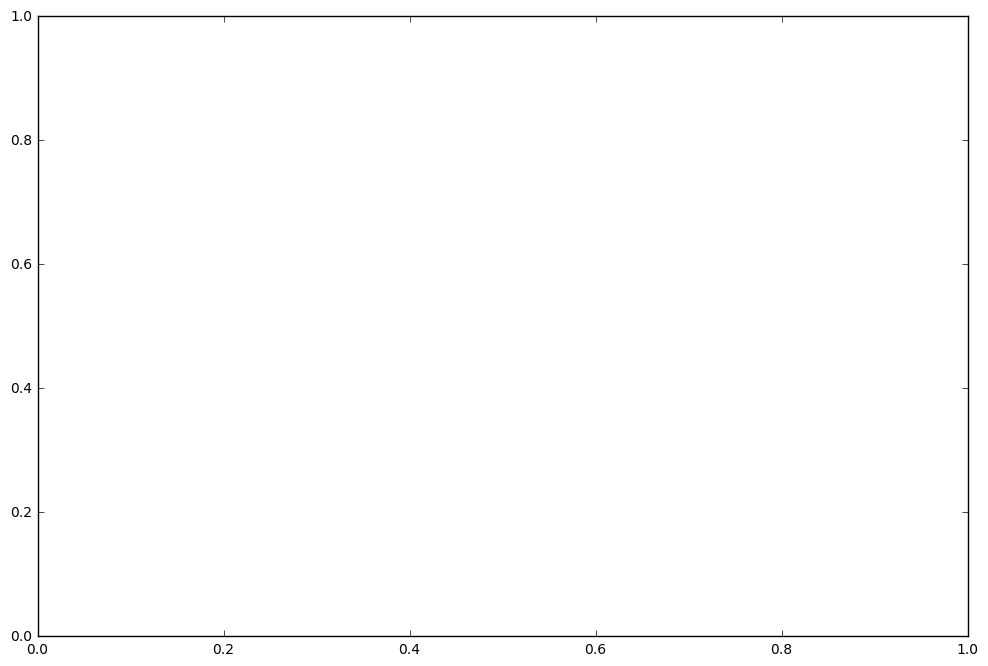

In [74]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.plot(range(0, 1000), error_statistic_test, label='BagBoo: test error, max_depth = 3, n_boo = 30')
plt.plot(range(0, 1000), error_statistic_train, label='BagBoo: train error, max_depth = 3, n_boo = 30')
# plt.plot(boo_list, skl_error, label='Sklearn DB, max_depth = 2, subsample = 1')
plt.plot(boo_list, [skl_error_100_3] * 200, label='Sklearn DB, max_depth = 3, subsample = 1')
ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Bagging iterations count')
ax.set_ylabel('MSE')

In [78]:
%%time
bagboo_spam = BagBoo(n_boo=100, n_bag=500, max_depth = 3, shrinkage=0.1)    
error_statistic_test, error_statistic_train = bagboo_spam.fit(spam_train_data, spam_train_target, verbose = 1, X_test = spam_test_data,\
                Y_test = spam_test_target)

Iteration of bagging:0/500

1
MSE on test Dataset: 0.0689171009907 Iteration of Bagging: 0 / 500
MSE on train Dataset: 0.0303960298627 Iteration of Bagging: 0 / 500
1


Iteration of bagging:1/500

MSE on test Dataset: 0.0693064154469 Iteration of Bagging: 1 / 500
MSE on train Dataset: 0.0295469019738 Iteration of Bagging: 1 / 500
1


Iteration of bagging:2/500

MSE on test Dataset: 0.0658227547086 Iteration of Bagging: 2 / 500
MSE on train Dataset: 0.0289109880155 Iteration of Bagging: 2 / 500
1


Iteration of bagging:3/500

MSE on test Dataset: 0.0634827114772 Iteration of Bagging: 3 / 500
MSE on train Dataset: 0.0286098397174 Iteration of Bagging: 3 / 500
1


Iteration of bagging:4/500

MSE on test Dataset: 0.0617401155652 Iteration of Bagging: 4 / 500
MSE on train Dataset: 0.0284066466994 Iteration of Bagging: 4 / 500
1


Iteration of bagging:5/500

MSE on test Dataset: 0.062477001213 Iteration of Bagging: 5 / 500
MSE on train Dataset: 0.0284486583624 Iteration of Bagging: 5 / 500
1


Iteration of bagging:6/500

MSE on test Dataset: 0.0620087483216 Iteration of Bagging: 6 / 500
MSE on train Dataset: 0.0283545405519 Iteration of Bagging: 6 / 500
1


Iteration of bagging:7/500

MSE on test Dataset: 0.0616752659061 Iteration of Bagging: 7 / 500
MSE on train Dataset: 0.0282083977998 Iteration of Bagging: 7 / 500
1


Iteration of bagging:8/500

MSE on test Dataset: 0.0619757625888 Iteration of Bagging: 8 / 500
MSE on train Dataset: 0.0282385419813 Iteration of Bagging: 8 / 500
1


Iteration of bagging:9/500

MSE on test Dataset: 0.0608837065314 Iteration of Bagging: 9 / 500
MSE on train Dataset: 0.0282187823373 Iteration of Bagging: 9 / 500
1


Iteration of bagging:10/500

MSE on test Dataset: 0.0610884830566 Iteration of Bagging: 10 / 500
MSE on train Dataset: 0.0282537069722 Iteration of Bagging: 10 / 500
1


Iteration of bagging:11/500

MSE on test Dataset: 0.0605389599806 Iteration of Bagging: 11 / 500
MSE on train Dataset: 0.0282545404151 Iteration of Bagging: 11 / 500
1


Iteration of bagging:12/500

MSE on test Dataset: 0.0607317200655 Iteration of Bagging: 12 / 500
MSE on train Dataset: 0.0282653536371 Iteration of Bagging: 12 / 500
1


Iteration of bagging:13/500

MSE on test Dataset: 0.0611730692836 Iteration of Bagging: 13 / 500
MSE on train Dataset: 0.0282187788228 Iteration of Bagging: 13 / 500
1


Iteration of bagging:14/500

MSE on test Dataset: 0.0610462636067 Iteration of Bagging: 14 / 500
MSE on train Dataset: 0.0282210143061 Iteration of Bagging: 14 / 500
1


Iteration of bagging:15/500

MSE on test Dataset: 0.0611415724184 Iteration of Bagging: 15 / 500
MSE on train Dataset: 0.0281449111758 Iteration of Bagging: 15 / 500
1


Iteration of bagging:16/500

MSE on test Dataset: 0.0613446241805 Iteration of Bagging: 16 / 500
MSE on train Dataset: 0.0281290895157 Iteration of Bagging: 16 / 500
1


Iteration of bagging:17/500

MSE on test Dataset: 0.0614787086023 Iteration of Bagging: 17 / 500
MSE on train Dataset: 0.0281102661694 Iteration of Bagging: 17 / 500
1


Iteration of bagging:18/500

MSE on test Dataset: 0.0615394423011 Iteration of Bagging: 18 / 500
MSE on train Dataset: 0.0281422159989 Iteration of Bagging: 18 / 500
1


Iteration of bagging:19/500

MSE on test Dataset: 0.0616122499902 Iteration of Bagging: 19 / 500
MSE on train Dataset: 0.0280965465634 Iteration of Bagging: 19 / 500
1


Iteration of bagging:20/500

MSE on test Dataset: 0.0614225174012 Iteration of Bagging: 20 / 500
MSE on train Dataset: 0.0280518614862 Iteration of Bagging: 20 / 500
1


Iteration of bagging:21/500

MSE on test Dataset: 0.0610298582854 Iteration of Bagging: 21 / 500
MSE on train Dataset: 0.0280832124066 Iteration of Bagging: 21 / 500
1


Iteration of bagging:22/500

MSE on test Dataset: 0.0614055531151 Iteration of Bagging: 22 / 500
MSE on train Dataset: 0.0280690333975 Iteration of Bagging: 22 / 500
1


Iteration of bagging:23/500

MSE on test Dataset: 0.0615836135162 Iteration of Bagging: 23 / 500
MSE on train Dataset: 0.0280637872725 Iteration of Bagging: 23 / 500
1


Iteration of bagging:24/500

MSE on test Dataset: 0.0620173669636 Iteration of Bagging: 24 / 500
MSE on train Dataset: 0.0280801507768 Iteration of Bagging: 24 / 500
1


Iteration of bagging:25/500

MSE on test Dataset: 0.0625421423507 Iteration of Bagging: 25 / 500
MSE on train Dataset: 0.0280632883661 Iteration of Bagging: 25 / 500
1


Iteration of bagging:26/500

MSE on test Dataset: 0.062342379884 Iteration of Bagging: 26 / 500
MSE on train Dataset: 0.0280416088093 Iteration of Bagging: 26 / 500
1


Iteration of bagging:27/500

MSE on test Dataset: 0.0624371515337 Iteration of Bagging: 27 / 500
MSE on train Dataset: 0.0280321503435 Iteration of Bagging: 27 / 500
1


Iteration of bagging:28/500

MSE on test Dataset: 0.0624265729194 Iteration of Bagging: 28 / 500
MSE on train Dataset: 0.0280156161265 Iteration of Bagging: 28 / 500
1


Iteration of bagging:29/500

MSE on test Dataset: 0.0624693565648 Iteration of Bagging: 29 / 500
MSE on train Dataset: 0.0280044637919 Iteration of Bagging: 29 / 500
1


Iteration of bagging:30/500

MSE on test Dataset: 0.0623669793641 Iteration of Bagging: 30 / 500
MSE on train Dataset: 0.0280036531271 Iteration of Bagging: 30 / 500
1


Iteration of bagging:31/500

MSE on test Dataset: 0.0622211928786 Iteration of Bagging: 31 / 500
MSE on train Dataset: 0.0280057422677 Iteration of Bagging: 31 / 500
1


Iteration of bagging:32/500

MSE on test Dataset: 0.0623275891351 Iteration of Bagging: 32 / 500
MSE on train Dataset: 0.0280073624741 Iteration of Bagging: 32 / 500
1


Iteration of bagging:33/500

MSE on test Dataset: 0.0621360936724 Iteration of Bagging: 33 / 500
MSE on train Dataset: 0.0280088453187 Iteration of Bagging: 33 / 500
1


Iteration of bagging:34/500

MSE on test Dataset: 0.0622342771469 Iteration of Bagging: 34 / 500
MSE on train Dataset: 0.0280105692317 Iteration of Bagging: 34 / 500
1


Iteration of bagging:35/500

MSE on test Dataset: 0.0623580630663 Iteration of Bagging: 35 / 500
MSE on train Dataset: 0.0280181508526 Iteration of Bagging: 35 / 500
1


Iteration of bagging:36/500

MSE on test Dataset: 0.0622511720302 Iteration of Bagging: 36 / 500
MSE on train Dataset: 0.028032508374 Iteration of Bagging: 36 / 500
1


Iteration of bagging:37/500

MSE on test Dataset: 0.061997109239 Iteration of Bagging: 37 / 500
MSE on train Dataset: 0.0280291471003 Iteration of Bagging: 37 / 500
1


Iteration of bagging:38/500

MSE on test Dataset: 0.0618660169359 Iteration of Bagging: 38 / 500
MSE on train Dataset: 0.0280406185611 Iteration of Bagging: 38 / 500
1


Iteration of bagging:39/500

MSE on test Dataset: 0.0619484558964 Iteration of Bagging: 39 / 500
MSE on train Dataset: 0.0280433491735 Iteration of Bagging: 39 / 500
1


Iteration of bagging:40/500

MSE on test Dataset: 0.0617765743524 Iteration of Bagging: 40 / 500
MSE on train Dataset: 0.0280369379672 Iteration of Bagging: 40 / 500
1


Iteration of bagging:41/500

MSE on test Dataset: 0.061777824785 Iteration of Bagging: 41 / 500
MSE on train Dataset: 0.0280058103227 Iteration of Bagging: 41 / 500
1


Iteration of bagging:42/500

MSE on test Dataset: 0.0617512097153 Iteration of Bagging: 42 / 500
MSE on train Dataset: 0.0280185691529 Iteration of Bagging: 42 / 500
1


Iteration of bagging:43/500

MSE on test Dataset: 0.0618402915944 Iteration of Bagging: 43 / 500
MSE on train Dataset: 0.028018270764 Iteration of Bagging: 43 / 500
1


Iteration of bagging:44/500

MSE on test Dataset: 0.0617783228573 Iteration of Bagging: 44 / 500
MSE on train Dataset: 0.028012375088 Iteration of Bagging: 44 / 500
1


Iteration of bagging:45/500

MSE on test Dataset: 0.0618712522722 Iteration of Bagging: 45 / 500
MSE on train Dataset: 0.0280012541463 Iteration of Bagging: 45 / 500
1


Iteration of bagging:46/500

MSE on test Dataset: 0.0617751489314 Iteration of Bagging: 46 / 500
MSE on train Dataset: 0.0280101048283 Iteration of Bagging: 46 / 500
1


Iteration of bagging:47/500

MSE on test Dataset: 0.0617395957456 Iteration of Bagging: 47 / 500
MSE on train Dataset: 0.0279990092182 Iteration of Bagging: 47 / 500
1


Iteration of bagging:48/500

MSE on test Dataset: 0.0617111593237 Iteration of Bagging: 48 / 500
MSE on train Dataset: 0.027990379248 Iteration of Bagging: 48 / 500
1


Iteration of bagging:49/500

MSE on test Dataset: 0.0617646712421 Iteration of Bagging: 49 / 500
MSE on train Dataset: 0.0280076781427 Iteration of Bagging: 49 / 500
1


Iteration of bagging:50/500

MSE on test Dataset: 0.0618086477832 Iteration of Bagging: 50 / 500
MSE on train Dataset: 0.0279879126329 Iteration of Bagging: 50 / 500
1


Iteration of bagging:51/500

MSE on test Dataset: 0.0617281941391 Iteration of Bagging: 51 / 500
MSE on train Dataset: 0.0279795888015 Iteration of Bagging: 51 / 500
1


Iteration of bagging:52/500

MSE on test Dataset: 0.0617204697443 Iteration of Bagging: 52 / 500
MSE on train Dataset: 0.0279877659972 Iteration of Bagging: 52 / 500
1


Iteration of bagging:53/500

MSE on test Dataset: 0.0617890770724 Iteration of Bagging: 53 / 500
MSE on train Dataset: 0.0279938448206 Iteration of Bagging: 53 / 500
1


Iteration of bagging:54/500

MSE on test Dataset: 0.0619588092669 Iteration of Bagging: 54 / 500
MSE on train Dataset: 0.0279774056597 Iteration of Bagging: 54 / 500
1


Iteration of bagging:55/500

MSE on test Dataset: 0.0619912469355 Iteration of Bagging: 55 / 500
MSE on train Dataset: 0.0279730872558 Iteration of Bagging: 55 / 500
1


Iteration of bagging:56/500

MSE on test Dataset: 0.0620135811375 Iteration of Bagging: 56 / 500
MSE on train Dataset: 0.027981788264 Iteration of Bagging: 56 / 500
1


Iteration of bagging:57/500

MSE on test Dataset: 0.0620341408215 Iteration of Bagging: 57 / 500
MSE on train Dataset: 0.0279844964043 Iteration of Bagging: 57 / 500
1


Iteration of bagging:58/500

MSE on test Dataset: 0.0618908223994 Iteration of Bagging: 58 / 500
MSE on train Dataset: 0.0279806317214 Iteration of Bagging: 58 / 500
1


Iteration of bagging:59/500

MSE on test Dataset: 0.0619172844181 Iteration of Bagging: 59 / 500
MSE on train Dataset: 0.0279805536098 Iteration of Bagging: 59 / 500
1


Iteration of bagging:60/500

MSE on test Dataset: 0.0619571648857 Iteration of Bagging: 60 / 500
MSE on train Dataset: 0.0279718602178 Iteration of Bagging: 60 / 500
1


Iteration of bagging:61/500

MSE on test Dataset: 0.0619448129647 Iteration of Bagging: 61 / 500
MSE on train Dataset: 0.0279706626965 Iteration of Bagging: 61 / 500
1


Iteration of bagging:62/500

MSE on test Dataset: 0.0619955172077 Iteration of Bagging: 62 / 500
MSE on train Dataset: 0.0279756535936 Iteration of Bagging: 62 / 500
1


Iteration of bagging:63/500

MSE on test Dataset: 0.062020904212 Iteration of Bagging: 63 / 500
MSE on train Dataset: 0.0279684801571 Iteration of Bagging: 63 / 500
1


Iteration of bagging:64/500

MSE on test Dataset: 0.0620649973887 Iteration of Bagging: 64 / 500
MSE on train Dataset: 0.027960590404 Iteration of Bagging: 64 / 500
1


Iteration of bagging:65/500

MSE on test Dataset: 0.0622203694448 Iteration of Bagging: 65 / 500
MSE on train Dataset: 0.0279632242779 Iteration of Bagging: 65 / 500
1


Iteration of bagging:66/500

MSE on test Dataset: 0.0622262762014 Iteration of Bagging: 66 / 500
MSE on train Dataset: 0.0279565625428 Iteration of Bagging: 66 / 500
1


Iteration of bagging:67/500

MSE on test Dataset: 0.0622977369991 Iteration of Bagging: 67 / 500
MSE on train Dataset: 0.0279623016692 Iteration of Bagging: 67 / 500
1


Iteration of bagging:68/500

MSE on test Dataset: 0.0621807845973 Iteration of Bagging: 68 / 500
MSE on train Dataset: 0.0279558851153 Iteration of Bagging: 68 / 500
1


Iteration of bagging:69/500

MSE on test Dataset: 0.0621481719206 Iteration of Bagging: 69 / 500
MSE on train Dataset: 0.0279461057534 Iteration of Bagging: 69 / 500
1


Iteration of bagging:70/500

MSE on test Dataset: 0.0622174971787 Iteration of Bagging: 70 / 500
MSE on train Dataset: 0.0279361014798 Iteration of Bagging: 70 / 500
1


Iteration of bagging:71/500

MSE on test Dataset: 0.0622543053387 Iteration of Bagging: 71 / 500
MSE on train Dataset: 0.0279314389764 Iteration of Bagging: 71 / 500
1


Iteration of bagging:72/500

MSE on test Dataset: 0.0621871177319 Iteration of Bagging: 72 / 500
MSE on train Dataset: 0.0279347557891 Iteration of Bagging: 72 / 500
1


Iteration of bagging:73/500

MSE on test Dataset: 0.0621675767095 Iteration of Bagging: 73 / 500
MSE on train Dataset: 0.0279410231223 Iteration of Bagging: 73 / 500
1


Iteration of bagging:74/500

MSE on test Dataset: 0.0622578974179 Iteration of Bagging: 74 / 500
MSE on train Dataset: 0.0279520043256 Iteration of Bagging: 74 / 500
1


Iteration of bagging:75/500

MSE on test Dataset: 0.062306010548 Iteration of Bagging: 75 / 500
MSE on train Dataset: 0.0279579278606 Iteration of Bagging: 75 / 500
1


Iteration of bagging:76/500

MSE on test Dataset: 0.062290543567 Iteration of Bagging: 76 / 500
MSE on train Dataset: 0.0279587655233 Iteration of Bagging: 76 / 500
1


Iteration of bagging:77/500

MSE on test Dataset: 0.062303123695 Iteration of Bagging: 77 / 500
MSE on train Dataset: 0.0279541784598 Iteration of Bagging: 77 / 500
1


Iteration of bagging:78/500

MSE on test Dataset: 0.062280183301 Iteration of Bagging: 78 / 500
MSE on train Dataset: 0.0279521794295 Iteration of Bagging: 78 / 500
1


Iteration of bagging:79/500

MSE on test Dataset: 0.0622092212496 Iteration of Bagging: 79 / 500
MSE on train Dataset: 0.0279571032179 Iteration of Bagging: 79 / 500
1


Iteration of bagging:80/500

MSE on test Dataset: 0.0621976917805 Iteration of Bagging: 80 / 500
MSE on train Dataset: 0.0279547687139 Iteration of Bagging: 80 / 500
1


Iteration of bagging:81/500

MSE on test Dataset: 0.0621111860726 Iteration of Bagging: 81 / 500
MSE on train Dataset: 0.0279521420385 Iteration of Bagging: 81 / 500
1


Iteration of bagging:82/500

MSE on test Dataset: 0.0620681036217 Iteration of Bagging: 82 / 500
MSE on train Dataset: 0.0279429876944 Iteration of Bagging: 82 / 500
1


Iteration of bagging:83/500

MSE on test Dataset: 0.0620571360743 Iteration of Bagging: 83 / 500
MSE on train Dataset: 0.027946735752 Iteration of Bagging: 83 / 500
1


Iteration of bagging:84/500

MSE on test Dataset: 0.0620215733631 Iteration of Bagging: 84 / 500
MSE on train Dataset: 0.0279484257978 Iteration of Bagging: 84 / 500
1


Iteration of bagging:85/500

MSE on test Dataset: 0.0620012634534 Iteration of Bagging: 85 / 500
MSE on train Dataset: 0.0279539698715 Iteration of Bagging: 85 / 500
1


Iteration of bagging:86/500

MSE on test Dataset: 0.0618795999293 Iteration of Bagging: 86 / 500
MSE on train Dataset: 0.0279416778277 Iteration of Bagging: 86 / 500
1


Iteration of bagging:87/500

MSE on test Dataset: 0.0618606217166 Iteration of Bagging: 87 / 500
MSE on train Dataset: 0.0279413013899 Iteration of Bagging: 87 / 500
1


Iteration of bagging:88/500

MSE on test Dataset: 0.0618897209456 Iteration of Bagging: 88 / 500
MSE on train Dataset: 0.027938072332 Iteration of Bagging: 88 / 500
1


Iteration of bagging:89/500

MSE on test Dataset: 0.0617942291831 Iteration of Bagging: 89 / 500
MSE on train Dataset: 0.0279399033517 Iteration of Bagging: 89 / 500
1


Iteration of bagging:90/500

MSE on test Dataset: 0.0616853126951 Iteration of Bagging: 90 / 500
MSE on train Dataset: 0.0279461744933 Iteration of Bagging: 90 / 500
1


Iteration of bagging:91/500

MSE on test Dataset: 0.0616905728301 Iteration of Bagging: 91 / 500
MSE on train Dataset: 0.0279400851817 Iteration of Bagging: 91 / 500
1


Iteration of bagging:92/500

MSE on test Dataset: 0.0617175313749 Iteration of Bagging: 92 / 500
MSE on train Dataset: 0.0279344451881 Iteration of Bagging: 92 / 500
1


Iteration of bagging:93/500

MSE on test Dataset: 0.0616932612216 Iteration of Bagging: 93 / 500
MSE on train Dataset: 0.0279268909961 Iteration of Bagging: 93 / 500
1


Iteration of bagging:94/500

MSE on test Dataset: 0.0617070879437 Iteration of Bagging: 94 / 500
MSE on train Dataset: 0.027927332005 Iteration of Bagging: 94 / 500
1


Iteration of bagging:95/500

MSE on test Dataset: 0.0616149797879 Iteration of Bagging: 95 / 500
MSE on train Dataset: 0.0279301188439 Iteration of Bagging: 95 / 500
1


Iteration of bagging:96/500

MSE on test Dataset: 0.0616168573934 Iteration of Bagging: 96 / 500
MSE on train Dataset: 0.0279216082452 Iteration of Bagging: 96 / 500
1


Iteration of bagging:97/500

MSE on test Dataset: 0.0616064341097 Iteration of Bagging: 97 / 500
MSE on train Dataset: 0.0279156399498 Iteration of Bagging: 97 / 500
1


Iteration of bagging:98/500

MSE on test Dataset: 0.0615960837751 Iteration of Bagging: 98 / 500
MSE on train Dataset: 0.0279194816362 Iteration of Bagging: 98 / 500
1


Iteration of bagging:99/500

MSE on test Dataset: 0.0616440864595 Iteration of Bagging: 99 / 500
MSE on train Dataset: 0.0279225701915 Iteration of Bagging: 99 / 500
1


Iteration of bagging:100/500

MSE on test Dataset: 0.0616115359386 Iteration of Bagging: 100 / 500
MSE on train Dataset: 0.0279208813419 Iteration of Bagging: 100 / 500
1


Iteration of bagging:101/500

MSE on test Dataset: 0.0617004137427 Iteration of Bagging: 101 / 500
MSE on train Dataset: 0.0279199312961 Iteration of Bagging: 101 / 500
1


Iteration of bagging:102/500

MSE on test Dataset: 0.061704603302 Iteration of Bagging: 102 / 500
MSE on train Dataset: 0.0279224734397 Iteration of Bagging: 102 / 500
1


Iteration of bagging:103/500

MSE on test Dataset: 0.0616985715174 Iteration of Bagging: 103 / 500
MSE on train Dataset: 0.027923532923 Iteration of Bagging: 103 / 500
1


Iteration of bagging:104/500

MSE on test Dataset: 0.0617219106172 Iteration of Bagging: 104 / 500
MSE on train Dataset: 0.0279276196521 Iteration of Bagging: 104 / 500
1


Iteration of bagging:105/500

MSE on test Dataset: 0.0617593150961 Iteration of Bagging: 105 / 500
MSE on train Dataset: 0.0279235216634 Iteration of Bagging: 105 / 500
1


Iteration of bagging:106/500

MSE on test Dataset: 0.0617594379493 Iteration of Bagging: 106 / 500
MSE on train Dataset: 0.0279246656993 Iteration of Bagging: 106 / 500
1


Iteration of bagging:107/500

MSE on test Dataset: 0.061813334951 Iteration of Bagging: 107 / 500
MSE on train Dataset: 0.0279295376608 Iteration of Bagging: 107 / 500
1


Iteration of bagging:108/500

MSE on test Dataset: 0.0618757530299 Iteration of Bagging: 108 / 500
MSE on train Dataset: 0.0279327019895 Iteration of Bagging: 108 / 500
1


Iteration of bagging:109/500

MSE on test Dataset: 0.0618790948066 Iteration of Bagging: 109 / 500
MSE on train Dataset: 0.0279328545419 Iteration of Bagging: 109 / 500
1


Iteration of bagging:110/500

MSE on test Dataset: 0.0618958446876 Iteration of Bagging: 110 / 500
MSE on train Dataset: 0.027926959726 Iteration of Bagging: 110 / 500
1


Iteration of bagging:111/500

MSE on test Dataset: 0.0619545234925 Iteration of Bagging: 111 / 500
MSE on train Dataset: 0.0279237162267 Iteration of Bagging: 111 / 500
1


Iteration of bagging:112/500

MSE on test Dataset: 0.0619329307413 Iteration of Bagging: 112 / 500
MSE on train Dataset: 0.0279267494619 Iteration of Bagging: 112 / 500
1


Iteration of bagging:113/500

MSE on test Dataset: 0.0619601298856 Iteration of Bagging: 113 / 500
MSE on train Dataset: 0.027920443504 Iteration of Bagging: 113 / 500
1


Iteration of bagging:114/500

MSE on test Dataset: 0.0619254902408 Iteration of Bagging: 114 / 500
MSE on train Dataset: 0.0279233874144 Iteration of Bagging: 114 / 500
1


Iteration of bagging:115/500

MSE on test Dataset: 0.0618822886396 Iteration of Bagging: 115 / 500
MSE on train Dataset: 0.0279179252168 Iteration of Bagging: 115 / 500
1


Iteration of bagging:116/500

MSE on test Dataset: 0.061885950686 Iteration of Bagging: 116 / 500
MSE on train Dataset: 0.027924047657 Iteration of Bagging: 116 / 500
1


Iteration of bagging:117/500

MSE on test Dataset: 0.061876225763 Iteration of Bagging: 117 / 500
MSE on train Dataset: 0.0279258103443 Iteration of Bagging: 117 / 500
1


Iteration of bagging:118/500

MSE on test Dataset: 0.0618702388107 Iteration of Bagging: 118 / 500
MSE on train Dataset: 0.0279221744902 Iteration of Bagging: 118 / 500
1


Iteration of bagging:119/500

MSE on test Dataset: 0.061852049622 Iteration of Bagging: 119 / 500
MSE on train Dataset: 0.0279211489884 Iteration of Bagging: 119 / 500
1


Iteration of bagging:120/500

MSE on test Dataset: 0.0618747007716 Iteration of Bagging: 120 / 500
MSE on train Dataset: 0.0279278909536 Iteration of Bagging: 120 / 500
1


Iteration of bagging:121/500

MSE on test Dataset: 0.0618119055791 Iteration of Bagging: 121 / 500
MSE on train Dataset: 0.0279305495639 Iteration of Bagging: 121 / 500
1


Iteration of bagging:122/500

MSE on test Dataset: 0.0617775447339 Iteration of Bagging: 122 / 500
MSE on train Dataset: 0.0279238446126 Iteration of Bagging: 122 / 500
1


Iteration of bagging:123/500

MSE on test Dataset: 0.0617797040884 Iteration of Bagging: 123 / 500
MSE on train Dataset: 0.0279202348588 Iteration of Bagging: 123 / 500
1


Iteration of bagging:124/500

MSE on test Dataset: 0.0617524196879 Iteration of Bagging: 124 / 500
MSE on train Dataset: 0.0279217424188 Iteration of Bagging: 124 / 500
1


Iteration of bagging:125/500

MSE on test Dataset: 0.0617007558125 Iteration of Bagging: 125 / 500
MSE on train Dataset: 0.0279190991719 Iteration of Bagging: 125 / 500
1


Iteration of bagging:126/500

MSE on test Dataset: 0.0616912340642 Iteration of Bagging: 126 / 500
MSE on train Dataset: 0.0279177837734 Iteration of Bagging: 126 / 500
1


Iteration of bagging:127/500

MSE on test Dataset: 0.0617203551062 Iteration of Bagging: 127 / 500
MSE on train Dataset: 0.0279176036555 Iteration of Bagging: 127 / 500
1


Iteration of bagging:128/500

MSE on test Dataset: 0.061710268321 Iteration of Bagging: 128 / 500
MSE on train Dataset: 0.0279098863016 Iteration of Bagging: 128 / 500
1


Iteration of bagging:129/500

MSE on test Dataset: 0.061651580023 Iteration of Bagging: 129 / 500
MSE on train Dataset: 0.0279050943606 Iteration of Bagging: 129 / 500
1


Iteration of bagging:130/500

MSE on test Dataset: 0.0616055734186 Iteration of Bagging: 130 / 500
MSE on train Dataset: 0.0278977137579 Iteration of Bagging: 130 / 500
1


Iteration of bagging:131/500

MSE on test Dataset: 0.061666127251 Iteration of Bagging: 131 / 500
MSE on train Dataset: 0.0278995400111 Iteration of Bagging: 131 / 500
1


Iteration of bagging:132/500

MSE on test Dataset: 0.0616618110637 Iteration of Bagging: 132 / 500
MSE on train Dataset: 0.0279023072428 Iteration of Bagging: 132 / 500
1


Iteration of bagging:133/500

MSE on test Dataset: 0.0616189779405 Iteration of Bagging: 133 / 500
MSE on train Dataset: 0.0279036932147 Iteration of Bagging: 133 / 500
1


Iteration of bagging:134/500

MSE on test Dataset: 0.0616022135969 Iteration of Bagging: 134 / 500
MSE on train Dataset: 0.0279009799772 Iteration of Bagging: 134 / 500
1


Iteration of bagging:135/500

MSE on test Dataset: 0.061613766573 Iteration of Bagging: 135 / 500
MSE on train Dataset: 0.0278990446462 Iteration of Bagging: 135 / 500
1


Iteration of bagging:136/500

MSE on test Dataset: 0.0616059116577 Iteration of Bagging: 136 / 500
MSE on train Dataset: 0.027898554519 Iteration of Bagging: 136 / 500
1


Iteration of bagging:137/500

MSE on test Dataset: 0.0616067796151 Iteration of Bagging: 137 / 500
MSE on train Dataset: 0.0278906076198 Iteration of Bagging: 137 / 500
1


Iteration of bagging:138/500

MSE on test Dataset: 0.0616584745696 Iteration of Bagging: 138 / 500
MSE on train Dataset: 0.0278894300492 Iteration of Bagging: 138 / 500
1


Iteration of bagging:139/500

MSE on test Dataset: 0.0616880468193 Iteration of Bagging: 139 / 500
MSE on train Dataset: 0.0278891468603 Iteration of Bagging: 139 / 500
1


Iteration of bagging:140/500

MSE on test Dataset: 0.0617175922333 Iteration of Bagging: 140 / 500
MSE on train Dataset: 0.0278944793885 Iteration of Bagging: 140 / 500
1


Iteration of bagging:141/500

MSE on test Dataset: 0.0617349914545 Iteration of Bagging: 141 / 500
MSE on train Dataset: 0.0278940860875 Iteration of Bagging: 141 / 500
1


Iteration of bagging:142/500

MSE on test Dataset: 0.0617700462646 Iteration of Bagging: 142 / 500
MSE on train Dataset: 0.0278936331195 Iteration of Bagging: 142 / 500
1


Iteration of bagging:143/500

MSE on test Dataset: 0.0617557408081 Iteration of Bagging: 143 / 500
MSE on train Dataset: 0.0278953797645 Iteration of Bagging: 143 / 500
1


Iteration of bagging:144/500

MSE on test Dataset: 0.0617746765719 Iteration of Bagging: 144 / 500
MSE on train Dataset: 0.0278939885841 Iteration of Bagging: 144 / 500
1


Iteration of bagging:145/500

MSE on test Dataset: 0.0618063945519 Iteration of Bagging: 145 / 500
MSE on train Dataset: 0.0278906259047 Iteration of Bagging: 145 / 500
1


Iteration of bagging:146/500

MSE on test Dataset: 0.0617709692643 Iteration of Bagging: 146 / 500
MSE on train Dataset: 0.0278895034624 Iteration of Bagging: 146 / 500
1


Iteration of bagging:147/500

MSE on test Dataset: 0.0617620497271 Iteration of Bagging: 147 / 500
MSE on train Dataset: 0.0278892618989 Iteration of Bagging: 147 / 500
1


Iteration of bagging:148/500

MSE on test Dataset: 0.061749489173 Iteration of Bagging: 148 / 500
MSE on train Dataset: 0.0278891479783 Iteration of Bagging: 148 / 500
1


Iteration of bagging:149/500

MSE on test Dataset: 0.0617392016874 Iteration of Bagging: 149 / 500
MSE on train Dataset: 0.0278889214221 Iteration of Bagging: 149 / 500
1


Iteration of bagging:150/500

MSE on test Dataset: 0.061701343827 Iteration of Bagging: 150 / 500
MSE on train Dataset: 0.0278864719005 Iteration of Bagging: 150 / 500
1


Iteration of bagging:151/500

MSE on test Dataset: 0.0617280954746 Iteration of Bagging: 151 / 500
MSE on train Dataset: 0.0278795063305 Iteration of Bagging: 151 / 500
1


Iteration of bagging:152/500

MSE on test Dataset: 0.0617111999222 Iteration of Bagging: 152 / 500
MSE on train Dataset: 0.0278812230391 Iteration of Bagging: 152 / 500
1


Iteration of bagging:153/500

MSE on test Dataset: 0.0617404096622 Iteration of Bagging: 153 / 500
MSE on train Dataset: 0.0278823876514 Iteration of Bagging: 153 / 500
1


Iteration of bagging:154/500

MSE on test Dataset: 0.061706050506 Iteration of Bagging: 154 / 500
MSE on train Dataset: 0.027884178705 Iteration of Bagging: 154 / 500
1


Iteration of bagging:155/500

MSE on test Dataset: 0.0617309281841 Iteration of Bagging: 155 / 500
MSE on train Dataset: 0.02788777807 Iteration of Bagging: 155 / 500
1


Iteration of bagging:156/500

MSE on test Dataset: 0.0617340462359 Iteration of Bagging: 156 / 500
MSE on train Dataset: 0.027882218572 Iteration of Bagging: 156 / 500
1


Iteration of bagging:157/500

MSE on test Dataset: 0.0617887462887 Iteration of Bagging: 157 / 500
MSE on train Dataset: 0.0278821852274 Iteration of Bagging: 157 / 500
1


Iteration of bagging:158/500

MSE on test Dataset: 0.0617841030341 Iteration of Bagging: 158 / 500
MSE on train Dataset: 0.0278795053033 Iteration of Bagging: 158 / 500
1


Iteration of bagging:159/500

MSE on test Dataset: 0.0618215709606 Iteration of Bagging: 159 / 500
MSE on train Dataset: 0.0278820541331 Iteration of Bagging: 159 / 500
1


Iteration of bagging:160/500

MSE on test Dataset: 0.061807180652 Iteration of Bagging: 160 / 500
MSE on train Dataset: 0.0278827066215 Iteration of Bagging: 160 / 500
1


Iteration of bagging:161/500

MSE on test Dataset: 0.0618076682337 Iteration of Bagging: 161 / 500
MSE on train Dataset: 0.0278826514355 Iteration of Bagging: 161 / 500
1


Iteration of bagging:162/500

MSE on test Dataset: 0.0618005062427 Iteration of Bagging: 162 / 500
MSE on train Dataset: 0.0278801592519 Iteration of Bagging: 162 / 500
1


Iteration of bagging:163/500

MSE on test Dataset: 0.0618124263017 Iteration of Bagging: 163 / 500
MSE on train Dataset: 0.0278778018796 Iteration of Bagging: 163 / 500
1


Iteration of bagging:164/500

MSE on test Dataset: 0.0618094913518 Iteration of Bagging: 164 / 500
MSE on train Dataset: 0.0278746157248 Iteration of Bagging: 164 / 500
1


Iteration of bagging:165/500

MSE on test Dataset: 0.0618466992314 Iteration of Bagging: 165 / 500
MSE on train Dataset: 0.0278772251479 Iteration of Bagging: 165 / 500
1


Iteration of bagging:166/500

MSE on test Dataset: 0.0618720931859 Iteration of Bagging: 166 / 500
MSE on train Dataset: 0.0278731943262 Iteration of Bagging: 166 / 500
1


Iteration of bagging:167/500

MSE on test Dataset: 0.0618147656829 Iteration of Bagging: 167 / 500
MSE on train Dataset: 0.0278725218804 Iteration of Bagging: 167 / 500
1


Iteration of bagging:168/500

MSE on test Dataset: 0.0618535213697 Iteration of Bagging: 168 / 500
MSE on train Dataset: 0.0278720982717 Iteration of Bagging: 168 / 500
1


Iteration of bagging:169/500

MSE on test Dataset: 0.0618371619663 Iteration of Bagging: 169 / 500
MSE on train Dataset: 0.0278692906603 Iteration of Bagging: 169 / 500
1


Iteration of bagging:170/500

MSE on test Dataset: 0.0618342795323 Iteration of Bagging: 170 / 500
MSE on train Dataset: 0.0278703180723 Iteration of Bagging: 170 / 500
1


Iteration of bagging:171/500

MSE on test Dataset: 0.0618273633909 Iteration of Bagging: 171 / 500
MSE on train Dataset: 0.0278722688065 Iteration of Bagging: 171 / 500
1


Iteration of bagging:172/500

MSE on test Dataset: 0.0618769765846 Iteration of Bagging: 172 / 500
MSE on train Dataset: 0.0278736562233 Iteration of Bagging: 172 / 500
1


Iteration of bagging:173/500

MSE on test Dataset: 0.0619046005777 Iteration of Bagging: 173 / 500
MSE on train Dataset: 0.02787573287 Iteration of Bagging: 173 / 500
1


Iteration of bagging:174/500

MSE on test Dataset: 0.0619222962174 Iteration of Bagging: 174 / 500
MSE on train Dataset: 0.0278767382843 Iteration of Bagging: 174 / 500
1


Iteration of bagging:175/500

MSE on test Dataset: 0.0619494330208 Iteration of Bagging: 175 / 500
MSE on train Dataset: 0.0278767582346 Iteration of Bagging: 175 / 500
1


Iteration of bagging:176/500

MSE on test Dataset: 0.0619218799397 Iteration of Bagging: 176 / 500
MSE on train Dataset: 0.0278746016191 Iteration of Bagging: 176 / 500
1


Iteration of bagging:177/500

MSE on test Dataset: 0.0619299383848 Iteration of Bagging: 177 / 500
MSE on train Dataset: 0.0278751495793 Iteration of Bagging: 177 / 500
1


Iteration of bagging:178/500

MSE on test Dataset: 0.0619333351844 Iteration of Bagging: 178 / 500
MSE on train Dataset: 0.0278735931016 Iteration of Bagging: 178 / 500
1


Iteration of bagging:179/500

MSE on test Dataset: 0.0619432041634 Iteration of Bagging: 179 / 500
MSE on train Dataset: 0.027873185736 Iteration of Bagging: 179 / 500
1


Iteration of bagging:180/500

MSE on test Dataset: 0.0619610196762 Iteration of Bagging: 180 / 500
MSE on train Dataset: 0.0278705370285 Iteration of Bagging: 180 / 500
1


Iteration of bagging:181/500

MSE on test Dataset: 0.0620087313197 Iteration of Bagging: 181 / 500
MSE on train Dataset: 0.0278680463905 Iteration of Bagging: 181 / 500
1


Iteration of bagging:182/500

MSE on test Dataset: 0.0619605943245 Iteration of Bagging: 182 / 500
MSE on train Dataset: 0.0278709254666 Iteration of Bagging: 182 / 500
1


Iteration of bagging:183/500

MSE on test Dataset: 0.0619615402367 Iteration of Bagging: 183 / 500
MSE on train Dataset: 0.0278683830441 Iteration of Bagging: 183 / 500
1


Iteration of bagging:184/500

MSE on test Dataset: 0.0619915201292 Iteration of Bagging: 184 / 500
MSE on train Dataset: 0.0278603550306 Iteration of Bagging: 184 / 500
1


Iteration of bagging:185/500

MSE on test Dataset: 0.0620037111019 Iteration of Bagging: 185 / 500
MSE on train Dataset: 0.0278633295426 Iteration of Bagging: 185 / 500
1


Iteration of bagging:186/500

MSE on test Dataset: 0.0620791532404 Iteration of Bagging: 186 / 500
MSE on train Dataset: 0.0278617763901 Iteration of Bagging: 186 / 500
1


Iteration of bagging:187/500

MSE on test Dataset: 0.06206692737 Iteration of Bagging: 187 / 500
MSE on train Dataset: 0.0278597589539 Iteration of Bagging: 187 / 500
1


Iteration of bagging:188/500

MSE on test Dataset: 0.0620617461791 Iteration of Bagging: 188 / 500
MSE on train Dataset: 0.027860953445 Iteration of Bagging: 188 / 500
1


Iteration of bagging:189/500

MSE on test Dataset: 0.0620749065368 Iteration of Bagging: 189 / 500
MSE on train Dataset: 0.0278581764974 Iteration of Bagging: 189 / 500
1


Iteration of bagging:190/500

MSE on test Dataset: 0.0620910422198 Iteration of Bagging: 190 / 500
MSE on train Dataset: 0.0278601689314 Iteration of Bagging: 190 / 500
1


Iteration of bagging:191/500

MSE on test Dataset: 0.0620745170183 Iteration of Bagging: 191 / 500
MSE on train Dataset: 0.0278590234234 Iteration of Bagging: 191 / 500
1


Iteration of bagging:192/500

MSE on test Dataset: 0.0621096811637 Iteration of Bagging: 192 / 500
MSE on train Dataset: 0.0278534094062 Iteration of Bagging: 192 / 500
1


Iteration of bagging:193/500

MSE on test Dataset: 0.0621062164819 Iteration of Bagging: 193 / 500
MSE on train Dataset: 0.0278522799913 Iteration of Bagging: 193 / 500
1


Iteration of bagging:194/500

MSE on test Dataset: 0.0620876293658 Iteration of Bagging: 194 / 500
MSE on train Dataset: 0.0278565712166 Iteration of Bagging: 194 / 500
1


Iteration of bagging:195/500

MSE on test Dataset: 0.0620485070707 Iteration of Bagging: 195 / 500
MSE on train Dataset: 0.0278540765702 Iteration of Bagging: 195 / 500
1


Iteration of bagging:196/500

MSE on test Dataset: 0.0620209263974 Iteration of Bagging: 196 / 500
MSE on train Dataset: 0.0278588056131 Iteration of Bagging: 196 / 500
1


Iteration of bagging:197/500

MSE on test Dataset: 0.0619851683642 Iteration of Bagging: 197 / 500
MSE on train Dataset: 0.0278583031292 Iteration of Bagging: 197 / 500
1


Iteration of bagging:198/500

MSE on test Dataset: 0.0619380704923 Iteration of Bagging: 198 / 500
MSE on train Dataset: 0.0278549788625 Iteration of Bagging: 198 / 500
1


Iteration of bagging:199/500

MSE on test Dataset: 0.0619189766185 Iteration of Bagging: 199 / 500
MSE on train Dataset: 0.0278569453113 Iteration of Bagging: 199 / 500
1


Iteration of bagging:200/500

MSE on test Dataset: 0.0619124162167 Iteration of Bagging: 200 / 500
MSE on train Dataset: 0.027858688585 Iteration of Bagging: 200 / 500
1


Iteration of bagging:201/500

MSE on test Dataset: 0.0619272788518 Iteration of Bagging: 201 / 500
MSE on train Dataset: 0.0278600903596 Iteration of Bagging: 201 / 500
1


Iteration of bagging:202/500

MSE on test Dataset: 0.0619190386464 Iteration of Bagging: 202 / 500
MSE on train Dataset: 0.0278614646748 Iteration of Bagging: 202 / 500
1


Iteration of bagging:203/500

MSE on test Dataset: 0.0619332165385 Iteration of Bagging: 203 / 500
MSE on train Dataset: 0.0278617205334 Iteration of Bagging: 203 / 500
1


Iteration of bagging:204/500

MSE on test Dataset: 0.0619664448082 Iteration of Bagging: 204 / 500
MSE on train Dataset: 0.0278628803628 Iteration of Bagging: 204 / 500
1


Iteration of bagging:205/500

MSE on test Dataset: 0.0619272026404 Iteration of Bagging: 205 / 500
MSE on train Dataset: 0.0278629497304 Iteration of Bagging: 205 / 500
1


Iteration of bagging:206/500

MSE on test Dataset: 0.0619231068761 Iteration of Bagging: 206 / 500
MSE on train Dataset: 0.0278637792943 Iteration of Bagging: 206 / 500
1


Iteration of bagging:207/500

MSE on test Dataset: 0.061937952476 Iteration of Bagging: 207 / 500
MSE on train Dataset: 0.0278684847651 Iteration of Bagging: 207 / 500
1


Iteration of bagging:208/500

MSE on test Dataset: 0.0619615193791 Iteration of Bagging: 208 / 500
MSE on train Dataset: 0.0278683237033 Iteration of Bagging: 208 / 500
1


Iteration of bagging:209/500

MSE on test Dataset: 0.0620002730168 Iteration of Bagging: 209 / 500
MSE on train Dataset: 0.0278690675701 Iteration of Bagging: 209 / 500
1


Iteration of bagging:210/500

MSE on test Dataset: 0.0620318491215 Iteration of Bagging: 210 / 500
MSE on train Dataset: 0.0278729945591 Iteration of Bagging: 210 / 500
1


Iteration of bagging:211/500

MSE on test Dataset: 0.0620256152286 Iteration of Bagging: 211 / 500
MSE on train Dataset: 0.0278692777945 Iteration of Bagging: 211 / 500
1


Iteration of bagging:212/500

MSE on test Dataset: 0.062010399907 Iteration of Bagging: 212 / 500
MSE on train Dataset: 0.0278649178533 Iteration of Bagging: 212 / 500
1


Iteration of bagging:213/500

MSE on test Dataset: 0.0620149794868 Iteration of Bagging: 213 / 500
MSE on train Dataset: 0.0278651000791 Iteration of Bagging: 213 / 500
1


Iteration of bagging:214/500

MSE on test Dataset: 0.0619820591731 Iteration of Bagging: 214 / 500
MSE on train Dataset: 0.0278676313903 Iteration of Bagging: 214 / 500
1


Iteration of bagging:215/500

MSE on test Dataset: 0.0619814918311 Iteration of Bagging: 215 / 500
MSE on train Dataset: 0.0278668197702 Iteration of Bagging: 215 / 500
1


Iteration of bagging:216/500

MSE on test Dataset: 0.0620073416442 Iteration of Bagging: 216 / 500
MSE on train Dataset: 0.0278685160191 Iteration of Bagging: 216 / 500
1


Iteration of bagging:217/500

MSE on test Dataset: 0.0620272335699 Iteration of Bagging: 217 / 500
MSE on train Dataset: 0.0278683330862 Iteration of Bagging: 217 / 500
1


Iteration of bagging:218/500

MSE on test Dataset: 0.0619953539574 Iteration of Bagging: 218 / 500
MSE on train Dataset: 0.027866182175 Iteration of Bagging: 218 / 500
1


Iteration of bagging:219/500

MSE on test Dataset: 0.0619607577432 Iteration of Bagging: 219 / 500
MSE on train Dataset: 0.0278667574761 Iteration of Bagging: 219 / 500
1


Iteration of bagging:220/500

MSE on test Dataset: 0.0619308995423 Iteration of Bagging: 220 / 500
MSE on train Dataset: 0.027868105646 Iteration of Bagging: 220 / 500
1


Iteration of bagging:221/500

MSE on test Dataset: 0.0619586325518 Iteration of Bagging: 221 / 500
MSE on train Dataset: 0.0278651392266 Iteration of Bagging: 221 / 500
1


Iteration of bagging:222/500

MSE on test Dataset: 0.0619473263191 Iteration of Bagging: 222 / 500
MSE on train Dataset: 0.0278633441147 Iteration of Bagging: 222 / 500
1


Iteration of bagging:223/500

MSE on test Dataset: 0.0619623031788 Iteration of Bagging: 223 / 500
MSE on train Dataset: 0.0278662954711 Iteration of Bagging: 223 / 500
1


Iteration of bagging:224/500

MSE on test Dataset: 0.0619859164876 Iteration of Bagging: 224 / 500
MSE on train Dataset: 0.027868326337 Iteration of Bagging: 224 / 500
1


Iteration of bagging:225/500

MSE on test Dataset: 0.0620126919562 Iteration of Bagging: 225 / 500
MSE on train Dataset: 0.0278667050528 Iteration of Bagging: 225 / 500
1


Iteration of bagging:226/500

MSE on test Dataset: 0.0620110978762 Iteration of Bagging: 226 / 500
MSE on train Dataset: 0.0278659045018 Iteration of Bagging: 226 / 500
1


Iteration of bagging:227/500

MSE on test Dataset: 0.0620309209851 Iteration of Bagging: 227 / 500
MSE on train Dataset: 0.0278643429411 Iteration of Bagging: 227 / 500
1


Iteration of bagging:228/500

MSE on test Dataset: 0.0620209764159 Iteration of Bagging: 228 / 500
MSE on train Dataset: 0.0278658437425 Iteration of Bagging: 228 / 500
1


Iteration of bagging:229/500

MSE on test Dataset: 0.0620211852108 Iteration of Bagging: 229 / 500
MSE on train Dataset: 0.0278680242628 Iteration of Bagging: 229 / 500
1


Iteration of bagging:230/500

MSE on test Dataset: 0.062049508931 Iteration of Bagging: 230 / 500
MSE on train Dataset: 0.0278677629863 Iteration of Bagging: 230 / 500
1


Iteration of bagging:231/500

MSE on test Dataset: 0.0620922241217 Iteration of Bagging: 231 / 500
MSE on train Dataset: 0.0278664403285 Iteration of Bagging: 231 / 500
1


Iteration of bagging:232/500

MSE on test Dataset: 0.0621529292992 Iteration of Bagging: 232 / 500
MSE on train Dataset: 0.0278633948563 Iteration of Bagging: 232 / 500
1


Iteration of bagging:233/500

MSE on test Dataset: 0.0621525384014 Iteration of Bagging: 233 / 500
MSE on train Dataset: 0.0278667460581 Iteration of Bagging: 233 / 500
1


Iteration of bagging:234/500

MSE on test Dataset: 0.0621517634465 Iteration of Bagging: 234 / 500
MSE on train Dataset: 0.0278689521207 Iteration of Bagging: 234 / 500
1


Iteration of bagging:235/500

MSE on test Dataset: 0.0620945387327 Iteration of Bagging: 235 / 500
MSE on train Dataset: 0.0278739980012 Iteration of Bagging: 235 / 500
1


Iteration of bagging:236/500

MSE on test Dataset: 0.0620741399751 Iteration of Bagging: 236 / 500
MSE on train Dataset: 0.0278763160568 Iteration of Bagging: 236 / 500
1


Iteration of bagging:237/500

MSE on test Dataset: 0.062095173305 Iteration of Bagging: 237 / 500
MSE on train Dataset: 0.0278779046996 Iteration of Bagging: 237 / 500
1


Iteration of bagging:238/500

MSE on test Dataset: 0.0621060934777 Iteration of Bagging: 238 / 500
MSE on train Dataset: 0.027873350885 Iteration of Bagging: 238 / 500
1


Iteration of bagging:239/500

MSE on test Dataset: 0.0621043083862 Iteration of Bagging: 239 / 500
MSE on train Dataset: 0.0278707779137 Iteration of Bagging: 239 / 500
1


Iteration of bagging:240/500

MSE on test Dataset: 0.062110834618 Iteration of Bagging: 240 / 500
MSE on train Dataset: 0.0278727998119 Iteration of Bagging: 240 / 500
1


Iteration of bagging:241/500

MSE on test Dataset: 0.0620897105356 Iteration of Bagging: 241 / 500
MSE on train Dataset: 0.0278749568347 Iteration of Bagging: 241 / 500
1


Iteration of bagging:242/500

MSE on test Dataset: 0.0621182839472 Iteration of Bagging: 242 / 500
MSE on train Dataset: 0.0278754491224 Iteration of Bagging: 242 / 500
1


Iteration of bagging:243/500

MSE on test Dataset: 0.0621721644431 Iteration of Bagging: 243 / 500
MSE on train Dataset: 0.0278785505604 Iteration of Bagging: 243 / 500
1


Iteration of bagging:244/500

MSE on test Dataset: 0.0621672324624 Iteration of Bagging: 244 / 500
MSE on train Dataset: 0.0278745026418 Iteration of Bagging: 244 / 500
1


Iteration of bagging:245/500

MSE on test Dataset: 0.0621774268206 Iteration of Bagging: 245 / 500
MSE on train Dataset: 0.0278740760475 Iteration of Bagging: 245 / 500
1


Iteration of bagging:246/500

MSE on test Dataset: 0.0621703083714 Iteration of Bagging: 246 / 500
MSE on train Dataset: 0.0278733961556 Iteration of Bagging: 246 / 500
1


Iteration of bagging:247/500

MSE on test Dataset: 0.0621469724073 Iteration of Bagging: 247 / 500
MSE on train Dataset: 0.027869261401 Iteration of Bagging: 247 / 500
1


Iteration of bagging:248/500

MSE on test Dataset: 0.0621258401252 Iteration of Bagging: 248 / 500
MSE on train Dataset: 0.0278669950988 Iteration of Bagging: 248 / 500
1


Iteration of bagging:249/500

MSE on test Dataset: 0.0621027724803 Iteration of Bagging: 249 / 500
MSE on train Dataset: 0.0278674182646 Iteration of Bagging: 249 / 500
1


Iteration of bagging:250/500

MSE on test Dataset: 0.0620986749724 Iteration of Bagging: 250 / 500
MSE on train Dataset: 0.0278691852507 Iteration of Bagging: 250 / 500
1


Iteration of bagging:251/500

MSE on test Dataset: 0.062083569352 Iteration of Bagging: 251 / 500
MSE on train Dataset: 0.0278658657011 Iteration of Bagging: 251 / 500
1


Iteration of bagging:252/500

MSE on test Dataset: 0.0620662956262 Iteration of Bagging: 252 / 500
MSE on train Dataset: 0.0278635529978 Iteration of Bagging: 252 / 500
1


Iteration of bagging:253/500

MSE on test Dataset: 0.0621115011327 Iteration of Bagging: 253 / 500
MSE on train Dataset: 0.0278631609351 Iteration of Bagging: 253 / 500
1


Iteration of bagging:254/500

MSE on test Dataset: 0.0621127230537 Iteration of Bagging: 254 / 500
MSE on train Dataset: 0.0278614320896 Iteration of Bagging: 254 / 500
1


Iteration of bagging:255/500

MSE on test Dataset: 0.0620845972417 Iteration of Bagging: 255 / 500
MSE on train Dataset: 0.0278593441183 Iteration of Bagging: 255 / 500
1


Iteration of bagging:256/500

MSE on test Dataset: 0.0620725284601 Iteration of Bagging: 256 / 500
MSE on train Dataset: 0.0278566982892 Iteration of Bagging: 256 / 500
1


Iteration of bagging:257/500

MSE on test Dataset: 0.0620513479925 Iteration of Bagging: 257 / 500
MSE on train Dataset: 0.0278568913589 Iteration of Bagging: 257 / 500
1


Iteration of bagging:258/500

MSE on test Dataset: 0.0620090828197 Iteration of Bagging: 258 / 500
MSE on train Dataset: 0.027854170941 Iteration of Bagging: 258 / 500
1


Iteration of bagging:259/500

MSE on test Dataset: 0.0620151569468 Iteration of Bagging: 259 / 500
MSE on train Dataset: 0.0278568610397 Iteration of Bagging: 259 / 500
1


Iteration of bagging:260/500

MSE on test Dataset: 0.0620280424101 Iteration of Bagging: 260 / 500
MSE on train Dataset: 0.027856623987 Iteration of Bagging: 260 / 500
1


Iteration of bagging:261/500

MSE on test Dataset: 0.0620234606919 Iteration of Bagging: 261 / 500
MSE on train Dataset: 0.0278596148363 Iteration of Bagging: 261 / 500
1


Iteration of bagging:262/500

MSE on test Dataset: 0.06202401989 Iteration of Bagging: 262 / 500
MSE on train Dataset: 0.0278563589931 Iteration of Bagging: 262 / 500
1


Iteration of bagging:263/500

MSE on test Dataset: 0.0620613706364 Iteration of Bagging: 263 / 500
MSE on train Dataset: 0.027856976468 Iteration of Bagging: 263 / 500
1


Iteration of bagging:264/500

MSE on test Dataset: 0.0620501382171 Iteration of Bagging: 264 / 500
MSE on train Dataset: 0.0278569175579 Iteration of Bagging: 264 / 500
1


Iteration of bagging:265/500

MSE on test Dataset: 0.0620587422029 Iteration of Bagging: 265 / 500
MSE on train Dataset: 0.0278587822361 Iteration of Bagging: 265 / 500
1


Iteration of bagging:266/500

MSE on test Dataset: 0.0620263027448 Iteration of Bagging: 266 / 500
MSE on train Dataset: 0.0278587040186 Iteration of Bagging: 266 / 500
1


Iteration of bagging:267/500

MSE on test Dataset: 0.0620245720257 Iteration of Bagging: 267 / 500
MSE on train Dataset: 0.0278613366607 Iteration of Bagging: 267 / 500
1


Iteration of bagging:268/500

MSE on test Dataset: 0.0620157317289 Iteration of Bagging: 268 / 500
MSE on train Dataset: 0.0278609104128 Iteration of Bagging: 268 / 500
1


Iteration of bagging:269/500

MSE on test Dataset: 0.0620197785222 Iteration of Bagging: 269 / 500
MSE on train Dataset: 0.0278623078274 Iteration of Bagging: 269 / 500
1


Iteration of bagging:270/500

MSE on test Dataset: 0.062019000351 Iteration of Bagging: 270 / 500
MSE on train Dataset: 0.0278612949425 Iteration of Bagging: 270 / 500
1


Iteration of bagging:271/500

MSE on test Dataset: 0.0620453348761 Iteration of Bagging: 271 / 500
MSE on train Dataset: 0.0278629944361 Iteration of Bagging: 271 / 500
1


Iteration of bagging:272/500

MSE on test Dataset: 0.0620276963725 Iteration of Bagging: 272 / 500
MSE on train Dataset: 0.0278636863188 Iteration of Bagging: 272 / 500
1


Iteration of bagging:273/500

MSE on test Dataset: 0.0620319706681 Iteration of Bagging: 273 / 500
MSE on train Dataset: 0.0278642419949 Iteration of Bagging: 273 / 500
1


Iteration of bagging:274/500

MSE on test Dataset: 0.0620227803099 Iteration of Bagging: 274 / 500
MSE on train Dataset: 0.0278636228943 Iteration of Bagging: 274 / 500
1


Iteration of bagging:275/500

MSE on test Dataset: 0.0620020182953 Iteration of Bagging: 275 / 500
MSE on train Dataset: 0.0278623292953 Iteration of Bagging: 275 / 500
1


Iteration of bagging:276/500

MSE on test Dataset: 0.0620216196815 Iteration of Bagging: 276 / 500
MSE on train Dataset: 0.0278644882264 Iteration of Bagging: 276 / 500
1


Iteration of bagging:277/500

MSE on test Dataset: 0.0619938607744 Iteration of Bagging: 277 / 500
MSE on train Dataset: 0.0278644125373 Iteration of Bagging: 277 / 500
1


Iteration of bagging:278/500

MSE on test Dataset: 0.0620273915109 Iteration of Bagging: 278 / 500
MSE on train Dataset: 0.0278651004317 Iteration of Bagging: 278 / 500
1


Iteration of bagging:279/500

MSE on test Dataset: 0.0620321541428 Iteration of Bagging: 279 / 500
MSE on train Dataset: 0.0278655894564 Iteration of Bagging: 279 / 500
1


Iteration of bagging:280/500

MSE on test Dataset: 0.0620279533594 Iteration of Bagging: 280 / 500
MSE on train Dataset: 0.0278673734894 Iteration of Bagging: 280 / 500
1


Iteration of bagging:281/500

MSE on test Dataset: 0.0620530284841 Iteration of Bagging: 281 / 500
MSE on train Dataset: 0.0278687350361 Iteration of Bagging: 281 / 500
1


Iteration of bagging:282/500

MSE on test Dataset: 0.0620290038821 Iteration of Bagging: 282 / 500
MSE on train Dataset: 0.0278709149042 Iteration of Bagging: 282 / 500
1


Iteration of bagging:283/500

MSE on test Dataset: 0.0620148283626 Iteration of Bagging: 283 / 500
MSE on train Dataset: 0.0278708454272 Iteration of Bagging: 283 / 500
1


Iteration of bagging:284/500

MSE on test Dataset: 0.0620181571897 Iteration of Bagging: 284 / 500
MSE on train Dataset: 0.0278716950533 Iteration of Bagging: 284 / 500
1


Iteration of bagging:285/500

MSE on test Dataset: 0.0620529753876 Iteration of Bagging: 285 / 500
MSE on train Dataset: 0.0278711824811 Iteration of Bagging: 285 / 500
1


Iteration of bagging:286/500

MSE on test Dataset: 0.0620614710154 Iteration of Bagging: 286 / 500
MSE on train Dataset: 0.0278736424564 Iteration of Bagging: 286 / 500
1


Iteration of bagging:287/500

MSE on test Dataset: 0.0620769304393 Iteration of Bagging: 287 / 500
MSE on train Dataset: 0.0278716963589 Iteration of Bagging: 287 / 500
1


Iteration of bagging:288/500

MSE on test Dataset: 0.0620878372368 Iteration of Bagging: 288 / 500
MSE on train Dataset: 0.0278701581817 Iteration of Bagging: 288 / 500
1


Iteration of bagging:289/500

MSE on test Dataset: 0.0620951343713 Iteration of Bagging: 289 / 500
MSE on train Dataset: 0.0278707422768 Iteration of Bagging: 289 / 500
1


Iteration of bagging:290/500

MSE on test Dataset: 0.0620927425866 Iteration of Bagging: 290 / 500
MSE on train Dataset: 0.0278708894074 Iteration of Bagging: 290 / 500
1


Iteration of bagging:291/500

MSE on test Dataset: 0.0620904100604 Iteration of Bagging: 291 / 500
MSE on train Dataset: 0.0278740487557 Iteration of Bagging: 291 / 500
1


Iteration of bagging:292/500

MSE on test Dataset: 0.0620718313495 Iteration of Bagging: 292 / 500
MSE on train Dataset: 0.0278717916145 Iteration of Bagging: 292 / 500
1


Iteration of bagging:293/500

MSE on test Dataset: 0.0620559191598 Iteration of Bagging: 293 / 500
MSE on train Dataset: 0.027871789334 Iteration of Bagging: 293 / 500
1


Iteration of bagging:294/500

MSE on test Dataset: 0.062084293216 Iteration of Bagging: 294 / 500
MSE on train Dataset: 0.0278726339379 Iteration of Bagging: 294 / 500
1


Iteration of bagging:295/500

MSE on test Dataset: 0.0620751689473 Iteration of Bagging: 295 / 500
MSE on train Dataset: 0.0278741326988 Iteration of Bagging: 295 / 500
1


Iteration of bagging:296/500

MSE on test Dataset: 0.0620739318775 Iteration of Bagging: 296 / 500
MSE on train Dataset: 0.0278744719542 Iteration of Bagging: 296 / 500
1


Iteration of bagging:297/500

MSE on test Dataset: 0.0620808033891 Iteration of Bagging: 297 / 500
MSE on train Dataset: 0.0278772435001 Iteration of Bagging: 297 / 500
1


Iteration of bagging:298/500

MSE on test Dataset: 0.0620987415901 Iteration of Bagging: 298 / 500
MSE on train Dataset: 0.0278757608229 Iteration of Bagging: 298 / 500
1


Iteration of bagging:299/500

MSE on test Dataset: 0.0620968233157 Iteration of Bagging: 299 / 500
MSE on train Dataset: 0.0278742368975 Iteration of Bagging: 299 / 500
1


Iteration of bagging:300/500

MSE on test Dataset: 0.0620897773556 Iteration of Bagging: 300 / 500
MSE on train Dataset: 0.0278734339061 Iteration of Bagging: 300 / 500
1


Iteration of bagging:301/500

MSE on test Dataset: 0.062045964138 Iteration of Bagging: 301 / 500
MSE on train Dataset: 0.0278731113082 Iteration of Bagging: 301 / 500
1


Iteration of bagging:302/500

MSE on test Dataset: 0.0620584684919 Iteration of Bagging: 302 / 500
MSE on train Dataset: 0.0278719154221 Iteration of Bagging: 302 / 500
1


Iteration of bagging:303/500

MSE on test Dataset: 0.0620753888621 Iteration of Bagging: 303 / 500
MSE on train Dataset: 0.0278724750331 Iteration of Bagging: 303 / 500
1


Iteration of bagging:304/500

MSE on test Dataset: 0.0620564080436 Iteration of Bagging: 304 / 500
MSE on train Dataset: 0.0278720975674 Iteration of Bagging: 304 / 500
1


Iteration of bagging:305/500

MSE on test Dataset: 0.0620674564966 Iteration of Bagging: 305 / 500
MSE on train Dataset: 0.0278699470311 Iteration of Bagging: 305 / 500
1


Iteration of bagging:306/500

MSE on test Dataset: 0.0620487929098 Iteration of Bagging: 306 / 500
MSE on train Dataset: 0.0278679967264 Iteration of Bagging: 306 / 500
1


Iteration of bagging:307/500

MSE on test Dataset: 0.0620380409346 Iteration of Bagging: 307 / 500
MSE on train Dataset: 0.0278668115147 Iteration of Bagging: 307 / 500
1


Iteration of bagging:308/500

MSE on test Dataset: 0.06203474203 Iteration of Bagging: 308 / 500
MSE on train Dataset: 0.0278667028482 Iteration of Bagging: 308 / 500
1


Iteration of bagging:309/500

MSE on test Dataset: 0.0620052529551 Iteration of Bagging: 309 / 500
MSE on train Dataset: 0.0278661825728 Iteration of Bagging: 309 / 500
1


Iteration of bagging:310/500

MSE on test Dataset: 0.0620125445386 Iteration of Bagging: 310 / 500
MSE on train Dataset: 0.0278655436605 Iteration of Bagging: 310 / 500
1


Iteration of bagging:311/500

MSE on test Dataset: 0.0620345213994 Iteration of Bagging: 311 / 500
MSE on train Dataset: 0.0278668360965 Iteration of Bagging: 311 / 500
1


Iteration of bagging:312/500

MSE on test Dataset: 0.0620316849254 Iteration of Bagging: 312 / 500
MSE on train Dataset: 0.0278657745806 Iteration of Bagging: 312 / 500
1


Iteration of bagging:313/500

MSE on test Dataset: 0.0620330460002 Iteration of Bagging: 313 / 500
MSE on train Dataset: 0.0278654586642 Iteration of Bagging: 313 / 500
1


Iteration of bagging:314/500

MSE on test Dataset: 0.0620375124673 Iteration of Bagging: 314 / 500
MSE on train Dataset: 0.0278663598452 Iteration of Bagging: 314 / 500
1


Iteration of bagging:315/500

MSE on test Dataset: 0.0620356586947 Iteration of Bagging: 315 / 500
MSE on train Dataset: 0.0278651305131 Iteration of Bagging: 315 / 500
1


Iteration of bagging:316/500

MSE on test Dataset: 0.0620501738979 Iteration of Bagging: 316 / 500
MSE on train Dataset: 0.0278632883066 Iteration of Bagging: 316 / 500
1


Iteration of bagging:317/500

MSE on test Dataset: 0.0620399369665 Iteration of Bagging: 317 / 500
MSE on train Dataset: 0.0278624659622 Iteration of Bagging: 317 / 500
1


Iteration of bagging:318/500

MSE on test Dataset: 0.0620594762687 Iteration of Bagging: 318 / 500
MSE on train Dataset: 0.0278629982751 Iteration of Bagging: 318 / 500
1


Iteration of bagging:319/500

MSE on test Dataset: 0.0620640193941 Iteration of Bagging: 319 / 500
MSE on train Dataset: 0.0278642305338 Iteration of Bagging: 319 / 500
1


Iteration of bagging:320/500

MSE on test Dataset: 0.0620820336429 Iteration of Bagging: 320 / 500
MSE on train Dataset: 0.0278658166539 Iteration of Bagging: 320 / 500
1


Iteration of bagging:321/500

MSE on test Dataset: 0.0620859178603 Iteration of Bagging: 321 / 500
MSE on train Dataset: 0.0278652849353 Iteration of Bagging: 321 / 500
1


Iteration of bagging:322/500

MSE on test Dataset: 0.0621176955616 Iteration of Bagging: 322 / 500
MSE on train Dataset: 0.0278658506343 Iteration of Bagging: 322 / 500
1


Iteration of bagging:323/500

MSE on test Dataset: 0.0621136585835 Iteration of Bagging: 323 / 500
MSE on train Dataset: 0.0278640251782 Iteration of Bagging: 323 / 500
1


Iteration of bagging:324/500

MSE on test Dataset: 0.0621083013564 Iteration of Bagging: 324 / 500
MSE on train Dataset: 0.0278668272321 Iteration of Bagging: 324 / 500
1


Iteration of bagging:325/500

MSE on test Dataset: 0.0620921654257 Iteration of Bagging: 325 / 500
MSE on train Dataset: 0.0278679658034 Iteration of Bagging: 325 / 500
1


Iteration of bagging:326/500

MSE on test Dataset: 0.0621161604098 Iteration of Bagging: 326 / 500
MSE on train Dataset: 0.0278692362017 Iteration of Bagging: 326 / 500
1


Iteration of bagging:327/500

MSE on test Dataset: 0.0621348849858 Iteration of Bagging: 327 / 500
MSE on train Dataset: 0.0278704859986 Iteration of Bagging: 327 / 500
1


Iteration of bagging:328/500

MSE on test Dataset: 0.0621474638713 Iteration of Bagging: 328 / 500
MSE on train Dataset: 0.0278693892135 Iteration of Bagging: 328 / 500
1


Iteration of bagging:329/500

MSE on test Dataset: 0.0621584415266 Iteration of Bagging: 329 / 500
MSE on train Dataset: 0.0278689145999 Iteration of Bagging: 329 / 500
1


Iteration of bagging:330/500

MSE on test Dataset: 0.062163868873 Iteration of Bagging: 330 / 500
MSE on train Dataset: 0.027868980714 Iteration of Bagging: 330 / 500
1


Iteration of bagging:331/500

MSE on test Dataset: 0.062158810198 Iteration of Bagging: 331 / 500
MSE on train Dataset: 0.0278691061385 Iteration of Bagging: 331 / 500
1


Iteration of bagging:332/500

MSE on test Dataset: 0.0621583639713 Iteration of Bagging: 332 / 500
MSE on train Dataset: 0.0278670988262 Iteration of Bagging: 332 / 500
1


Iteration of bagging:333/500

MSE on test Dataset: 0.0621435683455 Iteration of Bagging: 333 / 500
MSE on train Dataset: 0.0278674872188 Iteration of Bagging: 333 / 500
1


Iteration of bagging:334/500

MSE on test Dataset: 0.0621477313848 Iteration of Bagging: 334 / 500
MSE on train Dataset: 0.0278667349158 Iteration of Bagging: 334 / 500
1


Iteration of bagging:335/500

MSE on test Dataset: 0.0621665721514 Iteration of Bagging: 335 / 500
MSE on train Dataset: 0.0278675787082 Iteration of Bagging: 335 / 500
1


Iteration of bagging:336/500

MSE on test Dataset: 0.0621725290037 Iteration of Bagging: 336 / 500
MSE on train Dataset: 0.0278681805093 Iteration of Bagging: 336 / 500
1


Iteration of bagging:337/500

MSE on test Dataset: 0.0621776379952 Iteration of Bagging: 337 / 500
MSE on train Dataset: 0.0278671920607 Iteration of Bagging: 337 / 500
1


Iteration of bagging:338/500

MSE on test Dataset: 0.0621891481564 Iteration of Bagging: 338 / 500
MSE on train Dataset: 0.0278678139548 Iteration of Bagging: 338 / 500
1


Iteration of bagging:339/500

MSE on test Dataset: 0.0621937918919 Iteration of Bagging: 339 / 500
MSE on train Dataset: 0.0278712125353 Iteration of Bagging: 339 / 500
1


Iteration of bagging:340/500

MSE on test Dataset: 0.0621757950611 Iteration of Bagging: 340 / 500
MSE on train Dataset: 0.0278692646249 Iteration of Bagging: 340 / 500
1


Iteration of bagging:341/500

MSE on test Dataset: 0.0621765938626 Iteration of Bagging: 341 / 500
MSE on train Dataset: 0.0278686551463 Iteration of Bagging: 341 / 500
1


Iteration of bagging:342/500

MSE on test Dataset: 0.0621764246833 Iteration of Bagging: 342 / 500
MSE on train Dataset: 0.0278667394029 Iteration of Bagging: 342 / 500
1


Iteration of bagging:343/500

MSE on test Dataset: 0.0622036877727 Iteration of Bagging: 343 / 500
MSE on train Dataset: 0.0278711257422 Iteration of Bagging: 343 / 500
1


Iteration of bagging:344/500

MSE on test Dataset: 0.0622033853509 Iteration of Bagging: 344 / 500
MSE on train Dataset: 0.0278725661248 Iteration of Bagging: 344 / 500
1


Iteration of bagging:345/500

MSE on test Dataset: 0.0622017012102 Iteration of Bagging: 345 / 500
MSE on train Dataset: 0.0278713153794 Iteration of Bagging: 345 / 500
1


Iteration of bagging:346/500

MSE on test Dataset: 0.0621929167594 Iteration of Bagging: 346 / 500
MSE on train Dataset: 0.0278698845592 Iteration of Bagging: 346 / 500
1


Iteration of bagging:347/500

MSE on test Dataset: 0.0622160495447 Iteration of Bagging: 347 / 500
MSE on train Dataset: 0.0278699823452 Iteration of Bagging: 347 / 500
1


Iteration of bagging:348/500

MSE on test Dataset: 0.0622356571415 Iteration of Bagging: 348 / 500
MSE on train Dataset: 0.0278684002658 Iteration of Bagging: 348 / 500
1


Iteration of bagging:349/500

MSE on test Dataset: 0.0622239680252 Iteration of Bagging: 349 / 500
MSE on train Dataset: 0.0278680055575 Iteration of Bagging: 349 / 500
1


Iteration of bagging:350/500

MSE on test Dataset: 0.0622200661254 Iteration of Bagging: 350 / 500
MSE on train Dataset: 0.0278692371586 Iteration of Bagging: 350 / 500
1


Iteration of bagging:351/500

MSE on test Dataset: 0.0621974762624 Iteration of Bagging: 351 / 500
MSE on train Dataset: 0.0278702496866 Iteration of Bagging: 351 / 500
1


Iteration of bagging:352/500

MSE on test Dataset: 0.0621817240364 Iteration of Bagging: 352 / 500
MSE on train Dataset: 0.0278706801346 Iteration of Bagging: 352 / 500
1


Iteration of bagging:353/500

MSE on test Dataset: 0.0621683080439 Iteration of Bagging: 353 / 500
MSE on train Dataset: 0.027869625884 Iteration of Bagging: 353 / 500
1


Iteration of bagging:354/500

MSE on test Dataset: 0.0621494853165 Iteration of Bagging: 354 / 500
MSE on train Dataset: 0.0278710108077 Iteration of Bagging: 354 / 500
1


Iteration of bagging:355/500

MSE on test Dataset: 0.0621494436684 Iteration of Bagging: 355 / 500
MSE on train Dataset: 0.0278713477576 Iteration of Bagging: 355 / 500
1


Iteration of bagging:356/500

MSE on test Dataset: 0.0621422297309 Iteration of Bagging: 356 / 500
MSE on train Dataset: 0.0278716106455 Iteration of Bagging: 356 / 500
1


Iteration of bagging:357/500

MSE on test Dataset: 0.0621173601668 Iteration of Bagging: 357 / 500
MSE on train Dataset: 0.0278694553623 Iteration of Bagging: 357 / 500
1


Iteration of bagging:358/500

MSE on test Dataset: 0.0620934773995 Iteration of Bagging: 358 / 500
MSE on train Dataset: 0.0278713812675 Iteration of Bagging: 358 / 500
1


Iteration of bagging:359/500

MSE on test Dataset: 0.0621160240188 Iteration of Bagging: 359 / 500
MSE on train Dataset: 0.0278729105761 Iteration of Bagging: 359 / 500
1


Iteration of bagging:360/500

MSE on test Dataset: 0.0621053974715 Iteration of Bagging: 360 / 500
MSE on train Dataset: 0.027872201578 Iteration of Bagging: 360 / 500
1


Iteration of bagging:361/500

MSE on test Dataset: 0.0621212340169 Iteration of Bagging: 361 / 500
MSE on train Dataset: 0.0278711518051 Iteration of Bagging: 361 / 500
1


Iteration of bagging:362/500

MSE on test Dataset: 0.0621059239347 Iteration of Bagging: 362 / 500
MSE on train Dataset: 0.0278702116074 Iteration of Bagging: 362 / 500
1


Iteration of bagging:363/500

MSE on test Dataset: 0.0621090175906 Iteration of Bagging: 363 / 500
MSE on train Dataset: 0.027871292808 Iteration of Bagging: 363 / 500
1


Iteration of bagging:364/500

MSE on test Dataset: 0.0621018384956 Iteration of Bagging: 364 / 500
MSE on train Dataset: 0.0278717491438 Iteration of Bagging: 364 / 500
1


Iteration of bagging:365/500

MSE on test Dataset: 0.0621177570693 Iteration of Bagging: 365 / 500
MSE on train Dataset: 0.027873761722 Iteration of Bagging: 365 / 500
1


Iteration of bagging:366/500

MSE on test Dataset: 0.0621265527032 Iteration of Bagging: 366 / 500
MSE on train Dataset: 0.0278722986245 Iteration of Bagging: 366 / 500
1


Iteration of bagging:367/500

MSE on test Dataset: 0.0621165744468 Iteration of Bagging: 367 / 500
MSE on train Dataset: 0.0278719191536 Iteration of Bagging: 367 / 500
1


Iteration of bagging:368/500

MSE on test Dataset: 0.0621558686696 Iteration of Bagging: 368 / 500
MSE on train Dataset: 0.0278719184371 Iteration of Bagging: 368 / 500
1


Iteration of bagging:369/500

MSE on test Dataset: 0.0621347602991 Iteration of Bagging: 369 / 500
MSE on train Dataset: 0.0278725399666 Iteration of Bagging: 369 / 500
1


Iteration of bagging:370/500

MSE on test Dataset: 0.06214460796 Iteration of Bagging: 370 / 500
MSE on train Dataset: 0.0278726708253 Iteration of Bagging: 370 / 500
1


Iteration of bagging:371/500

MSE on test Dataset: 0.0621534281612 Iteration of Bagging: 371 / 500
MSE on train Dataset: 0.0278720147461 Iteration of Bagging: 371 / 500
1


Iteration of bagging:372/500

MSE on test Dataset: 0.0621709945532 Iteration of Bagging: 372 / 500
MSE on train Dataset: 0.0278703030122 Iteration of Bagging: 372 / 500
1


Iteration of bagging:373/500

MSE on test Dataset: 0.062155918736 Iteration of Bagging: 373 / 500
MSE on train Dataset: 0.0278712297159 Iteration of Bagging: 373 / 500
1


Iteration of bagging:374/500

MSE on test Dataset: 0.0621711452632 Iteration of Bagging: 374 / 500
MSE on train Dataset: 0.0278715810269 Iteration of Bagging: 374 / 500
1


Iteration of bagging:375/500

MSE on test Dataset: 0.0621978064616 Iteration of Bagging: 375 / 500
MSE on train Dataset: 0.0278746830618 Iteration of Bagging: 375 / 500
1


Iteration of bagging:376/500

MSE on test Dataset: 0.0622243693511 Iteration of Bagging: 376 / 500
MSE on train Dataset: 0.0278736537672 Iteration of Bagging: 376 / 500
1


Iteration of bagging:377/500

MSE on test Dataset: 0.0622211884526 Iteration of Bagging: 377 / 500
MSE on train Dataset: 0.0278748450353 Iteration of Bagging: 377 / 500
1


Iteration of bagging:378/500

MSE on test Dataset: 0.0622240751734 Iteration of Bagging: 378 / 500
MSE on train Dataset: 0.0278751426377 Iteration of Bagging: 378 / 500
1


Iteration of bagging:379/500

MSE on test Dataset: 0.0622247601988 Iteration of Bagging: 379 / 500
MSE on train Dataset: 0.0278738951449 Iteration of Bagging: 379 / 500
1


Iteration of bagging:380/500

MSE on test Dataset: 0.0622212378292 Iteration of Bagging: 380 / 500
MSE on train Dataset: 0.0278748888857 Iteration of Bagging: 380 / 500
1


Iteration of bagging:381/500

MSE on test Dataset: 0.0622125165541 Iteration of Bagging: 381 / 500
MSE on train Dataset: 0.0278738680728 Iteration of Bagging: 381 / 500
1


Iteration of bagging:382/500

MSE on test Dataset: 0.0622058505588 Iteration of Bagging: 382 / 500
MSE on train Dataset: 0.0278741925852 Iteration of Bagging: 382 / 500
1


Iteration of bagging:383/500

MSE on test Dataset: 0.062198120349 Iteration of Bagging: 383 / 500
MSE on train Dataset: 0.0278714134704 Iteration of Bagging: 383 / 500
1


Iteration of bagging:384/500

MSE on test Dataset: 0.062177752675 Iteration of Bagging: 384 / 500
MSE on train Dataset: 0.0278743087815 Iteration of Bagging: 384 / 500
1


Iteration of bagging:385/500

MSE on test Dataset: 0.0621640426697 Iteration of Bagging: 385 / 500
MSE on train Dataset: 0.0278747774914 Iteration of Bagging: 385 / 500
1


Iteration of bagging:386/500

MSE on test Dataset: 0.0621754347189 Iteration of Bagging: 386 / 500
MSE on train Dataset: 0.0278751695939 Iteration of Bagging: 386 / 500
1


Iteration of bagging:387/500

MSE on test Dataset: 0.0622038531332 Iteration of Bagging: 387 / 500
MSE on train Dataset: 0.0278750471708 Iteration of Bagging: 387 / 500
1


Iteration of bagging:388/500

MSE on test Dataset: 0.0621996869078 Iteration of Bagging: 388 / 500
MSE on train Dataset: 0.0278755060874 Iteration of Bagging: 388 / 500
1


Iteration of bagging:389/500

MSE on test Dataset: 0.0622225075404 Iteration of Bagging: 389 / 500
MSE on train Dataset: 0.0278772498792 Iteration of Bagging: 389 / 500
1


Iteration of bagging:390/500

MSE on test Dataset: 0.0622236854335 Iteration of Bagging: 390 / 500
MSE on train Dataset: 0.0278773928384 Iteration of Bagging: 390 / 500
1


Iteration of bagging:391/500

MSE on test Dataset: 0.062234248385 Iteration of Bagging: 391 / 500
MSE on train Dataset: 0.0278760756107 Iteration of Bagging: 391 / 500
1


Iteration of bagging:392/500

MSE on test Dataset: 0.0622308332556 Iteration of Bagging: 392 / 500
MSE on train Dataset: 0.0278788741216 Iteration of Bagging: 392 / 500
1


Iteration of bagging:393/500

MSE on test Dataset: 0.0622248383526 Iteration of Bagging: 393 / 500
MSE on train Dataset: 0.0278788039817 Iteration of Bagging: 393 / 500
1


Iteration of bagging:394/500

MSE on test Dataset: 0.0622120034318 Iteration of Bagging: 394 / 500
MSE on train Dataset: 0.0278806176643 Iteration of Bagging: 394 / 500
1


Iteration of bagging:395/500

MSE on test Dataset: 0.0622196047541 Iteration of Bagging: 395 / 500
MSE on train Dataset: 0.0278808621445 Iteration of Bagging: 395 / 500
1


Iteration of bagging:396/500

MSE on test Dataset: 0.0622138217494 Iteration of Bagging: 396 / 500
MSE on train Dataset: 0.0278814420118 Iteration of Bagging: 396 / 500
1


Iteration of bagging:397/500

MSE on test Dataset: 0.0622478744183 Iteration of Bagging: 397 / 500
MSE on train Dataset: 0.0278812881525 Iteration of Bagging: 397 / 500
1


Iteration of bagging:398/500

MSE on test Dataset: 0.0622536863059 Iteration of Bagging: 398 / 500
MSE on train Dataset: 0.027881460895 Iteration of Bagging: 398 / 500
1


Iteration of bagging:399/500

MSE on test Dataset: 0.0622612901915 Iteration of Bagging: 399 / 500
MSE on train Dataset: 0.0278813347726 Iteration of Bagging: 399 / 500
1


Iteration of bagging:400/500

MSE on test Dataset: 0.0622548256123 Iteration of Bagging: 400 / 500
MSE on train Dataset: 0.0278809025163 Iteration of Bagging: 400 / 500
1


Iteration of bagging:401/500

MSE on test Dataset: 0.0622409143595 Iteration of Bagging: 401 / 500
MSE on train Dataset: 0.0278805305743 Iteration of Bagging: 401 / 500
1


Iteration of bagging:402/500

MSE on test Dataset: 0.0622506666324 Iteration of Bagging: 402 / 500
MSE on train Dataset: 0.027881861282 Iteration of Bagging: 402 / 500
1


Iteration of bagging:403/500

MSE on test Dataset: 0.0622415787185 Iteration of Bagging: 403 / 500
MSE on train Dataset: 0.0278805908259 Iteration of Bagging: 403 / 500
1


Iteration of bagging:404/500

MSE on test Dataset: 0.0622599977087 Iteration of Bagging: 404 / 500
MSE on train Dataset: 0.0278792626204 Iteration of Bagging: 404 / 500
1


Iteration of bagging:405/500

MSE on test Dataset: 0.0622603084547 Iteration of Bagging: 405 / 500
MSE on train Dataset: 0.027879045178 Iteration of Bagging: 405 / 500
1


Iteration of bagging:406/500

MSE on test Dataset: 0.0622857815582 Iteration of Bagging: 406 / 500
MSE on train Dataset: 0.0278780946264 Iteration of Bagging: 406 / 500
1


Iteration of bagging:407/500

MSE on test Dataset: 0.0623005914183 Iteration of Bagging: 407 / 500
MSE on train Dataset: 0.027876122209 Iteration of Bagging: 407 / 500
1


Iteration of bagging:408/500

MSE on test Dataset: 0.0623203659048 Iteration of Bagging: 408 / 500
MSE on train Dataset: 0.0278774408461 Iteration of Bagging: 408 / 500
1


Iteration of bagging:409/500

MSE on test Dataset: 0.0623095679927 Iteration of Bagging: 409 / 500
MSE on train Dataset: 0.0278786880371 Iteration of Bagging: 409 / 500
1


Iteration of bagging:410/500

MSE on test Dataset: 0.0623217142682 Iteration of Bagging: 410 / 500
MSE on train Dataset: 0.0278805392779 Iteration of Bagging: 410 / 500
1


Iteration of bagging:411/500

MSE on test Dataset: 0.0623283758697 Iteration of Bagging: 411 / 500
MSE on train Dataset: 0.0278778781607 Iteration of Bagging: 411 / 500
1


Iteration of bagging:412/500

MSE on test Dataset: 0.0623223391489 Iteration of Bagging: 412 / 500
MSE on train Dataset: 0.0278790953983 Iteration of Bagging: 412 / 500
1


Iteration of bagging:413/500

MSE on test Dataset: 0.062322573215 Iteration of Bagging: 413 / 500
MSE on train Dataset: 0.0278807488778 Iteration of Bagging: 413 / 500
1


Iteration of bagging:414/500

MSE on test Dataset: 0.0623273581075 Iteration of Bagging: 414 / 500
MSE on train Dataset: 0.0278795402854 Iteration of Bagging: 414 / 500
1


Iteration of bagging:415/500

MSE on test Dataset: 0.0623125762777 Iteration of Bagging: 415 / 500
MSE on train Dataset: 0.0278786620488 Iteration of Bagging: 415 / 500
1


Iteration of bagging:416/500

MSE on test Dataset: 0.0622922359244 Iteration of Bagging: 416 / 500
MSE on train Dataset: 0.027879626761 Iteration of Bagging: 416 / 500
1


Iteration of bagging:417/500

MSE on test Dataset: 0.062283175644 Iteration of Bagging: 417 / 500
MSE on train Dataset: 0.0278796326237 Iteration of Bagging: 417 / 500
1


Iteration of bagging:418/500

MSE on test Dataset: 0.0622797899138 Iteration of Bagging: 418 / 500
MSE on train Dataset: 0.0278782586813 Iteration of Bagging: 418 / 500
1


Iteration of bagging:419/500

MSE on test Dataset: 0.062297674628 Iteration of Bagging: 419 / 500
MSE on train Dataset: 0.0278777428243 Iteration of Bagging: 419 / 500
1


Iteration of bagging:420/500

MSE on test Dataset: 0.062271309387 Iteration of Bagging: 420 / 500
MSE on train Dataset: 0.0278784846266 Iteration of Bagging: 420 / 500
1


Iteration of bagging:421/500

MSE on test Dataset: 0.0622607257761 Iteration of Bagging: 421 / 500
MSE on train Dataset: 0.0278783116536 Iteration of Bagging: 421 / 500
1


Iteration of bagging:422/500

MSE on test Dataset: 0.062251845129 Iteration of Bagging: 422 / 500
MSE on train Dataset: 0.0278796547676 Iteration of Bagging: 422 / 500
1


Iteration of bagging:423/500

MSE on test Dataset: 0.0622381269224 Iteration of Bagging: 423 / 500
MSE on train Dataset: 0.0278802904974 Iteration of Bagging: 423 / 500
1


Iteration of bagging:424/500

MSE on test Dataset: 0.0622380927312 Iteration of Bagging: 424 / 500
MSE on train Dataset: 0.0278823691934 Iteration of Bagging: 424 / 500
1


Iteration of bagging:425/500

MSE on test Dataset: 0.0622428396868 Iteration of Bagging: 425 / 500
MSE on train Dataset: 0.0278795884469 Iteration of Bagging: 425 / 500
1


Iteration of bagging:426/500

MSE on test Dataset: 0.0622415083304 Iteration of Bagging: 426 / 500
MSE on train Dataset: 0.0278802606987 Iteration of Bagging: 426 / 500
1


Iteration of bagging:427/500

MSE on test Dataset: 0.0622494271903 Iteration of Bagging: 427 / 500
MSE on train Dataset: 0.0278800212887 Iteration of Bagging: 427 / 500
1


Iteration of bagging:428/500

MSE on test Dataset: 0.0622387819542 Iteration of Bagging: 428 / 500
MSE on train Dataset: 0.027882437875 Iteration of Bagging: 428 / 500
1


Iteration of bagging:429/500

MSE on test Dataset: 0.0622270866033 Iteration of Bagging: 429 / 500
MSE on train Dataset: 0.0278830939813 Iteration of Bagging: 429 / 500
1


Iteration of bagging:430/500

MSE on test Dataset: 0.0622292829982 Iteration of Bagging: 430 / 500
MSE on train Dataset: 0.0278825204615 Iteration of Bagging: 430 / 500
1


Iteration of bagging:431/500

MSE on test Dataset: 0.0622276066818 Iteration of Bagging: 431 / 500
MSE on train Dataset: 0.0278837964451 Iteration of Bagging: 431 / 500
1


Iteration of bagging:432/500

MSE on test Dataset: 0.0622350561871 Iteration of Bagging: 432 / 500
MSE on train Dataset: 0.0278852925871 Iteration of Bagging: 432 / 500
1


Iteration of bagging:433/500

MSE on test Dataset: 0.0622215036372 Iteration of Bagging: 433 / 500
MSE on train Dataset: 0.0278853790062 Iteration of Bagging: 433 / 500
1


Iteration of bagging:434/500

MSE on test Dataset: 0.0622040136496 Iteration of Bagging: 434 / 500
MSE on train Dataset: 0.0278851248235 Iteration of Bagging: 434 / 500
1


Iteration of bagging:435/500

MSE on test Dataset: 0.0622046005763 Iteration of Bagging: 435 / 500
MSE on train Dataset: 0.0278843126517 Iteration of Bagging: 435 / 500
1


Iteration of bagging:436/500

MSE on test Dataset: 0.0622077229971 Iteration of Bagging: 436 / 500
MSE on train Dataset: 0.0278842923779 Iteration of Bagging: 436 / 500
1


Iteration of bagging:437/500

MSE on test Dataset: 0.0621956235779 Iteration of Bagging: 437 / 500
MSE on train Dataset: 0.0278830129762 Iteration of Bagging: 437 / 500
1


Iteration of bagging:438/500

MSE on test Dataset: 0.0621856355873 Iteration of Bagging: 438 / 500
MSE on train Dataset: 0.0278816556863 Iteration of Bagging: 438 / 500
1


Iteration of bagging:439/500

MSE on test Dataset: 0.0621876178193 Iteration of Bagging: 439 / 500
MSE on train Dataset: 0.0278814322414 Iteration of Bagging: 439 / 500
1


Iteration of bagging:440/500

MSE on test Dataset: 0.0621911011178 Iteration of Bagging: 440 / 500
MSE on train Dataset: 0.0278811537458 Iteration of Bagging: 440 / 500
1


Iteration of bagging:441/500

MSE on test Dataset: 0.0621800890307 Iteration of Bagging: 441 / 500
MSE on train Dataset: 0.0278798073258 Iteration of Bagging: 441 / 500
1


Iteration of bagging:442/500

MSE on test Dataset: 0.0621742184769 Iteration of Bagging: 442 / 500
MSE on train Dataset: 0.0278797741257 Iteration of Bagging: 442 / 500
1


Iteration of bagging:443/500

MSE on test Dataset: 0.0621600443938 Iteration of Bagging: 443 / 500
MSE on train Dataset: 0.0278784377383 Iteration of Bagging: 443 / 500
1


Iteration of bagging:444/500

MSE on test Dataset: 0.0621517034214 Iteration of Bagging: 444 / 500
MSE on train Dataset: 0.0278808951465 Iteration of Bagging: 444 / 500
1


Iteration of bagging:445/500

MSE on test Dataset: 0.0621578081026 Iteration of Bagging: 445 / 500
MSE on train Dataset: 0.0278810363202 Iteration of Bagging: 445 / 500
1


Iteration of bagging:446/500

MSE on test Dataset: 0.0621669370994 Iteration of Bagging: 446 / 500
MSE on train Dataset: 0.0278825240084 Iteration of Bagging: 446 / 500
1


Iteration of bagging:447/500

MSE on test Dataset: 0.062165704555 Iteration of Bagging: 447 / 500
MSE on train Dataset: 0.0278835262919 Iteration of Bagging: 447 / 500
1


Iteration of bagging:448/500

MSE on test Dataset: 0.0621731398533 Iteration of Bagging: 448 / 500
MSE on train Dataset: 0.0278821381174 Iteration of Bagging: 448 / 500
1


Iteration of bagging:449/500

MSE on test Dataset: 0.0621741805231 Iteration of Bagging: 449 / 500
MSE on train Dataset: 0.0278823311388 Iteration of Bagging: 449 / 500
1


Iteration of bagging:450/500

MSE on test Dataset: 0.0621804698215 Iteration of Bagging: 450 / 500
MSE on train Dataset: 0.0278824173744 Iteration of Bagging: 450 / 500
1


Iteration of bagging:451/500

MSE on test Dataset: 0.0621930894023 Iteration of Bagging: 451 / 500
MSE on train Dataset: 0.0278823182111 Iteration of Bagging: 451 / 500
1


Iteration of bagging:452/500

MSE on test Dataset: 0.0622004121164 Iteration of Bagging: 452 / 500
MSE on train Dataset: 0.0278829074096 Iteration of Bagging: 452 / 500
1


Iteration of bagging:453/500

MSE on test Dataset: 0.0621994397356 Iteration of Bagging: 453 / 500
MSE on train Dataset: 0.0278824703453 Iteration of Bagging: 453 / 500
1


Iteration of bagging:454/500

MSE on test Dataset: 0.0621980136035 Iteration of Bagging: 454 / 500
MSE on train Dataset: 0.0278818547178 Iteration of Bagging: 454 / 500
1


Iteration of bagging:455/500

MSE on test Dataset: 0.0622211317484 Iteration of Bagging: 455 / 500
MSE on train Dataset: 0.0278803765451 Iteration of Bagging: 455 / 500
1


Iteration of bagging:456/500

MSE on test Dataset: 0.0622244778575 Iteration of Bagging: 456 / 500
MSE on train Dataset: 0.0278812230273 Iteration of Bagging: 456 / 500
1


Iteration of bagging:457/500

MSE on test Dataset: 0.0622258637983 Iteration of Bagging: 457 / 500
MSE on train Dataset: 0.0278827180955 Iteration of Bagging: 457 / 500
1


Iteration of bagging:458/500

MSE on test Dataset: 0.0622253403349 Iteration of Bagging: 458 / 500
MSE on train Dataset: 0.0278816442368 Iteration of Bagging: 458 / 500
1


Iteration of bagging:459/500

MSE on test Dataset: 0.0622181074136 Iteration of Bagging: 459 / 500
MSE on train Dataset: 0.0278819657108 Iteration of Bagging: 459 / 500
1


Iteration of bagging:460/500

MSE on test Dataset: 0.0622069870997 Iteration of Bagging: 460 / 500
MSE on train Dataset: 0.0278829469528 Iteration of Bagging: 460 / 500
1


Iteration of bagging:461/500

MSE on test Dataset: 0.0622068388778 Iteration of Bagging: 461 / 500
MSE on train Dataset: 0.0278838222737 Iteration of Bagging: 461 / 500
1


Iteration of bagging:462/500

MSE on test Dataset: 0.0621965837074 Iteration of Bagging: 462 / 500
MSE on train Dataset: 0.0278840167035 Iteration of Bagging: 462 / 500
1


Iteration of bagging:463/500

MSE on test Dataset: 0.0622116529205 Iteration of Bagging: 463 / 500
MSE on train Dataset: 0.0278838415518 Iteration of Bagging: 463 / 500
1


Iteration of bagging:464/500

MSE on test Dataset: 0.0622295982283 Iteration of Bagging: 464 / 500
MSE on train Dataset: 0.0278829919956 Iteration of Bagging: 464 / 500
1


Iteration of bagging:465/500

MSE on test Dataset: 0.0622236073419 Iteration of Bagging: 465 / 500
MSE on train Dataset: 0.0278825772217 Iteration of Bagging: 465 / 500
1


Iteration of bagging:466/500

MSE on test Dataset: 0.0622140691418 Iteration of Bagging: 466 / 500
MSE on train Dataset: 0.0278824531455 Iteration of Bagging: 466 / 500
1


Iteration of bagging:467/500

MSE on test Dataset: 0.0622117989847 Iteration of Bagging: 467 / 500
MSE on train Dataset: 0.0278833370167 Iteration of Bagging: 467 / 500
1


Iteration of bagging:468/500

MSE on test Dataset: 0.0622142583901 Iteration of Bagging: 468 / 500
MSE on train Dataset: 0.0278827556451 Iteration of Bagging: 468 / 500
1


Iteration of bagging:469/500

MSE on test Dataset: 0.0622107286232 Iteration of Bagging: 469 / 500
MSE on train Dataset: 0.0278809972068 Iteration of Bagging: 469 / 500
1


Iteration of bagging:470/500

MSE on test Dataset: 0.0622139586966 Iteration of Bagging: 470 / 500
MSE on train Dataset: 0.0278787727655 Iteration of Bagging: 470 / 500
1


Iteration of bagging:471/500

MSE on test Dataset: 0.0622249267599 Iteration of Bagging: 471 / 500
MSE on train Dataset: 0.0278769683002 Iteration of Bagging: 471 / 500
1


Iteration of bagging:472/500

MSE on test Dataset: 0.0622197450168 Iteration of Bagging: 472 / 500
MSE on train Dataset: 0.0278761040314 Iteration of Bagging: 472 / 500
1


Iteration of bagging:473/500

MSE on test Dataset: 0.0622157521297 Iteration of Bagging: 473 / 500
MSE on train Dataset: 0.0278758781223 Iteration of Bagging: 473 / 500
1


Iteration of bagging:474/500

MSE on test Dataset: 0.0622253606938 Iteration of Bagging: 474 / 500
MSE on train Dataset: 0.0278782818935 Iteration of Bagging: 474 / 500
1


Iteration of bagging:475/500

MSE on test Dataset: 0.0622085427772 Iteration of Bagging: 475 / 500
MSE on train Dataset: 0.0278768283739 Iteration of Bagging: 475 / 500
1


Iteration of bagging:476/500

MSE on test Dataset: 0.0622000711883 Iteration of Bagging: 476 / 500
MSE on train Dataset: 0.0278774043625 Iteration of Bagging: 476 / 500
1


Iteration of bagging:477/500

MSE on test Dataset: 0.0621980027561 Iteration of Bagging: 477 / 500
MSE on train Dataset: 0.0278776097547 Iteration of Bagging: 477 / 500
1


Iteration of bagging:478/500

MSE on test Dataset: 0.0622455354591 Iteration of Bagging: 478 / 500
MSE on train Dataset: 0.0278766348408 Iteration of Bagging: 478 / 500
1


Iteration of bagging:479/500

MSE on test Dataset: 0.06222966501 Iteration of Bagging: 479 / 500
MSE on train Dataset: 0.0278749090049 Iteration of Bagging: 479 / 500
1


Iteration of bagging:480/500

MSE on test Dataset: 0.0622390120532 Iteration of Bagging: 480 / 500
MSE on train Dataset: 0.0278755285376 Iteration of Bagging: 480 / 500
1


Iteration of bagging:481/500

MSE on test Dataset: 0.0622275530626 Iteration of Bagging: 481 / 500
MSE on train Dataset: 0.0278768673986 Iteration of Bagging: 481 / 500
1


Iteration of bagging:482/500

MSE on test Dataset: 0.0622352256256 Iteration of Bagging: 482 / 500
MSE on train Dataset: 0.0278761433456 Iteration of Bagging: 482 / 500
1


Iteration of bagging:483/500

MSE on test Dataset: 0.0622307098932 Iteration of Bagging: 483 / 500
MSE on train Dataset: 0.0278765761449 Iteration of Bagging: 483 / 500
1


Iteration of bagging:484/500

MSE on test Dataset: 0.062218124161 Iteration of Bagging: 484 / 500
MSE on train Dataset: 0.027876580907 Iteration of Bagging: 484 / 500
1


Iteration of bagging:485/500

MSE on test Dataset: 0.0622156291569 Iteration of Bagging: 485 / 500
MSE on train Dataset: 0.0278756266315 Iteration of Bagging: 485 / 500
1


Iteration of bagging:486/500

MSE on test Dataset: 0.0622208352366 Iteration of Bagging: 486 / 500
MSE on train Dataset: 0.0278749561799 Iteration of Bagging: 486 / 500
1


Iteration of bagging:487/500

MSE on test Dataset: 0.0621955945241 Iteration of Bagging: 487 / 500
MSE on train Dataset: 0.0278744239381 Iteration of Bagging: 487 / 500
1


Iteration of bagging:488/500

MSE on test Dataset: 0.0622058507295 Iteration of Bagging: 488 / 500
MSE on train Dataset: 0.0278738810596 Iteration of Bagging: 488 / 500
1


Iteration of bagging:489/500

MSE on test Dataset: 0.0622282579422 Iteration of Bagging: 489 / 500
MSE on train Dataset: 0.0278741331445 Iteration of Bagging: 489 / 500
1


Iteration of bagging:490/500

MSE on test Dataset: 0.0622177801257 Iteration of Bagging: 490 / 500
MSE on train Dataset: 0.027873317483 Iteration of Bagging: 490 / 500
1


Iteration of bagging:491/500

MSE on test Dataset: 0.062235639796 Iteration of Bagging: 491 / 500
MSE on train Dataset: 0.0278736293318 Iteration of Bagging: 491 / 500
1


Iteration of bagging:492/500

MSE on test Dataset: 0.0622501488777 Iteration of Bagging: 492 / 500
MSE on train Dataset: 0.0278738533817 Iteration of Bagging: 492 / 500
1


Iteration of bagging:493/500

MSE on test Dataset: 0.0622574001893 Iteration of Bagging: 493 / 500
MSE on train Dataset: 0.0278733950348 Iteration of Bagging: 493 / 500
1


Iteration of bagging:494/500

MSE on test Dataset: 0.0622587954903 Iteration of Bagging: 494 / 500
MSE on train Dataset: 0.0278731634308 Iteration of Bagging: 494 / 500
1


Iteration of bagging:495/500

MSE on test Dataset: 0.0622541024219 Iteration of Bagging: 495 / 500
MSE on train Dataset: 0.0278728302552 Iteration of Bagging: 495 / 500
1


Iteration of bagging:496/500

MSE on test Dataset: 0.0622494978566 Iteration of Bagging: 496 / 500
MSE on train Dataset: 0.0278746314837 Iteration of Bagging: 496 / 500
1


Iteration of bagging:497/500

MSE on test Dataset: 0.062236697831 Iteration of Bagging: 497 / 500
MSE on train Dataset: 0.0278757937257 Iteration of Bagging: 497 / 500
1


Iteration of bagging:498/500

MSE on test Dataset: 0.0622347588831 Iteration of Bagging: 498 / 500
MSE on train Dataset: 0.0278761856219 Iteration of Bagging: 498 / 500
1


Iteration of bagging:499/500

MSE on test Dataset: 0.0622368317716 Iteration of Bagging: 499 / 500
MSE on train Dataset: 0.0278756215341 Iteration of Bagging: 499 / 500
CPU times: user 36min 18s, sys: 2.37 s, total: 36min 21s
Wall time: 36min 19s


In [81]:
skl_error_100_3 = MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=3, n_estimators=100).fit(spam_train_data, spam_train_target).predict(spam_test_data), spam_test_target)

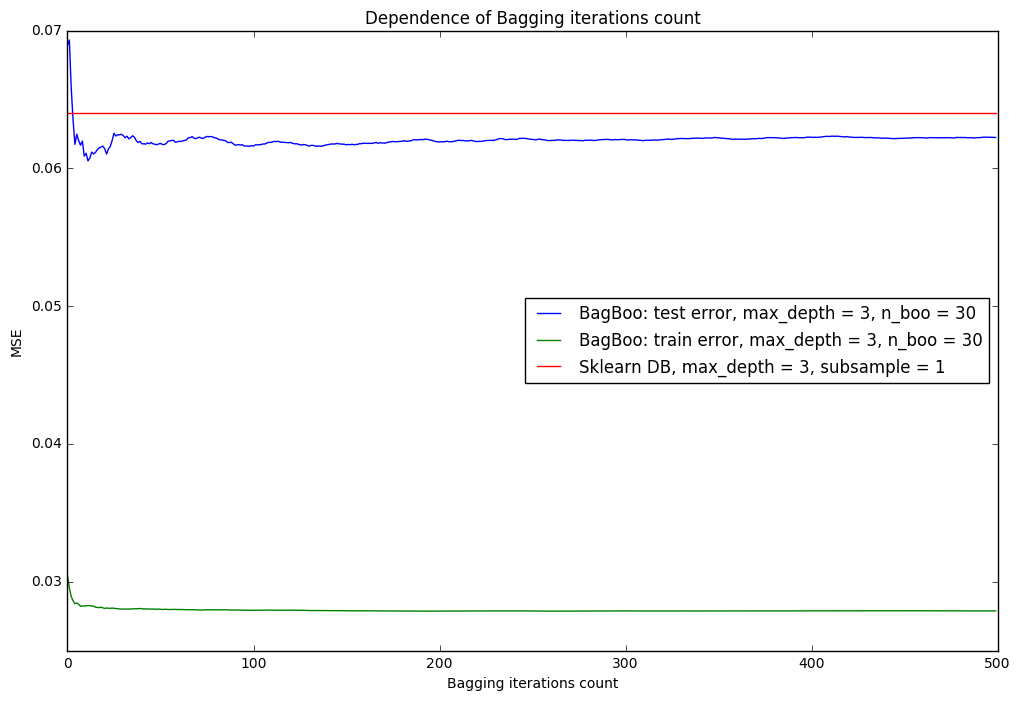

In [84]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.plot(range(0, 500), error_statistic_test, label='BagBoo: test error, max_depth = 3, n_boo = 30')
plt.plot(range(0, 500), error_statistic_train, label='BagBoo: train error, max_depth = 3, n_boo = 30')
# plt.plot(boo_list, skl_error, label='Sklearn DB, max_depth = 2, subsample = 1')
plt.plot(range(0, 500), [skl_error_100_3] * 500, label='Sklearn DB, max_depth = 3, subsample = 1')
ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Bagging iterations count')
ax.set_ylabel('MSE')